First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astroML.datasets import generate_mu_z
from astropy.cosmology import LambdaCDM
import dynesty
from dynesty import utils as dyfunc
import corner
from astroML.density_estimation import EmpiricalDistribution
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.optimize import fmin_cobyla

par_true = [71, 0.27]

plt.rcParams['figure.figsize']=(8,6) 
plt.rcParams['font.size']=18 
plt.rcParams['font.family']='Liberation Serif' 
plt.rcParams['figure.autolayout']=True 
plt.rcParams['mathtext.fontset'] = 'cm'

colors = ['palevioletred', 'mediumvioletred', 'darkmagenta', 'mediumblue', 'deepskyblue', 'forestgreen', 'limegreen', 'gold', 'orange', 'red']

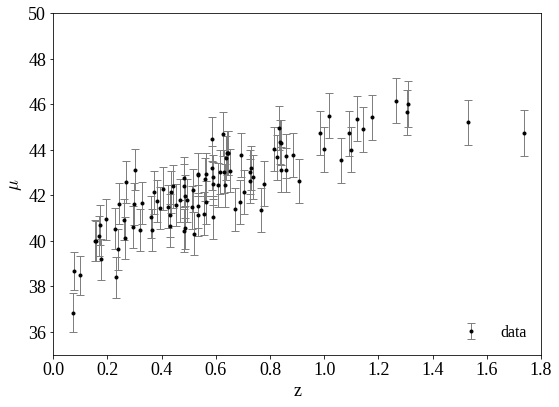

In [2]:
#generate the data samples and plot
z, mu, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', frameon=False, fontsize = 16)
plt.xlim(0,1.8)
plt.ylim(35,50)

#reshape the array of data
z_1 = z
z = z[:, np.newaxis]

Do cross-validation to determine the initial bandwidth for the kernel 

In [ ]:
def rms(x, y, model):
    return np.sqrt(np.sum((y - model.predict(x))**2)/len(x))

n_split = 3
cv_size = int(len(z)/n_split)
h_range = np.logspace(-2, 1, 100)
h_best = []    #array of best n evaluated
H = []
rms_train = np.zeros((n_split, len(h_range)))
rms_cv = np.zeros((n_split, len(h_range)))

for m in range(n_split):
    
    #build training and cross-validation set
    z_cv, mu_cv, dmu_cv = z[int(cv_size*m):int(cv_size*(m+1))], mu[int(cv_size*m):int(cv_size*(m+1))], dmu[int(cv_size*m):int(cv_size*(m+1))]
    indeces = np.arange(int(cv_size*m), int(cv_size*(m+1)), 1)
    z_train, mu_train, dmu_train = np.delete(z, indeces, axis = 0), np.delete(mu, indeces), np.delete(dmu, indeces)

    #cycle on the degree to evaluate the rms
    for n, h in enumerate(h_range):
        
        kernel = kernels.ConstantKernel(1, (1e-3, 1e3))*kernels.RBF(h, (1e-3, 15))
        gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha = dmu**2)
        gp.fit(z, mu)

        rms_train[int(m), int(n-1)] = rms(z_train, mu_train, gp)
        rms_cv[int(m), int(n-1)] = rms(z_cv, mu_cv, gp)
        H.append(gp.kernel_.get_params()['k2__length_scale'])
    #find the best value of the degree minimizing the cross-validation rms
    h_best.append(h_range[np.argmin(rms_cv[m])])

Text(0.5, 0, 'Bandwidth')

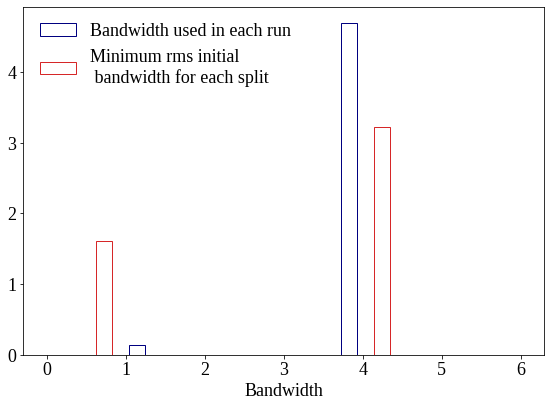

In [49]:
plt.hist(H, bins = np.linspace(0, 6, 30), density = True, histtype='step', color='navy', label='Bandwidth used in each run');
plt.hist(h_best, bins = np.linspace(0, 6, 30), density = True, histtype='step', color='tab:red', label='Minimum rms initial \n bandwidth for each split');
plt.legend(frameon=False, loc = 'upper left')
plt.xlabel('Bandwidth')

In [42]:
print(h_best)

[0.7564633275546291, 4.328761281083057, 4.328761281083057]


The optimal hyperparameters found by GPR are: 
 const = 941 
 h = 3.90


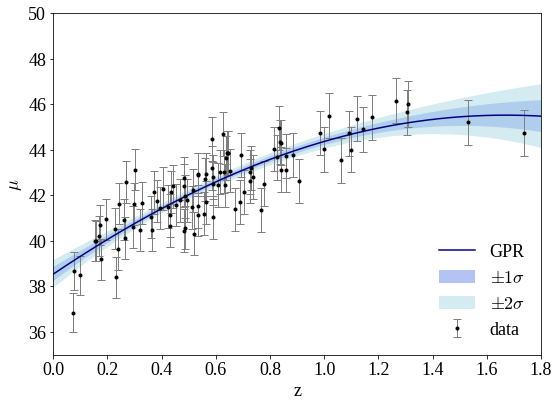

In [52]:
kernel = kernels.ConstantKernel(1, (1e-3, 1e3))*kernels.RBF(np.median(h_best), (1e-3, 10))
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha = dmu**2)
gp.fit(z, mu)

x = np.linspace(0, 2, 1000)
f, f_err = gp.predict(x[:, None], return_std=True)

#plot the data
plt.errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='data', capsize = 4)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,1.8)
plt.ylim(35,50)

#plot the fit
plt.plot(x, f, '-', color='navy', label='GPR')
plt.fill_between(x, f - f_err, f + f_err, color='royalblue', alpha=0.4, label='$\pm1\sigma$', edgecolor=None)
plt.fill_between(x, f - 2 * f_err, f + 2 * f_err, color='lightblue', alpha=0.5, label='$\pm2\sigma$', edgecolor=None)

plt.legend(frameon = False, loc='lower right')

print('The optimal hyperparameters found by GPR are: \n const = %.f \n h = %.2f' 
      %tuple([gp.kernel_.get_params()['k1__constant_value'], gp.kernel_.get_params()['k2__length_scale']]))

Now I use nested sampling to fit the data with the theoretical model:
$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$
two times:
- one with $\Omega_m = 1$ (which means $\Omega_{\lambda} = 1- \Omega_m = 0$) and $H_0$ as the only one free parameter (this is the null hypothesis of vanishing dark energy content in the universe)
- one with free parameters $H_0$ and $\Omega_m$, fixing $\Omega_{\lambda} = 1- \Omega_m$

In [4]:
#Null hypothesis
ndim = 1

def model0(x, par):
    H0 = par[0]
    y = LambdaCDM(H0=H0, Om0=1, Ode0=0)
    return y.distmod(x).value

#loglikelihood
def LogLike(par, x, y, dy, model):
    ypred = model(x, par)
    return -0.5*np.sum((y-ypred)**2/dy**2 )

#logprior
H0min,H0max = 0,100

def prior_transform0(u, model):
    par0 = np.array(u)  # copy u

    par0[0] = H0max*u[0] + H0min
    
    return par0

In [5]:
sampler = dynesty.NestedSampler(LogLike, prior_transform0, ndim, logl_args=[z_1, mu, dmu, model0], ptform_args = [model0], nlive=100)
sampler.run_nested()
sresults0 = sampler.results

494it [00:00, 525.20it/s, +100 | bound: 2 | nc: 1 | ncall: 3812 | eff(%): 16.002 | loglstar:   -inf < -47.102 <    inf | logz: -49.745 +/-  0.140 | dlogz:  0.001 >  0.109]


In [21]:
# Extract sampling results.
samples = sresults0.samples  # samples
weights = np.exp(sresults0.logwt - sresults0.logz[-1])  # normalized weights
    
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

#print the parameters median and the errors
low, med, up = np.percentile(samples_equal,[5,50, 95])
median_parameters0 = med
low_err0 = med - low
up_err0 = up - med
print('H_0:', med, '+', up-med, '-', med-low)
print('Distance from true value: ', med - par_true[0])

H_0: 57.81842693043678 + 3.838247053085034 - 3.568379118777976
Distance from true value:  -13.181573069563221


The true value of $H_0$ is not contained in the 90% confidence interval

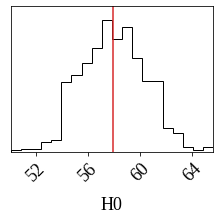

In [7]:
# Make the corner plot
import corner
labels=['H0']

figure = corner.corner(samples_equal, truths = [med], truth_color = 'tab:red', labels=labels, levels=[0.68,0.95]);

In [8]:
#Om != 0 hypothesis
ndim = 2

def model1(x, par):
    H0 = par[0]
    Om = par[1]
    y = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return y.distmod(x).value

#loglikelihood
def LogLike(par, x, y, dy, model):
    ypred = model(x, par)
    return -0.5*np.sum((y-ypred)**2/dy**2 )

#logprior
H0min,H0max = 0,100
Ommin,Ommax = 0,1

def prior_transform1(u, model):
    par0 = np.array(u)  # copy u

    par0[0] = H0max*u[0] + H0min
    par0[1] = Ommax*u[1] + Ommin
    
    return par0


In [9]:
sampler = dynesty.NestedSampler(LogLike, prior_transform1, ndim, logl_args=[z_1, mu, dmu, model1], ptform_args = [model1], nlive=100)
sampler.run_nested()
sresults1 = sampler.results

513it [00:01, 459.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4032 | eff(%): 15.590 | loglstar:   -inf < -46.388 <    inf | logz: -49.225 +/-  0.143 | dlogz:  0.001 >  0.109]


In [20]:
labels=['H0', 'Om']

# Extract sampling results.
samples = sresults1.samples  # samples
weights = np.exp(sresults1.logwt - sresults1.logz[-1])  # normalized weights
    
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

#print the parameters median and the errors
median_parameters1 = []
low_err1 = []
up_err1 = []

for i in range(ndim):
    low, med, up = np.percentile(samples_equal[:,i],[5,50, 95])
    median_parameters1.append(med)
    low_err1.append(med - low)
    up_err1.append(up - med)
    print(labels[i], med, '+', up-med, '-', med-low)
    print('Distance from true value: ', med - par_true[i])

H0 66.25956983489515 + 10.980418240187959 - 8.59188390707159
Distance from true value:  -4.740430165104854
Om 0.4437851052608631 + 0.47178034105129507 - 0.37133954912971423
Distance from true value:  0.1737851052608631


Both true values are within the 90% confidence level from the median of the found posterior distributions 

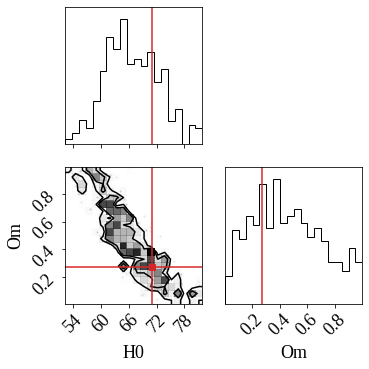

In [11]:
# Make the corner plot
figure = corner.corner(samples_equal, labels=labels, levels=[0.68,0.95], truths = par_true, truth_color='tab:red');

/home/irene/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
<ipython-input-18-910eea419c05>:20: RuntimeWarning: invalid value encountered in subtract
  ax[1].plot(x, mu_true - mu_true, '--', c='gray')
<ipython-input-18-910eea419c05>:21: RuntimeWarning: invalid value encountered in subtract
  ax[1].plot(x, y1 - mu_true, color='tab:red', label=r'$\Omega_{\lambda} \neq 0$')
<ipython-input-18-910eea419c05>:22: RuntimeWarning: invalid value encountered in subtract
  ax[1].plot(x, y0 - mu_true, color='navy', label='$\Omega_{\lambda} = 0$')


Text(0.5, 0, 'z')

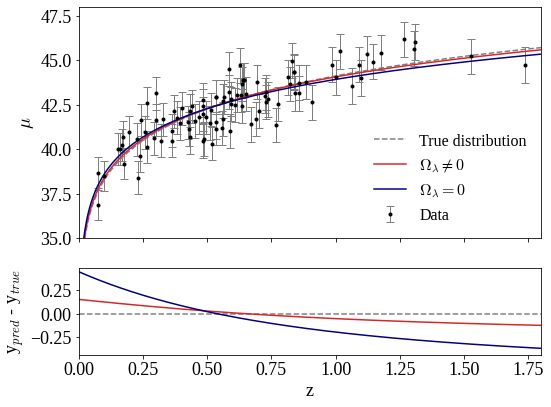

In [18]:
fig, ax = plt.subplots(2, 1, figsize = (8, 6), gridspec_kw={'height_ratios': [8, 3]}, sharex = True)

#plot the data
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
mu_true = cosmo.distmod(x).value

y1 = model1(x, median_parameters1)
y0 = model0(x, [median_parameters0])
ax[0].errorbar(z, mu, dmu, fmt='.k', ecolor='gray', lw=1,label='Data', capsize = 4)
ax[0].plot(x, mu_true, '--', c='gray',label='True distribution')
ax[0].plot(x, y1, c='tab:red', label=r'$\Omega_{\lambda} \neq 0$')
ax[0].plot(x, y0, c='navy', label='$\Omega_{\lambda} = 0$')

ax[0].set_xlim(0,1.8)
ax[0].set_ylabel("$\mu$")
ax[0].set_ylim(35,48)
ax[0].legend(frameon=False, fontsize=16)

ax[1].plot(x, mu_true - mu_true, '--', c='gray')
ax[1].plot(x, y1 - mu_true, color='tab:red', label=r'$\Omega_{\lambda} \neq 0$')
ax[1].plot(x, y0 - mu_true, color='navy', label='$\Omega_{\lambda} = 0$')
ax[1].set_ylabel('y$_{pred}$ - y$_{true}$')

ax[1].set_xlabel("z")

In [19]:
Evidence0 = np.exp(sresults0.logz[-1])
Evidence1 = np.exp(sresults1.logz[-1])
Odds = Evidence1/Evidence0
print('Odds ratio =', Odds)

Odds ratio = 1.6821081214003843


### Evaluate the Bayes factor distribution for the null hypothesis to understand at what confidence level data prefer the dark energy model over the null hypothesis

Text(0, 0.5, '$\\mu$')

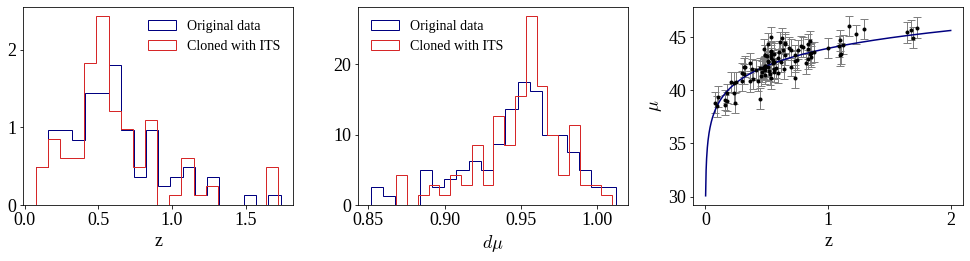

In [42]:
#example of generated fake data
fig, ax = plt.subplots(1, 3, figsize = (14, 4))

n_random = 100

#generate z according to the data distribution
z_random = EmpiricalDistribution(z_1).rvs(n_random)
ax[0].hist(z_1, bins = 20, histtype='step', color='navy', density = True, label = 'Original data');
ax[0].hist(z_random, bins = 20, histtype='step', color='tab:red', density = True, label = 'Cloned with ITS');
ax[0].set_xlabel('z')
ax[0].legend(frameon=False, fontsize=14)

#generate the errors acccording to the data errors distribution
dmu_random = EmpiricalDistribution(dmu).rvs(n_random)
ax[1].hist(dmu, bins = 20, histtype='step', color='navy', density = True, label = 'Original data');
ax[1].hist(dmu_random, bins = 20, histtype='step', color='tab:red', density = True, label = 'Cloned with ITS');
ax[1].set_xlabel('$d\mu$')
ax[1].legend(frameon=False, fontsize=14, loc = 'upper left')

#generate mu around the null model
mu_random = model0(z_random, [median_parameters0]) + np.random.normal(loc = 0, scale = np.mean(dmu), size = n_random)  

ax[2].errorbar(z_random, mu_random, dmu_random, fmt='.k', ecolor='gray', lw=1,label='Data', capsize = 4)
ax[2].plot(x, y0, c='navy', label='$\Omega_{\lambda} = 0$')
ax[2].set_xlabel('z')
ax[2].set_ylabel('$\mu$')

In [38]:
N_realizations = 1000   #number of datatsets used to estimate the odds ratio distribution

Evidence0_v1 = []
Evidence1_v1 = []
import time
start = time.time()
for N in range(N_realizations):
    
    #generate points with errors according to the null model
    z_random = EmpiricalDistribution(z_1).rvs(n_random)
    mu_random = model0(z_random, [median_parameters0]) + np.random.normal(loc = 0, scale = np.mean(dmu), size = n_random)  
    dmu_random = EmpiricalDistribution(dmu).rvs(n_random)

    #fit with the null model
    sampler = dynesty.NestedSampler(LogLike, prior_transform0, ndim, logl_args=[z_random, mu_random, dmu_random, model0], ptform_args = [model0], nlive=100)
    sampler.run_nested()
    e0 = np.exp(sampler.results.logz[-1])
    Evidence0_v.append(e0)
    
    #fit with the dark energy model
    sampler = dynesty.NestedSampler(LogLike, prior_transform1, ndim, logl_args=[z_random, mu_random, dmu_random, model1], ptform_args = [model1], nlive=100)
    sampler.run_nested()
    Evidence1_v.append(np.exp(sampler.results.logz[-1]))
    print(N, 'time taken =', (time.time()-start)/60, 'minutes', 'OR =', np.exp(sampler.results.logz[-1])/e0)

495it [00:00, 567.50it/s, +100 | bound: 2 | nc: 1 | ncall: 3829 | eff(%): 15.956 | loglstar:   -inf < -45.419 <    inf | logz: -48.074 +/-  0.140 | dlogz:  0.001 >  0.109]
525it [00:01, 440.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4243 | eff(%): 15.086 | loglstar:   -inf < -45.137 <    inf | logz: -48.094 +/-  0.145 | dlogz:  0.001 >  0.109]


0 time taken = 0.03536398410797119 minutes OR = 0.9799161760819936


516it [00:01, 491.33it/s, +100 | bound: 2 | nc: 1 | ncall: 4158 | eff(%): 15.180 | loglstar:   -inf < -61.573 <    inf | logz: -64.429 +/-  0.147 | dlogz:  0.001 >  0.109]
620it [00:01, 445.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4660 | eff(%): 15.789 | loglstar:   -inf < -61.574 <    inf | logz: -65.482 +/-  0.167 | dlogz:  0.001 >  0.109]


1 time taken = 0.07694079875946044 minutes OR = 0.3488525011001651


505it [00:01, 474.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4075 | eff(%): 15.220 | loglstar:   -inf < -54.445 <    inf | logz: -57.197 +/-  0.143 | dlogz:  0.001 >  0.109]
510it [00:01, 423.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3938 | eff(%): 15.894 | loglstar:   -inf < -53.508 <    inf | logz: -56.315 +/-  0.140 | dlogz:  0.001 >  0.109]


2 time taken = 0.11563862959543864 minutes OR = 2.4155835817479003


493it [00:00, 514.91it/s, +100 | bound: 2 | nc: 1 | ncall: 3963 | eff(%): 15.351 | loglstar:   -inf < -47.474 <    inf | logz: -50.108 +/-  0.139 | dlogz:  0.001 >  0.109]
607it [00:01, 421.23it/s, +100 | bound: 4 | nc: 1 | ncall: 4476 | eff(%): 16.156 | loglstar:   -inf < -47.480 <    inf | logz: -51.252 +/-  0.166 | dlogz:  0.001 >  0.109]


3 time taken = 0.15649936199188233 minutes OR = 0.3185453465657756


521it [00:01, 477.01it/s, +100 | bound: 2 | nc: 1 | ncall: 4381 | eff(%): 14.506 | loglstar:   -inf < -55.118 <    inf | logz: -58.029 +/-  0.148 | dlogz:  0.001 >  0.109]
588it [00:01, 415.41it/s, +100 | bound: 5 | nc: 1 | ncall: 4391 | eff(%): 16.034 | loglstar:   -inf < -55.121 <    inf | logz: -58.711 +/-  0.160 | dlogz:  0.001 >  0.109]


4 time taken = 0.19922943115234376 minutes OR = 0.5056527044529342


512it [00:01, 454.68it/s, +100 | bound: 3 | nc: 1 | ncall: 4121 | eff(%): 15.220 | loglstar:   -inf < -51.881 <    inf | logz: -54.699 +/-  0.145 | dlogz:  0.001 >  0.109]
560it [00:01, 396.29it/s, +100 | bound: 4 | nc: 1 | ncall: 4075 | eff(%): 16.604 | loglstar:   -inf < -51.883 <    inf | logz: -55.190 +/-  0.155 | dlogz:  0.001 >  0.109]


5 time taken = 0.242597230275472 minutes OR = 0.6117998806374844


522it [00:01, 452.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4390 | eff(%): 14.499 | loglstar:   -inf < -48.435 <    inf | logz: -51.357 +/-  0.149 | dlogz:  0.001 >  0.109]
581it [00:01, 401.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4422 | eff(%): 15.757 | loglstar:   -inf < -48.441 <    inf | logz: -51.958 +/-  0.159 | dlogz:  0.001 >  0.109]


6 time taken = 0.2868574341138204 minutes OR = 0.5477592068840149


506it [00:01, 458.79it/s, +100 | bound: 3 | nc: 1 | ncall: 3924 | eff(%): 15.847 | loglstar:   -inf < -38.657 <    inf | logz: -41.417 +/-  0.144 | dlogz:  0.001 >  0.109]
609it [00:01, 447.74it/s, +100 | bound: 5 | nc: 1 | ncall: 4090 | eff(%): 17.769 | loglstar:   -inf < -38.664 <    inf | logz: -42.457 +/-  0.163 | dlogz:  0.001 >  0.109]


7 time taken = 0.3288396159807841 minutes OR = 0.35339864441320396


499it [00:01, 491.44it/s, +100 | bound: 3 | nc: 1 | ncall: 3991 | eff(%): 15.395 | loglstar:   -inf < -48.296 <    inf | logz: -50.985 +/-  0.141 | dlogz:  0.001 >  0.109]
562it [00:01, 464.62it/s, +100 | bound: 3 | nc: 1 | ncall: 4092 | eff(%): 16.583 | loglstar:   -inf < -48.311 <    inf | logz: -51.639 +/-  0.154 | dlogz:  0.001 >  0.109]


8 time taken = 0.3667725682258606 minutes OR = 0.5199600838164142


483it [00:00, 503.00it/s, +100 | bound: 3 | nc: 1 | ncall: 3671 | eff(%): 16.326 | loglstar:   -inf < -46.835 <    inf | logz: -49.367 +/-  0.137 | dlogz:  0.001 >  0.109]
544it [00:01, 430.93it/s, +100 | bound: 4 | nc: 1 | ncall: 4010 | eff(%): 16.471 | loglstar:   -inf < -46.838 <    inf | logz: -49.985 +/-  0.151 | dlogz:  0.001 >  0.109]


9 time taken = 0.4046889305114746 minutes OR = 0.5388776858133981


487it [00:00, 494.36it/s, +100 | bound: 2 | nc: 1 | ncall: 3857 | eff(%): 15.624 | loglstar:   -inf < -63.425 <    inf | logz: -65.997 +/-  0.137 | dlogz:  0.001 >  0.109]
524it [00:01, 426.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4021 | eff(%): 15.914 | loglstar:   -inf < -63.076 <    inf | logz: -66.024 +/-  0.146 | dlogz:  0.001 >  0.109]


10 time taken = 0.4424605131149292 minutes OR = 0.9730513678708275


510it [00:01, 485.64it/s, +100 | bound: 3 | nc: 1 | ncall: 4023 | eff(%): 15.549 | loglstar:   -inf < -43.821 <    inf | logz: -46.624 +/-  0.146 | dlogz:  0.001 >  0.109]
590it [00:01, 436.61it/s, +100 | bound: 4 | nc: 1 | ncall: 4218 | eff(%): 16.756 | loglstar:   -inf < -43.829 <    inf | logz: -47.434 +/-  0.160 | dlogz:  0.001 >  0.109]


11 time taken = 0.4833694060643514 minutes OR = 0.4447036290144278


472it [00:01, 431.80it/s, +100 | bound: 3 | nc: 1 | ncall: 3808 | eff(%): 15.426 | loglstar:   -inf < -45.389 <    inf | logz: -47.810 +/-  0.132 | dlogz:  0.001 >  0.109]
501it [00:01, 427.63it/s, +100 | bound: 3 | nc: 1 | ncall: 3778 | eff(%): 16.340 | loglstar:   -inf < -44.965 <    inf | logz: -47.682 +/-  0.136 | dlogz:  0.001 >  0.109]


12 time taken = 0.5219962000846863 minutes OR = 1.137328239806179


497it [00:01, 471.11it/s, +100 | bound: 3 | nc: 1 | ncall: 3973 | eff(%): 15.414 | loglstar:   -inf < -53.925 <    inf | logz: -56.591 +/-  0.140 | dlogz:  0.001 >  0.109]
577it [00:01, 435.07it/s, +100 | bound: 4 | nc: 1 | ncall: 4007 | eff(%): 17.328 | loglstar:   -inf < -53.929 <    inf | logz: -57.404 +/-  0.156 | dlogz:  0.001 >  0.109]


13 time taken = 0.5625919858614604 minutes OR = 0.44365578074839734


489it [00:01, 466.45it/s, +100 | bound: 3 | nc: 1 | ncall: 3847 | eff(%): 15.719 | loglstar:   -inf < -45.895 <    inf | logz: -48.483 +/-  0.139 | dlogz:  0.001 >  0.109]
530it [00:01, 404.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4150 | eff(%): 15.556 | loglstar:   -inf < -45.806 <    inf | logz: -48.808 +/-  0.146 | dlogz:  0.001 >  0.109]


14 time taken = 0.6028252283732096 minutes OR = 0.7225279903785159


513it [00:01, 508.94it/s, +100 | bound: 2 | nc: 1 | ncall: 3998 | eff(%): 15.726 | loglstar:   -inf < -50.157 <    inf | logz: -52.983 +/-  0.146 | dlogz:  0.001 >  0.109]
603it [00:01, 435.17it/s, +100 | bound: 4 | nc: 1 | ncall: 4311 | eff(%): 16.694 | loglstar:   -inf < -50.159 <    inf | logz: -53.895 +/-  0.162 | dlogz:  0.001 >  0.109]


15 time taken = 0.6436248302459717 minutes OR = 0.40172160428589243


471it [00:00, 489.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3588 | eff(%): 16.370 | loglstar:   -inf < -48.698 <    inf | logz: -51.113 +/-  0.132 | dlogz:  0.001 >  0.109]
543it [00:01, 388.19it/s, +100 | bound: 4 | nc: 1 | ncall: 4090 | eff(%): 16.115 | loglstar:   -inf < -48.700 <    inf | logz: -51.830 +/-  0.150 | dlogz:  0.001 >  0.109]


16 time taken = 0.6838651537895203 minutes OR = 0.4879997848349106


520it [00:01, 471.51it/s, +100 | bound: 2 | nc: 1 | ncall: 4269 | eff(%): 14.872 | loglstar:   -inf < -49.756 <    inf | logz: -52.655 +/-  0.148 | dlogz:  0.001 >  0.109]
547it [00:01, 394.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4238 | eff(%): 15.636 | loglstar:   -inf < -48.579 <    inf | logz: -51.756 +/-  0.149 | dlogz:  0.001 >  0.109]


17 time taken = 0.7262894074122112 minutes OR = 2.4554487796289357


512it [00:01, 493.35it/s, +100 | bound: 2 | nc: 1 | ncall: 4221 | eff(%): 14.851 | loglstar:   -inf < -60.643 <    inf | logz: -63.466 +/-  0.145 | dlogz:  0.001 >  0.109]
523it [00:01, 397.29it/s, +100 | bound: 4 | nc: 1 | ncall: 4137 | eff(%): 15.432 | loglstar:   -inf < -60.589 <    inf | logz: -63.520 +/-  0.146 | dlogz:  0.001 >  0.109]


18 time taken = 0.7664324045181274 minutes OR = 0.9472253523535941


501it [00:00, 505.89it/s, +100 | bound: 2 | nc: 1 | ncall: 3921 | eff(%): 15.729 | loglstar:   -inf < -46.591 <    inf | logz: -49.299 +/-  0.142 | dlogz:  0.001 >  0.109]
549it [00:01, 424.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 15.768 | loglstar:   -inf < -46.572 <    inf | logz: -49.760 +/-  0.151 | dlogz:  0.001 >  0.109]


19 time taken = 0.8053779641787211 minutes OR = 0.6306117650525901


496it [00:01, 487.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3841 | eff(%): 15.932 | loglstar:   -inf < -52.513 <    inf | logz: -55.175 +/-  0.140 | dlogz:  0.001 >  0.109]
548it [00:01, 416.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4298 | eff(%): 15.436 | loglstar:   -inf < -52.406 <    inf | logz: -55.588 +/-  0.152 | dlogz:  0.001 >  0.109]


20 time taken = 0.8451772093772888 minutes OR = 0.6618434994509609


503it [00:01, 468.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4061 | eff(%): 15.223 | loglstar:   -inf < -47.810 <    inf | logz: -50.538 +/-  0.143 | dlogz:  0.001 >  0.109]
517it [00:01, 406.63it/s, +100 | bound: 3 | nc: 1 | ncall: 3988 | eff(%): 15.869 | loglstar:   -inf < -46.802 <    inf | logz: -49.677 +/-  0.142 | dlogz:  0.001 >  0.109]


21 time taken = 0.8852160056432088 minutes OR = 2.3651220404623237


513it [00:01, 470.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4210 | eff(%): 14.915 | loglstar:   -inf < -55.071 <    inf | logz: -57.902 +/-  0.145 | dlogz:  0.001 >  0.109]
551it [00:01, 420.07it/s, +100 | bound: 3 | nc: 1 | ncall: 4321 | eff(%): 15.423 | loglstar:   -inf < -53.501 <    inf | logz: -56.711 +/-  0.149 | dlogz:  0.001 >  0.109]


22 time taken = 0.92615274588267 minutes OR = 3.28889722271671


494it [00:01, 473.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3989 | eff(%): 15.274 | loglstar:   -inf < -42.967 <    inf | logz: -45.613 +/-  0.140 | dlogz:  0.001 >  0.109]
534it [00:01, 421.21it/s, +100 | bound: 4 | nc: 1 | ncall: 4061 | eff(%): 16.006 | loglstar:   -inf < -42.970 <    inf | logz: -46.017 +/-  0.148 | dlogz:  0.001 >  0.109]


23 time taken = 0.9655461112658182 minutes OR = 0.6673155068992538


484it [00:00, 493.26it/s, +100 | bound: 3 | nc: 1 | ncall: 3803 | eff(%): 15.771 | loglstar:   -inf < -54.084 <    inf | logz: -56.629 +/-  0.137 | dlogz:  0.001 >  0.109]
503it [00:01, 395.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4065 | eff(%): 15.208 | loglstar:   -inf < -53.754 <    inf | logz: -56.484 +/-  0.138 | dlogz:  0.001 >  0.109]


24 time taken = 1.0039575179417928 minutes OR = 1.1557587101417586


486it [00:00, 493.05it/s, +100 | bound: 3 | nc: 1 | ncall: 3632 | eff(%): 16.591 | loglstar:   -inf < -49.962 <    inf | logz: -52.526 +/-  0.137 | dlogz:  0.001 >  0.109]
633it [00:01, 432.52it/s, +100 | bound: 5 | nc: 1 | ncall: 4376 | eff(%): 17.142 | loglstar:   -inf < -49.969 <    inf | logz: -54.000 +/-  0.170 | dlogz:  0.001 >  0.109]


25 time taken = 1.0456667025883992 minutes OR = 0.22880119688512535


491it [00:00, 500.13it/s, +100 | bound: 2 | nc: 1 | ncall: 3965 | eff(%): 15.291 | loglstar:   -inf < -54.723 <    inf | logz: -57.336 +/-  0.138 | dlogz:  0.001 >  0.109]
542it [00:01, 411.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4405 | eff(%): 14.913 | loglstar:   -inf < -54.643 <    inf | logz: -57.764 +/-  0.150 | dlogz:  0.001 >  0.109]


26 time taken = 1.0848891655604045 minutes OR = 0.6517819900438807


537it [00:01, 492.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4316 | eff(%): 15.109 | loglstar:   -inf < -37.162 <    inf | logz: -40.232 +/-  0.153 | dlogz:  0.001 >  0.109]
594it [00:01, 421.07it/s, +100 | bound: 5 | nc: 1 | ncall: 4278 | eff(%): 16.611 | loglstar:   -inf < -37.174 <    inf | logz: -40.819 +/-  0.158 | dlogz:  0.001 >  0.109]


27 time taken = 1.1274304827054342 minutes OR = 0.5562638523872349


512it [00:01, 500.49it/s, +100 | bound: 2 | nc: 1 | ncall: 4131 | eff(%): 15.182 | loglstar:   -inf < -51.732 <    inf | logz: -54.549 +/-  0.146 | dlogz:  0.001 >  0.109]
573it [00:01, 433.17it/s, +100 | bound: 5 | nc: 1 | ncall: 4080 | eff(%): 16.910 | loglstar:   -inf < -51.736 <    inf | logz: -55.168 +/-  0.155 | dlogz:  0.001 >  0.109]


28 time taken = 1.1673757115999857 minutes OR = 0.5384432918264559


496it [00:00, 500.74it/s, +100 | bound: 2 | nc: 1 | ncall: 4023 | eff(%): 15.192 | loglstar:   -inf < -44.611 <    inf | logz: -47.268 +/-  0.140 | dlogz:  0.001 >  0.109]
584it [00:01, 458.15it/s, +100 | bound: 5 | nc: 1 | ncall: 3839 | eff(%): 18.294 | loglstar:   -inf < -44.627 <    inf | logz: -48.170 +/-  0.157 | dlogz:  0.001 >  0.109]


29 time taken = 1.2059764504432677 minutes OR = 0.4060320609046141


488it [00:00, 516.06it/s, +100 | bound: 2 | nc: 1 | ncall: 3814 | eff(%): 15.832 | loglstar:   -inf < -46.388 <    inf | logz: -48.966 +/-  0.138 | dlogz:  0.001 >  0.109]
570it [00:01, 435.26it/s, +100 | bound: 3 | nc: 1 | ncall: 4068 | eff(%): 16.885 | loglstar:   -inf < -46.388 <    inf | logz: -49.794 +/-  0.158 | dlogz:  0.001 >  0.109]


30 time taken = 1.2444357395172119 minutes OR = 0.4370122285598609


524it [00:01, 495.65it/s, +100 | bound: 2 | nc: 1 | ncall: 4052 | eff(%): 15.789 | loglstar:   -inf < -41.443 <    inf | logz: -44.383 +/-  0.150 | dlogz:  0.001 >  0.109]
597it [00:01, 408.73it/s, +100 | bound: 4 | nc: 1 | ncall: 4443 | eff(%): 16.049 | loglstar:   -inf < -41.444 <    inf | logz: -45.116 +/-  0.164 | dlogz:  0.001 >  0.109]


31 time taken = 1.2872806747754415 minutes OR = 0.4807311178727814


515it [00:01, 472.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4230 | eff(%): 14.891 | loglstar:   -inf < -53.046 <    inf | logz: -55.894 +/-  0.147 | dlogz:  0.001 >  0.109]
562it [00:01, 426.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4373 | eff(%): 15.493 | loglstar:   -inf < -53.047 <    inf | logz: -56.372 +/-  0.155 | dlogz:  0.001 >  0.109]


32 time taken = 1.3282912850379944 minutes OR = 0.6200295318760157


488it [00:00, 508.92it/s, +100 | bound: 2 | nc: 1 | ncall: 3903 | eff(%): 15.461 | loglstar:   -inf < -56.203 <    inf | logz: -58.785 +/-  0.138 | dlogz:  0.001 >  0.109]
527it [00:01, 430.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4057 | eff(%): 15.845 | loglstar:   -inf < -56.028 <    inf | logz: -59.003 +/-  0.145 | dlogz:  0.001 >  0.109]


33 time taken = 1.3655545194943746 minutes OR = 0.8040982949517116


491it [00:00, 496.14it/s, +100 | bound: 3 | nc: 1 | ncall: 3799 | eff(%): 15.977 | loglstar:   -inf < -38.557 <    inf | logz: -41.173 +/-  0.139 | dlogz:  0.001 >  0.109]
569it [00:01, 450.24it/s, +100 | bound: 4 | nc: 1 | ncall: 4028 | eff(%): 17.032 | loglstar:   -inf < -38.562 <    inf | logz: -41.960 +/-  0.156 | dlogz:  0.001 >  0.109]


34 time taken = 1.4039496858914693 minutes OR = 0.45518937230914264


501it [00:01, 481.34it/s, +100 | bound: 3 | nc: 1 | ncall: 3770 | eff(%): 16.376 | loglstar:   -inf < -39.101 <    inf | logz: -41.807 +/-  0.143 | dlogz:  0.001 >  0.109]
569it [00:01, 428.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4252 | eff(%): 16.113 | loglstar:   -inf < -39.092 <    inf | logz: -42.478 +/-  0.158 | dlogz:  0.001 >  0.109]


35 time taken = 1.444331912199656 minutes OR = 0.5113487785212654


500it [00:01, 477.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4007 | eff(%): 15.357 | loglstar:   -inf < -43.429 <    inf | logz: -46.128 +/-  0.141 | dlogz:  0.001 >  0.109]
549it [00:01, 426.96it/s, +100 | bound: 4 | nc: 1 | ncall: 4058 | eff(%): 16.397 | loglstar:   -inf < -43.433 <    inf | logz: -46.630 +/-  0.152 | dlogz:  0.001 >  0.109]


36 time taken = 1.4841108123461406 minutes OR = 0.6051655927820766


526it [00:01, 496.64it/s, +100 | bound: 2 | nc: 1 | ncall: 4216 | eff(%): 15.209 | loglstar:   -inf < -48.995 <    inf | logz: -51.954 +/-  0.150 | dlogz:  0.001 >  0.109]
572it [00:01, 426.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4464 | eff(%): 15.399 | loglstar:   -inf < -48.992 <    inf | logz: -52.412 +/-  0.161 | dlogz:  0.001 >  0.109]


37 time taken = 1.5249749660491942 minutes OR = 0.6322224632588335


495it [00:00, 507.37it/s, +100 | bound: 3 | nc: 1 | ncall: 3736 | eff(%): 16.364 | loglstar:   -inf < -53.469 <    inf | logz: -56.116 +/-  0.140 | dlogz:  0.001 >  0.109]
517it [00:01, 416.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4119 | eff(%): 15.352 | loglstar:   -inf < -53.151 <    inf | logz: -56.029 +/-  0.143 | dlogz:  0.001 >  0.109]


38 time taken = 1.5627910057703653 minutes OR = 1.0907733828281556


511it [00:01, 500.53it/s, +100 | bound: 2 | nc: 1 | ncall: 4204 | eff(%): 14.888 | loglstar:   -inf < -58.982 <    inf | logz: -61.793 +/-  0.146 | dlogz:  0.001 >  0.109]
571it [00:01, 451.23it/s, +100 | bound: 4 | nc: 1 | ncall: 3935 | eff(%): 17.497 | loglstar:   -inf < -58.985 <    inf | logz: -62.396 +/-  0.156 | dlogz:  0.001 >  0.109]


39 time taken = 1.6017692645390829 minutes OR = 0.5470726955635649


509it [00:01, 507.57it/s, +100 | bound: 2 | nc: 1 | ncall: 4005 | eff(%): 15.595 | loglstar:   -inf < -49.132 <    inf | logz: -51.928 +/-  0.144 | dlogz:  0.001 >  0.109]
529it [00:01, 426.29it/s, +100 | bound: 3 | nc: 1 | ncall: 4096 | eff(%): 15.741 | loglstar:   -inf < -48.366 <    inf | logz: -51.363 +/-  0.147 | dlogz:  0.001 >  0.109]


40 time taken = 1.6400283336639405 minutes OR = 1.7597279025307089


527it [00:01, 482.91it/s, +100 | bound: 3 | nc: 1 | ncall: 4242 | eff(%): 15.138 | loglstar:   -inf < -53.084 <    inf | logz: -56.049 +/-  0.151 | dlogz:  0.001 >  0.109]
522it [00:01, 424.32it/s, +100 | bound: 3 | nc: 1 | ncall: 3917 | eff(%): 16.296 | loglstar:   -inf < -52.833 <    inf | logz: -55.758 +/-  0.145 | dlogz:  0.001 >  0.109]


41 time taken = 1.679592458407084 minutes OR = 1.3381833499619695


514it [00:01, 487.55it/s, +100 | bound: 3 | nc: 1 | ncall: 3923 | eff(%): 16.061 | loglstar:   -inf < -60.872 <    inf | logz: -63.708 +/-  0.147 | dlogz:  0.001 >  0.109]
596it [00:01, 442.31it/s, +100 | bound: 4 | nc: 1 | ncall: 4113 | eff(%): 17.344 | loglstar:   -inf < -60.874 <    inf | logz: -64.541 +/-  0.162 | dlogz:  0.001 >  0.109]


42 time taken = 1.7205335219701132 minutes OR = 0.4349310111868454


502it [00:01, 467.14it/s, +100 | bound: 2 | nc: 1 | ncall: 4088 | eff(%): 15.095 | loglstar:   -inf < -51.393 <    inf | logz: -54.118 +/-  0.142 | dlogz:  0.001 >  0.109]
556it [00:01, 400.64it/s, +100 | bound: 4 | nc: 1 | ncall: 4067 | eff(%): 16.536 | loglstar:   -inf < -51.391 <    inf | logz: -54.654 +/-  0.155 | dlogz:  0.001 >  0.109]


43 time taken = 1.7625616312026977 minutes OR = 0.585120898960947


496it [00:01, 448.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4081 | eff(%): 14.971 | loglstar:   -inf < -43.760 <    inf | logz: -46.424 +/-  0.139 | dlogz:  0.001 >  0.109]
649it [00:01, 424.44it/s, +100 | bound: 5 | nc: 1 | ncall: 4529 | eff(%): 16.911 | loglstar:   -inf < -43.774 <    inf | logz: -47.966 +/-  0.172 | dlogz:  0.001 >  0.109]


44 time taken = 1.807456362247467 minutes OR = 0.21396953611833336


498it [00:01, 478.56it/s, +100 | bound: 2 | nc: 1 | ncall: 4086 | eff(%): 15.003 | loglstar:   -inf < -52.809 <    inf | logz: -55.491 +/-  0.140 | dlogz:  0.001 >  0.109]
579it [00:01, 457.80it/s, +100 | bound: 3 | nc: 1 | ncall: 4227 | eff(%): 16.453 | loglstar:   -inf < -52.817 <    inf | logz: -56.306 +/-  0.159 | dlogz:  0.001 >  0.109]


45 time taken = 1.8467827320098877 minutes OR = 0.44264262993191295


526it [00:01, 516.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4065 | eff(%): 15.788 | loglstar:   -inf < -46.094 <    inf | logz: -49.052 +/-  0.152 | dlogz:  0.001 >  0.109]
573it [00:01, 449.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4392 | eff(%): 15.680 | loglstar:   -inf < -44.172 <    inf | logz: -47.601 +/-  0.156 | dlogz:  0.001 >  0.109]


46 time taken = 1.8859032233556112 minutes OR = 4.267335468874592


518it [00:01, 517.09it/s, +100 | bound: 2 | nc: 1 | ncall: 4282 | eff(%): 14.778 | loglstar:   -inf < -52.907 <    inf | logz: -55.789 +/-  0.147 | dlogz:  0.001 >  0.109]
556it [00:01, 452.80it/s, +100 | bound: 4 | nc: 1 | ncall: 3884 | eff(%): 17.336 | loglstar:   -inf < -52.908 <    inf | logz: -56.178 +/-  0.152 | dlogz:  0.001 >  0.109]


47 time taken = 1.9239218473434447 minutes OR = 0.6774837877283555


543it [00:01, 449.41it/s, +100 | bound: 3 | nc: 1 | ncall: 4422 | eff(%): 14.877 | loglstar:   -inf < -39.618 <    inf | logz: -42.746 +/-  0.156 | dlogz:  0.001 >  0.109]
595it [00:01, 426.54it/s, +100 | bound: 4 | nc: 1 | ncall: 4417 | eff(%): 16.099 | loglstar:   -inf < -39.621 <    inf | logz: -43.276 +/-  0.160 | dlogz:  0.001 >  0.109]


48 time taken = 1.9681774854660035 minutes OR = 0.5885644843907467


471it [00:01, 464.82it/s, +100 | bound: 3 | nc: 1 | ncall: 3754 | eff(%): 15.627 | loglstar:   -inf < -54.625 <    inf | logz: -57.039 +/-  0.132 | dlogz:  0.001 >  0.109]
542it [00:01, 444.09it/s, +100 | bound: 3 | nc: 1 | ncall: 3984 | eff(%): 16.529 | loglstar:   -inf < -54.617 <    inf | logz: -57.734 +/-  0.151 | dlogz:  0.001 >  0.109]


49 time taken = 2.006319864590963 minutes OR = 0.49907440934672387


522it [00:01, 475.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4240 | eff(%): 15.024 | loglstar:   -inf < -52.343 <    inf | logz: -55.265 +/-  0.149 | dlogz:  0.001 >  0.109]
571it [00:01, 429.87it/s, +100 | bound: 4 | nc: 1 | ncall: 4058 | eff(%): 16.953 | loglstar:   -inf < -52.345 <    inf | logz: -55.758 +/-  0.157 | dlogz:  0.001 >  0.109]


50 time taken = 2.0476583441098533 minutes OR = 0.610617459663774


517it [00:01, 503.92it/s, +100 | bound: 2 | nc: 1 | ncall: 4047 | eff(%): 15.632 | loglstar:   -inf < -49.262 <    inf | logz: -52.134 +/-  0.148 | dlogz:  0.001 >  0.109]
550it [00:01, 439.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4126 | eff(%): 16.145 | loglstar:   -inf < -49.239 <    inf | logz: -52.436 +/-  0.152 | dlogz:  0.001 >  0.109]


51 time taken = 2.0865692098935447 minutes OR = 0.7394213861650709


508it [00:01, 480.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4069 | eff(%): 15.319 | loglstar:   -inf < -59.284 <    inf | logz: -62.065 +/-  0.145 | dlogz:  0.001 >  0.109]
590it [00:01, 423.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4551 | eff(%): 15.502 | loglstar:   -inf < -59.287 <    inf | logz: -62.891 +/-  0.164 | dlogz:  0.001 >  0.109]


52 time taken = 2.128300976753235 minutes OR = 0.437919955795967


504it [00:01, 466.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4082 | eff(%): 15.168 | loglstar:   -inf < -48.633 <    inf | logz: -51.373 +/-  0.143 | dlogz:  0.001 >  0.109]
534it [00:01, 433.63it/s, +100 | bound: 3 | nc: 1 | ncall: 4005 | eff(%): 16.236 | loglstar:   -inf < -48.632 <    inf | logz: -51.676 +/-  0.148 | dlogz:  0.001 >  0.109]


53 time taken = 2.1677266716957093 minutes OR = 0.738855912996738


520it [00:01, 497.45it/s, +100 | bound: 2 | nc: 1 | ncall: 4167 | eff(%): 15.245 | loglstar:   -inf < -47.691 <    inf | logz: -50.589 +/-  0.149 | dlogz:  0.001 >  0.109]
555it [00:01, 412.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4419 | eff(%): 15.166 | loglstar:   -inf < -46.194 <    inf | logz: -49.444 +/-  0.151 | dlogz:  0.001 >  0.109]


54 time taken = 2.208480155467987 minutes OR = 3.143381188281265


500it [00:01, 488.57it/s, +100 | bound: 2 | nc: 1 | ncall: 4072 | eff(%): 15.106 | loglstar:   -inf < -41.471 <    inf | logz: -44.169 +/-  0.142 | dlogz:  0.001 >  0.109]
506it [00:01, 419.25it/s, +100 | bound: 3 | nc: 1 | ncall: 3914 | eff(%): 15.889 | loglstar:   -inf < -41.118 <    inf | logz: -43.886 +/-  0.138 | dlogz:  0.001 >  0.109]


55 time taken = 2.2465763409932453 minutes OR = 1.327471512753525


494it [00:01, 472.42it/s, +100 | bound: 3 | nc: 1 | ncall: 3927 | eff(%): 15.521 | loglstar:   -inf < -37.254 <    inf | logz: -39.898 +/-  0.138 | dlogz:  0.001 >  0.109]
544it [00:01, 419.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4229 | eff(%): 15.597 | loglstar:   -inf < -37.245 <    inf | logz: -40.385 +/-  0.149 | dlogz:  0.001 >  0.109]


56 time taken = 2.286501713593801 minutes OR = 0.6143150926122664


510it [00:01, 482.73it/s, +100 | bound: 2 | nc: 1 | ncall: 4248 | eff(%): 14.706 | loglstar:   -inf < -53.314 <    inf | logz: -56.116 +/-  0.144 | dlogz:  0.001 >  0.109]
540it [00:01, 409.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4193 | eff(%): 15.636 | loglstar:   -inf < -52.259 <    inf | logz: -55.360 +/-  0.149 | dlogz:  0.001 >  0.109]


57 time taken = 2.3269520004590354 minutes OR = 2.128790251398505


493it [00:01, 471.28it/s, +100 | bound: 3 | nc: 1 | ncall: 3875 | eff(%): 15.709 | loglstar:   -inf < -41.913 <    inf | logz: -44.549 +/-  0.140 | dlogz:  0.001 >  0.109]
533it [00:01, 387.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4394 | eff(%): 14.741 | loglstar:   -inf < -41.681 <    inf | logz: -44.710 +/-  0.148 | dlogz:  0.001 >  0.109]


58 time taken = 2.3682042638460796 minutes OR = 0.8509184531344397


521it [00:01, 494.35it/s, +100 | bound: 2 | nc: 1 | ncall: 4150 | eff(%): 15.333 | loglstar:   -inf < -50.502 <    inf | logz: -53.411 +/-  0.149 | dlogz:  0.001 >  0.109]
599it [00:01, 439.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4322 | eff(%): 16.556 | loglstar:   -inf < -50.507 <    inf | logz: -54.198 +/-  0.163 | dlogz:  0.001 >  0.109]


59 time taken = 2.409404210249583 minutes OR = 0.45544421670087915


499it [00:01, 482.23it/s, +100 | bound: 3 | nc: 1 | ncall: 3826 | eff(%): 16.076 | loglstar:   -inf < -45.005 <    inf | logz: -47.692 +/-  0.141 | dlogz:  0.001 >  0.109]
548it [00:01, 381.71it/s, +100 | bound: 4 | nc: 1 | ncall: 4433 | eff(%): 14.955 | loglstar:   -inf < -44.670 <    inf | logz: -47.855 +/-  0.152 | dlogz:  0.001 >  0.109]


60 time taken = 2.4514782349268596 minutes OR = 0.8497459684668016


515it [00:01, 448.67it/s, +100 | bound: 3 | nc: 1 | ncall: 4267 | eff(%): 14.759 | loglstar:   -inf < -56.196 <    inf | logz: -59.050 +/-  0.147 | dlogz:  0.001 >  0.109]
577it [00:01, 404.21it/s, +100 | bound: 4 | nc: 1 | ncall: 4273 | eff(%): 16.223 | loglstar:   -inf < -56.201 <    inf | logz: -59.678 +/-  0.157 | dlogz:  0.001 >  0.109]


61 time taken = 2.495285677909851 minutes OR = 0.5338170846458846


523it [00:01, 486.29it/s, +100 | bound: 2 | nc: 1 | ncall: 4221 | eff(%): 15.118 | loglstar:   -inf < -58.200 <    inf | logz: -61.126 +/-  0.148 | dlogz:  0.001 >  0.109]
526it [00:01, 425.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3921 | eff(%): 16.383 | loglstar:   -inf < -58.198 <    inf | logz: -61.165 +/-  0.144 | dlogz:  0.001 >  0.109]


62 time taken = 2.534777863820394 minutes OR = 0.9621401503381513


478it [00:00, 501.84it/s, +100 | bound: 2 | nc: 1 | ncall: 3716 | eff(%): 15.985 | loglstar:   -inf < -50.868 <    inf | logz: -53.346 +/-  0.134 | dlogz:  0.001 >  0.109]
515it [00:01, 377.65it/s, +100 | bound: 3 | nc: 1 | ncall: 4182 | eff(%): 15.066 | loglstar:   -inf < -50.184 <    inf | logz: -53.034 +/-  0.141 | dlogz:  0.001 >  0.109]


63 time taken = 2.574267590045929 minutes OR = 1.3663709118633314


530it [00:01, 457.05it/s, +100 | bound: 2 | nc: 1 | ncall: 4542 | eff(%): 14.183 | loglstar:   -inf < -49.501 <    inf | logz: -52.496 +/-  0.150 | dlogz:  0.001 >  0.109]
561it [00:01, 445.53it/s, +100 | bound: 4 | nc: 1 | ncall: 3750 | eff(%): 18.110 | loglstar:   -inf < -49.504 <    inf | logz: -52.820 +/-  0.151 | dlogz:  0.001 >  0.109]


64 time taken = 2.6154826402664186 minutes OR = 0.723155681509106


526it [00:01, 474.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4103 | eff(%): 15.638 | loglstar:   -inf < -39.399 <    inf | logz: -42.360 +/-  0.150 | dlogz:  0.001 >  0.109]
523it [00:01, 408.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3907 | eff(%): 16.365 | loglstar:   -inf < -39.351 <    inf | logz: -42.283 +/-  0.143 | dlogz:  0.001 >  0.109]


65 time taken = 2.65620348850886 minutes OR = 1.0795558813264037


490it [00:00, 492.07it/s, +100 | bound: 2 | nc: 1 | ncall: 3836 | eff(%): 15.792 | loglstar:   -inf < -52.707 <    inf | logz: -55.304 +/-  0.139 | dlogz:  0.001 >  0.109]
568it [00:01, 405.55it/s, +100 | bound: 3 | nc: 1 | ncall: 4410 | eff(%): 15.499 | loglstar:   -inf < -52.711 <    inf | logz: -56.097 +/-  0.156 | dlogz:  0.001 >  0.109]


66 time taken = 2.697040891647339 minutes OR = 0.45278075227093273


520it [00:01, 495.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4227 | eff(%): 15.023 | loglstar:   -inf < -43.459 <    inf | logz: -46.359 +/-  0.149 | dlogz:  0.001 >  0.109]
521it [00:01, 444.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3914 | eff(%): 16.282 | loglstar:   -inf < -43.420 <    inf | logz: -46.333 +/-  0.145 | dlogz:  0.001 >  0.109]


67 time taken = 2.7350568373998008 minutes OR = 1.0263183311014765


466it [00:00, 511.79it/s, +100 | bound: 3 | nc: 1 | ncall: 3584 | eff(%): 16.246 | loglstar:   -inf < -47.518 <    inf | logz: -49.881 +/-  0.129 | dlogz:  0.001 >  0.109]
550it [00:01, 435.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4039 | eff(%): 16.502 | loglstar:   -inf < -47.519 <    inf | logz: -50.719 +/-  0.150 | dlogz:  0.001 >  0.109]


68 time taken = 2.772172697385152 minutes OR = 0.4321757017201979


494it [00:01, 481.19it/s, +100 | bound: 2 | nc: 1 | ncall: 3985 | eff(%): 15.290 | loglstar:   -inf < -48.200 <    inf | logz: -50.841 +/-  0.140 | dlogz:  0.001 >  0.109]
562it [00:01, 426.72it/s, +100 | bound: 3 | nc: 1 | ncall: 4162 | eff(%): 16.297 | loglstar:   -inf < -48.201 <    inf | logz: -51.527 +/-  0.154 | dlogz:  0.001 >  0.109]


69 time taken = 2.812162494659424 minutes OR = 0.5037426534234335


490it [00:00, 497.46it/s, +100 | bound: 2 | nc: 1 | ncall: 3835 | eff(%): 15.797 | loglstar:   -inf < -53.829 <    inf | logz: -56.430 +/-  0.139 | dlogz:  0.001 >  0.109]
523it [00:01, 409.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4028 | eff(%): 15.860 | loglstar:   -inf < -53.222 <    inf | logz: -56.156 +/-  0.143 | dlogz:  0.001 >  0.109]


70 time taken = 2.850755925973256 minutes OR = 1.3155789316892186


504it [00:01, 457.89it/s, +100 | bound: 3 | nc: 1 | ncall: 4010 | eff(%): 15.448 | loglstar:   -inf < -44.161 <    inf | logz: -46.901 +/-  0.145 | dlogz:  0.001 >  0.109]
501it [00:01, 412.43it/s, +100 | bound: 3 | nc: 1 | ncall: 3803 | eff(%): 16.230 | loglstar:   -inf < -43.613 <    inf | logz: -46.329 +/-  0.138 | dlogz:  0.001 >  0.109]


71 time taken = 2.890245238939921 minutes OR = 1.7725876691396678


509it [00:01, 486.23it/s, +100 | bound: 2 | nc: 1 | ncall: 4072 | eff(%): 15.332 | loglstar:   -inf < -58.584 <    inf | logz: -61.377 +/-  0.145 | dlogz:  0.001 >  0.109]
515it [00:01, 387.55it/s, +100 | bound: 4 | nc: 1 | ncall: 4084 | eff(%): 15.437 | loglstar:   -inf < -57.740 <    inf | logz: -60.592 +/-  0.141 | dlogz:  0.001 >  0.109]


72 time taken = 2.9307552496592204 minutes OR = 2.1931477280933858


497it [00:00, 502.69it/s, +100 | bound: 3 | nc: 1 | ncall: 3610 | eff(%): 17.009 | loglstar:   -inf < -46.922 <    inf | logz: -49.596 +/-  0.141 | dlogz:  0.001 >  0.109]
519it [00:01, 409.21it/s, +100 | bound: 3 | nc: 1 | ncall: 3984 | eff(%): 15.937 | loglstar:   -inf < -46.856 <    inf | logz: -49.745 +/-  0.142 | dlogz:  0.001 >  0.109]


73 time taken = 2.969257732232412 minutes OR = 0.8614424289384581


489it [00:01, 470.30it/s, +100 | bound: 3 | nc: 1 | ncall: 3733 | eff(%): 16.212 | loglstar:   -inf < -52.154 <    inf | logz: -54.746 +/-  0.138 | dlogz:  0.001 >  0.109]
599it [00:01, 394.19it/s, +100 | bound: 4 | nc: 1 | ncall: 4558 | eff(%): 15.680 | loglstar:   -inf < -52.156 <    inf | logz: -55.855 +/-  0.165 | dlogz:  0.001 >  0.109]


74 time taken = 3.012818201382955 minutes OR = 0.3299210674766234


508it [00:01, 453.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4154 | eff(%): 14.998 | loglstar:   -inf < -39.416 <    inf | logz: -42.202 +/-  0.145 | dlogz:  0.001 >  0.109]
615it [00:01, 406.45it/s, +100 | bound: 4 | nc: 1 | ncall: 4486 | eff(%): 16.302 | loglstar:   -inf < -39.432 <    inf | logz: -43.280 +/-  0.166 | dlogz:  0.001 >  0.109]


75 time taken = 3.0575910647710165 minutes OR = 0.3400579015624048


523it [00:01, 483.44it/s, +100 | bound: 3 | nc: 1 | ncall: 4193 | eff(%): 15.221 | loglstar:   -inf < -42.433 <    inf | logz: -45.365 +/-  0.150 | dlogz:  0.001 >  0.109]
530it [00:01, 411.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4229 | eff(%): 15.258 | loglstar:   -inf < -42.071 <    inf | logz: -45.075 +/-  0.147 | dlogz:  0.001 >  0.109]


76 time taken = 3.0979859670003256 minutes OR = 1.3369131776547665


531it [00:01, 497.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4131 | eff(%): 15.654 | loglstar:   -inf < -40.221 <    inf | logz: -43.227 +/-  0.152 | dlogz:  0.001 >  0.109]
576it [00:01, 447.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4204 | eff(%): 16.472 | loglstar:   -inf < -40.224 <    inf | logz: -43.685 +/-  0.159 | dlogz:  0.001 >  0.109]


77 time taken = 3.138090387980143 minutes OR = 0.633015332159864


505it [00:01, 474.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3941 | eff(%): 15.751 | loglstar:   -inf < -49.156 <    inf | logz: -51.908 +/-  0.143 | dlogz:  0.001 >  0.109]
655it [00:01, 413.06it/s, +100 | bound: 6 | nc: 1 | ncall: 4469 | eff(%): 17.281 | loglstar:   -inf < -49.164 <    inf | logz: -53.420 +/-  0.173 | dlogz:  0.001 >  0.109]


78 time taken = 3.1832093675931294 minutes OR = 0.22048756688587126


484it [00:00, 487.34it/s, +100 | bound: 2 | nc: 1 | ncall: 3824 | eff(%): 15.682 | loglstar:   -inf < -51.084 <    inf | logz: -53.626 +/-  0.137 | dlogz:  0.001 >  0.109]
611it [00:01, 426.37it/s, +100 | bound: 4 | nc: 1 | ncall: 4371 | eff(%): 16.647 | loglstar:   -inf < -51.088 <    inf | logz: -54.903 +/-  0.166 | dlogz:  0.001 >  0.109]


79 time taken = 3.224560558795929 minutes OR = 0.27862987215783114


512it [00:01, 476.87it/s, +100 | bound: 3 | nc: 1 | ncall: 3971 | eff(%): 15.810 | loglstar:   -inf < -52.372 <    inf | logz: -55.192 +/-  0.146 | dlogz:  0.001 >  0.109]
543it [00:01, 417.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4096 | eff(%): 16.091 | loglstar:   -inf < -52.369 <    inf | logz: -55.503 +/-  0.151 | dlogz:  0.001 >  0.109]


80 time taken = 3.265041693051656 minutes OR = 0.7326314266967573


528it [00:01, 477.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4130 | eff(%): 15.583 | loglstar:   -inf < -56.134 <    inf | logz: -59.118 +/-  0.153 | dlogz:  0.001 >  0.109]
556it [00:01, 394.29it/s, +100 | bound: 4 | nc: 1 | ncall: 4128 | eff(%): 16.286 | loglstar:   -inf < -53.934 <    inf | logz: -57.202 +/-  0.150 | dlogz:  0.001 >  0.109]


81 time taken = 3.307866950829824 minutes OR = 6.790570614078364


515it [00:01, 454.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4221 | eff(%): 14.924 | loglstar:   -inf < -51.060 <    inf | logz: -53.914 +/-  0.147 | dlogz:  0.001 >  0.109]
591it [00:01, 426.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4131 | eff(%): 17.142 | loglstar:   -inf < -51.079 <    inf | logz: -54.692 +/-  0.160 | dlogz:  0.001 >  0.109]


82 time taken = 3.350758695602417 minutes OR = 0.4590198994350104


516it [00:01, 477.91it/s, +100 | bound: 3 | nc: 1 | ncall: 4016 | eff(%): 15.730 | loglstar:   -inf < -50.090 <    inf | logz: -52.948 +/-  0.148 | dlogz:  0.001 >  0.109]
650it [00:01, 398.65it/s, +100 | bound: 5 | nc: 1 | ncall: 4561 | eff(%): 16.812 | loglstar:   -inf < -50.096 <    inf | logz: -54.297 +/-  0.174 | dlogz:  0.001 >  0.109]


83 time taken = 3.3968324144681294 minutes OR = 0.2594528610538735


494it [00:01, 462.09it/s, +100 | bound: 3 | nc: 1 | ncall: 3831 | eff(%): 15.921 | loglstar:   -inf < -48.309 <    inf | logz: -50.949 +/-  0.140 | dlogz:  0.001 >  0.109]
601it [00:01, 423.70it/s, +100 | bound: 4 | nc: 1 | ncall: 4369 | eff(%): 16.421 | loglstar:   -inf < -48.310 <    inf | logz: -52.025 +/-  0.161 | dlogz:  0.001 >  0.109]


84 time taken = 3.439218533039093 minutes OR = 0.34090218102617875


493it [00:01, 442.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4085 | eff(%): 14.881 | loglstar:   -inf < -51.958 <    inf | logz: -54.593 +/-  0.140 | dlogz:  0.001 >  0.109]
536it [00:01, 385.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4384 | eff(%): 14.846 | loglstar:   -inf < -51.180 <    inf | logz: -54.246 +/-  0.147 | dlogz:  0.001 >  0.109]


85 time taken = 3.4818894108136496 minutes OR = 1.4141130005782516


511it [00:01, 479.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3937 | eff(%): 15.924 | loglstar:   -inf < -43.683 <    inf | logz: -46.496 +/-  0.147 | dlogz:  0.001 >  0.109]
509it [00:01, 403.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4016 | eff(%): 15.552 | loglstar:   -inf < -43.025 <    inf | logz: -45.823 +/-  0.139 | dlogz:  0.001 >  0.109]


86 time taken = 3.521569248040517 minutes OR = 1.9607249749651756


510it [00:01, 483.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4047 | eff(%): 15.455 | loglstar:   -inf < -50.132 <    inf | logz: -52.930 +/-  0.145 | dlogz:  0.001 >  0.109]
632it [00:01, 412.21it/s, +100 | bound: 5 | nc: 1 | ncall: 4546 | eff(%): 16.464 | loglstar:   -inf < -50.138 <    inf | logz: -54.162 +/-  0.169 | dlogz:  0.001 >  0.109]


87 time taken = 3.5655816435813903 minutes OR = 0.2919888305903512


508it [00:01, 487.00it/s, +100 | bound: 3 | nc: 1 | ncall: 3918 | eff(%): 15.925 | loglstar:   -inf < -58.312 <    inf | logz: -61.090 +/-  0.144 | dlogz:  0.001 >  0.109]
522it [00:01, 402.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4161 | eff(%): 15.316 | loglstar:   -inf < -57.815 <    inf | logz: -60.736 +/-  0.144 | dlogz:  0.001 >  0.109]


88 time taken = 3.6055423458417257 minutes OR = 1.4252608694854414


501it [00:01, 480.86it/s, +100 | bound: 2 | nc: 1 | ncall: 3946 | eff(%): 15.627 | loglstar:   -inf < -49.823 <    inf | logz: -52.535 +/-  0.141 | dlogz:  0.001 >  0.109]
544it [00:01, 400.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4329 | eff(%): 15.228 | loglstar:   -inf < -48.985 <    inf | logz: -52.128 +/-  0.151 | dlogz:  0.001 >  0.109]


89 time taken = 3.6464410781860352 minutes OR = 1.5030127576641579


496it [00:01, 472.66it/s, +100 | bound: 2 | nc: 1 | ncall: 4211 | eff(%): 14.498 | loglstar:   -inf < -43.064 <    inf | logz: -45.722 +/-  0.141 | dlogz:  0.001 >  0.109]
584it [00:01, 425.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4414 | eff(%): 15.855 | loglstar:   -inf < -43.065 <    inf | logz: -46.606 +/-  0.160 | dlogz:  0.001 >  0.109]


90 time taken = 3.6876533031463623 minutes OR = 0.41346127284068107


514it [00:01, 467.24it/s, +100 | bound: 3 | nc: 1 | ncall: 4133 | eff(%): 15.224 | loglstar:   -inf < -49.318 <    inf | logz: -52.161 +/-  0.146 | dlogz:  0.001 >  0.109]
554it [00:01, 417.44it/s, +100 | bound: 3 | nc: 1 | ncall: 4246 | eff(%): 15.774 | loglstar:   -inf < -49.316 <    inf | logz: -52.558 +/-  0.154 | dlogz:  0.001 >  0.109]


91 time taken = 3.729046909014384 minutes OR = 0.6719591316045062


479it [00:01, 439.89it/s, +100 | bound: 3 | nc: 1 | ncall: 3750 | eff(%): 15.863 | loglstar:   -inf < -40.057 <    inf | logz: -42.547 +/-  0.134 | dlogz:  0.001 >  0.109]
527it [00:01, 404.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4132 | eff(%): 15.551 | loglstar:   -inf < -38.956 <    inf | logz: -41.928 +/-  0.144 | dlogz:  0.001 >  0.109]


92 time taken = 3.769758415222168 minutes OR = 1.8567181374031974


511it [00:01, 468.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4153 | eff(%): 15.075 | loglstar:   -inf < -55.568 <    inf | logz: -58.382 +/-  0.146 | dlogz:  0.001 >  0.109]
545it [00:01, 421.35it/s, +100 | bound: 4 | nc: 1 | ncall: 3980 | eff(%): 16.624 | loglstar:   -inf < -55.576 <    inf | logz: -58.730 +/-  0.149 | dlogz:  0.001 >  0.109]


93 time taken = 3.810392069816589 minutes OR = 0.7060259951357544


483it [00:01, 443.07it/s, +100 | bound: 4 | nc: 1 | ncall: 3880 | eff(%): 15.423 | loglstar:   -inf < -47.568 <    inf | logz: -50.098 +/-  0.136 | dlogz:  0.001 >  0.109]
560it [00:01, 381.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4631 | eff(%): 14.566 | loglstar:   -inf < -47.368 <    inf | logz: -50.666 +/-  0.157 | dlogz:  0.001 >  0.109]


94 time taken = 3.8539211471875507 minutes OR = 0.5665664425592387


496it [00:01, 469.82it/s, +100 | bound: 3 | nc: 1 | ncall: 3960 | eff(%): 15.440 | loglstar:   -inf < -49.428 <    inf | logz: -52.092 +/-  0.142 | dlogz:  0.001 >  0.109]
569it [00:01, 419.68it/s, +100 | bound: 3 | nc: 1 | ncall: 4349 | eff(%): 15.745 | loglstar:   -inf < -49.285 <    inf | logz: -52.674 +/-  0.160 | dlogz:  0.001 >  0.109]


95 time taken = 3.894999615351359 minutes OR = 0.5591498518373933


496it [00:01, 473.96it/s, +100 | bound: 3 | nc: 1 | ncall: 3847 | eff(%): 15.906 | loglstar:   -inf < -64.291 <    inf | logz: -66.948 +/-  0.140 | dlogz:  0.001 >  0.109]
502it [00:01, 406.44it/s, +100 | bound: 3 | nc: 1 | ncall: 3998 | eff(%): 15.444 | loglstar:   -inf < -63.917 <    inf | logz: -66.644 +/-  0.139 | dlogz:  0.001 >  0.109]


96 time taken = 3.933921778202057 minutes OR = 1.3544907120985628


497it [00:01, 476.28it/s, +100 | bound: 3 | nc: 1 | ncall: 4015 | eff(%): 15.249 | loglstar:   -inf < -51.467 <    inf | logz: -54.137 +/-  0.140 | dlogz:  0.001 >  0.109]
592it [00:01, 427.52it/s, +100 | bound: 4 | nc: 1 | ncall: 4318 | eff(%): 16.406 | loglstar:   -inf < -51.470 <    inf | logz: -55.099 +/-  0.160 | dlogz:  0.001 >  0.109]


97 time taken = 3.9752658923467 minutes OR = 0.38238134848974115


470it [00:00, 506.06it/s, +100 | bound: 2 | nc: 1 | ncall: 3678 | eff(%): 15.931 | loglstar:   -inf < -50.702 <    inf | logz: -53.110 +/-  0.133 | dlogz:  0.001 >  0.109]
489it [00:01, 392.19it/s, +100 | bound: 4 | nc: 1 | ncall: 3846 | eff(%): 15.723 | loglstar:   -inf < -50.157 <    inf | logz: -52.749 +/-  0.133 | dlogz:  0.001 >  0.109]


98 time taken = 4.012398612499237 minutes OR = 1.434175288379593


490it [00:00, 495.78it/s, +100 | bound: 2 | nc: 1 | ncall: 3873 | eff(%): 15.637 | loglstar:   -inf < -63.506 <    inf | logz: -66.111 +/-  0.140 | dlogz:  0.001 >  0.109]
530it [00:01, 424.89it/s, +100 | bound: 3 | nc: 1 | ncall: 3974 | eff(%): 16.262 | loglstar:   -inf < -63.475 <    inf | logz: -66.474 +/-  0.147 | dlogz:  0.001 >  0.109]


99 time taken = 4.0505352258682255 minutes OR = 0.6957244131546567


529it [00:01, 474.19it/s, +100 | bound: 2 | nc: 1 | ncall: 4406 | eff(%): 14.608 | loglstar:   -inf < -54.227 <    inf | logz: -57.219 +/-  0.149 | dlogz:  0.001 >  0.109]
623it [00:01, 401.60it/s, +100 | bound: 5 | nc: 1 | ncall: 4615 | eff(%): 16.013 | loglstar:   -inf < -54.242 <    inf | logz: -58.172 +/-  0.168 | dlogz:  0.001 >  0.109]


100 time taken = 4.09593962430954 minutes OR = 0.3852706955019198


463it [00:00, 502.43it/s, +100 | bound: 3 | nc: 1 | ncall: 3394 | eff(%): 17.092 | loglstar:   -inf < -42.807 <    inf | logz: -45.136 +/-  0.130 | dlogz:  0.001 >  0.109]
589it [00:01, 387.19it/s, +100 | bound: 5 | nc: 1 | ncall: 4416 | eff(%): 15.964 | loglstar:   -inf < -42.816 <    inf | logz: -46.409 +/-  0.159 | dlogz:  0.001 >  0.109]


101 time taken = 4.137537972132365 minutes OR = 0.28000674017519855


483it [00:00, 503.12it/s, +100 | bound: 2 | nc: 1 | ncall: 3683 | eff(%): 16.271 | loglstar:   -inf < -50.904 <    inf | logz: -53.434 +/-  0.136 | dlogz:  0.001 >  0.109]
633it [00:01, 427.24it/s, +100 | bound: 5 | nc: 1 | ncall: 4381 | eff(%): 17.122 | loglstar:   -inf < -50.923 <    inf | logz: -54.955 +/-  0.170 | dlogz:  0.001 >  0.109]


102 time taken = 4.179237775007883 minutes OR = 0.2186534667087458


504it [00:01, 489.67it/s, +100 | bound: 3 | nc: 1 | ncall: 3806 | eff(%): 16.298 | loglstar:   -inf < -43.903 <    inf | logz: -46.648 +/-  0.144 | dlogz:  0.001 >  0.109]
561it [00:01, 413.79it/s, +100 | bound: 4 | nc: 1 | ncall: 4096 | eff(%): 16.542 | loglstar:   -inf < -43.907 <    inf | logz: -47.224 +/-  0.153 | dlogz:  0.001 >  0.109]


103 time taken = 4.2199502825737 minutes OR = 0.5619462746593672


497it [00:01, 482.46it/s, +100 | bound: 2 | nc: 1 | ncall: 4000 | eff(%): 15.308 | loglstar:   -inf < -48.877 <    inf | logz: -51.549 +/-  0.139 | dlogz:  0.001 >  0.109]
543it [00:01, 396.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4334 | eff(%): 15.187 | loglstar:   -inf < -48.684 <    inf | logz: -51.814 +/-  0.151 | dlogz:  0.001 >  0.109]


104 time taken = 4.260930152734121 minutes OR = 0.7672817335831962


515it [00:01, 489.98it/s, +100 | bound: 2 | nc: 1 | ncall: 4160 | eff(%): 15.148 | loglstar:   -inf < -48.252 <    inf | logz: -51.104 +/-  0.147 | dlogz:  0.001 >  0.109]
608it [00:01, 429.32it/s, +100 | bound: 5 | nc: 1 | ncall: 4165 | eff(%): 17.417 | loglstar:   -inf < -48.265 <    inf | logz: -52.048 +/-  0.163 | dlogz:  0.001 >  0.109]


105 time taken = 4.302983709176382 minutes OR = 0.3891594952480875


477it [00:00, 495.25it/s, +100 | bound: 2 | nc: 1 | ncall: 3788 | eff(%): 15.645 | loglstar:   -inf < -44.857 <    inf | logz: -47.332 +/-  0.133 | dlogz:  0.001 >  0.109]
608it [00:01, 448.84it/s, +100 | bound: 4 | nc: 1 | ncall: 4212 | eff(%): 17.218 | loglstar:   -inf < -44.860 <    inf | logz: -48.646 +/-  0.164 | dlogz:  0.001 >  0.109]


106 time taken = 4.342505423227946 minutes OR = 0.2689056832786279


516it [00:01, 509.25it/s, +100 | bound: 2 | nc: 1 | ncall: 3981 | eff(%): 15.872 | loglstar:   -inf < -44.766 <    inf | logz: -47.626 +/-  0.147 | dlogz:  0.001 >  0.109]
498it [00:01, 423.37it/s, +100 | bound: 3 | nc: 1 | ncall: 3714 | eff(%): 16.547 | loglstar:   -inf < -44.535 <    inf | logz: -47.220 +/-  0.137 | dlogz:  0.001 >  0.109]


107 time taken = 4.379930170377095 minutes OR = 1.5010883025481692


479it [00:01, 468.78it/s, +100 | bound: 3 | nc: 1 | ncall: 3825 | eff(%): 15.544 | loglstar:   -inf < -51.519 <    inf | logz: -54.010 +/-  0.134 | dlogz:  0.001 >  0.109]
622it [00:01, 437.27it/s, +100 | bound: 5 | nc: 1 | ncall: 4238 | eff(%): 17.448 | loglstar:   -inf < -51.530 <    inf | logz: -55.452 +/-  0.167 | dlogz:  0.001 >  0.109]


108 time taken = 4.421560581525167 minutes OR = 0.23650784263824462


496it [00:00, 502.29it/s, +100 | bound: 2 | nc: 1 | ncall: 3853 | eff(%): 15.881 | loglstar:   -inf < -42.645 <    inf | logz: -45.302 +/-  0.140 | dlogz:  0.001 >  0.109]
628it [00:01, 447.85it/s, +100 | bound: 5 | nc: 1 | ncall: 4097 | eff(%): 18.214 | loglstar:   -inf < -42.667 <    inf | logz: -46.651 +/-  0.167 | dlogz:  0.001 >  0.109]


109 time taken = 4.46231476465861 minutes OR = 0.25948603137580417


507it [00:01, 498.78it/s, +100 | bound: 2 | nc: 1 | ncall: 4006 | eff(%): 15.540 | loglstar:   -inf < -52.345 <    inf | logz: -55.113 +/-  0.144 | dlogz:  0.001 >  0.109]
510it [00:01, 410.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3946 | eff(%): 15.861 | loglstar:   -inf < -51.762 <    inf | logz: -54.564 +/-  0.140 | dlogz:  0.001 >  0.109]


110 time taken = 4.5008785128593445 minutes OR = 1.731664389394449


499it [00:01, 465.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4044 | eff(%): 15.188 | loglstar:   -inf < -46.182 <    inf | logz: -48.877 +/-  0.142 | dlogz:  0.001 >  0.109]
560it [00:01, 417.44it/s, +100 | bound: 4 | nc: 1 | ncall: 4194 | eff(%): 16.121 | loglstar:   -inf < -46.185 <    inf | logz: -49.489 +/-  0.155 | dlogz:  0.001 >  0.109]


111 time taken = 4.541976817448934 minutes OR = 0.5422948565629309


491it [00:01, 479.71it/s, +100 | bound: 3 | nc: 1 | ncall: 3797 | eff(%): 15.986 | loglstar:   -inf < -42.365 <    inf | logz: -44.980 +/-  0.139 | dlogz:  0.001 >  0.109]
541it [00:01, 409.02it/s, +100 | bound: 4 | nc: 1 | ncall: 4106 | eff(%): 16.001 | loglstar:   -inf < -42.366 <    inf | logz: -45.482 +/-  0.149 | dlogz:  0.001 >  0.109]


112 time taken = 4.581956704457601 minutes OR = 0.6055512255889707


493it [00:01, 482.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3880 | eff(%): 15.688 | loglstar:   -inf < -38.521 <    inf | logz: -41.156 +/-  0.139 | dlogz:  0.001 >  0.109]
627it [00:01, 446.72it/s, +100 | bound: 4 | nc: 1 | ncall: 4341 | eff(%): 17.142 | loglstar:   -inf < -38.523 <    inf | logz: -42.494 +/-  0.169 | dlogz:  0.001 >  0.109]


113 time taken = 4.623261078198751 minutes OR = 0.2623360182657696


527it [00:01, 448.70it/s, +100 | bound: 3 | nc: 1 | ncall: 4478 | eff(%): 14.322 | loglstar:   -inf < -51.082 <    inf | logz: -54.055 +/-  0.151 | dlogz:  0.001 >  0.109]
636it [00:01, 409.16it/s, +100 | bound: 5 | nc: 1 | ncall: 4628 | eff(%): 16.254 | loglstar:   -inf < -51.084 <    inf | logz: -55.153 +/-  0.172 | dlogz:  0.001 >  0.109]


114 time taken = 4.6696380813916525 minutes OR = 0.33360610856056816


491it [00:01, 476.20it/s, +100 | bound: 2 | nc: 1 | ncall: 4019 | eff(%): 15.080 | loglstar:   -inf < -50.755 <    inf | logz: -53.369 +/-  0.140 | dlogz:  0.001 >  0.109]
544it [00:01, 391.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4260 | eff(%): 15.481 | loglstar:   -inf < -50.725 <    inf | logz: -53.871 +/-  0.150 | dlogz:  0.001 >  0.109]


115 time taken = 4.710951201121012 minutes OR = 0.6057497676824795


513it [00:01, 483.26it/s, +100 | bound: 3 | nc: 1 | ncall: 4003 | eff(%): 15.706 | loglstar:   -inf < -44.217 <    inf | logz: -47.044 +/-  0.145 | dlogz:  0.001 >  0.109]
538it [00:01, 420.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4051 | eff(%): 16.148 | loglstar:   -inf < -43.669 <    inf | logz: -46.751 +/-  0.150 | dlogz:  0.001 >  0.109]


116 time taken = 4.750878520806631 minutes OR = 1.3406780851506959


496it [00:01, 494.20it/s, +100 | bound: 2 | nc: 1 | ncall: 3912 | eff(%): 15.635 | loglstar:   -inf < -65.893 <    inf | logz: -68.552 +/-  0.141 | dlogz:  0.001 >  0.109]
546it [00:01, 418.45it/s, +100 | bound: 4 | nc: 1 | ncall: 4069 | eff(%): 16.276 | loglstar:   -inf < -65.894 <    inf | logz: -69.052 +/-  0.150 | dlogz:  0.001 >  0.109]


117 time taken = 4.79025022983551 minutes OR = 0.6066676361972414


516it [00:01, 510.42it/s, +100 | bound: 2 | nc: 1 | ncall: 4216 | eff(%): 14.966 | loglstar:   -inf < -56.014 <    inf | logz: -58.880 +/-  0.148 | dlogz:  0.001 >  0.109]
565it [00:01, 422.30it/s, +100 | bound: 4 | nc: 1 | ncall: 4064 | eff(%): 16.776 | loglstar:   -inf < -56.022 <    inf | logz: -59.376 +/-  0.152 | dlogz:  0.001 >  0.109]


118 time taken = 4.83025058110555 minutes OR = 0.6088322595830526


500it [00:01, 454.53it/s, +100 | bound: 2 | nc: 1 | ncall: 4205 | eff(%): 14.616 | loglstar:   -inf < -31.251 <    inf | logz: -33.948 +/-  0.141 | dlogz:  0.001 >  0.109]
574it [00:01, 385.48it/s, +100 | bound: 5 | nc: 1 | ncall: 4185 | eff(%): 16.499 | loglstar:   -inf < -31.256 <    inf | logz: -34.700 +/-  0.157 | dlogz:  0.001 >  0.109]


119 time taken = 4.874305085341136 minutes OR = 0.47131429360444205


493it [00:01, 457.39it/s, +100 | bound: 3 | nc: 1 | ncall: 3891 | eff(%): 15.642 | loglstar:   -inf < -53.470 <    inf | logz: -56.099 +/-  0.139 | dlogz:  0.001 >  0.109]
560it [00:01, 393.58it/s, +100 | bound: 3 | nc: 1 | ncall: 4335 | eff(%): 15.584 | loglstar:   -inf < -53.469 <    inf | logz: -56.771 +/-  0.157 | dlogz:  0.001 >  0.109]


120 time taken = 4.916896907488505 minutes OR = 0.5102448555054786


539it [00:01, 439.82it/s, +100 | bound: 2 | nc: 1 | ncall: 4584 | eff(%): 14.251 | loglstar:   -inf < -54.311 <    inf | logz: -57.400 +/-  0.155 | dlogz:  0.001 >  0.109]
552it [00:01, 384.18it/s, +100 | bound: 3 | nc: 1 | ncall: 4426 | eff(%): 15.072 | loglstar:   -inf < -52.827 <    inf | logz: -56.054 +/-  0.151 | dlogz:  0.001 >  0.109]


121 time taken = 4.962167354424794 minutes OR = 3.8408336831249263


528it [00:01, 441.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4388 | eff(%): 14.646 | loglstar:   -inf < -56.360 <    inf | logz: -59.343 +/-  0.151 | dlogz:  0.001 >  0.109]
548it [00:01, 425.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4125 | eff(%): 16.099 | loglstar:   -inf < -56.364 <    inf | logz: -59.547 +/-  0.151 | dlogz:  0.001 >  0.109]


122 time taken = 5.004497230052948 minutes OR = 0.8154806662327826


542it [00:01, 446.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4589 | eff(%): 14.302 | loglstar:   -inf < -55.055 <    inf | logz: -58.173 +/-  0.153 | dlogz:  0.001 >  0.109]
532it [00:01, 389.81it/s, +100 | bound: 3 | nc: 1 | ncall: 4211 | eff(%): 15.373 | loglstar:   -inf < -54.504 <    inf | logz: -57.527 +/-  0.148 | dlogz:  0.001 >  0.109]


123 time taken = 5.048382719357808 minutes OR = 1.9094225180410098


521it [00:01, 467.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4189 | eff(%): 15.187 | loglstar:   -inf < -50.933 <    inf | logz: -53.846 +/-  0.148 | dlogz:  0.001 >  0.109]
526it [00:01, 415.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4010 | eff(%): 16.010 | loglstar:   -inf < -50.792 <    inf | logz: -53.754 +/-  0.146 | dlogz:  0.001 >  0.109]


124 time taken = 5.088942511876424 minutes OR = 1.0969356067417768


510it [00:01, 475.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3989 | eff(%): 15.685 | loglstar:   -inf < -41.800 <    inf | logz: -44.602 +/-  0.145 | dlogz:  0.001 >  0.109]
629it [00:01, 398.27it/s, +100 | bound: 5 | nc: 1 | ncall: 4668 | eff(%): 15.959 | loglstar:   -inf < -41.806 <    inf | logz: -45.803 +/-  0.168 | dlogz:  0.001 >  0.109]


125 time taken = 5.134034486611684 minutes OR = 0.30078179660957166


511it [00:01, 449.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4227 | eff(%): 14.805 | loglstar:   -inf < -41.247 <    inf | logz: -44.062 +/-  0.145 | dlogz:  0.001 >  0.109]
540it [00:01, 395.52it/s, +100 | bound: 4 | nc: 1 | ncall: 3996 | eff(%): 16.427 | loglstar:   -inf < -41.247 <    inf | logz: -44.349 +/-  0.149 | dlogz:  0.001 >  0.109]


126 time taken = 5.176629249254862 minutes OR = 0.7502579937214717


521it [00:01, 458.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 15.087 | loglstar:   -inf < -61.400 <    inf | logz: -64.307 +/-  0.148 | dlogz:  0.001 >  0.109]
553it [00:01, 439.65it/s, +100 | bound: 3 | nc: 1 | ncall: 4257 | eff(%): 15.708 | loglstar:   -inf < -61.400 <    inf | logz: -64.631 +/-  0.153 | dlogz:  0.001 >  0.109]


127 time taken = 5.217449637254079 minutes OR = 0.7232734707111759


497it [00:01, 488.43it/s, +100 | bound: 3 | nc: 1 | ncall: 3964 | eff(%): 15.450 | loglstar:   -inf < -42.491 <    inf | logz: -45.162 +/-  0.140 | dlogz:  0.001 >  0.109]
554it [00:01, 426.97it/s, +100 | bound: 4 | nc: 1 | ncall: 4201 | eff(%): 15.947 | loglstar:   -inf < -42.480 <    inf | logz: -45.719 +/-  0.153 | dlogz:  0.001 >  0.109]


128 time taken = 5.256897580623627 minutes OR = 0.5728610455666295


490it [00:01, 485.02it/s, +100 | bound: 3 | nc: 1 | ncall: 3845 | eff(%): 15.754 | loglstar:   -inf < -40.144 <    inf | logz: -42.746 +/-  0.137 | dlogz:  0.001 >  0.109]
577it [00:01, 436.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4423 | eff(%): 15.660 | loglstar:   -inf < -40.144 <    inf | logz: -43.612 +/-  0.159 | dlogz:  0.001 >  0.109]


129 time taken = 5.296637439727784 minutes OR = 0.42056676520625214


517it [00:01, 485.15it/s, +100 | bound: 3 | nc: 1 | ncall: 4194 | eff(%): 15.071 | loglstar:   -inf < -43.057 <    inf | logz: -45.932 +/-  0.146 | dlogz:  0.001 >  0.109]
508it [00:01, 449.37it/s, +100 | bound: 3 | nc: 1 | ncall: 3722 | eff(%): 16.786 | loglstar:   -inf < -43.056 <    inf | logz: -45.841 +/-  0.138 | dlogz:  0.001 >  0.109]


130 time taken = 5.334122943878174 minutes OR = 1.0955302567625687


499it [00:01, 472.28it/s, +100 | bound: 2 | nc: 1 | ncall: 4130 | eff(%): 14.864 | loglstar:   -inf < -48.303 <    inf | logz: -50.997 +/-  0.141 | dlogz:  0.001 >  0.109]
608it [00:01, 438.27it/s, +100 | bound: 4 | nc: 1 | ncall: 4381 | eff(%): 16.538 | loglstar:   -inf < -48.313 <    inf | logz: -52.100 +/-  0.165 | dlogz:  0.001 >  0.109]


131 time taken = 5.375735000769297 minutes OR = 0.3318933443033383


518it [00:01, 489.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4073 | eff(%): 15.555 | loglstar:   -inf < -47.430 <    inf | logz: -50.310 +/-  0.147 | dlogz:  0.001 >  0.109]
572it [00:01, 430.88it/s, +100 | bound: 4 | nc: 1 | ncall: 4237 | eff(%): 16.244 | loglstar:   -inf < -47.434 <    inf | logz: -50.854 +/-  0.158 | dlogz:  0.001 >  0.109]


132 time taken = 5.416404338677724 minutes OR = 0.5807408097316469


481it [00:01, 479.69it/s, +100 | bound: 3 | nc: 1 | ncall: 3867 | eff(%): 15.423 | loglstar:   -inf < -44.893 <    inf | logz: -47.404 +/-  0.134 | dlogz:  0.001 >  0.109]
505it [00:01, 423.81it/s, +100 | bound: 3 | nc: 1 | ncall: 3900 | eff(%): 15.921 | loglstar:   -inf < -44.625 <    inf | logz: -47.381 +/-  0.140 | dlogz:  0.001 >  0.109]


133 time taken = 5.453828195730845 minutes OR = 1.0239844101879871


498it [00:01, 476.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3968 | eff(%): 15.460 | loglstar:   -inf < -52.436 <    inf | logz: -55.118 +/-  0.141 | dlogz:  0.001 >  0.109]
506it [00:01, 408.59it/s, +100 | bound: 3 | nc: 1 | ncall: 4046 | eff(%): 15.357 | loglstar:   -inf < -51.755 <    inf | logz: -54.516 +/-  0.138 | dlogz:  0.001 >  0.109]


134 time taken = 5.492766165733338 minutes OR = 1.8258188435174934


508it [00:01, 495.30it/s, +100 | bound: 3 | nc: 1 | ncall: 3992 | eff(%): 15.622 | loglstar:   -inf < -43.589 <    inf | logz: -46.367 +/-  0.143 | dlogz:  0.001 >  0.109]
590it [00:01, 429.02it/s, +100 | bound: 4 | nc: 1 | ncall: 4403 | eff(%): 16.035 | loglstar:   -inf < -43.593 <    inf | logz: -47.197 +/-  0.161 | dlogz:  0.001 >  0.109]


135 time taken = 5.533659088611603 minutes OR = 0.4358952881852405


507it [00:01, 506.13it/s, +100 | bound: 2 | nc: 1 | ncall: 3993 | eff(%): 15.592 | loglstar:   -inf < -51.795 <    inf | logz: -54.563 +/-  0.144 | dlogz:  0.001 >  0.109]
525it [00:01, 450.42it/s, +100 | bound: 3 | nc: 1 | ncall: 3853 | eff(%): 16.653 | loglstar:   -inf < -51.798 <    inf | logz: -54.755 +/-  0.145 | dlogz:  0.001 >  0.109]


136 time taken = 5.570703121026357 minutes OR = 0.8246735812100455


506it [00:01, 482.18it/s, +100 | bound: 2 | nc: 1 | ncall: 4172 | eff(%): 14.882 | loglstar:   -inf < -41.147 <    inf | logz: -43.912 +/-  0.142 | dlogz:  0.001 >  0.109]
551it [00:01, 419.22it/s, +100 | bound: 3 | nc: 1 | ncall: 4388 | eff(%): 15.182 | loglstar:   -inf < -39.957 <    inf | logz: -43.169 +/-  0.151 | dlogz:  0.001 >  0.109]


137 time taken = 5.610971879959107 minutes OR = 2.1015455309301427


504it [00:00, 504.05it/s, +100 | bound: 3 | nc: 1 | ncall: 3874 | eff(%): 16.004 | loglstar:   -inf < -42.338 <    inf | logz: -45.084 +/-  0.144 | dlogz:  0.001 >  0.109]
600it [00:01, 455.91it/s, +100 | bound: 4 | nc: 1 | ncall: 4193 | eff(%): 17.102 | loglstar:   -inf < -42.347 <    inf | logz: -46.054 +/-  0.163 | dlogz:  0.001 >  0.109]


138 time taken = 5.650464129447937 minutes OR = 0.37889162561760686


489it [00:00, 491.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3819 | eff(%): 15.838 | loglstar:   -inf < -64.798 <    inf | logz: -67.388 +/-  0.139 | dlogz:  0.001 >  0.109]
641it [00:01, 422.54it/s, +100 | bound: 4 | nc: 1 | ncall: 4713 | eff(%): 16.063 | loglstar:   -inf < -64.803 <    inf | logz: -68.914 +/-  0.173 | dlogz:  0.001 >  0.109]


139 time taken = 5.693189799785614 minutes OR = 0.21741872226450257


512it [00:01, 462.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4086 | eff(%): 15.354 | loglstar:   -inf < -48.881 <    inf | logz: -51.703 +/-  0.145 | dlogz:  0.001 >  0.109]
505it [00:01, 436.20it/s, +100 | bound: 3 | nc: 1 | ncall: 3783 | eff(%): 16.427 | loglstar:   -inf < -48.326 <    inf | logz: -51.085 +/-  0.138 | dlogz:  0.001 >  0.109]


140 time taken = 5.731800655523936 minutes OR = 1.8544153502368907


508it [00:01, 452.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3945 | eff(%): 15.813 | loglstar:   -inf < -49.365 <    inf | logz: -52.145 +/-  0.144 | dlogz:  0.001 >  0.109]
628it [00:01, 422.21it/s, +100 | bound: 4 | nc: 1 | ncall: 4515 | eff(%): 16.489 | loglstar:   -inf < -49.380 <    inf | logz: -53.363 +/-  0.170 | dlogz:  0.001 >  0.109]


141 time taken = 5.776173655192057 minutes OR = 0.295599203748554


506it [00:01, 491.32it/s, +100 | bound: 2 | nc: 1 | ncall: 3955 | eff(%): 15.720 | loglstar:   -inf < -39.737 <    inf | logz: -42.500 +/-  0.143 | dlogz:  0.001 >  0.109]
554it [00:01, 411.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4262 | eff(%): 15.714 | loglstar:   -inf < -39.718 <    inf | logz: -42.960 +/-  0.154 | dlogz:  0.001 >  0.109]


142 time taken = 5.816674792766571 minutes OR = 0.6315368775459751


521it [00:01, 472.70it/s, +100 | bound: 3 | nc: 1 | ncall: 4294 | eff(%): 14.807 | loglstar:   -inf < -43.584 <    inf | logz: -46.497 +/-  0.146 | dlogz:  0.001 >  0.109]
582it [00:01, 442.37it/s, +100 | bound: 4 | nc: 1 | ncall: 4120 | eff(%): 16.965 | loglstar:   -inf < -43.590 <    inf | logz: -47.114 +/-  0.157 | dlogz:  0.001 >  0.109]


143 time taken = 5.85783193508784 minutes OR = 0.5390440894956331


503it [00:01, 492.10it/s, +100 | bound: 3 | nc: 1 | ncall: 3945 | eff(%): 15.683 | loglstar:   -inf < -45.663 <    inf | logz: -48.394 +/-  0.143 | dlogz:  0.001 >  0.109]
525it [00:01, 439.28it/s, +100 | bound: 3 | nc: 1 | ncall: 3917 | eff(%): 16.374 | loglstar:   -inf < -45.375 <    inf | logz: -48.327 +/-  0.147 | dlogz:  0.001 >  0.109]


144 time taken = 5.895671606063843 minutes OR = 1.069246766379591


503it [00:01, 490.36it/s, +100 | bound: 3 | nc: 1 | ncall: 3882 | eff(%): 15.944 | loglstar:   -inf < -56.929 <    inf | logz: -59.665 +/-  0.141 | dlogz:  0.001 >  0.109]
604it [00:01, 450.82it/s, +100 | bound: 5 | nc: 1 | ncall: 4070 | eff(%): 17.733 | loglstar:   -inf < -56.941 <    inf | logz: -60.685 +/-  0.162 | dlogz:  0.001 >  0.109]


145 time taken = 5.935967532793681 minutes OR = 0.3606290360836834


492it [00:01, 489.84it/s, +100 | bound: 2 | nc: 1 | ncall: 3913 | eff(%): 15.526 | loglstar:   -inf < -46.154 <    inf | logz: -48.780 +/-  0.140 | dlogz:  0.001 >  0.109]
553it [00:01, 438.88it/s, +100 | bound: 4 | nc: 1 | ncall: 3857 | eff(%): 17.381 | loglstar:   -inf < -46.159 <    inf | logz: -49.394 +/-  0.151 | dlogz:  0.001 >  0.109]


146 time taken = 5.974592570463816 minutes OR = 0.5414663291454553


522it [00:01, 476.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4058 | eff(%): 15.715 | loglstar:   -inf < -63.392 <    inf | logz: -66.314 +/-  0.150 | dlogz:  0.001 >  0.109]
552it [00:01, 423.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4072 | eff(%): 16.415 | loglstar:   -inf < -63.392 <    inf | logz: -66.614 +/-  0.150 | dlogz:  0.001 >  0.109]


147 time taken = 6.015540969371796 minutes OR = 0.7408396648219423


495it [00:01, 477.29it/s, +100 | bound: 3 | nc: 1 | ncall: 3791 | eff(%): 16.120 | loglstar:   -inf < -56.799 <    inf | logz: -59.448 +/-  0.140 | dlogz:  0.001 >  0.109]
528it [00:01, 418.72it/s, +100 | bound: 3 | nc: 1 | ncall: 3943 | eff(%): 16.341 | loglstar:   -inf < -56.739 <    inf | logz: -59.723 +/-  0.147 | dlogz:  0.001 >  0.109]


148 time taken = 6.054738851388295 minutes OR = 0.7597703099387253


511it [00:01, 465.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4112 | eff(%): 15.229 | loglstar:   -inf < -71.296 <    inf | logz: -74.106 +/-  0.144 | dlogz:  0.001 >  0.109]
525it [00:01, 391.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4222 | eff(%): 15.163 | loglstar:   -inf < -70.759 <    inf | logz: -73.711 +/-  0.146 | dlogz:  0.001 >  0.109]


149 time taken = 6.0962783098220825 minutes OR = 1.4836413043045409


512it [00:01, 470.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4015 | eff(%): 15.632 | loglstar:   -inf < -65.948 <    inf | logz: -68.767 +/-  0.146 | dlogz:  0.001 >  0.109]
507it [00:01, 415.59it/s, +100 | bound: 3 | nc: 1 | ncall: 3790 | eff(%): 16.450 | loglstar:   -inf < -64.855 <    inf | logz: -67.627 +/-  0.140 | dlogz:  0.001 >  0.109]


150 time taken = 6.135648473103841 minutes OR = 3.1253499863272673


502it [00:01, 490.35it/s, +100 | bound: 2 | nc: 1 | ncall: 3977 | eff(%): 15.527 | loglstar:   -inf < -50.100 <    inf | logz: -52.818 +/-  0.143 | dlogz:  0.001 >  0.109]
541it [00:01, 401.64it/s, +100 | bound: 4 | nc: 1 | ncall: 4052 | eff(%): 16.220 | loglstar:   -inf < -50.069 <    inf | logz: -53.179 +/-  0.150 | dlogz:  0.001 >  0.109]


151 time taken = 6.176118524869283 minutes OR = 0.6973204230125771


507it [00:01, 450.95it/s, +100 | bound: 2 | nc: 1 | ncall: 4141 | eff(%): 15.021 | loglstar:   -inf < -59.932 <    inf | logz: -62.704 +/-  0.143 | dlogz:  0.001 >  0.109]
611it [00:01, 393.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4705 | eff(%): 15.440 | loglstar:   -inf < -59.942 <    inf | logz: -63.756 +/-  0.167 | dlogz:  0.001 >  0.109]


152 time taken = 6.221671823660532 minutes OR = 0.3490812961405009


504it [00:01, 438.89it/s, +100 | bound: 3 | nc: 1 | ncall: 4019 | eff(%): 15.412 | loglstar:   -inf < -39.158 <    inf | logz: -41.898 +/-  0.144 | dlogz:  0.001 >  0.109]
563it [00:01, 394.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4270 | eff(%): 15.899 | loglstar:   -inf < -39.146 <    inf | logz: -42.473 +/-  0.157 | dlogz:  0.001 >  0.109]


153 time taken = 6.265534794330597 minutes OR = 0.5627623320013053


530it [00:01, 499.44it/s, +100 | bound: 3 | nc: 1 | ncall: 4074 | eff(%): 15.853 | loglstar:   -inf < -43.725 <    inf | logz: -46.726 +/-  0.151 | dlogz:  0.001 >  0.109]
577it [00:01, 407.43it/s, +100 | bound: 4 | nc: 1 | ncall: 4196 | eff(%): 16.528 | loglstar:   -inf < -43.728 <    inf | logz: -47.205 +/-  0.159 | dlogz:  0.001 >  0.109]


154 time taken = 6.307739702860514 minutes OR = 0.6192065029311948


524it [00:01, 423.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4304 | eff(%): 14.843 | loglstar:   -inf < -48.211 <    inf | logz: -51.155 +/-  0.150 | dlogz:  0.001 >  0.109]
594it [00:01, 414.22it/s, +100 | bound: 5 | nc: 1 | ncall: 4268 | eff(%): 16.651 | loglstar:   -inf < -48.214 <    inf | logz: -51.857 +/-  0.160 | dlogz:  0.001 >  0.109]


155 time taken = 6.353173947334289 minutes OR = 0.49531266880535557


507it [00:01, 456.13it/s, +100 | bound: 3 | nc: 1 | ncall: 4159 | eff(%): 14.954 | loglstar:   -inf < -58.780 <    inf | logz: -61.549 +/-  0.145 | dlogz:  0.001 >  0.109]
539it [00:01, 386.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4385 | eff(%): 14.912 | loglstar:   -inf < -57.720 <    inf | logz: -60.808 +/-  0.149 | dlogz:  0.001 >  0.109]


156 time taken = 6.3959327936172485 minutes OR = 2.098826015293475


477it [00:01, 464.20it/s, +100 | bound: 2 | nc: 1 | ncall: 3991 | eff(%): 14.829 | loglstar:   -inf < -41.631 <    inf | logz: -44.106 +/-  0.134 | dlogz:  0.001 >  0.109]
556it [00:01, 419.88it/s, +100 | bound: 4 | nc: 1 | ncall: 3989 | eff(%): 16.868 | loglstar:   -inf < -41.634 <    inf | logz: -44.896 +/-  0.151 | dlogz:  0.001 >  0.109]


157 time taken = 6.436048523585002 minutes OR = 0.45358099437421473


503it [00:01, 468.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3970 | eff(%): 15.581 | loglstar:   -inf < -52.316 <    inf | logz: -55.045 +/-  0.141 | dlogz:  0.001 >  0.109]
536it [00:01, 410.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4086 | eff(%): 15.956 | loglstar:   -inf < -52.316 <    inf | logz: -55.382 +/-  0.146 | dlogz:  0.001 >  0.109]


158 time taken = 6.476616752147675 minutes OR = 0.7138704418501216


490it [00:00, 517.15it/s, +100 | bound: 2 | nc: 1 | ncall: 3658 | eff(%): 16.582 | loglstar:   -inf < -53.504 <    inf | logz: -56.101 +/-  0.138 | dlogz:  0.001 >  0.109]
567it [00:01, 435.08it/s, +100 | bound: 4 | nc: 1 | ncall: 3901 | eff(%): 17.548 | loglstar:   -inf < -53.508 <    inf | logz: -56.882 +/-  0.154 | dlogz:  0.001 >  0.109]


159 time taken = 6.51503164768219 minutes OR = 0.4576229969355854


479it [00:01, 478.46it/s, +100 | bound: 2 | nc: 1 | ncall: 3856 | eff(%): 15.415 | loglstar:   -inf < -53.568 <    inf | logz: -56.063 +/-  0.135 | dlogz:  0.001 >  0.109]
566it [00:01, 426.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4189 | eff(%): 16.288 | loglstar:   -inf < -53.568 <    inf | logz: -56.935 +/-  0.154 | dlogz:  0.001 >  0.109]


160 time taken = 6.554713110129039 minutes OR = 0.4181485035407366


516it [00:01, 483.13it/s, +100 | bound: 3 | nc: 1 | ncall: 4123 | eff(%): 15.312 | loglstar:   -inf < -51.148 <    inf | logz: -54.009 +/-  0.146 | dlogz:  0.001 >  0.109]
537it [00:01, 447.15it/s, +100 | bound: 3 | nc: 1 | ncall: 3957 | eff(%): 16.515 | loglstar:   -inf < -50.858 <    inf | logz: -53.933 +/-  0.150 | dlogz:  0.001 >  0.109]


161 time taken = 6.593424018224081 minutes OR = 1.0788364463674485


491it [00:01, 472.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3938 | eff(%): 15.399 | loglstar:   -inf < -49.793 <    inf | logz: -52.409 +/-  0.140 | dlogz:  0.001 >  0.109]
577it [00:01, 425.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4380 | eff(%): 15.818 | loglstar:   -inf < -49.794 <    inf | logz: -53.262 +/-  0.160 | dlogz:  0.001 >  0.109]


162 time taken = 6.634258993466696 minutes OR = 0.425970938221879


502it [00:01, 477.05it/s, +100 | bound: 3 | nc: 1 | ncall: 3822 | eff(%): 16.174 | loglstar:   -inf < -48.925 <    inf | logz: -51.649 +/-  0.141 | dlogz:  0.001 >  0.109]
544it [00:01, 373.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4338 | eff(%): 15.196 | loglstar:   -inf < -48.724 <    inf | logz: -51.863 +/-  0.151 | dlogz:  0.001 >  0.109]


163 time taken = 6.677006642023723 minutes OR = 0.8072521198412833


503it [00:01, 455.86it/s, +100 | bound: 3 | nc: 1 | ncall: 3855 | eff(%): 16.059 | loglstar:   -inf < -39.480 <    inf | logz: -42.216 +/-  0.143 | dlogz:  0.001 >  0.109]
615it [00:01, 406.02it/s, +100 | bound: 4 | nc: 1 | ncall: 4676 | eff(%): 15.625 | loglstar:   -inf < -39.488 <    inf | logz: -43.340 +/-  0.168 | dlogz:  0.001 >  0.109]


164 time taken = 6.7216623822848005 minutes OR = 0.3249528290015907


500it [00:01, 484.61it/s, +100 | bound: 2 | nc: 1 | ncall: 3776 | eff(%): 16.322 | loglstar:   -inf < -60.029 <    inf | logz: -62.730 +/-  0.141 | dlogz:  0.001 >  0.109]
657it [00:01, 406.29it/s, +100 | bound: 5 | nc: 1 | ncall: 4423 | eff(%): 17.511 | loglstar:   -inf < -60.035 <    inf | logz: -64.304 +/-  0.176 | dlogz:  0.001 >  0.109]


165 time taken = 6.766738804181417 minutes OR = 0.20702886374427973


507it [00:01, 458.20it/s, +100 | bound: 2 | nc: 1 | ncall: 4002 | eff(%): 15.556 | loglstar:   -inf < -59.404 <    inf | logz: -62.173 +/-  0.143 | dlogz:  0.001 >  0.109]
653it [00:01, 430.36it/s, +100 | bound: 5 | nc: 1 | ncall: 4300 | eff(%): 17.929 | loglstar:   -inf < -59.413 <    inf | logz: -63.650 +/-  0.174 | dlogz:  0.001 >  0.109]


166 time taken = 6.8114169915517175 minutes OR = 0.22835841207750207


510it [00:01, 484.28it/s, +100 | bound: 3 | nc: 1 | ncall: 3768 | eff(%): 16.630 | loglstar:   -inf < -52.197 <    inf | logz: -55.003 +/-  0.145 | dlogz:  0.001 >  0.109]
583it [00:01, 392.94it/s, +100 | bound: 4 | nc: 1 | ncall: 4508 | eff(%): 15.495 | loglstar:   -inf < -52.196 <    inf | logz: -55.729 +/-  0.163 | dlogz:  0.001 >  0.109]


167 time taken = 6.854611722628276 minutes OR = 0.4835965661724692


497it [00:01, 459.07it/s, +100 | bound: 2 | nc: 1 | ncall: 4126 | eff(%): 14.829 | loglstar:   -inf < -51.291 <    inf | logz: -53.961 +/-  0.139 | dlogz:  0.001 >  0.109]
523it [00:01, 393.11it/s, +100 | bound: 3 | nc: 1 | ncall: 4049 | eff(%): 15.776 | loglstar:   -inf < -49.665 <    inf | logz: -52.596 +/-  0.142 | dlogz:  0.001 >  0.109]


168 time taken = 6.895749266942342 minutes OR = 3.9174197608726953


513it [00:01, 478.33it/s, +100 | bound: 2 | nc: 1 | ncall: 4099 | eff(%): 15.329 | loglstar:   -inf < -48.277 <    inf | logz: -51.107 +/-  0.147 | dlogz:  0.001 >  0.109]
548it [00:01, 423.33it/s, +100 | bound: 3 | nc: 1 | ncall: 4065 | eff(%): 16.343 | loglstar:   -inf < -48.271 <    inf | logz: -51.450 +/-  0.151 | dlogz:  0.001 >  0.109]


169 time taken = 6.936104591687521 minutes OR = 0.7094221024077046


468it [00:00, 480.71it/s, +100 | bound: 2 | nc: 1 | ncall: 3699 | eff(%): 15.782 | loglstar:   -inf < -47.763 <    inf | logz: -50.144 +/-  0.131 | dlogz:  0.001 >  0.109]
564it [00:01, 417.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4165 | eff(%): 16.335 | loglstar:   -inf < -47.767 <    inf | logz: -51.111 +/-  0.157 | dlogz:  0.001 >  0.109]


170 time taken = 6.975793532530466 minutes OR = 0.3799953296688513


505it [00:01, 452.96it/s, +100 | bound: 2 | nc: 1 | ncall: 4226 | eff(%): 14.663 | loglstar:   -inf < -46.067 <    inf | logz: -48.814 +/-  0.143 | dlogz:  0.001 >  0.109]
551it [00:01, 383.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4551 | eff(%): 14.626 | loglstar:   -inf < -45.776 <    inf | logz: -48.983 +/-  0.155 | dlogz:  0.001 >  0.109]


171 time taken = 7.019228720664978 minutes OR = 0.8445490364070728


502it [00:01, 460.99it/s, +100 | bound: 2 | nc: 1 | ncall: 4100 | eff(%): 15.050 | loglstar:   -inf < -46.981 <    inf | logz: -49.705 +/-  0.143 | dlogz:  0.001 >  0.109]
510it [00:01, 395.93it/s, +100 | bound: 4 | nc: 1 | ncall: 3803 | eff(%): 16.473 | loglstar:   -inf < -46.591 <    inf | logz: -49.399 +/-  0.141 | dlogz:  0.001 >  0.109]


172 time taken = 7.059756537278493 minutes OR = 1.357073255915901


497it [00:01, 471.15it/s, +100 | bound: 2 | nc: 1 | ncall: 3980 | eff(%): 15.387 | loglstar:   -inf < -59.159 <    inf | logz: -61.829 +/-  0.140 | dlogz:  0.001 >  0.109]
548it [00:01, 413.18it/s, +100 | bound: 3 | nc: 1 | ncall: 4230 | eff(%): 15.690 | loglstar:   -inf < -57.278 <    inf | logz: -60.462 +/-  0.150 | dlogz:  0.001 >  0.109]


173 time taken = 7.100297224521637 minutes OR = 3.9222551584414544


495it [00:01, 494.12it/s, +100 | bound: 3 | nc: 1 | ncall: 3909 | eff(%): 15.621 | loglstar:   -inf < -45.029 <    inf | logz: -47.678 +/-  0.140 | dlogz:  0.001 >  0.109]
525it [00:01, 430.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4100 | eff(%): 15.625 | loglstar:   -inf < -44.780 <    inf | logz: -47.736 +/-  0.145 | dlogz:  0.001 >  0.109]


174 time taken = 7.138177959124247 minutes OR = 0.9431135143031074


511it [00:01, 499.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4039 | eff(%): 15.512 | loglstar:   -inf < -58.561 <    inf | logz: -61.370 +/-  0.146 | dlogz:  0.001 >  0.109]
525it [00:01, 412.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4114 | eff(%): 15.571 | loglstar:   -inf < -58.494 <    inf | logz: -61.448 +/-  0.147 | dlogz:  0.001 >  0.109]


175 time taken = 7.177312274773915 minutes OR = 0.9251414696236897


497it [00:00, 501.60it/s, +100 | bound: 2 | nc: 1 | ncall: 4042 | eff(%): 15.145 | loglstar:   -inf < -56.761 <    inf | logz: -59.434 +/-  0.142 | dlogz:  0.001 >  0.109]
556it [00:01, 474.08it/s, +100 | bound: 3 | nc: 1 | ncall: 3882 | eff(%): 17.345 | loglstar:   -inf < -56.765 <    inf | logz: -60.026 +/-  0.152 | dlogz:  0.001 >  0.109]


176 time taken = 7.214277287324269 minutes OR = 0.5531645894375116


500it [00:01, 488.92it/s, +100 | bound: 3 | nc: 1 | ncall: 3985 | eff(%): 15.444 | loglstar:   -inf < -41.402 <    inf | logz: -44.106 +/-  0.142 | dlogz:  0.001 >  0.109]
568it [00:01, 411.90it/s, +100 | bound: 4 | nc: 1 | ncall: 4352 | eff(%): 15.710 | loglstar:   -inf < -41.407 <    inf | logz: -44.793 +/-  0.156 | dlogz:  0.001 >  0.109]


177 time taken = 7.255217929681142 minutes OR = 0.5031745059977646


506it [00:00, 514.37it/s, +100 | bound: 2 | nc: 1 | ncall: 4023 | eff(%): 15.447 | loglstar:   -inf < -42.911 <    inf | logz: -45.669 +/-  0.144 | dlogz:  0.001 >  0.109]
543it [00:01, 478.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3716 | eff(%): 17.782 | loglstar:   -inf < -42.923 <    inf | logz: -46.056 +/-  0.146 | dlogz:  0.001 >  0.109]


178 time taken = 7.291403420766195 minutes OR = 0.6796260474298066


486it [00:00, 504.05it/s, +100 | bound: 3 | nc: 1 | ncall: 3713 | eff(%): 16.219 | loglstar:   -inf < -54.297 <    inf | logz: -56.859 +/-  0.138 | dlogz:  0.001 >  0.109]
536it [00:01, 404.81it/s, +100 | bound: 4 | nc: 1 | ncall: 4150 | eff(%): 15.704 | loglstar:   -inf < -54.124 <    inf | logz: -57.192 +/-  0.147 | dlogz:  0.001 >  0.109]


179 time taken = 7.330420037110646 minutes OR = 0.7169130156071247


517it [00:00, 520.31it/s, +100 | bound: 2 | nc: 1 | ncall: 3985 | eff(%): 15.882 | loglstar:   -inf < -51.778 <    inf | logz: -54.648 +/-  0.147 | dlogz:  0.001 >  0.109]
556it [00:01, 425.72it/s, +100 | bound: 4 | nc: 1 | ncall: 4093 | eff(%): 16.429 | loglstar:   -inf < -51.785 <    inf | logz: -55.052 +/-  0.152 | dlogz:  0.001 >  0.109]


180 time taken = 7.36968803803126 minutes OR = 0.6674025164959456


487it [00:01, 480.54it/s, +100 | bound: 3 | nc: 1 | ncall: 3916 | eff(%): 15.383 | loglstar:   -inf < -48.964 <    inf | logz: -51.541 +/-  0.138 | dlogz:  0.001 >  0.109]
537it [00:01, 415.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 15.476 | loglstar:   -inf < -48.896 <    inf | logz: -51.967 +/-  0.150 | dlogz:  0.001 >  0.109]


181 time taken = 7.409013720353444 minutes OR = 0.652659533472615


501it [00:01, 491.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3954 | eff(%): 15.594 | loglstar:   -inf < -54.596 <    inf | logz: -57.308 +/-  0.142 | dlogz:  0.001 >  0.109]
552it [00:01, 434.85it/s, +100 | bound: 4 | nc: 1 | ncall: 3994 | eff(%): 16.744 | loglstar:   -inf < -54.602 <    inf | logz: -57.822 +/-  0.152 | dlogz:  0.001 >  0.109]


182 time taken = 7.448040914535523 minutes OR = 0.5980430398868193


499it [00:01, 483.15it/s, +100 | bound: 3 | nc: 1 | ncall: 4001 | eff(%): 15.355 | loglstar:   -inf < -44.326 <    inf | logz: -47.022 +/-  0.140 | dlogz:  0.001 >  0.109]
597it [00:01, 435.29it/s, +100 | bound: 5 | nc: 1 | ncall: 4187 | eff(%): 17.054 | loglstar:   -inf < -44.330 <    inf | logz: -48.011 +/-  0.161 | dlogz:  0.001 >  0.109]


183 time taken = 7.488980702559153 minutes OR = 0.3720433052416042


504it [00:01, 485.74it/s, +100 | bound: 3 | nc: 1 | ncall: 4016 | eff(%): 15.424 | loglstar:   -inf < -53.036 <    inf | logz: -55.777 +/-  0.144 | dlogz:  0.001 >  0.109]
642it [00:01, 441.22it/s, +100 | bound: 4 | nc: 1 | ncall: 4561 | eff(%): 16.633 | loglstar:   -inf < -53.039 <    inf | logz: -57.166 +/-  0.174 | dlogz:  0.001 >  0.109]


184 time taken = 7.531399850050608 minutes OR = 0.24920308859241058


527it [00:01, 450.18it/s, +100 | bound: 2 | nc: 1 | ncall: 4347 | eff(%): 14.763 | loglstar:   -inf < -39.165 <    inf | logz: -42.134 +/-  0.150 | dlogz:  0.001 >  0.109]
550it [00:01, 405.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4043 | eff(%): 16.485 | loglstar:   -inf < -39.177 <    inf | logz: -42.377 +/-  0.150 | dlogz:  0.001 >  0.109]


185 time taken = 7.57445106903712 minutes OR = 0.7845771302792849


516it [00:01, 432.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4194 | eff(%): 15.046 | loglstar:   -inf < -61.220 <    inf | logz: -64.076 +/-  0.146 | dlogz:  0.001 >  0.109]
663it [00:01, 397.19it/s, +100 | bound: 4 | nc: 1 | ncall: 4788 | eff(%): 16.276 | loglstar:   -inf < -61.223 <    inf | logz: -65.555 +/-  0.177 | dlogz:  0.001 >  0.109]


186 time taken = 7.623076645533244 minutes OR = 0.2278671880166899


495it [00:01, 450.52it/s, +100 | bound: 3 | nc: 1 | ncall: 3862 | eff(%): 15.816 | loglstar:   -inf < -40.859 <    inf | logz: -43.514 +/-  0.141 | dlogz:  0.001 >  0.109]
541it [00:01, 399.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4091 | eff(%): 16.061 | loglstar:   -inf < -40.710 <    inf | logz: -43.821 +/-  0.149 | dlogz:  0.001 >  0.109]


187 time taken = 7.664906088511149 minutes OR = 0.7358802741664575


509it [00:01, 467.18it/s, +100 | bound: 2 | nc: 1 | ncall: 4080 | eff(%): 15.302 | loglstar:   -inf < -41.970 <    inf | logz: -44.756 +/-  0.144 | dlogz:  0.001 >  0.109]
558it [00:01, 396.56it/s, +100 | bound: 3 | nc: 1 | ncall: 4244 | eff(%): 15.878 | loglstar:   -inf < -41.971 <    inf | logz: -45.252 +/-  0.153 | dlogz:  0.001 >  0.109]


188 time taken = 7.707448800404866 minutes OR = 0.6091277946728498


476it [00:01, 459.00it/s, +100 | bound: 3 | nc: 1 | ncall: 3683 | eff(%): 16.076 | loglstar:   -inf < -40.065 <    inf | logz: -42.524 +/-  0.134 | dlogz:  0.001 >  0.109]
539it [00:01, 385.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4045 | eff(%): 16.198 | loglstar:   -inf < -40.069 <    inf | logz: -43.163 +/-  0.149 | dlogz:  0.001 >  0.109]


189 time taken = 7.74900473356247 minutes OR = 0.5283069147299511


502it [00:01, 454.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3912 | eff(%): 15.792 | loglstar:   -inf < -55.793 <    inf | logz: -58.513 +/-  0.142 | dlogz:  0.001 >  0.109]
608it [00:01, 430.31it/s, +100 | bound: 5 | nc: 1 | ncall: 3859 | eff(%): 18.835 | loglstar:   -inf < -55.804 <    inf | logz: -59.585 +/-  0.164 | dlogz:  0.001 >  0.109]


190 time taken = 7.7919553279876705 minutes OR = 0.3420920024345676


468it [00:00, 511.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3519 | eff(%): 16.613 | loglstar:   -inf < -58.560 <    inf | logz: -60.942 +/-  0.131 | dlogz:  0.001 >  0.109]
541it [00:01, 426.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4285 | eff(%): 15.317 | loglstar:   -inf < -57.603 <    inf | logz: -60.714 +/-  0.149 | dlogz:  0.001 >  0.109]


191 time taken = 7.8292228062947595 minutes OR = 1.2551277617606813


509it [00:01, 461.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3922 | eff(%): 15.934 | loglstar:   -inf < -56.851 <    inf | logz: -59.643 +/-  0.145 | dlogz:  0.001 >  0.109]
567it [00:01, 375.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4619 | eff(%): 14.760 | loglstar:   -inf < -56.835 <    inf | logz: -60.202 +/-  0.158 | dlogz:  0.001 >  0.109]


192 time taken = 7.873659869035085 minutes OR = 0.5722493589456482


543it [00:01, 480.97it/s, +100 | bound: 2 | nc: 1 | ncall: 4424 | eff(%): 14.870 | loglstar:   -inf < -46.201 <    inf | logz: -49.333 +/-  0.157 | dlogz:  0.001 >  0.109]
542it [00:01, 395.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4209 | eff(%): 15.624 | loglstar:   -inf < -45.787 <    inf | logz: -48.912 +/-  0.151 | dlogz:  0.001 >  0.109]


193 time taken = 7.916206026077271 minutes OR = 1.5230792683361856


488it [00:01, 469.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3754 | eff(%): 16.092 | loglstar:   -inf < -38.571 <    inf | logz: -41.149 +/-  0.139 | dlogz:  0.001 >  0.109]
565it [00:01, 419.63it/s, +100 | bound: 3 | nc: 1 | ncall: 4281 | eff(%): 15.905 | loglstar:   -inf < -38.565 <    inf | logz: -41.911 +/-  0.157 | dlogz:  0.001 >  0.109]


194 time taken = 7.956881157557169 minutes OR = 0.4667648568848763


504it [00:01, 458.55it/s, +100 | bound: 2 | nc: 1 | ncall: 4037 | eff(%): 15.342 | loglstar:   -inf < -48.104 <    inf | logz: -50.845 +/-  0.143 | dlogz:  0.001 >  0.109]
513it [00:01, 384.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3990 | eff(%): 15.758 | loglstar:   -inf < -47.440 <    inf | logz: -50.273 +/-  0.141 | dlogz:  0.001 >  0.109]


195 time taken = 7.998365223407745 minutes OR = 1.772198151807057


491it [00:01, 462.24it/s, +100 | bound: 2 | nc: 1 | ncall: 3866 | eff(%): 15.693 | loglstar:   -inf < -65.530 <    inf | logz: -68.146 +/-  0.141 | dlogz:  0.001 >  0.109]
515it [00:01, 388.42it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 15.605 | loglstar:   -inf < -65.296 <    inf | logz: -68.152 +/-  0.144 | dlogz:  0.001 >  0.109]


196 time taken = 8.03910307486852 minutes OR = 0.9936341685387922


474it [00:01, 453.50it/s, +100 | bound: 3 | nc: 1 | ncall: 3708 | eff(%): 15.909 | loglstar:   -inf < -45.512 <    inf | logz: -47.954 +/-  0.132 | dlogz:  0.001 >  0.109]
543it [00:01, 402.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4091 | eff(%): 16.111 | loglstar:   -inf < -45.507 <    inf | logz: -48.641 +/-  0.150 | dlogz:  0.001 >  0.109]


197 time taken = 8.079940172036489 minutes OR = 0.5028732470640059


496it [00:01, 450.02it/s, +100 | bound: 3 | nc: 1 | ncall: 3928 | eff(%): 15.569 | loglstar:   -inf < -42.315 <    inf | logz: -44.972 +/-  0.140 | dlogz:  0.001 >  0.109]
509it [00:01, 393.41it/s, +100 | bound: 3 | nc: 1 | ncall: 3846 | eff(%): 16.257 | loglstar:   -inf < -42.062 <    inf | logz: -44.851 +/-  0.141 | dlogz:  0.001 >  0.109]


198 time taken = 8.120808041095733 minutes OR = 1.1280495196928326


511it [00:01, 444.55it/s, +100 | bound: 3 | nc: 1 | ncall: 4087 | eff(%): 15.325 | loglstar:   -inf < -46.480 <    inf | logz: -49.286 +/-  0.144 | dlogz:  0.001 >  0.109]
537it [00:01, 362.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4437 | eff(%): 14.688 | loglstar:   -inf < -45.836 <    inf | logz: -48.906 +/-  0.147 | dlogz:  0.001 >  0.109]


199 time taken = 8.165541581312816 minutes OR = 1.4611102764738846


488it [00:01, 453.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3854 | eff(%): 15.663 | loglstar:   -inf < -50.642 <    inf | logz: -53.220 +/-  0.137 | dlogz:  0.001 >  0.109]
565it [00:01, 428.10it/s, +100 | bound: 4 | nc: 1 | ncall: 3991 | eff(%): 17.091 | loglstar:   -inf < -50.650 <    inf | logz: -54.003 +/-  0.155 | dlogz:  0.001 >  0.109]


200 time taken = 8.2064115802447 minutes OR = 0.45735475626861855


532it [00:01, 480.29it/s, +100 | bound: 2 | nc: 1 | ncall: 4360 | eff(%): 14.836 | loglstar:   -inf < -61.596 <    inf | logz: -64.614 +/-  0.151 | dlogz:  0.001 >  0.109]
575it [00:01, 436.80it/s, +100 | bound: 4 | nc: 1 | ncall: 3942 | eff(%): 17.569 | loglstar:   -inf < -58.163 <    inf | logz: -61.614 +/-  0.156 | dlogz:  0.001 >  0.109]


201 time taken = 8.247709898153941 minutes OR = 20.09797004603564


509it [00:01, 459.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4190 | eff(%): 14.890 | loglstar:   -inf < -54.919 <    inf | logz: -57.705 +/-  0.145 | dlogz:  0.001 >  0.109]
533it [00:01, 414.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4034 | eff(%): 16.090 | loglstar:   -inf < -54.084 <    inf | logz: -57.119 +/-  0.146 | dlogz:  0.001 >  0.109]


202 time taken = 8.288530186812084 minutes OR = 1.796611493049823


499it [00:01, 482.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3745 | eff(%): 16.433 | loglstar:   -inf < -40.532 <    inf | logz: -43.226 +/-  0.142 | dlogz:  0.001 >  0.109]
541it [00:01, 385.71it/s, +100 | bound: 3 | nc: 1 | ncall: 4369 | eff(%): 15.015 | loglstar:   -inf < -40.044 <    inf | logz: -43.153 +/-  0.149 | dlogz:  0.001 >  0.109]


203 time taken = 8.330081605911255 minutes OR = 1.074833916568726


521it [00:01, 451.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4300 | eff(%): 14.786 | loglstar:   -inf < -51.492 <    inf | logz: -54.406 +/-  0.149 | dlogz:  0.001 >  0.109]
615it [00:01, 398.89it/s, +100 | bound: 5 | nc: 1 | ncall: 4520 | eff(%): 16.176 | loglstar:   -inf < -51.514 <    inf | logz: -55.368 +/-  0.165 | dlogz:  0.001 >  0.109]


204 time taken = 8.376020630200705 minutes OR = 0.38211985843142704


488it [00:01, 477.93it/s, +100 | bound: 2 | nc: 1 | ncall: 3982 | eff(%): 15.147 | loglstar:   -inf < -55.347 <    inf | logz: -57.929 +/-  0.136 | dlogz:  0.001 >  0.109]
537it [00:01, 384.74it/s, +100 | bound: 3 | nc: 1 | ncall: 4197 | eff(%): 15.548 | loglstar:   -inf < -54.944 <    inf | logz: -58.020 +/-  0.148 | dlogz:  0.001 >  0.109]


205 time taken = 8.417169805367788 minutes OR = 0.9129775214005509


474it [00:00, 485.34it/s, +100 | bound: 3 | nc: 1 | ncall: 3593 | eff(%): 16.433 | loglstar:   -inf < -53.903 <    inf | logz: -56.342 +/-  0.134 | dlogz:  0.001 >  0.109]
574it [00:01, 399.47it/s, +100 | bound: 4 | nc: 1 | ncall: 4318 | eff(%): 15.979 | loglstar:   -inf < -53.908 <    inf | logz: -57.353 +/-  0.156 | dlogz:  0.001 >  0.109]


206 time taken = 8.458352800210317 minutes OR = 0.3641281275874342


527it [00:01, 470.85it/s, +100 | bound: 3 | nc: 1 | ncall: 4160 | eff(%): 15.443 | loglstar:   -inf < -40.684 <    inf | logz: -43.648 +/-  0.152 | dlogz:  0.001 >  0.109]
543it [00:01, 412.36it/s, +100 | bound: 3 | nc: 1 | ncall: 4131 | eff(%): 15.951 | loglstar:   -inf < -40.627 <    inf | logz: -43.760 +/-  0.150 | dlogz:  0.001 >  0.109]


207 time taken = 8.499869239330291 minutes OR = 0.8948091404666396


512it [00:01, 472.79it/s, +100 | bound: 2 | nc: 1 | ncall: 4117 | eff(%): 15.235 | loglstar:   -inf < -43.295 <    inf | logz: -46.120 +/-  0.146 | dlogz:  0.001 >  0.109]
586it [00:01, 448.03it/s, +100 | bound: 4 | nc: 1 | ncall: 4157 | eff(%): 16.909 | loglstar:   -inf < -43.299 <    inf | logz: -46.862 +/-  0.160 | dlogz:  0.001 >  0.109]


208 time taken = 8.540614811579387 minutes OR = 0.4758139326656647


491it [00:01, 484.29it/s, +100 | bound: 3 | nc: 1 | ncall: 3835 | eff(%): 15.823 | loglstar:   -inf < -43.921 <    inf | logz: -46.530 +/-  0.138 | dlogz:  0.001 >  0.109]
636it [00:01, 407.26it/s, +100 | bound: 5 | nc: 1 | ncall: 4676 | eff(%): 16.084 | loglstar:   -inf < -43.926 <    inf | logz: -47.996 +/-  0.170 | dlogz:  0.001 >  0.109]


209 time taken = 8.584421404202779 minutes OR = 0.23068582963696863


529it [00:01, 447.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4397 | eff(%): 14.638 | loglstar:   -inf < -40.519 <    inf | logz: -43.505 +/-  0.152 | dlogz:  0.001 >  0.109]
587it [00:01, 421.48it/s, +100 | bound: 4 | nc: 1 | ncall: 4185 | eff(%): 16.818 | loglstar:   -inf < -40.521 <    inf | logz: -44.100 +/-  0.158 | dlogz:  0.001 >  0.109]


210 time taken = 8.628207842508951 minutes OR = 0.5513462564408844


509it [00:01, 464.54it/s, +100 | bound: 3 | nc: 1 | ncall: 4043 | eff(%): 15.445 | loglstar:   -inf < -58.591 <    inf | logz: -61.384 +/-  0.145 | dlogz:  0.001 >  0.109]
613it [00:01, 422.64it/s, +100 | bound: 4 | nc: 1 | ncall: 4408 | eff(%): 16.551 | loglstar:   -inf < -58.598 <    inf | logz: -62.433 +/-  0.164 | dlogz:  0.001 >  0.109]


211 time taken = 8.671585031350453 minutes OR = 0.3505889964701702


524it [00:01, 478.41it/s, +100 | bound: 2 | nc: 1 | ncall: 4161 | eff(%): 15.366 | loglstar:   -inf < -49.268 <    inf | logz: -52.208 +/-  0.149 | dlogz:  0.001 >  0.109]
614it [00:01, 414.39it/s, +100 | bound: 4 | nc: 1 | ncall: 4544 | eff(%): 16.067 | loglstar:   -inf < -49.278 <    inf | logz: -53.120 +/-  0.165 | dlogz:  0.001 >  0.109]


212 time taken = 8.715442518393198 minutes OR = 0.4019965295881874


519it [00:01, 454.03it/s, +100 | bound: 3 | nc: 1 | ncall: 4267 | eff(%): 14.855 | loglstar:   -inf < -56.015 <    inf | logz: -58.902 +/-  0.148 | dlogz:  0.001 >  0.109]
559it [00:01, 404.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4420 | eff(%): 15.255 | loglstar:   -inf < -54.487 <    inf | logz: -57.780 +/-  0.153 | dlogz:  0.001 >  0.109]


213 time taken = 8.758460847536723 minutes OR = 3.070673402460082


501it [00:01, 460.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4038 | eff(%): 15.262 | loglstar:   -inf < -49.027 <    inf | logz: -51.738 +/-  0.142 | dlogz:  0.001 >  0.109]
566it [00:01, 387.18it/s, +100 | bound: 4 | nc: 1 | ncall: 4490 | eff(%): 15.171 | loglstar:   -inf < -49.032 <    inf | logz: -52.399 +/-  0.155 | dlogz:  0.001 >  0.109]


214 time taken = 8.80184406042099 minutes OR = 0.5163830273067554


508it [00:01, 461.08it/s, +100 | bound: 2 | nc: 1 | ncall: 4125 | eff(%): 15.106 | loglstar:   -inf < -59.685 <    inf | logz: -62.464 +/-  0.145 | dlogz:  0.001 >  0.109]
504it [00:01, 400.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3792 | eff(%): 16.360 | loglstar:   -inf < -59.402 <    inf | logz: -62.143 +/-  0.138 | dlogz:  0.001 >  0.109]


215 time taken = 8.84210612376531 minutes OR = 1.3790348444281573


487it [00:01, 463.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3850 | eff(%): 15.653 | loglstar:   -inf < -50.347 <    inf | logz: -52.920 +/-  0.138 | dlogz:  0.001 >  0.109]
535it [00:01, 394.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4215 | eff(%): 15.431 | loglstar:   -inf < -50.012 <    inf | logz: -53.070 +/-  0.147 | dlogz:  0.001 >  0.109]


216 time taken = 8.88312664826711 minutes OR = 0.860854546308751


503it [00:01, 475.71it/s, +100 | bound: 2 | nc: 1 | ncall: 4088 | eff(%): 15.120 | loglstar:   -inf < -42.251 <    inf | logz: -44.986 +/-  0.142 | dlogz:  0.001 >  0.109]
521it [00:01, 397.08it/s, +100 | bound: 3 | nc: 1 | ncall: 4141 | eff(%): 15.367 | loglstar:   -inf < -41.985 <    inf | logz: -44.902 +/-  0.145 | dlogz:  0.001 >  0.109]


217 time taken = 8.923563198248546 minutes OR = 1.087351943282805


508it [00:01, 480.78it/s, +100 | bound: 2 | nc: 1 | ncall: 4088 | eff(%): 15.246 | loglstar:   -inf < -54.097 <    inf | logz: -56.880 +/-  0.144 | dlogz:  0.001 >  0.109]
537it [00:01, 391.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4397 | eff(%): 14.824 | loglstar:   -inf < -54.052 <    inf | logz: -57.124 +/-  0.147 | dlogz:  0.001 >  0.109]


218 time taken = 8.964953021208446 minutes OR = 0.7831867886557886


498it [00:01, 489.07it/s, +100 | bound: 2 | nc: 1 | ncall: 3904 | eff(%): 15.720 | loglstar:   -inf < -57.011 <    inf | logz: -59.691 +/-  0.141 | dlogz:  0.001 >  0.109]
544it [00:01, 378.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4509 | eff(%): 14.606 | loglstar:   -inf < -56.741 <    inf | logz: -59.878 +/-  0.152 | dlogz:  0.001 >  0.109]


219 time taken = 9.006761991977692 minutes OR = 0.8297410708675697


476it [00:00, 480.18it/s, +100 | bound: 3 | nc: 1 | ncall: 3634 | eff(%): 16.299 | loglstar:   -inf < -52.491 <    inf | logz: -54.958 +/-  0.135 | dlogz:  0.001 >  0.109]
544it [00:01, 398.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4348 | eff(%): 15.160 | loglstar:   -inf < -52.455 <    inf | logz: -55.597 +/-  0.150 | dlogz:  0.001 >  0.109]


220 time taken = 9.046933873494465 minutes OR = 0.5281487967135177


505it [00:01, 482.06it/s, +100 | bound: 2 | nc: 1 | ncall: 4063 | eff(%): 15.266 | loglstar:   -inf < -49.033 <    inf | logz: -51.786 +/-  0.143 | dlogz:  0.001 >  0.109]
572it [00:01, 377.96it/s, +100 | bound: 4 | nc: 1 | ncall: 4241 | eff(%): 16.228 | loglstar:   -inf < -49.036 <    inf | logz: -52.460 +/-  0.157 | dlogz:  0.001 >  0.109]


221 time taken = 9.090534555912019 minutes OR = 0.5096377074417983


506it [00:01, 442.94it/s, +100 | bound: 2 | nc: 1 | ncall: 4180 | eff(%): 14.853 | loglstar:   -inf < -40.207 <    inf | logz: -42.963 +/-  0.143 | dlogz:  0.001 >  0.109]
502it [00:01, 380.17it/s, +100 | bound: 3 | nc: 1 | ncall: 3964 | eff(%): 15.580 | loglstar:   -inf < -40.077 <    inf | logz: -42.798 +/-  0.140 | dlogz:  0.001 >  0.109]


222 time taken = 9.132541076342266 minutes OR = 1.1799537752892335


520it [00:01, 453.54it/s, +100 | bound: 2 | nc: 1 | ncall: 4233 | eff(%): 15.001 | loglstar:   -inf < -44.297 <    inf | logz: -47.197 +/-  0.148 | dlogz:  0.001 >  0.109]
613it [00:01, 417.27it/s, +100 | bound: 4 | nc: 1 | ncall: 4278 | eff(%): 17.066 | loglstar:   -inf < -44.302 <    inf | logz: -48.142 +/-  0.166 | dlogz:  0.001 >  0.109]


223 time taken = 9.177116247018178 minutes OR = 0.38861542702930635


534it [00:01, 452.38it/s, +100 | bound: 2 | nc: 1 | ncall: 4358 | eff(%): 14.890 | loglstar:   -inf < -48.871 <    inf | logz: -51.911 +/-  0.153 | dlogz:  0.001 >  0.109]
681it [00:01, 419.41it/s, +100 | bound: 5 | nc: 1 | ncall: 4586 | eff(%): 17.410 | loglstar:   -inf < -48.878 <    inf | logz: -53.392 +/-  0.180 | dlogz:  0.001 >  0.109]


224 time taken = 9.224845429261526 minutes OR = 0.2275545441725079


509it [00:01, 456.02it/s, +100 | bound: 2 | nc: 1 | ncall: 4209 | eff(%): 14.821 | loglstar:   -inf < -42.506 <    inf | logz: -45.293 +/-  0.145 | dlogz:  0.001 >  0.109]
560it [00:01, 390.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4353 | eff(%): 15.518 | loglstar:   -inf < -42.412 <    inf | logz: -45.716 +/-  0.157 | dlogz:  0.001 >  0.109]


225 time taken = 9.268302687009175 minutes OR = 0.6551637252918557


486it [00:01, 428.36it/s, +100 | bound: 3 | nc: 1 | ncall: 3759 | eff(%): 16.015 | loglstar:   -inf < -41.369 <    inf | logz: -43.929 +/-  0.138 | dlogz:  0.001 >  0.109]
543it [00:01, 403.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4094 | eff(%): 16.099 | loglstar:   -inf < -41.370 <    inf | logz: -44.507 +/-  0.146 | dlogz:  0.001 >  0.109]


226 time taken = 9.310547081629435 minutes OR = 0.5609718433611334


522it [00:01, 470.99it/s, +100 | bound: 2 | nc: 1 | ncall: 4139 | eff(%): 15.400 | loglstar:   -inf < -55.880 <    inf | logz: -58.799 +/-  0.149 | dlogz:  0.001 >  0.109]
518it [00:01, 391.67it/s, +100 | bound: 3 | nc: 1 | ncall: 4018 | eff(%): 15.773 | loglstar:   -inf < -55.681 <    inf | logz: -58.564 +/-  0.145 | dlogz:  0.001 >  0.109]


227 time taken = 9.351980582873027 minutes OR = 1.2651325021260582


488it [00:01, 467.41it/s, +100 | bound: 3 | nc: 1 | ncall: 3869 | eff(%): 15.601 | loglstar:   -inf < -50.251 <    inf | logz: -52.829 +/-  0.138 | dlogz:  0.001 >  0.109]
584it [00:01, 422.59it/s, +100 | bound: 4 | nc: 1 | ncall: 4262 | eff(%): 16.434 | loglstar:   -inf < -50.254 <    inf | logz: -53.801 +/-  0.157 | dlogz:  0.001 >  0.109]


228 time taken = 9.393322761853536 minutes OR = 0.37854654153095063


500it [00:01, 474.47it/s, +100 | bound: 2 | nc: 1 | ncall: 4048 | eff(%): 15.198 | loglstar:   -inf < -54.515 <    inf | logz: -57.215 +/-  0.142 | dlogz:  0.001 >  0.109]
532it [00:01, 419.23it/s, +100 | bound: 3 | nc: 1 | ncall: 3962 | eff(%): 16.365 | loglstar:   -inf < -54.500 <    inf | logz: -57.526 +/-  0.147 | dlogz:  0.001 >  0.109]


229 time taken = 9.432975323994954 minutes OR = 0.7330377871911218


512it [00:01, 468.34it/s, +100 | bound: 2 | nc: 1 | ncall: 4076 | eff(%): 15.392 | loglstar:   -inf < -47.617 <    inf | logz: -50.434 +/-  0.146 | dlogz:  0.001 >  0.109]
596it [00:01, 387.00it/s, +100 | bound: 5 | nc: 1 | ncall: 4341 | eff(%): 16.411 | loglstar:   -inf < -47.618 <    inf | logz: -51.287 +/-  0.164 | dlogz:  0.001 >  0.109]


230 time taken = 9.477739834785462 minutes OR = 0.42632464233338874


525it [00:01, 435.12it/s, +100 | bound: 2 | nc: 1 | ncall: 4372 | eff(%): 14.630 | loglstar:   -inf < -42.723 <    inf | logz: -45.676 +/-  0.149 | dlogz:  0.001 >  0.109]
543it [00:01, 391.18it/s, +100 | bound: 3 | nc: 1 | ncall: 4153 | eff(%): 15.865 | loglstar:   -inf < -42.696 <    inf | logz: -45.823 +/-  0.151 | dlogz:  0.001 >  0.109]


231 time taken = 9.521905430157979 minutes OR = 0.8627272999259107


495it [00:01, 460.96it/s, +100 | bound: 3 | nc: 1 | ncall: 3989 | eff(%): 15.300 | loglstar:   -inf < -58.121 <    inf | logz: -60.769 +/-  0.141 | dlogz:  0.001 >  0.109]
558it [00:01, 404.95it/s, +100 | bound: 4 | nc: 1 | ncall: 4227 | eff(%): 15.944 | loglstar:   -inf < -58.125 <    inf | logz: -61.408 +/-  0.152 | dlogz:  0.001 >  0.109]


232 time taken = 9.563677608966827 minutes OR = 0.5277815995022582


499it [00:01, 498.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3669 | eff(%): 16.783 | loglstar:   -inf < -46.704 <    inf | logz: -49.392 +/-  0.142 | dlogz:  0.001 >  0.109]
581it [00:01, 432.14it/s, +100 | bound: 4 | nc: 1 | ncall: 4073 | eff(%): 17.141 | loglstar:   -inf < -46.712 <    inf | logz: -50.225 +/-  0.159 | dlogz:  0.001 >  0.109]


233 time taken = 9.603683932622273 minutes OR = 0.4347222576607136


506it [00:01, 474.92it/s, +100 | bound: 2 | nc: 1 | ncall: 4140 | eff(%): 15.000 | loglstar:   -inf < -46.290 <    inf | logz: -49.052 +/-  0.144 | dlogz:  0.001 >  0.109]
516it [00:01, 388.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4119 | eff(%): 15.327 | loglstar:   -inf < -45.851 <    inf | logz: -48.715 +/-  0.142 | dlogz:  0.001 >  0.109]


234 time taken = 9.644493349393208 minutes OR = 1.399484029859479


497it [00:01, 476.69it/s, +100 | bound: 3 | nc: 1 | ncall: 3841 | eff(%): 15.958 | loglstar:   -inf < -42.204 <    inf | logz: -44.875 +/-  0.140 | dlogz:  0.001 >  0.109]
558it [00:01, 394.67it/s, +100 | bound: 4 | nc: 1 | ncall: 4208 | eff(%): 16.018 | loglstar:   -inf < -39.835 <    inf | logz: -43.119 +/-  0.151 | dlogz:  0.001 >  0.109]


235 time taken = 9.686355141798655 minutes OR = 5.788008530694162


512it [00:01, 446.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4126 | eff(%): 15.201 | loglstar:   -inf < -63.702 <    inf | logz: -66.518 +/-  0.145 | dlogz:  0.001 >  0.109]
564it [00:01, 409.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4087 | eff(%): 16.654 | loglstar:   -inf < -60.601 <    inf | logz: -63.948 +/-  0.154 | dlogz:  0.001 >  0.109]


236 time taken = 9.729333519935608 minutes OR = 13.059109457357584


506it [00:01, 430.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4025 | eff(%): 15.439 | loglstar:   -inf < -52.307 <    inf | logz: -55.067 +/-  0.143 | dlogz:  0.001 >  0.109]
475it [00:01, 453.85it/s, +100 | bound: 3 | nc: 1 | ncall: 3243 | eff(%): 18.295 | loglstar:   -inf < -52.260 <    inf | logz: -54.717 +/-  0.128 | dlogz:  0.001 >  0.109]


237 time taken = 9.76724727153778 minutes OR = 1.4192558175930898


498it [00:01, 497.18it/s, +100 | bound: 2 | nc: 1 | ncall: 3928 | eff(%): 15.622 | loglstar:   -inf < -50.788 <    inf | logz: -53.465 +/-  0.141 | dlogz:  0.001 >  0.109]
562it [00:01, 437.72it/s, +100 | bound: 3 | nc: 1 | ncall: 4269 | eff(%): 15.879 | loglstar:   -inf < -50.790 <    inf | logz: -54.117 +/-  0.155 | dlogz:  0.001 >  0.109]


238 time taken = 9.806244146823882 minutes OR = 0.5214126219222317


510it [00:01, 499.21it/s, +100 | bound: 2 | nc: 1 | ncall: 4168 | eff(%): 14.995 | loglstar:   -inf < -43.999 <    inf | logz: -46.803 +/-  0.146 | dlogz:  0.001 >  0.109]
585it [00:01, 434.71it/s, +100 | bound: 3 | nc: 1 | ncall: 4267 | eff(%): 16.439 | loglstar:   -inf < -44.006 <    inf | logz: -47.555 +/-  0.159 | dlogz:  0.001 >  0.109]


239 time taken = 9.846615970134735 minutes OR = 0.47125044175437136


493it [00:01, 472.35it/s, +100 | bound: 3 | nc: 1 | ncall: 3796 | eff(%): 16.044 | loglstar:   -inf < -52.646 <    inf | logz: -55.277 +/-  0.140 | dlogz:  0.001 >  0.109]
536it [00:01, 400.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4208 | eff(%): 15.482 | loglstar:   -inf < -52.643 <    inf | logz: -55.701 +/-  0.147 | dlogz:  0.001 >  0.109]


240 time taken = 9.88723105986913 minutes OR = 0.6548939497767606


499it [00:01, 471.31it/s, +100 | bound: 3 | nc: 1 | ncall: 3906 | eff(%): 15.738 | loglstar:   -inf < -32.314 <    inf | logz: -35.004 +/-  0.142 | dlogz:  0.001 >  0.109]
518it [00:01, 411.31it/s, +100 | bound: 3 | nc: 1 | ncall: 3951 | eff(%): 16.048 | loglstar:   -inf < -32.218 <    inf | logz: -35.103 +/-  0.143 | dlogz:  0.001 >  0.109]


241 time taken = 9.926768271128337 minutes OR = 0.906290424339277


486it [00:00, 500.87it/s, +100 | bound: 3 | nc: 1 | ncall: 3571 | eff(%): 16.883 | loglstar:   -inf < -39.927 <    inf | logz: -42.494 +/-  0.137 | dlogz:  0.001 >  0.109]
633it [00:01, 413.43it/s, +100 | bound: 5 | nc: 1 | ncall: 4707 | eff(%): 15.911 | loglstar:   -inf < -39.946 <    inf | logz: -43.982 +/-  0.170 | dlogz:  0.001 >  0.109]


242 time taken = 9.969348605473836 minutes OR = 0.22579494632331304


495it [00:01, 472.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3979 | eff(%): 15.339 | loglstar:   -inf < -48.628 <    inf | logz: -51.275 +/-  0.140 | dlogz:  0.001 >  0.109]
643it [00:01, 468.12it/s, +100 | bound: 5 | nc: 1 | ncall: 4123 | eff(%): 18.469 | loglstar:   -inf < -48.639 <    inf | logz: -52.778 +/-  0.171 | dlogz:  0.001 >  0.109]


243 time taken = 10.010614550113678 minutes OR = 0.22237423695903313


486it [00:00, 504.35it/s, +100 | bound: 3 | nc: 1 | ncall: 3638 | eff(%): 16.563 | loglstar:   -inf < -52.612 <    inf | logz: -55.173 +/-  0.137 | dlogz:  0.001 >  0.109]
566it [00:01, 402.03it/s, +100 | bound: 3 | nc: 1 | ncall: 4319 | eff(%): 15.786 | loglstar:   -inf < -52.618 <    inf | logz: -55.987 +/-  0.155 | dlogz:  0.001 >  0.109]


244 time taken = 10.051017161210378 minutes OR = 0.44324850878688193


492it [00:01, 448.53it/s, +100 | bound: 2 | nc: 1 | ncall: 3901 | eff(%): 15.575 | loglstar:   -inf < -50.002 <    inf | logz: -52.619 +/-  0.139 | dlogz:  0.001 >  0.109]
499it [00:01, 408.86it/s, +100 | bound: 3 | nc: 1 | ncall: 3521 | eff(%): 17.510 | loglstar:   -inf < -48.225 <    inf | logz: -50.919 +/-  0.135 | dlogz:  0.001 >  0.109]


245 time taken = 10.090551054477691 minutes OR = 5.473601414123544


507it [00:01, 439.58it/s, +100 | bound: 3 | nc: 1 | ncall: 3987 | eff(%): 15.616 | loglstar:   -inf < -43.088 <    inf | logz: -45.857 +/-  0.145 | dlogz:  0.001 >  0.109]
609it [00:01, 392.24it/s, +100 | bound: 4 | nc: 1 | ncall: 4448 | eff(%): 16.306 | loglstar:   -inf < -43.095 <    inf | logz: -46.893 +/-  0.165 | dlogz:  0.001 >  0.109]


246 time taken = 10.136717661221821 minutes OR = 0.3548677006810039


498it [00:01, 478.50it/s, +100 | bound: 2 | nc: 1 | ncall: 3840 | eff(%): 15.989 | loglstar:   -inf < -52.306 <    inf | logz: -54.984 +/-  0.140 | dlogz:  0.001 >  0.109]
592it [00:01, 401.13it/s, +100 | bound: 4 | nc: 1 | ncall: 4382 | eff(%): 16.161 | loglstar:   -inf < -52.312 <    inf | logz: -55.933 +/-  0.161 | dlogz:  0.001 >  0.109]


247 time taken = 10.179607991377512 minutes OR = 0.3872393399395893


489it [00:00, 511.56it/s, +100 | bound: 2 | nc: 1 | ncall: 3863 | eff(%): 15.652 | loglstar:   -inf < -34.206 <    inf | logz: -36.796 +/-  0.139 | dlogz:  0.001 >  0.109]
499it [00:01, 418.93it/s, +100 | bound: 3 | nc: 1 | ncall: 3799 | eff(%): 16.194 | loglstar:   -inf < -33.830 <    inf | logz: -36.523 +/-  0.137 | dlogz:  0.001 >  0.109]


248 time taken = 10.216335594654083 minutes OR = 1.3145706875453946


507it [00:00, 512.82it/s, +100 | bound: 2 | nc: 1 | ncall: 3995 | eff(%): 15.584 | loglstar:   -inf < -38.184 <    inf | logz: -40.959 +/-  0.145 | dlogz:  0.001 >  0.109]
527it [00:01, 433.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4017 | eff(%): 16.007 | loglstar:   -inf < -38.154 <    inf | logz: -41.127 +/-  0.145 | dlogz:  0.001 >  0.109]


249 time taken = 10.253996058305104 minutes OR = 0.8455997314819585


503it [00:01, 486.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3963 | eff(%): 15.610 | loglstar:   -inf < -60.552 <    inf | logz: -63.284 +/-  0.141 | dlogz:  0.001 >  0.109]
529it [00:01, 424.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3969 | eff(%): 16.257 | loglstar:   -inf < -58.690 <    inf | logz: -61.683 +/-  0.141 | dlogz:  0.001 >  0.109]


250 time taken = 10.2928821961085 minutes OR = 4.957898042524214


506it [00:01, 467.34it/s, +100 | bound: 3 | nc: 1 | ncall: 3951 | eff(%): 15.736 | loglstar:   -inf < -44.990 <    inf | logz: -47.747 +/-  0.144 | dlogz:  0.001 >  0.109]
614it [00:01, 447.78it/s, +100 | bound: 5 | nc: 1 | ncall: 4133 | eff(%): 17.704 | loglstar:   -inf < -44.998 <    inf | logz: -48.839 +/-  0.164 | dlogz:  0.001 >  0.109]


251 time taken = 10.33465762535731 minutes OR = 0.335569792704519


497it [00:01, 494.08it/s, +100 | bound: 2 | nc: 1 | ncall: 3999 | eff(%): 15.312 | loglstar:   -inf < -49.256 <    inf | logz: -51.931 +/-  0.141 | dlogz:  0.001 >  0.109]
533it [00:01, 407.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4037 | eff(%): 16.078 | loglstar:   -inf < -49.239 <    inf | logz: -52.272 +/-  0.148 | dlogz:  0.001 >  0.109]


252 time taken = 10.374170593420665 minutes OR = 0.7111269154206951


513it [00:01, 479.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4083 | eff(%): 15.390 | loglstar:   -inf < -53.443 <    inf | logz: -56.268 +/-  0.148 | dlogz:  0.001 >  0.109]
566it [00:01, 373.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4487 | eff(%): 15.181 | loglstar:   -inf < -53.407 <    inf | logz: -56.765 +/-  0.157 | dlogz:  0.001 >  0.109]


253 time taken = 10.418223428726197 minutes OR = 0.6085417006454437


535it [00:01, 469.00it/s, +100 | bound: 2 | nc: 1 | ncall: 4208 | eff(%): 15.458 | loglstar:   -inf < -59.376 <    inf | logz: -62.429 +/-  0.154 | dlogz:  0.001 >  0.109]
555it [00:01, 392.18it/s, +100 | bound: 4 | nc: 1 | ncall: 4051 | eff(%): 16.578 | loglstar:   -inf < -57.581 <    inf | logz: -60.832 +/-  0.151 | dlogz:  0.001 >  0.109]


254 time taken = 10.461779081821442 minutes OR = 4.940333793137367


505it [00:01, 440.03it/s, +100 | bound: 3 | nc: 1 | ncall: 4067 | eff(%): 15.251 | loglstar:   -inf < -51.640 <    inf | logz: -54.389 +/-  0.144 | dlogz:  0.001 >  0.109]
554it [00:01, 386.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4279 | eff(%): 15.650 | loglstar:   -inf < -51.605 <    inf | logz: -54.848 +/-  0.152 | dlogz:  0.001 >  0.109]


255 time taken = 10.50576285123825 minutes OR = 0.6317215276621597


508it [00:01, 495.17it/s, +100 | bound: 2 | nc: 1 | ncall: 3963 | eff(%): 15.739 | loglstar:   -inf < -43.146 <    inf | logz: -45.931 +/-  0.146 | dlogz:  0.001 >  0.109]
639it [00:01, 405.28it/s, +100 | bound: 5 | nc: 1 | ncall: 4145 | eff(%): 18.269 | loglstar:   -inf < -43.157 <    inf | logz: -47.256 +/-  0.170 | dlogz:  0.001 >  0.109]


256 time taken = 10.550098983446757 minutes OR = 0.2657638695527307


484it [00:01, 460.38it/s, +100 | bound: 3 | nc: 1 | ncall: 3627 | eff(%): 16.558 | loglstar:   -inf < -51.664 <    inf | logz: -54.210 +/-  0.136 | dlogz:  0.001 >  0.109]
572it [00:01, 399.18it/s, +100 | bound: 3 | nc: 1 | ncall: 4242 | eff(%): 16.224 | loglstar:   -inf < -49.025 <    inf | logz: -52.447 +/-  0.155 | dlogz:  0.001 >  0.109]


257 time taken = 10.592423005898793 minutes OR = 5.831332247263605


513it [00:01, 469.13it/s, +100 | bound: 2 | nc: 1 | ncall: 4107 | eff(%): 15.298 | loglstar:   -inf < -49.450 <    inf | logz: -52.286 +/-  0.146 | dlogz:  0.001 >  0.109]
597it [00:01, 400.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4546 | eff(%): 15.677 | loglstar:   -inf < -49.466 <    inf | logz: -53.137 +/-  0.161 | dlogz:  0.001 >  0.109]


258 time taken = 10.636390233039856 minutes OR = 0.4269027592847345


482it [00:01, 476.24it/s, +100 | bound: 3 | nc: 1 | ncall: 3605 | eff(%): 16.605 | loglstar:   -inf < -46.551 <    inf | logz: -49.071 +/-  0.137 | dlogz:  0.001 >  0.109]
530it [00:01, 360.96it/s, +100 | bound: 4 | nc: 1 | ncall: 4391 | eff(%): 14.682 | loglstar:   -inf < -46.286 <    inf | logz: -49.290 +/-  0.148 | dlogz:  0.001 >  0.109]


259 time taken = 10.67864407300949 minutes OR = 0.8031118494487627


511it [00:01, 470.64it/s, +100 | bound: 3 | nc: 1 | ncall: 3962 | eff(%): 15.821 | loglstar:   -inf < -56.825 <    inf | logz: -59.633 +/-  0.144 | dlogz:  0.001 >  0.109]
546it [00:01, 423.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4039 | eff(%): 16.400 | loglstar:   -inf < -56.776 <    inf | logz: -59.933 +/-  0.152 | dlogz:  0.001 >  0.109]


260 time taken = 10.719185189406078 minutes OR = 0.7410805579851545


500it [00:01, 439.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4057 | eff(%): 15.163 | loglstar:   -inf < -42.795 <    inf | logz: -45.495 +/-  0.140 | dlogz:  0.001 >  0.109]
542it [00:01, 370.15it/s, +100 | bound: 3 | nc: 1 | ncall: 4418 | eff(%): 14.868 | loglstar:   -inf < -42.684 <    inf | logz: -45.808 +/-  0.150 | dlogz:  0.001 >  0.109]


261 time taken = 10.763490772247314 minutes OR = 0.7318049019874614


503it [00:01, 478.66it/s, +100 | bound: 2 | nc: 1 | ncall: 3987 | eff(%): 15.513 | loglstar:   -inf < -54.952 <    inf | logz: -57.685 +/-  0.141 | dlogz:  0.001 >  0.109]
514it [00:01, 393.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4034 | eff(%): 15.608 | loglstar:   -inf < -53.826 <    inf | logz: -56.674 +/-  0.141 | dlogz:  0.001 >  0.109]


262 time taken = 10.803712443510692 minutes OR = 2.749265998758268


484it [00:01, 483.95it/s, +100 | bound: 2 | nc: 1 | ncall: 3724 | eff(%): 16.115 | loglstar:   -inf < -44.236 <    inf | logz: -46.782 +/-  0.136 | dlogz:  0.001 >  0.109]
548it [00:01, 408.71it/s, +100 | bound: 4 | nc: 1 | ncall: 3958 | eff(%): 16.796 | loglstar:   -inf < -44.239 <    inf | logz: -47.423 +/-  0.149 | dlogz:  0.001 >  0.109]


263 time taken = 10.84365686972936 minutes OR = 0.5264193393453236


503it [00:01, 499.84it/s, +100 | bound: 3 | nc: 1 | ncall: 3838 | eff(%): 16.132 | loglstar:   -inf < -50.861 <    inf | logz: -53.596 +/-  0.143 | dlogz:  0.001 >  0.109]
639it [00:01, 440.30it/s, +100 | bound: 5 | nc: 1 | ncall: 4407 | eff(%): 17.158 | loglstar:   -inf < -50.871 <    inf | logz: -54.968 +/-  0.172 | dlogz:  0.001 >  0.109]


264 time taken = 10.885520299275717 minutes OR = 0.2535525448154734


478it [00:00, 480.57it/s, +100 | bound: 3 | nc: 1 | ncall: 3732 | eff(%): 15.914 | loglstar:   -inf < -50.172 <    inf | logz: -52.657 +/-  0.134 | dlogz:  0.001 >  0.109]
493it [00:01, 434.83it/s, +100 | bound: 3 | nc: 1 | ncall: 3664 | eff(%): 16.639 | loglstar:   -inf < -50.037 <    inf | logz: -52.668 +/-  0.135 | dlogz:  0.001 >  0.109]


265 time taken = 10.92186650832494 minutes OR = 0.9889960970639963


492it [00:00, 505.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3760 | eff(%): 16.175 | loglstar:   -inf < -43.391 <    inf | logz: -46.012 +/-  0.140 | dlogz:  0.001 >  0.109]
617it [00:01, 460.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4464 | eff(%): 16.430 | loglstar:   -inf < -43.394 <    inf | logz: -47.271 +/-  0.169 | dlogz:  0.001 >  0.109]


266 time taken = 10.961319204171499 minutes OR = 0.2838539275685755


504it [00:01, 483.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3986 | eff(%): 15.543 | loglstar:   -inf < -41.556 <    inf | logz: -44.296 +/-  0.143 | dlogz:  0.001 >  0.109]
554it [00:01, 422.04it/s, +100 | bound: 4 | nc: 1 | ncall: 3986 | eff(%): 16.830 | loglstar:   -inf < -41.557 <    inf | logz: -44.801 +/-  0.151 | dlogz:  0.001 >  0.109]


267 time taken = 11.00145218372345 minutes OR = 0.6036974035785274


546it [00:01, 495.94it/s, +100 | bound: 2 | nc: 1 | ncall: 4382 | eff(%): 15.086 | loglstar:   -inf < -55.100 <    inf | logz: -58.263 +/-  0.158 | dlogz:  0.001 >  0.109]
532it [00:01, 423.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4054 | eff(%): 15.984 | loglstar:   -inf < -54.940 <    inf | logz: -57.959 +/-  0.149 | dlogz:  0.001 >  0.109]


268 time taken = 11.041622559229532 minutes OR = 1.3558022774707126


491it [00:01, 479.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3838 | eff(%): 15.811 | loglstar:   -inf < -46.626 <    inf | logz: -49.236 +/-  0.139 | dlogz:  0.001 >  0.109]
613it [00:01, 442.83it/s, +100 | bound: 4 | nc: 1 | ncall: 4346 | eff(%): 16.792 | loglstar:   -inf < -46.630 <    inf | logz: -50.465 +/-  0.166 | dlogz:  0.001 >  0.109]


269 time taken = 11.082690966129302 minutes OR = 0.2924857351632373


498it [00:01, 450.55it/s, +100 | bound: 3 | nc: 1 | ncall: 4068 | eff(%): 15.071 | loglstar:   -inf < -46.950 <    inf | logz: -49.627 +/-  0.141 | dlogz:  0.001 >  0.109]
579it [00:01, 380.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4492 | eff(%): 15.460 | loglstar:   -inf < -46.951 <    inf | logz: -50.445 +/-  0.158 | dlogz:  0.001 >  0.109]


270 time taken = 11.12740871111552 minutes OR = 0.4414953050027718


524it [00:01, 470.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4279 | eff(%): 14.932 | loglstar:   -inf < -39.236 <    inf | logz: -42.175 +/-  0.149 | dlogz:  0.001 >  0.109]
584it [00:01, 425.70it/s, +100 | bound: 4 | nc: 1 | ncall: 4175 | eff(%): 16.785 | loglstar:   -inf < -39.240 <    inf | logz: -42.792 +/-  0.158 | dlogz:  0.001 >  0.109]


271 time taken = 11.169699617226918 minutes OR = 0.5394381579879642


504it [00:01, 467.53it/s, +100 | bound: 2 | nc: 1 | ncall: 3985 | eff(%): 15.547 | loglstar:   -inf < -61.280 <    inf | logz: -64.016 +/-  0.143 | dlogz:  0.001 >  0.109]
502it [00:01, 405.17it/s, +100 | bound: 3 | nc: 1 | ncall: 3760 | eff(%): 16.448 | loglstar:   -inf < -61.132 <    inf | logz: -63.860 +/-  0.137 | dlogz:  0.001 >  0.109]


272 time taken = 11.20922772884369 minutes OR = 1.1685918846848435


507it [00:01, 472.97it/s, +100 | bound: 2 | nc: 1 | ncall: 4005 | eff(%): 15.544 | loglstar:   -inf < -64.255 <    inf | logz: -67.025 +/-  0.144 | dlogz:  0.001 >  0.109]
514it [00:01, 417.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3748 | eff(%): 16.831 | loglstar:   -inf < -63.955 <    inf | logz: -66.803 +/-  0.145 | dlogz:  0.001 >  0.109]


273 time taken = 11.248523557186127 minutes OR = 1.2482913054355584


523it [00:01, 468.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4382 | eff(%): 14.549 | loglstar:   -inf < -53.206 <    inf | logz: -56.136 +/-  0.149 | dlogz:  0.001 >  0.109]
572it [00:01, 409.40it/s, +100 | bound: 4 | nc: 1 | ncall: 3986 | eff(%): 17.293 | loglstar:   -inf < -53.206 <    inf | logz: -56.629 +/-  0.153 | dlogz:  0.001 >  0.109]


274 time taken = 11.291395378112792 minutes OR = 0.6105957484909479


531it [00:01, 457.08it/s, +100 | bound: 3 | nc: 1 | ncall: 4167 | eff(%): 15.515 | loglstar:   -inf < -63.064 <    inf | logz: -66.071 +/-  0.150 | dlogz:  0.001 >  0.109]
631it [00:01, 416.62it/s, +100 | bound: 6 | nc: 1 | ncall: 4083 | eff(%): 18.353 | loglstar:   -inf < -63.066 <    inf | logz: -67.081 +/-  0.169 | dlogz:  0.001 >  0.109]


275 time taken = 11.336930127938588 minutes OR = 0.36417005412635595


546it [00:01, 438.04it/s, +100 | bound: 2 | nc: 1 | ncall: 4669 | eff(%): 14.139 | loglstar:   -inf < -44.007 <    inf | logz: -47.165 +/-  0.154 | dlogz:  0.001 >  0.109]
583it [00:01, 403.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4203 | eff(%): 16.646 | loglstar:   -inf < -44.012 <    inf | logz: -47.548 +/-  0.158 | dlogz:  0.001 >  0.109]


276 time taken = 11.382770613829296 minutes OR = 0.6824636530823712


490it [00:01, 445.47it/s, +100 | bound: 3 | nc: 1 | ncall: 3837 | eff(%): 15.788 | loglstar:   -inf < -57.840 <    inf | logz: -60.438 +/-  0.137 | dlogz:  0.001 >  0.109]
561it [00:01, 379.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4478 | eff(%): 15.098 | loglstar:   -inf < -57.834 <    inf | logz: -61.146 +/-  0.156 | dlogz:  0.001 >  0.109]


277 time taken = 11.4266264518102 minutes OR = 0.4926667665310326


532it [00:01, 446.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4353 | eff(%): 14.860 | loglstar:   -inf < -49.426 <    inf | logz: -52.449 +/-  0.154 | dlogz:  0.001 >  0.109]
528it [00:01, 389.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4043 | eff(%): 15.927 | loglstar:   -inf < -49.424 <    inf | logz: -52.406 +/-  0.146 | dlogz:  0.001 >  0.109]


278 time taken = 11.470026524861654 minutes OR = 1.0436785058684137


495it [00:01, 466.87it/s, +100 | bound: 3 | nc: 1 | ncall: 3629 | eff(%): 16.860 | loglstar:   -inf < -60.081 <    inf | logz: -62.729 +/-  0.141 | dlogz:  0.001 >  0.109]
542it [00:01, 411.02it/s, +100 | bound: 3 | nc: 1 | ncall: 3949 | eff(%): 16.680 | loglstar:   -inf < -58.418 <    inf | logz: -61.543 +/-  0.148 | dlogz:  0.001 >  0.109]


279 time taken = 11.510626689592998 minutes OR = 3.271377638014315


481it [00:01, 470.57it/s, +100 | bound: 3 | nc: 1 | ncall: 3666 | eff(%): 16.293 | loglstar:   -inf < -42.573 <    inf | logz: -45.082 +/-  0.136 | dlogz:  0.001 >  0.109]
625it [00:01, 420.35it/s, +100 | bound: 4 | nc: 1 | ncall: 4405 | eff(%): 16.841 | loglstar:   -inf < -42.575 <    inf | logz: -46.534 +/-  0.167 | dlogz:  0.001 >  0.109]


280 time taken = 11.553487201531729 minutes OR = 0.23396733403083236


525it [00:01, 486.42it/s, +100 | bound: 3 | nc: 1 | ncall: 4161 | eff(%): 15.390 | loglstar:   -inf < -44.028 <    inf | logz: -46.980 +/-  0.150 | dlogz:  0.001 >  0.109]
543it [00:01, 412.48it/s, +100 | bound: 3 | nc: 1 | ncall: 4367 | eff(%): 15.069 | loglstar:   -inf < -43.332 <    inf | logz: -46.466 +/-  0.150 | dlogz:  0.001 >  0.109]


281 time taken = 11.594313546021779 minutes OR = 1.672088331570112


516it [00:01, 482.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 15.365 | loglstar:   -inf < -57.528 <    inf | logz: -60.386 +/-  0.147 | dlogz:  0.001 >  0.109]
621it [00:01, 425.94it/s, +100 | bound: 5 | nc: 1 | ncall: 4391 | eff(%): 16.803 | loglstar:   -inf < -57.531 <    inf | logz: -61.447 +/-  0.167 | dlogz:  0.001 >  0.109]


282 time taken = 11.637297431627909 minutes OR = 0.3462319993297674


521it [00:01, 479.71it/s, +100 | bound: 2 | nc: 1 | ncall: 4343 | eff(%): 14.636 | loglstar:   -inf < -55.217 <    inf | logz: -58.127 +/-  0.148 | dlogz:  0.001 >  0.109]
543it [00:01, 427.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4127 | eff(%): 15.967 | loglstar:   -inf < -54.270 <    inf | logz: -57.406 +/-  0.148 | dlogz:  0.001 >  0.109]


283 time taken = 11.677524626255035 minutes OR = 2.0567942631139187


505it [00:01, 504.52it/s, +100 | bound: 3 | nc: 1 | ncall: 3771 | eff(%): 16.481 | loglstar:   -inf < -47.730 <    inf | logz: -50.480 +/-  0.145 | dlogz:  0.001 >  0.109]
573it [00:01, 431.74it/s, +100 | bound: 5 | nc: 1 | ncall: 3984 | eff(%): 17.327 | loglstar:   -inf < -47.737 <    inf | logz: -51.173 +/-  0.155 | dlogz:  0.001 >  0.109]


284 time taken = 11.717224685351054 minutes OR = 0.5000857004715245


507it [00:01, 467.78it/s, +100 | bound: 3 | nc: 1 | ncall: 3996 | eff(%): 15.580 | loglstar:   -inf < -40.261 <    inf | logz: -43.032 +/-  0.143 | dlogz:  0.001 >  0.109]
520it [00:01, 355.28it/s, +100 | bound: 4 | nc: 1 | ncall: 4135 | eff(%): 15.366 | loglstar:   -inf < -39.906 <    inf | logz: -42.809 +/-  0.143 | dlogz:  0.001 >  0.109]


285 time taken = 11.76063558657964 minutes OR = 1.2496795332887647


523it [00:01, 481.12it/s, +100 | bound: 2 | nc: 1 | ncall: 4302 | eff(%): 14.826 | loglstar:   -inf < -62.149 <    inf | logz: -65.082 +/-  0.150 | dlogz:  0.001 >  0.109]
535it [00:01, 442.91it/s, +100 | bound: 3 | nc: 1 | ncall: 3856 | eff(%): 16.906 | loglstar:   -inf < -62.143 <    inf | logz: -65.194 +/-  0.149 | dlogz:  0.001 >  0.109]


286 time taken = 11.799796696503957 minutes OR = 0.8942389065795039


497it [00:01, 466.84it/s, +100 | bound: 3 | nc: 1 | ncall: 3953 | eff(%): 15.494 | loglstar:   -inf < -55.574 <    inf | logz: -58.244 +/-  0.141 | dlogz:  0.001 >  0.109]
518it [00:01, 417.26it/s, +100 | bound: 3 | nc: 1 | ncall: 3844 | eff(%): 16.506 | loglstar:   -inf < -55.439 <    inf | logz: -58.321 +/-  0.145 | dlogz:  0.001 >  0.109]


287 time taken = 11.839124055703481 minutes OR = 0.9255380330841393


491it [00:00, 502.65it/s, +100 | bound: 2 | nc: 1 | ncall: 3746 | eff(%): 16.210 | loglstar:   -inf < -38.500 <    inf | logz: -41.110 +/-  0.139 | dlogz:  0.001 >  0.109]
633it [00:01, 434.92it/s, +100 | bound: 4 | nc: 1 | ncall: 4537 | eff(%): 16.520 | loglstar:   -inf < -38.502 <    inf | logz: -42.538 +/-  0.172 | dlogz:  0.001 >  0.109]


288 time taken = 11.880540752410889 minutes OR = 0.23992574254811233


529it [00:01, 481.29it/s, +100 | bound: 3 | nc: 1 | ncall: 4208 | eff(%): 15.312 | loglstar:   -inf < -46.331 <    inf | logz: -49.325 +/-  0.151 | dlogz:  0.001 >  0.109]
505it [00:01, 437.32it/s, +100 | bound: 3 | nc: 1 | ncall: 3713 | eff(%): 16.745 | loglstar:   -inf < -46.298 <    inf | logz: -49.055 +/-  0.140 | dlogz:  0.001 >  0.109]


289 time taken = 11.918980960051218 minutes OR = 1.3099978542318225


492it [00:01, 474.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3906 | eff(%): 15.554 | loglstar:   -inf < -43.545 <    inf | logz: -46.163 +/-  0.139 | dlogz:  0.001 >  0.109]
506it [00:01, 421.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3845 | eff(%): 16.182 | loglstar:   -inf < -43.153 <    inf | logz: -45.918 +/-  0.139 | dlogz:  0.001 >  0.109]


290 time taken = 11.957176466782888 minutes OR = 1.277127824401183


523it [00:01, 463.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4294 | eff(%): 14.855 | loglstar:   -inf < -61.894 <    inf | logz: -64.826 +/-  0.149 | dlogz:  0.001 >  0.109]
572it [00:01, 432.65it/s, +100 | bound: 4 | nc: 1 | ncall: 3983 | eff(%): 17.306 | loglstar:   -inf < -61.895 <    inf | logz: -65.326 +/-  0.152 | dlogz:  0.001 >  0.109]


291 time taken = 11.998951574166616 minutes OR = 0.6068359789592548


522it [00:01, 464.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4192 | eff(%): 15.200 | loglstar:   -inf < -35.825 <    inf | logz: -38.740 +/-  0.148 | dlogz:  0.001 >  0.109]
614it [00:01, 447.40it/s, +100 | bound: 4 | nc: 1 | ncall: 4241 | eff(%): 17.242 | loglstar:   -inf < -31.355 <    inf | logz: -35.200 +/-  0.164 | dlogz:  0.001 >  0.109]


292 time taken = 12.041520257790884 minutes OR = 34.462450399765686


508it [00:01, 492.82it/s, +100 | bound: 2 | nc: 1 | ncall: 4047 | eff(%): 15.404 | loglstar:   -inf < -48.143 <    inf | logz: -50.920 +/-  0.144 | dlogz:  0.001 >  0.109]
620it [00:01, 433.73it/s, +100 | bound: 5 | nc: 1 | ncall: 4253 | eff(%): 17.337 | loglstar:   -inf < -48.154 <    inf | logz: -52.056 +/-  0.166 | dlogz:  0.001 >  0.109]


293 time taken = 12.083450373013815 minutes OR = 0.3210885326929666


522it [00:01, 424.29it/s, +100 | bound: 3 | nc: 1 | ncall: 4235 | eff(%): 15.042 | loglstar:   -inf < -53.638 <    inf | logz: -56.554 +/-  0.148 | dlogz:  0.001 >  0.109]
536it [00:01, 389.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4058 | eff(%): 16.069 | loglstar:   -inf < -53.573 <    inf | logz: -56.633 +/-  0.149 | dlogz:  0.001 >  0.109]


294 time taken = 12.12788720925649 minutes OR = 0.9236163228728301


501it [00:01, 421.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4118 | eff(%): 14.958 | loglstar:   -inf < -50.799 <    inf | logz: -53.511 +/-  0.142 | dlogz:  0.001 >  0.109]
552it [00:01, 394.70it/s, +100 | bound: 4 | nc: 1 | ncall: 3950 | eff(%): 16.935 | loglstar:   -inf < -50.807 <    inf | logz: -54.026 +/-  0.151 | dlogz:  0.001 >  0.109]


295 time taken = 12.17205319404602 minutes OR = 0.5977970217632337


536it [00:01, 410.67it/s, +100 | bound: 3 | nc: 1 | ncall: 4497 | eff(%): 14.464 | loglstar:   -inf < -53.386 <    inf | logz: -56.443 +/-  0.153 | dlogz:  0.001 >  0.109]
520it [00:01, 373.85it/s, +100 | bound: 3 | nc: 1 | ncall: 4128 | eff(%): 15.392 | loglstar:   -inf < -53.173 <    inf | logz: -56.073 +/-  0.144 | dlogz:  0.001 >  0.109]


296 time taken = 12.217968106269836 minutes OR = 1.44773961359043


485it [00:01, 451.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3709 | eff(%): 16.209 | loglstar:   -inf < -59.280 <    inf | logz: -61.827 +/-  0.137 | dlogz:  0.001 >  0.109]
538it [00:01, 428.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3665 | eff(%): 17.896 | loglstar:   -inf < -57.271 <    inf | logz: -60.360 +/-  0.147 | dlogz:  0.001 >  0.109]


297 time taken = 12.257736464341482 minutes OR = 4.335799911061703


507it [00:01, 432.77it/s, +100 | bound: 3 | nc: 1 | ncall: 3962 | eff(%): 15.717 | loglstar:   -inf < -49.367 <    inf | logz: -52.134 +/-  0.144 | dlogz:  0.001 >  0.109]
544it [00:01, 392.38it/s, +100 | bound: 4 | nc: 1 | ncall: 4099 | eff(%): 16.104 | loglstar:   -inf < -47.535 <    inf | logz: -50.675 +/-  0.149 | dlogz:  0.001 >  0.109]


298 time taken = 12.301293583710988 minutes OR = 4.3031545636785795


479it [00:01, 469.01it/s, +100 | bound: 2 | nc: 1 | ncall: 3895 | eff(%): 15.257 | loglstar:   -inf < -46.578 <    inf | logz: -49.067 +/-  0.133 | dlogz:  0.001 >  0.109]
573it [00:01, 398.15it/s, +100 | bound: 3 | nc: 1 | ncall: 4369 | eff(%): 15.765 | loglstar:   -inf < -46.579 <    inf | logz: -50.010 +/-  0.156 | dlogz:  0.001 >  0.109]


299 time taken = 12.343235607941946 minutes OR = 0.3893493190907811


505it [00:01, 456.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3872 | eff(%): 16.039 | loglstar:   -inf < -43.619 <    inf | logz: -46.373 +/-  0.142 | dlogz:  0.001 >  0.109]
506it [00:01, 375.96it/s, +100 | bound: 3 | nc: 1 | ncall: 4035 | eff(%): 15.400 | loglstar:   -inf < -43.297 <    inf | logz: -46.063 +/-  0.140 | dlogz:  0.001 >  0.109]


300 time taken = 12.385024189949036 minutes OR = 1.363606692223534


500it [00:01, 426.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3961 | eff(%): 15.540 | loglstar:   -inf < -44.644 <    inf | logz: -47.344 +/-  0.142 | dlogz:  0.001 >  0.109]
550it [00:01, 418.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4112 | eff(%): 16.201 | loglstar:   -inf < -44.632 <    inf | logz: -47.839 +/-  0.151 | dlogz:  0.001 >  0.109]


301 time taken = 12.427470469474793 minutes OR = 0.6095303339333868


518it [00:01, 461.41it/s, +100 | bound: 2 | nc: 1 | ncall: 4349 | eff(%): 14.545 | loglstar:   -inf < -46.657 <    inf | logz: -49.535 +/-  0.148 | dlogz:  0.001 >  0.109]
537it [00:01, 391.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4307 | eff(%): 15.141 | loglstar:   -inf < -45.839 <    inf | logz: -48.907 +/-  0.148 | dlogz:  0.001 >  0.109]


302 time taken = 12.46995170513789 minutes OR = 1.8746120634210766


533it [00:01, 463.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4280 | eff(%): 15.144 | loglstar:   -inf < -51.500 <    inf | logz: -54.527 +/-  0.151 | dlogz:  0.001 >  0.109]
502it [00:01, 401.70it/s, +100 | bound: 3 | nc: 1 | ncall: 3893 | eff(%): 15.871 | loglstar:   -inf < -51.263 <    inf | logz: -53.987 +/-  0.136 | dlogz:  0.001 >  0.109]


303 time taken = 12.510869749387105 minutes OR = 1.7162250054630053


510it [00:01, 468.04it/s, +100 | bound: 2 | nc: 1 | ncall: 4054 | eff(%): 15.427 | loglstar:   -inf < -55.533 <    inf | logz: -58.330 +/-  0.146 | dlogz:  0.001 >  0.109]
612it [00:01, 401.31it/s, +100 | bound: 4 | nc: 1 | ncall: 4465 | eff(%): 16.312 | loglstar:   -inf < -55.537 <    inf | logz: -59.360 +/-  0.166 | dlogz:  0.001 >  0.109]


304 time taken = 12.555364914735158 minutes OR = 0.3571984828728015


486it [00:01, 474.61it/s, +100 | bound: 3 | nc: 1 | ncall: 3714 | eff(%): 16.215 | loglstar:   -inf < -57.426 <    inf | logz: -59.990 +/-  0.136 | dlogz:  0.001 >  0.109]
560it [00:01, 399.61it/s, +100 | bound: 4 | nc: 1 | ncall: 4113 | eff(%): 16.447 | loglstar:   -inf < -54.842 <    inf | logz: -58.146 +/-  0.152 | dlogz:  0.001 >  0.109]


305 time taken = 12.596674410502116 minutes OR = 6.324923610850786


490it [00:01, 454.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3926 | eff(%): 15.421 | loglstar:   -inf < -43.835 <    inf | logz: -46.442 +/-  0.139 | dlogz:  0.001 >  0.109]
541it [00:01, 412.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4048 | eff(%): 16.236 | loglstar:   -inf < -43.835 <    inf | logz: -46.949 +/-  0.148 | dlogz:  0.001 >  0.109]


306 time taken = 12.637405053774517 minutes OR = 0.6020304938418073


512it [00:01, 472.70it/s, +100 | bound: 2 | nc: 1 | ncall: 3972 | eff(%): 15.806 | loglstar:   -inf < -49.628 <    inf | logz: -52.445 +/-  0.146 | dlogz:  0.001 >  0.109]
511it [00:01, 388.06it/s, +100 | bound: 3 | nc: 1 | ncall: 3957 | eff(%): 15.841 | loglstar:   -inf < -49.110 <    inf | logz: -51.929 +/-  0.142 | dlogz:  0.001 >  0.109]


307 time taken = 12.678321293989818 minutes OR = 1.675105440093591


504it [00:01, 497.21it/s, +100 | bound: 3 | nc: 1 | ncall: 3873 | eff(%): 16.008 | loglstar:   -inf < -47.960 <    inf | logz: -50.702 +/-  0.144 | dlogz:  0.001 >  0.109]
527it [00:01, 404.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4196 | eff(%): 15.308 | loglstar:   -inf < -47.221 <    inf | logz: -50.201 +/-  0.144 | dlogz:  0.001 >  0.109]


308 time taken = 12.717767469088237 minutes OR = 1.6511835833085484


484it [00:00, 497.20it/s, +100 | bound: 3 | nc: 1 | ncall: 3716 | eff(%): 16.150 | loglstar:   -inf < -44.617 <    inf | logz: -47.159 +/-  0.137 | dlogz:  0.001 >  0.109]
586it [00:01, 441.32it/s, +100 | bound: 4 | nc: 1 | ncall: 4149 | eff(%): 16.942 | loglstar:   -inf < -44.627 <    inf | logz: -48.192 +/-  0.161 | dlogz:  0.001 >  0.109]


309 time taken = 12.756999258200327 minutes OR = 0.35588790643202173


508it [00:01, 465.33it/s, +100 | bound: 2 | nc: 1 | ncall: 4096 | eff(%): 15.215 | loglstar:   -inf < -45.649 <    inf | logz: -48.434 +/-  0.143 | dlogz:  0.001 >  0.109]
581it [00:01, 394.53it/s, +100 | bound: 4 | nc: 1 | ncall: 4225 | eff(%): 16.509 | loglstar:   -inf < -45.654 <    inf | logz: -49.167 +/-  0.159 | dlogz:  0.001 >  0.109]


310 time taken = 12.800755218664806 minutes OR = 0.4807108295681365


506it [00:01, 440.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3971 | eff(%): 15.655 | loglstar:   -inf < -66.989 <    inf | logz: -69.745 +/-  0.144 | dlogz:  0.001 >  0.109]
582it [00:01, 396.35it/s, +100 | bound: 4 | nc: 1 | ncall: 4332 | eff(%): 16.115 | loglstar:   -inf < -66.993 <    inf | logz: -70.515 +/-  0.160 | dlogz:  0.001 >  0.109]


311 time taken = 12.845291876792908 minutes OR = 0.46323372941962787


509it [00:01, 463.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4217 | eff(%): 14.792 | loglstar:   -inf < -44.237 <    inf | logz: -47.026 +/-  0.144 | dlogz:  0.001 >  0.109]
554it [00:01, 431.45it/s, +100 | bound: 4 | nc: 1 | ncall: 4048 | eff(%): 16.565 | loglstar:   -inf < -44.240 <    inf | logz: -47.481 +/-  0.152 | dlogz:  0.001 >  0.109]


312 time taken = 12.885915942986806 minutes OR = 0.6340829644366625


513it [00:01, 493.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4168 | eff(%): 15.069 | loglstar:   -inf < -56.254 <    inf | logz: -59.081 +/-  0.145 | dlogz:  0.001 >  0.109]
540it [00:01, 414.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4225 | eff(%): 15.515 | loglstar:   -inf < -55.334 <    inf | logz: -58.441 +/-  0.149 | dlogz:  0.001 >  0.109]


313 time taken = 12.92584086259206 minutes OR = 1.895632212981862


509it [00:01, 469.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3818 | eff(%): 16.380 | loglstar:   -inf < -45.836 <    inf | logz: -48.629 +/-  0.144 | dlogz:  0.001 >  0.109]
546it [00:01, 391.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4205 | eff(%): 15.737 | loglstar:   -inf < -45.821 <    inf | logz: -48.982 +/-  0.151 | dlogz:  0.001 >  0.109]


314 time taken = 12.968070805072784 minutes OR = 0.7028653046321959


501it [00:01, 442.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3900 | eff(%): 15.816 | loglstar:   -inf < -55.494 <    inf | logz: -58.205 +/-  0.141 | dlogz:  0.001 >  0.109]
553it [00:01, 397.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4116 | eff(%): 16.260 | loglstar:   -inf < -55.408 <    inf | logz: -58.638 +/-  0.156 | dlogz:  0.001 >  0.109]


315 time taken = 13.011061318715413 minutes OR = 0.6484412902990879


476it [00:01, 443.64it/s, +100 | bound: 3 | nc: 1 | ncall: 3710 | eff(%): 15.956 | loglstar:   -inf < -58.048 <    inf | logz: -60.508 +/-  0.132 | dlogz:  0.001 >  0.109]
520it [00:01, 399.30it/s, +100 | bound: 3 | nc: 1 | ncall: 3881 | eff(%): 16.398 | loglstar:   -inf < -56.716 <    inf | logz: -59.620 +/-  0.142 | dlogz:  0.001 >  0.109]


316 time taken = 13.051589767138163 minutes OR = 2.430908127774491


497it [00:01, 473.38it/s, +100 | bound: 2 | nc: 1 | ncall: 3925 | eff(%): 15.608 | loglstar:   -inf < -50.589 <    inf | logz: -53.256 +/-  0.142 | dlogz:  0.001 >  0.109]
592it [00:01, 399.71it/s, +100 | bound: 4 | nc: 1 | ncall: 4406 | eff(%): 16.071 | loglstar:   -inf < -50.595 <    inf | logz: -54.219 +/-  0.162 | dlogz:  0.001 >  0.109]


317 time taken = 13.094708267847697 minutes OR = 0.38173876193838724


504it [00:01, 447.15it/s, +100 | bound: 2 | nc: 1 | ncall: 4145 | eff(%): 14.932 | loglstar:   -inf < -55.420 <    inf | logz: -58.164 +/-  0.143 | dlogz:  0.001 >  0.109]
559it [00:01, 387.12it/s, +100 | bound: 3 | nc: 1 | ncall: 4360 | eff(%): 15.469 | loglstar:   -inf < -55.426 <    inf | logz: -58.716 +/-  0.151 | dlogz:  0.001 >  0.109]


318 time taken = 13.138479089736938 minutes OR = 0.5758106578601492


507it [00:01, 455.27it/s, +100 | bound: 2 | nc: 1 | ncall: 4113 | eff(%): 15.126 | loglstar:   -inf < -44.721 <    inf | logz: -47.496 +/-  0.144 | dlogz:  0.001 >  0.109]
591it [00:01, 381.31it/s, +100 | bound: 4 | nc: 1 | ncall: 4518 | eff(%): 15.641 | loglstar:   -inf < -44.733 <    inf | logz: -48.349 +/-  0.162 | dlogz:  0.001 >  0.109]


319 time taken = 13.183791661262513 minutes OR = 0.426313597704963


509it [00:01, 443.83it/s, +100 | bound: 2 | nc: 1 | ncall: 4176 | eff(%): 14.941 | loglstar:   -inf < -33.465 <    inf | logz: -36.257 +/-  0.145 | dlogz:  0.001 >  0.109]
559it [00:01, 403.38it/s, +100 | bound: 4 | nc: 1 | ncall: 3956 | eff(%): 17.090 | loglstar:   -inf < -33.466 <    inf | logz: -36.759 +/-  0.154 | dlogz:  0.001 >  0.109]


320 time taken = 13.226940854390461 minutes OR = 0.6053297822514725


525it [00:01, 432.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4370 | eff(%): 14.637 | loglstar:   -inf < -45.797 <    inf | logz: -48.742 +/-  0.150 | dlogz:  0.001 >  0.109]
547it [00:01, 406.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4194 | eff(%): 15.804 | loglstar:   -inf < -45.740 <    inf | logz: -48.914 +/-  0.152 | dlogz:  0.001 >  0.109]


321 time taken = 13.270541206995647 minutes OR = 0.841677031324639


521it [00:01, 461.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4023 | eff(%): 15.830 | loglstar:   -inf < -50.557 <    inf | logz: -53.471 +/-  0.148 | dlogz:  0.001 >  0.109]
491it [00:01, 408.15it/s, +100 | bound: 3 | nc: 1 | ncall: 3671 | eff(%): 16.550 | loglstar:   -inf < -50.286 <    inf | logz: -52.898 +/-  0.135 | dlogz:  0.001 >  0.109]


322 time taken = 13.31032056013743 minutes OR = 1.7740550906381887


499it [00:01, 466.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3928 | eff(%): 15.648 | loglstar:   -inf < -66.677 <    inf | logz: -69.373 +/-  0.142 | dlogz:  0.001 >  0.109]
519it [00:01, 414.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3779 | eff(%): 16.825 | loglstar:   -inf < -66.536 <    inf | logz: -69.426 +/-  0.144 | dlogz:  0.001 >  0.109]


323 time taken = 13.349961658318838 minutes OR = 0.9489322452522245


500it [00:01, 476.94it/s, +100 | bound: 2 | nc: 1 | ncall: 4019 | eff(%): 15.310 | loglstar:   -inf < -40.612 <    inf | logz: -43.317 +/-  0.142 | dlogz:  0.001 >  0.109]
580it [00:01, 426.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4507 | eff(%): 15.430 | loglstar:   -inf < -40.607 <    inf | logz: -44.110 +/-  0.162 | dlogz:  0.001 >  0.109]


324 time taken = 13.391020878156025 minutes OR = 0.45273008900195194


504it [00:01, 483.89it/s, +100 | bound: 2 | nc: 1 | ncall: 4028 | eff(%): 15.377 | loglstar:   -inf < -54.692 <    inf | logz: -57.429 +/-  0.143 | dlogz:  0.001 >  0.109]
550it [00:01, 451.83it/s, +100 | bound: 3 | nc: 1 | ncall: 3767 | eff(%): 17.726 | loglstar:   -inf < -54.695 <    inf | logz: -57.901 +/-  0.148 | dlogz:  0.001 >  0.109]


325 time taken = 13.429555090268453 minutes OR = 0.6235889540570266


535it [00:01, 479.32it/s, +100 | bound: 2 | nc: 1 | ncall: 4355 | eff(%): 14.924 | loglstar:   -inf < -41.054 <    inf | logz: -44.108 +/-  0.153 | dlogz:  0.001 >  0.109]
579it [00:01, 399.62it/s, +100 | bound: 4 | nc: 1 | ncall: 4276 | eff(%): 16.260 | loglstar:   -inf < -41.077 <    inf | logz: -44.571 +/-  0.158 | dlogz:  0.001 >  0.109]


326 time taken = 13.473214133580525 minutes OR = 0.6293909730948059


515it [00:01, 484.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4110 | eff(%): 15.337 | loglstar:   -inf < -60.296 <    inf | logz: -63.147 +/-  0.147 | dlogz:  0.001 >  0.109]
536it [00:01, 428.81it/s, +100 | bound: 3 | nc: 1 | ncall: 3955 | eff(%): 16.498 | loglstar:   -inf < -58.337 <    inf | logz: -61.403 +/-  0.145 | dlogz:  0.001 >  0.109]


327 time taken = 13.512657837073009 minutes OR = 5.721997898175591


502it [00:00, 502.67it/s, +100 | bound: 2 | nc: 1 | ncall: 3985 | eff(%): 15.495 | loglstar:   -inf < -56.119 <    inf | logz: -58.843 +/-  0.141 | dlogz:  0.001 >  0.109]
538it [00:01, 409.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4311 | eff(%): 15.151 | loglstar:   -inf < -55.952 <    inf | logz: -59.030 +/-  0.148 | dlogz:  0.001 >  0.109]


328 time taken = 13.552081326643625 minutes OR = 0.8299756818283943


490it [00:00, 494.07it/s, +100 | bound: 2 | nc: 1 | ncall: 3993 | eff(%): 15.155 | loglstar:   -inf < -47.944 <    inf | logz: -50.545 +/-  0.138 | dlogz:  0.001 >  0.109]
510it [00:01, 415.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3996 | eff(%): 15.657 | loglstar:   -inf < -47.082 <    inf | logz: -49.893 +/-  0.139 | dlogz:  0.001 >  0.109]


329 time taken = 13.589980153242747 minutes OR = 1.920006001370863


502it [00:01, 493.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3844 | eff(%): 16.079 | loglstar:   -inf < -39.409 <    inf | logz: -42.132 +/-  0.143 | dlogz:  0.001 >  0.109]
518it [00:01, 424.52it/s, +100 | bound: 3 | nc: 1 | ncall: 3963 | eff(%): 15.998 | loglstar:   -inf < -39.226 <    inf | logz: -42.113 +/-  0.145 | dlogz:  0.001 >  0.109]


330 time taken = 13.62812731663386 minutes OR = 1.0192833838103041


497it [00:01, 456.34it/s, +100 | bound: 3 | nc: 1 | ncall: 3888 | eff(%): 15.760 | loglstar:   -inf < -46.533 <    inf | logz: -49.208 +/-  0.142 | dlogz:  0.001 >  0.109]
554it [00:01, 409.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4117 | eff(%): 16.281 | loglstar:   -inf < -44.256 <    inf | logz: -47.504 +/-  0.150 | dlogz:  0.001 >  0.109]


331 time taken = 13.669775116443635 minutes OR = 5.494805206561238


508it [00:01, 454.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3959 | eff(%): 15.755 | loglstar:   -inf < -49.392 <    inf | logz: -52.172 +/-  0.143 | dlogz:  0.001 >  0.109]
545it [00:01, 394.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4229 | eff(%): 15.621 | loglstar:   -inf < -49.365 <    inf | logz: -52.515 +/-  0.151 | dlogz:  0.001 >  0.109]


332 time taken = 13.712413144111633 minutes OR = 0.7090742067427601


472it [00:01, 456.13it/s, +100 | bound: 3 | nc: 1 | ncall: 3633 | eff(%): 16.190 | loglstar:   -inf < -60.751 <    inf | logz: -63.176 +/-  0.133 | dlogz:  0.001 >  0.109]
502it [00:01, 366.24it/s, +100 | bound: 3 | nc: 1 | ncall: 3661 | eff(%): 16.905 | loglstar:   -inf < -60.754 <    inf | logz: -63.478 +/-  0.136 | dlogz:  0.001 >  0.109]


333 time taken = 13.753388965129853 minutes OR = 0.7394542900192732


519it [00:01, 431.78it/s, +100 | bound: 2 | nc: 1 | ncall: 4209 | eff(%): 15.064 | loglstar:   -inf < -51.769 <    inf | logz: -54.662 +/-  0.148 | dlogz:  0.001 >  0.109]
584it [00:01, 392.62it/s, +100 | bound: 3 | nc: 1 | ncall: 4396 | eff(%): 15.922 | loglstar:   -inf < -51.772 <    inf | logz: -55.310 +/-  0.160 | dlogz:  0.001 >  0.109]


334 time taken = 13.7990979830424 minutes OR = 0.5232833566901038


517it [00:01, 469.81it/s, +100 | bound: 2 | nc: 1 | ncall: 4058 | eff(%): 15.589 | loglstar:   -inf < -39.113 <    inf | logz: -41.981 +/-  0.148 | dlogz:  0.001 >  0.109]
567it [00:01, 386.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4408 | eff(%): 15.483 | loglstar:   -inf < -39.104 <    inf | logz: -42.473 +/-  0.157 | dlogz:  0.001 >  0.109]


335 time taken = 13.842836312452953 minutes OR = 0.6112318686942037


506it [00:01, 481.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4067 | eff(%): 15.276 | loglstar:   -inf < -36.556 <    inf | logz: -39.316 +/-  0.143 | dlogz:  0.001 >  0.109]
545it [00:01, 420.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4275 | eff(%): 15.449 | loglstar:   -inf < -36.473 <    inf | logz: -39.622 +/-  0.153 | dlogz:  0.001 >  0.109]


336 time taken = 13.882858240604401 minutes OR = 0.7362950683122946


517it [00:01, 430.74it/s, +100 | bound: 3 | nc: 1 | ncall: 4235 | eff(%): 14.921 | loglstar:   -inf < -45.667 <    inf | logz: -48.537 +/-  0.147 | dlogz:  0.001 >  0.109]
531it [00:01, 407.15it/s, +100 | bound: 3 | nc: 1 | ncall: 3930 | eff(%): 16.475 | loglstar:   -inf < -45.657 <    inf | logz: -48.666 +/-  0.146 | dlogz:  0.001 >  0.109]


337 time taken = 13.925630100568135 minutes OR = 0.8789888775031305


508it [00:01, 459.57it/s, +100 | bound: 3 | nc: 1 | ncall: 3908 | eff(%): 15.966 | loglstar:   -inf < -50.270 <    inf | logz: -53.053 +/-  0.145 | dlogz:  0.001 >  0.109]
592it [00:01, 392.26it/s, +100 | bound: 3 | nc: 1 | ncall: 4582 | eff(%): 15.440 | loglstar:   -inf < -50.280 <    inf | logz: -53.901 +/-  0.159 | dlogz:  0.001 >  0.109]


338 time taken = 13.970096429189047 minutes OR = 0.42838611606656296


505it [00:01, 453.86it/s, +100 | bound: 3 | nc: 1 | ncall: 3972 | eff(%): 15.625 | loglstar:   -inf < -60.801 <    inf | logz: -63.551 +/-  0.145 | dlogz:  0.001 >  0.109]
539it [00:01, 409.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4046 | eff(%): 16.194 | loglstar:   -inf < -60.398 <    inf | logz: -63.488 +/-  0.150 | dlogz:  0.001 >  0.109]


339 time taken = 14.011492494742075 minutes OR = 1.0658570979140216


507it [00:01, 445.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4171 | eff(%): 14.910 | loglstar:   -inf < -48.803 <    inf | logz: -51.572 +/-  0.143 | dlogz:  0.001 >  0.109]
570it [00:01, 410.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4256 | eff(%): 16.121 | loglstar:   -inf < -46.164 <    inf | logz: -49.571 +/-  0.155 | dlogz:  0.001 >  0.109]


340 time taken = 14.05453844467799 minutes OR = 7.396840931562993


509it [00:01, 460.36it/s, +100 | bound: 2 | nc: 1 | ncall: 4122 | eff(%): 15.142 | loglstar:   -inf < -44.294 <    inf | logz: -47.080 +/-  0.146 | dlogz:  0.001 >  0.109]
588it [00:01, 373.49it/s, +100 | bound: 4 | nc: 1 | ncall: 4535 | eff(%): 15.513 | loglstar:   -inf < -44.296 <    inf | logz: -47.874 +/-  0.162 | dlogz:  0.001 >  0.109]


341 time taken = 14.100127482414246 minutes OR = 0.45188790626902614


461it [00:00, 469.54it/s, +100 | bound: 3 | nc: 1 | ncall: 3323 | eff(%): 17.406 | loglstar:   -inf < -53.839 <    inf | logz: -56.151 +/-  0.128 | dlogz:  0.001 >  0.109]
505it [00:01, 395.72it/s, +100 | bound: 3 | nc: 1 | ncall: 3788 | eff(%): 16.405 | loglstar:   -inf < -53.438 <    inf | logz: -56.187 +/-  0.139 | dlogz:  0.001 >  0.109]


342 time taken = 14.1386989514033 minutes OR = 0.9645981705127572


511it [00:01, 500.69it/s, +100 | bound: 2 | nc: 1 | ncall: 4167 | eff(%): 15.023 | loglstar:   -inf < -48.507 <    inf | logz: -51.317 +/-  0.145 | dlogz:  0.001 >  0.109]
530it [00:01, 449.33it/s, +100 | bound: 2 | nc: 1 | ncall: 4082 | eff(%): 15.821 | loglstar:   -inf < -48.418 <    inf | logz: -51.417 +/-  0.147 | dlogz:  0.001 >  0.109]


343 time taken = 14.17626090447108 minutes OR = 0.9046234828583054


537it [00:01, 482.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4349 | eff(%): 14.992 | loglstar:   -inf < -49.463 <    inf | logz: -52.528 +/-  0.154 | dlogz:  0.001 >  0.109]
616it [00:01, 449.66it/s, +100 | bound: 5 | nc: 1 | ncall: 4198 | eff(%): 17.472 | loglstar:   -inf < -49.467 <    inf | logz: -53.336 +/-  0.167 | dlogz:  0.001 >  0.109]


344 time taken = 14.218554759025574 minutes OR = 0.44579316652318063


511it [00:00, 511.11it/s, +100 | bound: 2 | nc: 1 | ncall: 3956 | eff(%): 15.845 | loglstar:   -inf < -44.500 <    inf | logz: -47.308 +/-  0.146 | dlogz:  0.001 >  0.109]
523it [00:01, 395.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4251 | eff(%): 15.008 | loglstar:   -inf < -43.674 <    inf | logz: -46.610 +/-  0.143 | dlogz:  0.001 >  0.109]


345 time taken = 14.258170974254607 minutes OR = 2.0095636810364366


500it [00:01, 484.35it/s, +100 | bound: 3 | nc: 1 | ncall: 3867 | eff(%): 15.928 | loglstar:   -inf < -49.079 <    inf | logz: -51.777 +/-  0.142 | dlogz:  0.001 >  0.109]
538it [00:01, 378.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4146 | eff(%): 15.769 | loglstar:   -inf < -48.795 <    inf | logz: -51.876 +/-  0.151 | dlogz:  0.001 >  0.109]


346 time taken = 14.299971787134806 minutes OR = 0.9063318072511988


521it [00:01, 449.24it/s, +100 | bound: 2 | nc: 1 | ncall: 4204 | eff(%): 15.132 | loglstar:   -inf < -42.433 <    inf | logz: -45.339 +/-  0.147 | dlogz:  0.001 >  0.109]
548it [00:01, 392.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4152 | eff(%): 15.992 | loglstar:   -inf < -42.435 <    inf | logz: -45.621 +/-  0.150 | dlogz:  0.001 >  0.109]


347 time taken = 14.343546652793885 minutes OR = 0.7538305888446881


520it [00:01, 423.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4244 | eff(%): 14.961 | loglstar:   -inf < -54.104 <    inf | logz: -57.005 +/-  0.147 | dlogz:  0.001 >  0.109]
543it [00:01, 400.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3963 | eff(%): 16.645 | loglstar:   -inf < -54.110 <    inf | logz: -57.243 +/-  0.149 | dlogz:  0.001 >  0.109]


348 time taken = 14.387591290473939 minutes OR = 0.7887852941929782


498it [00:01, 457.80it/s, +100 | bound: 2 | nc: 1 | ncall: 3994 | eff(%): 15.357 | loglstar:   -inf < -53.151 <    inf | logz: -55.829 +/-  0.142 | dlogz:  0.001 >  0.109]
507it [00:01, 374.70it/s, +100 | bound: 4 | nc: 1 | ncall: 3833 | eff(%): 16.260 | loglstar:   -inf < -51.708 <    inf | logz: -54.486 +/-  0.136 | dlogz:  0.001 >  0.109]


349 time taken = 14.429270656903585 minutes OR = 3.8279441916357113


511it [00:01, 451.40it/s, +100 | bound: 2 | nc: 1 | ncall: 4120 | eff(%): 15.199 | loglstar:   -inf < -49.715 <    inf | logz: -52.529 +/-  0.146 | dlogz:  0.001 >  0.109]
614it [00:01, 398.43it/s, +100 | bound: 5 | nc: 1 | ncall: 4187 | eff(%): 17.470 | loglstar:   -inf < -49.719 <    inf | logz: -53.564 +/-  0.167 | dlogz:  0.001 >  0.109]


350 time taken = 14.474795385201771 minutes OR = 0.35530327522597693


502it [00:01, 458.62it/s, +100 | bound: 2 | nc: 1 | ncall: 4133 | eff(%): 14.927 | loglstar:   -inf < -51.351 <    inf | logz: -54.069 +/-  0.142 | dlogz:  0.001 >  0.109]
504it [00:01, 411.53it/s, +100 | bound: 3 | nc: 1 | ncall: 3761 | eff(%): 16.498 | loglstar:   -inf < -51.158 <    inf | logz: -53.902 +/-  0.139 | dlogz:  0.001 >  0.109]


351 time taken = 14.514449020226797 minutes OR = 1.182394261614341


532it [00:01, 448.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4396 | eff(%): 14.711 | loglstar:   -inf < -45.889 <    inf | logz: -48.906 +/-  0.153 | dlogz:  0.001 >  0.109]
515it [00:01, 393.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4046 | eff(%): 15.585 | loglstar:   -inf < -45.216 <    inf | logz: -48.074 +/-  0.143 | dlogz:  0.001 >  0.109]


352 time taken = 14.55704042116801 minutes OR = 2.2966615143805393


483it [00:01, 455.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3783 | eff(%): 15.829 | loglstar:   -inf < -52.696 <    inf | logz: -55.231 +/-  0.137 | dlogz:  0.001 >  0.109]
611it [00:01, 436.23it/s, +100 | bound: 4 | nc: 1 | ncall: 4080 | eff(%): 17.864 | loglstar:   -inf < -52.703 <    inf | logz: -56.521 +/-  0.166 | dlogz:  0.001 >  0.109]


353 time taken = 14.59897060394287 minutes OR = 0.2754270165636095


505it [00:01, 464.26it/s, +100 | bound: 2 | nc: 1 | ncall: 4017 | eff(%): 15.445 | loglstar:   -inf < -48.676 <    inf | logz: -51.423 +/-  0.142 | dlogz:  0.001 >  0.109]
609it [00:01, 401.98it/s, +100 | bound: 4 | nc: 1 | ncall: 4450 | eff(%): 16.299 | loglstar:   -inf < -48.683 <    inf | logz: -52.479 +/-  0.166 | dlogz:  0.001 >  0.109]


354 time taken = 14.64331237077713 minutes OR = 0.3477871546581644


499it [00:01, 467.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3911 | eff(%): 15.718 | loglstar:   -inf < -41.892 <    inf | logz: -44.582 +/-  0.141 | dlogz:  0.001 >  0.109]
625it [00:01, 402.60it/s, +100 | bound: 4 | nc: 1 | ncall: 4631 | eff(%): 16.001 | loglstar:   -inf < -41.903 <    inf | logz: -45.857 +/-  0.170 | dlogz:  0.001 >  0.109]


355 time taken = 14.687842480341594 minutes OR = 0.279215006322701


498it [00:01, 458.52it/s, +100 | bound: 3 | nc: 1 | ncall: 3965 | eff(%): 15.472 | loglstar:   -inf < -49.057 <    inf | logz: -51.734 +/-  0.141 | dlogz:  0.001 >  0.109]
512it [00:01, 438.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3593 | eff(%): 17.521 | loglstar:   -inf < -48.932 <    inf | logz: -51.759 +/-  0.142 | dlogz:  0.001 >  0.109]


356 time taken = 14.72641307512919 minutes OR = 0.9758094415597096


497it [00:01, 476.94it/s, +100 | bound: 2 | nc: 1 | ncall: 3896 | eff(%): 15.727 | loglstar:   -inf < -62.676 <    inf | logz: -65.344 +/-  0.140 | dlogz:  0.001 >  0.109]
528it [00:01, 372.69it/s, +100 | bound: 4 | nc: 1 | ncall: 4271 | eff(%): 15.056 | loglstar:   -inf < -62.193 <    inf | logz: -65.176 +/-  0.145 | dlogz:  0.001 >  0.109]


357 time taken = 14.768304804960886 minutes OR = 1.1837640088849317


509it [00:01, 451.27it/s, +100 | bound: 2 | nc: 1 | ncall: 4283 | eff(%): 14.559 | loglstar:   -inf < -37.800 <    inf | logz: -40.595 +/-  0.144 | dlogz:  0.001 >  0.109]
537it [00:01, 371.56it/s, +100 | bound: 3 | nc: 1 | ncall: 4308 | eff(%): 15.138 | loglstar:   -inf < -36.838 <    inf | logz: -39.915 +/-  0.149 | dlogz:  0.001 >  0.109]


358 time taken = 14.812120850880941 minutes OR = 1.97315689590066


480it [00:01, 475.79it/s, +100 | bound: 2 | nc: 1 | ncall: 3802 | eff(%): 15.667 | loglstar:   -inf < -37.081 <    inf | logz: -39.583 +/-  0.134 | dlogz:  0.001 >  0.109]
524it [00:01, 388.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4124 | eff(%): 15.507 | loglstar:   -inf < -36.196 <    inf | logz: -39.138 +/-  0.144 | dlogz:  0.001 >  0.109]


359 time taken = 14.85231124162674 minutes OR = 1.5604009019199871


505it [00:01, 458.07it/s, +100 | bound: 3 | nc: 1 | ncall: 4011 | eff(%): 15.469 | loglstar:   -inf < -52.706 <    inf | logz: -55.456 +/-  0.143 | dlogz:  0.001 >  0.109]
556it [00:01, 385.04it/s, +100 | bound: 5 | nc: 1 | ncall: 4239 | eff(%): 15.849 | loglstar:   -inf < -52.711 <    inf | logz: -55.973 +/-  0.153 | dlogz:  0.001 >  0.109]


360 time taken = 14.89568109512329 minutes OR = 0.596148593243288


525it [00:01, 467.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4156 | eff(%): 15.409 | loglstar:   -inf < -41.777 <    inf | logz: -44.724 +/-  0.150 | dlogz:  0.001 >  0.109]
556it [00:01, 391.90it/s, +100 | bound: 4 | nc: 1 | ncall: 4181 | eff(%): 16.074 | loglstar:   -inf < -41.775 <    inf | logz: -45.036 +/-  0.154 | dlogz:  0.001 >  0.109]


361 time taken = 14.93901448249817 minutes OR = 0.7317372819250508


517it [00:01, 488.25it/s, +100 | bound: 2 | nc: 1 | ncall: 4015 | eff(%): 15.760 | loglstar:   -inf < -45.879 <    inf | logz: -48.751 +/-  0.148 | dlogz:  0.001 >  0.109]
668it [00:01, 409.09it/s, +100 | bound: 5 | nc: 1 | ncall: 4735 | eff(%): 16.570 | loglstar:   -inf < -45.888 <    inf | logz: -50.267 +/-  0.181 | dlogz:  0.001 >  0.109]


362 time taken = 14.984853108723959 minutes OR = 0.21966281320011236


458it [00:00, 488.42it/s, +100 | bound: 2 | nc: 1 | ncall: 3533 | eff(%): 16.254 | loglstar:   -inf < -58.307 <    inf | logz: -60.588 +/-  0.128 | dlogz:  0.001 >  0.109]
508it [00:01, 384.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4089 | eff(%): 15.242 | loglstar:   -inf < -58.152 <    inf | logz: -60.931 +/-  0.141 | dlogz:  0.001 >  0.109]


363 time taken = 15.023465887705486 minutes OR = 0.7094266990000196


496it [00:01, 456.08it/s, +100 | bound: 3 | nc: 1 | ncall: 3844 | eff(%): 15.919 | loglstar:   -inf < -44.993 <    inf | logz: -47.655 +/-  0.140 | dlogz:  0.001 >  0.109]
542it [00:01, 388.96it/s, +100 | bound: 3 | nc: 1 | ncall: 4313 | eff(%): 15.239 | loglstar:   -inf < -44.109 <    inf | logz: -47.237 +/-  0.150 | dlogz:  0.001 >  0.109]


364 time taken = 15.06581593354543 minutes OR = 1.518342379891805


499it [00:01, 457.43it/s, +100 | bound: 3 | nc: 1 | ncall: 3980 | eff(%): 15.438 | loglstar:   -inf < -41.108 <    inf | logz: -43.804 +/-  0.142 | dlogz:  0.001 >  0.109]
507it [00:01, 417.18it/s, +100 | bound: 3 | nc: 1 | ncall: 3734 | eff(%): 16.703 | loglstar:   -inf < -41.083 <    inf | logz: -43.857 +/-  0.141 | dlogz:  0.001 >  0.109]


365 time taken = 15.105174875259399 minutes OR = 0.9479456016165306


522it [00:01, 508.36it/s, +100 | bound: 2 | nc: 1 | ncall: 4132 | eff(%): 15.427 | loglstar:   -inf < -50.402 <    inf | logz: -53.325 +/-  0.149 | dlogz:  0.001 >  0.109]
614it [00:01, 425.42it/s, +100 | bound: 5 | nc: 1 | ncall: 4384 | eff(%): 16.667 | loglstar:   -inf < -50.411 <    inf | logz: -54.260 +/-  0.166 | dlogz:  0.001 >  0.109]


366 time taken = 15.147256084283192 minutes OR = 0.39223775043151554


524it [00:01, 500.13it/s, +100 | bound: 2 | nc: 1 | ncall: 4223 | eff(%): 15.135 | loglstar:   -inf < -53.191 <    inf | logz: -56.128 +/-  0.149 | dlogz:  0.001 >  0.109]
531it [00:01, 423.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4055 | eff(%): 15.954 | loglstar:   -inf < -53.079 <    inf | logz: -56.093 +/-  0.149 | dlogz:  0.001 >  0.109]


367 time taken = 15.186485505104065 minutes OR = 1.0356137309248867


529it [00:01, 470.03it/s, +100 | bound: 3 | nc: 1 | ncall: 4340 | eff(%): 14.835 | loglstar:   -inf < -58.741 <    inf | logz: -61.734 +/-  0.152 | dlogz:  0.001 >  0.109]
569it [00:01, 430.62it/s, +100 | bound: 4 | nc: 1 | ncall: 4141 | eff(%): 16.555 | loglstar:   -inf < -58.744 <    inf | logz: -62.136 +/-  0.155 | dlogz:  0.001 >  0.109]


368 time taken = 15.228195905685425 minutes OR = 0.668748453146272


531it [00:01, 479.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4236 | eff(%): 15.256 | loglstar:   -inf < -43.446 <    inf | logz: -46.456 +/-  0.151 | dlogz:  0.001 >  0.109]
534it [00:01, 368.06it/s, +100 | bound: 4 | nc: 1 | ncall: 4298 | eff(%): 15.102 | loglstar:   -inf < -43.308 <    inf | logz: -46.350 +/-  0.148 | dlogz:  0.001 >  0.109]


369 time taken = 15.271695498625437 minutes OR = 1.1121682419017525


502it [00:01, 453.69it/s, +100 | bound: 3 | nc: 1 | ncall: 3962 | eff(%): 15.588 | loglstar:   -inf < -44.242 <    inf | logz: -46.966 +/-  0.142 | dlogz:  0.001 >  0.109]
564it [00:01, 427.73it/s, +100 | bound: 3 | nc: 1 | ncall: 3948 | eff(%): 17.256 | loglstar:   -inf < -44.249 <    inf | logz: -47.599 +/-  0.153 | dlogz:  0.001 >  0.109]


370 time taken = 15.313049288590749 minutes OR = 0.5309992209386594


499it [00:00, 510.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3739 | eff(%): 16.461 | loglstar:   -inf < -55.769 <    inf | logz: -58.461 +/-  0.143 | dlogz:  0.001 >  0.109]
535it [00:01, 419.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4176 | eff(%): 15.579 | loglstar:   -inf < -55.685 <    inf | logz: -58.735 +/-  0.148 | dlogz:  0.001 >  0.109]


371 time taken = 15.351567792892457 minutes OR = 0.7599652244242773


518it [00:01, 485.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4020 | eff(%): 15.765 | loglstar:   -inf < -48.063 <    inf | logz: -50.939 +/-  0.146 | dlogz:  0.001 >  0.109]
530it [00:01, 416.33it/s, +100 | bound: 4 | nc: 1 | ncall: 3829 | eff(%): 16.895 | loglstar:   -inf < -46.368 <    inf | logz: -49.375 +/-  0.143 | dlogz:  0.001 >  0.109]


372 time taken = 15.391448148091634 minutes OR = 4.774940249053781


514it [00:01, 474.02it/s, +100 | bound: 3 | nc: 1 | ncall: 4124 | eff(%): 15.258 | loglstar:   -inf < -52.098 <    inf | logz: -54.938 +/-  0.146 | dlogz:  0.001 >  0.109]
553it [00:01, 425.12it/s, +100 | bound: 3 | nc: 1 | ncall: 4203 | eff(%): 15.915 | loglstar:   -inf < -52.092 <    inf | logz: -55.320 +/-  0.152 | dlogz:  0.001 >  0.109]


373 time taken = 15.432087171077729 minutes OR = 0.6822405678928437


517it [00:01, 423.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4233 | eff(%): 14.929 | loglstar:   -inf < -50.748 <    inf | logz: -53.622 +/-  0.148 | dlogz:  0.001 >  0.109]
533it [00:01, 367.15it/s, +100 | bound: 4 | nc: 1 | ncall: 4114 | eff(%): 15.770 | loglstar:   -inf < -49.359 <    inf | logz: -52.392 +/-  0.146 | dlogz:  0.001 >  0.109]


374 time taken = 15.477582887808483 minutes OR = 3.422823805079523


489it [00:01, 442.36it/s, +100 | bound: 2 | nc: 1 | ncall: 4017 | eff(%): 15.037 | loglstar:   -inf < -65.251 <    inf | logz: -67.840 +/-  0.137 | dlogz:  0.001 >  0.109]
534it [00:01, 382.62it/s, +100 | bound: 4 | nc: 1 | ncall: 3893 | eff(%): 16.715 | loglstar:   -inf < -65.252 <    inf | logz: -68.294 +/-  0.147 | dlogz:  0.001 >  0.109]


375 time taken = 15.520196906725566 minutes OR = 0.634954649872498


505it [00:01, 445.57it/s, +100 | bound: 2 | nc: 1 | ncall: 4086 | eff(%): 15.178 | loglstar:   -inf < -37.547 <    inf | logz: -40.300 +/-  0.143 | dlogz:  0.001 >  0.109]
605it [00:01, 401.21it/s, +100 | bound: 4 | nc: 1 | ncall: 4234 | eff(%): 17.054 | loglstar:   -inf < -37.548 <    inf | logz: -41.304 +/-  0.163 | dlogz:  0.001 >  0.109]


376 time taken = 15.56518536011378 minutes OR = 0.36627621131695376


501it [00:01, 413.33it/s, +100 | bound: 3 | nc: 1 | ncall: 4108 | eff(%): 14.995 | loglstar:   -inf < -45.713 <    inf | logz: -48.426 +/-  0.142 | dlogz:  0.001 >  0.109]
534it [00:01, 373.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4201 | eff(%): 15.460 | loglstar:   -inf < -45.315 <    inf | logz: -48.361 +/-  0.148 | dlogz:  0.001 >  0.109]


377 time taken = 15.610156611601512 minutes OR = 1.0663571515405144


486it [00:01, 445.99it/s, +100 | bound: 3 | nc: 1 | ncall: 3734 | eff(%): 16.125 | loglstar:   -inf < -45.717 <    inf | logz: -48.284 +/-  0.138 | dlogz:  0.001 >  0.109]
528it [00:01, 373.05it/s, +100 | bound: 4 | nc: 1 | ncall: 4016 | eff(%): 16.037 | loglstar:   -inf < -44.759 <    inf | logz: -47.744 +/-  0.144 | dlogz:  0.001 >  0.109]


378 time taken = 15.652848474184673 minutes OR = 1.7157789565167256


484it [00:01, 420.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3971 | eff(%): 15.087 | loglstar:   -inf < -55.118 <    inf | logz: -57.658 +/-  0.136 | dlogz:  0.001 >  0.109]
597it [00:01, 380.73it/s, +100 | bound: 5 | nc: 1 | ncall: 4373 | eff(%): 16.312 | loglstar:   -inf < -55.120 <    inf | logz: -58.794 +/-  0.162 | dlogz:  0.001 >  0.109]


379 time taken = 15.699117636680603 minutes OR = 0.32131646765570915


495it [00:01, 446.45it/s, +100 | bound: 2 | nc: 1 | ncall: 4036 | eff(%): 15.117 | loglstar:   -inf < -48.357 <    inf | logz: -51.009 +/-  0.140 | dlogz:  0.001 >  0.109]
539it [00:01, 399.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4127 | eff(%): 15.868 | loglstar:   -inf < -48.356 <    inf | logz: -51.453 +/-  0.148 | dlogz:  0.001 >  0.109]


380 time taken = 15.74100320339203 minutes OR = 0.6415649084349179


513it [00:01, 430.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4033 | eff(%): 15.586 | loglstar:   -inf < -45.377 <    inf | logz: -48.213 +/-  0.146 | dlogz:  0.001 >  0.109]
582it [00:01, 409.13it/s, +100 | bound: 4 | nc: 1 | ncall: 4238 | eff(%): 16.481 | loglstar:   -inf < -45.389 <    inf | logz: -48.916 +/-  0.159 | dlogz:  0.001 >  0.109]


381 time taken = 15.785553681850434 minutes OR = 0.4947605866107233


524it [00:01, 427.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4320 | eff(%): 14.787 | loglstar:   -inf < -55.317 <    inf | logz: -58.254 +/-  0.151 | dlogz:  0.001 >  0.109]
580it [00:01, 380.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4390 | eff(%): 15.851 | loglstar:   -inf < -55.329 <    inf | logz: -58.829 +/-  0.157 | dlogz:  0.001 >  0.109]


382 time taken = 15.832366879781087 minutes OR = 0.5623148754686086


502it [00:01, 426.11it/s, +100 | bound: 3 | nc: 1 | ncall: 4074 | eff(%): 15.148 | loglstar:   -inf < -43.779 <    inf | logz: -46.498 +/-  0.141 | dlogz:  0.001 >  0.109]
606it [00:01, 424.34it/s, +100 | bound: 4 | nc: 1 | ncall: 4296 | eff(%): 16.826 | loglstar:   -inf < -43.782 <    inf | logz: -47.543 +/-  0.164 | dlogz:  0.001 >  0.109]


383 time taken = 15.876753159364064 minutes OR = 0.3517175236664832


505it [00:01, 452.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4057 | eff(%): 15.289 | loglstar:   -inf < -52.889 <    inf | logz: -55.640 +/-  0.144 | dlogz:  0.001 >  0.109]
613it [00:01, 405.48it/s, +100 | bound: 4 | nc: 1 | ncall: 4530 | eff(%): 16.095 | loglstar:   -inf < -52.897 <    inf | logz: -56.736 +/-  0.167 | dlogz:  0.001 >  0.109]


384 time taken = 15.921484788258871 minutes OR = 0.33392242014957496


493it [00:01, 488.63it/s, +100 | bound: 3 | nc: 1 | ncall: 3893 | eff(%): 15.634 | loglstar:   -inf < -54.220 <    inf | logz: -56.851 +/-  0.139 | dlogz:  0.001 >  0.109]
533it [00:01, 421.46it/s, +100 | bound: 4 | nc: 1 | ncall: 3995 | eff(%): 16.252 | loglstar:   -inf < -54.223 <    inf | logz: -57.262 +/-  0.145 | dlogz:  0.001 >  0.109]


385 time taken = 15.960245688756308 minutes OR = 0.6628467051004775


521it [00:01, 511.04it/s, +100 | bound: 2 | nc: 1 | ncall: 4071 | eff(%): 15.638 | loglstar:   -inf < -62.862 <    inf | logz: -65.773 +/-  0.149 | dlogz:  0.001 >  0.109]
568it [00:01, 400.52it/s, +100 | bound: 4 | nc: 1 | ncall: 4408 | eff(%): 15.506 | loglstar:   -inf < -62.823 <    inf | logz: -66.203 +/-  0.158 | dlogz:  0.001 >  0.109]


386 time taken = 16.00173830986023 minutes OR = 0.6500048547665105


502it [00:01, 456.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 15.275 | loglstar:   -inf < -49.556 <    inf | logz: -52.281 +/-  0.143 | dlogz:  0.001 >  0.109]
533it [00:01, 419.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4074 | eff(%): 15.929 | loglstar:   -inf < -48.844 <    inf | logz: -51.882 +/-  0.147 | dlogz:  0.001 >  0.109]


387 time taken = 16.042153696219128 minutes OR = 1.4909603962376556


489it [00:01, 472.07it/s, +100 | bound: 3 | nc: 1 | ncall: 3914 | eff(%): 15.443 | loglstar:   -inf < -47.437 <    inf | logz: -50.026 +/-  0.139 | dlogz:  0.001 >  0.109]
634it [00:01, 432.26it/s, +100 | bound: 4 | nc: 1 | ncall: 4568 | eff(%): 16.428 | loglstar:   -inf < -47.461 <    inf | logz: -51.507 +/-  0.171 | dlogz:  0.001 >  0.109]


388 time taken = 16.084755098819734 minutes OR = 0.22721787184220918


493it [00:01, 459.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3846 | eff(%): 15.830 | loglstar:   -inf < -53.837 <    inf | logz: -56.464 +/-  0.139 | dlogz:  0.001 >  0.109]
548it [00:01, 404.61it/s, +100 | bound: 4 | nc: 1 | ncall: 4180 | eff(%): 15.882 | loglstar:   -inf < -53.838 <    inf | logz: -57.016 +/-  0.151 | dlogz:  0.001 >  0.109]


389 time taken = 16.126138162612914 minutes OR = 0.5758273826317595


520it [00:01, 485.35it/s, +100 | bound: 2 | nc: 1 | ncall: 4276 | eff(%): 14.847 | loglstar:   -inf < -44.176 <    inf | logz: -47.078 +/-  0.148 | dlogz:  0.001 >  0.109]
523it [00:01, 384.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4202 | eff(%): 15.188 | loglstar:   -inf < -43.938 <    inf | logz: -46.867 +/-  0.145 | dlogz:  0.001 >  0.109]


390 time taken = 16.167555395762125 minutes OR = 1.2344305946452852


492it [00:01, 469.43it/s, +100 | bound: 2 | nc: 1 | ncall: 3988 | eff(%): 15.226 | loglstar:   -inf < -49.583 <    inf | logz: -52.203 +/-  0.141 | dlogz:  0.001 >  0.109]
510it [00:01, 402.08it/s, +100 | bound: 3 | nc: 1 | ncall: 3871 | eff(%): 16.176 | loglstar:   -inf < -49.506 <    inf | logz: -52.304 +/-  0.141 | dlogz:  0.001 >  0.109]


391 time taken = 16.20705884297689 minutes OR = 0.9035853705065638


507it [00:01, 440.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4111 | eff(%): 15.133 | loglstar:   -inf < -43.515 <    inf | logz: -46.286 +/-  0.142 | dlogz:  0.001 >  0.109]
514it [00:01, 375.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4150 | eff(%): 15.160 | loglstar:   -inf < -42.893 <    inf | logz: -45.743 +/-  0.141 | dlogz:  0.001 >  0.109]


392 time taken = 16.24996327161789 minutes OR = 1.7201869253273823


514it [00:01, 487.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4008 | eff(%): 15.711 | loglstar:   -inf < -60.011 <    inf | logz: -62.847 +/-  0.147 | dlogz:  0.001 >  0.109]
522it [00:01, 414.41it/s, +100 | bound: 3 | nc: 1 | ncall: 4088 | eff(%): 15.597 | loglstar:   -inf < -59.645 <    inf | logz: -62.564 +/-  0.145 | dlogz:  0.001 >  0.109]


393 time taken = 16.289440365632377 minutes OR = 1.3267758231813855


519it [00:01, 504.62it/s, +100 | bound: 2 | nc: 1 | ncall: 4103 | eff(%): 15.463 | loglstar:   -inf < -48.019 <    inf | logz: -50.913 +/-  0.147 | dlogz:  0.001 >  0.109]
520it [00:01, 378.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4296 | eff(%): 14.776 | loglstar:   -inf < -47.753 <    inf | logz: -50.654 +/-  0.145 | dlogz:  0.001 >  0.109]


394 time taken = 16.330340874195098 minutes OR = 1.2954717086749654


472it [00:00, 516.79it/s, +100 | bound: 2 | nc: 1 | ncall: 3569 | eff(%): 16.489 | loglstar:   -inf < -53.266 <    inf | logz: -55.693 +/-  0.132 | dlogz:  0.001 >  0.109]
541it [00:01, 407.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4024 | eff(%): 16.335 | loglstar:   -inf < -53.267 <    inf | logz: -56.382 +/-  0.149 | dlogz:  0.001 >  0.109]


395 time taken = 16.36865693728129 minutes OR = 0.5017597776497431


512it [00:01, 477.82it/s, +100 | bound: 2 | nc: 1 | ncall: 4087 | eff(%): 15.350 | loglstar:   -inf < -49.874 <    inf | logz: -52.691 +/-  0.144 | dlogz:  0.001 >  0.109]
511it [00:01, 429.60it/s, +100 | bound: 3 | nc: 1 | ncall: 3609 | eff(%): 17.412 | loglstar:   -inf < -49.874 <    inf | logz: -52.690 +/-  0.138 | dlogz:  0.001 >  0.109]


396 time taken = 16.407255653540293 minutes OR = 1.0009723254416685


522it [00:01, 442.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4245 | eff(%): 15.006 | loglstar:   -inf < -57.338 <    inf | logz: -60.262 +/-  0.148 | dlogz:  0.001 >  0.109]
606it [00:01, 391.00it/s, +100 | bound: 5 | nc: 1 | ncall: 4393 | eff(%): 16.445 | loglstar:   -inf < -57.339 <    inf | logz: -61.104 +/-  0.165 | dlogz:  0.001 >  0.109]


397 time taken = 16.453660853703816 minutes OR = 0.4308567941106985


520it [00:01, 451.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4217 | eff(%): 15.060 | loglstar:   -inf < -55.743 <    inf | logz: -58.644 +/-  0.146 | dlogz:  0.001 >  0.109]
512it [00:01, 406.43it/s, +100 | bound: 3 | nc: 1 | ncall: 3848 | eff(%): 16.329 | loglstar:   -inf < -55.589 <    inf | logz: -58.415 +/-  0.142 | dlogz:  0.001 >  0.109]


398 time taken = 16.494761912027993 minutes OR = 1.257430361660034


510it [00:01, 460.86it/s, +100 | bound: 2 | nc: 1 | ncall: 4104 | eff(%): 15.235 | loglstar:   -inf < -49.178 <    inf | logz: -51.980 +/-  0.145 | dlogz:  0.001 >  0.109]
540it [00:01, 400.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3900 | eff(%): 16.842 | loglstar:   -inf < -49.174 <    inf | logz: -52.275 +/-  0.149 | dlogz:  0.001 >  0.109]


399 time taken = 16.536618661880492 minutes OR = 0.7443688689825235


506it [00:01, 450.91it/s, +100 | bound: 3 | nc: 1 | ncall: 3847 | eff(%): 16.173 | loglstar:   -inf < -38.506 <    inf | logz: -41.268 +/-  0.144 | dlogz:  0.001 >  0.109]
507it [00:01, 368.08it/s, +100 | bound: 3 | nc: 1 | ncall: 4040 | eff(%): 15.406 | loglstar:   -inf < -38.249 <    inf | logz: -41.026 +/-  0.140 | dlogz:  0.001 >  0.109]


400 time taken = 16.579301246007283 minutes OR = 1.2741122553092996


482it [00:01, 451.27it/s, +100 | bound: 3 | nc: 1 | ncall: 3663 | eff(%): 16.335 | loglstar:   -inf < -54.298 <    inf | logz: -56.817 +/-  0.137 | dlogz:  0.001 >  0.109]
550it [00:01, 392.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4058 | eff(%): 16.422 | loglstar:   -inf < -52.516 <    inf | logz: -55.723 +/-  0.150 | dlogz:  0.001 >  0.109]


401 time taken = 16.62138683795929 minutes OR = 2.985188104494422


492it [00:01, 461.42it/s, +100 | bound: 3 | nc: 1 | ncall: 3942 | eff(%): 15.409 | loglstar:   -inf < -35.419 <    inf | logz: -38.038 +/-  0.137 | dlogz:  0.001 >  0.109]
551it [00:01, 411.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4173 | eff(%): 15.983 | loglstar:   -inf < -35.414 <    inf | logz: -38.624 +/-  0.153 | dlogz:  0.001 >  0.109]


402 time taken = 16.66241512298584 minutes OR = 0.5570931209374473


534it [00:01, 449.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4350 | eff(%): 14.918 | loglstar:   -inf < -50.808 <    inf | logz: -53.844 +/-  0.154 | dlogz:  0.001 >  0.109]
547it [00:01, 428.12it/s, +100 | bound: 3 | nc: 1 | ncall: 3953 | eff(%): 16.792 | loglstar:   -inf < -50.806 <    inf | logz: -53.978 +/-  0.151 | dlogz:  0.001 >  0.109]


403 time taken = 16.704403181870777 minutes OR = 0.8743932818097094


498it [00:01, 454.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3937 | eff(%): 15.585 | loglstar:   -inf < -59.411 <    inf | logz: -62.093 +/-  0.141 | dlogz:  0.001 >  0.109]
536it [00:01, 412.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4050 | eff(%): 16.101 | loglstar:   -inf < -59.283 <    inf | logz: -62.345 +/-  0.150 | dlogz:  0.001 >  0.109]


404 time taken = 16.74523178736369 minutes OR = 0.7768353993291458


527it [00:01, 447.09it/s, +100 | bound: 2 | nc: 1 | ncall: 4339 | eff(%): 14.791 | loglstar:   -inf < -41.977 <    inf | logz: -44.946 +/-  0.150 | dlogz:  0.001 >  0.109]
595it [00:01, 381.34it/s, +100 | bound: 5 | nc: 1 | ncall: 4241 | eff(%): 16.783 | loglstar:   -inf < -41.980 <    inf | logz: -45.640 +/-  0.160 | dlogz:  0.001 >  0.109]


405 time taken = 16.79186420440674 minutes OR = 0.49962736378026484


486it [00:01, 463.59it/s, +100 | bound: 2 | nc: 1 | ncall: 4019 | eff(%): 14.953 | loglstar:   -inf < -54.742 <    inf | logz: -57.308 +/-  0.137 | dlogz:  0.001 >  0.109]
557it [00:01, 388.72it/s, +100 | bound: 3 | nc: 1 | ncall: 4420 | eff(%): 15.208 | loglstar:   -inf < -54.741 <    inf | logz: -58.015 +/-  0.154 | dlogz:  0.001 >  0.109]


406 time taken = 16.834187177817025 minutes OR = 0.49303806203257117


493it [00:01, 478.58it/s, +100 | bound: 3 | nc: 1 | ncall: 3707 | eff(%): 16.440 | loglstar:   -inf < -41.872 <    inf | logz: -44.505 +/-  0.140 | dlogz:  0.001 >  0.109]
536it [00:01, 399.65it/s, +100 | bound: 4 | nc: 1 | ncall: 3814 | eff(%): 17.124 | loglstar:   -inf < -41.880 <    inf | logz: -44.942 +/-  0.147 | dlogz:  0.001 >  0.109]


407 time taken = 16.874639678001405 minutes OR = 0.6457528985614661


505it [00:01, 467.00it/s, +100 | bound: 2 | nc: 1 | ncall: 4045 | eff(%): 15.336 | loglstar:   -inf < -46.279 <    inf | logz: -49.025 +/-  0.144 | dlogz:  0.001 >  0.109]
641it [00:01, 409.61it/s, +100 | bound: 4 | nc: 1 | ncall: 4471 | eff(%): 16.953 | loglstar:   -inf < -46.291 <    inf | logz: -50.399 +/-  0.174 | dlogz:  0.001 >  0.109]


408 time taken = 16.9196692943573 minutes OR = 0.2528822363272727


483it [00:01, 461.99it/s, +100 | bound: 2 | nc: 1 | ncall: 3882 | eff(%): 15.415 | loglstar:   -inf < -56.395 <    inf | logz: -58.932 +/-  0.137 | dlogz:  0.001 >  0.109]
633it [00:01, 430.24it/s, +100 | bound: 4 | nc: 1 | ncall: 4351 | eff(%): 17.243 | loglstar:   -inf < -56.408 <    inf | logz: -60.443 +/-  0.169 | dlogz:  0.001 >  0.109]


409 time taken = 16.962546789646147 minutes OR = 0.22064589139900762


507it [00:01, 444.95it/s, +100 | bound: 2 | nc: 1 | ncall: 4157 | eff(%): 14.962 | loglstar:   -inf < -44.465 <    inf | logz: -47.238 +/-  0.143 | dlogz:  0.001 >  0.109]
593it [00:01, 386.04it/s, +100 | bound: 4 | nc: 1 | ncall: 4279 | eff(%): 16.583 | loglstar:   -inf < -44.468 <    inf | logz: -48.108 +/-  0.159 | dlogz:  0.001 >  0.109]


410 time taken = 17.008095328013102 minutes OR = 0.4188239123320457


493it [00:01, 447.24it/s, +100 | bound: 2 | nc: 1 | ncall: 3975 | eff(%): 15.303 | loglstar:   -inf < -50.383 <    inf | logz: -53.015 +/-  0.139 | dlogz:  0.001 >  0.109]
575it [00:01, 373.35it/s, +100 | bound: 4 | nc: 1 | ncall: 4293 | eff(%): 16.098 | loglstar:   -inf < -50.388 <    inf | logz: -53.844 +/-  0.157 | dlogz:  0.001 >  0.109]


411 time taken = 17.05315308570862 minutes OR = 0.43652024018270824


498it [00:01, 477.79it/s, +100 | bound: 3 | nc: 1 | ncall: 3820 | eff(%): 16.075 | loglstar:   -inf < -40.359 <    inf | logz: -43.039 +/-  0.141 | dlogz:  0.001 >  0.109]
547it [00:01, 389.53it/s, +100 | bound: 4 | nc: 1 | ncall: 4216 | eff(%): 15.719 | loglstar:   -inf < -40.363 <    inf | logz: -43.533 +/-  0.150 | dlogz:  0.001 >  0.109]


412 time taken = 17.0948695063591 minutes OR = 0.6100105524467588


517it [00:01, 443.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4095 | eff(%): 15.444 | loglstar:   -inf < -49.262 <    inf | logz: -52.136 +/-  0.147 | dlogz:  0.001 >  0.109]
515it [00:01, 369.80it/s, +100 | bound: 3 | nc: 1 | ncall: 4129 | eff(%): 15.264 | loglstar:   -inf < -48.674 <    inf | logz: -51.531 +/-  0.142 | dlogz:  0.001 >  0.109]


413 time taken = 17.138434855143228 minutes OR = 1.8309044270144712


494it [00:01, 443.57it/s, +100 | bound: 3 | nc: 1 | ncall: 3977 | eff(%): 15.321 | loglstar:   -inf < -34.904 <    inf | logz: -37.544 +/-  0.140 | dlogz:  0.001 >  0.109]
593it [00:01, 391.12it/s, +100 | bound: 4 | nc: 1 | ncall: 4336 | eff(%): 16.360 | loglstar:   -inf < -34.907 <    inf | logz: -38.539 +/-  0.162 | dlogz:  0.001 >  0.109]


414 time taken = 17.183187278111777 minutes OR = 0.3696501152656922


508it [00:01, 422.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4263 | eff(%): 14.605 | loglstar:   -inf < -60.186 <    inf | logz: -62.965 +/-  0.144 | dlogz:  0.001 >  0.109]
595it [00:01, 399.44it/s, +100 | bound: 4 | nc: 1 | ncall: 4197 | eff(%): 16.964 | loglstar:   -inf < -60.191 <    inf | logz: -63.842 +/-  0.161 | dlogz:  0.001 >  0.109]


415 time taken = 17.229005535443623 minutes OR = 0.41578240466156424


482it [00:01, 452.80it/s, +100 | bound: 3 | nc: 1 | ncall: 3817 | eff(%): 15.658 | loglstar:   -inf < -40.017 <    inf | logz: -42.536 +/-  0.136 | dlogz:  0.001 >  0.109]
549it [00:01, 385.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4239 | eff(%): 15.680 | loglstar:   -inf < -40.019 <    inf | logz: -43.215 +/-  0.150 | dlogz:  0.001 >  0.109]


416 time taken = 17.271406376361846 minutes OR = 0.5071334779003849


522it [00:01, 459.37it/s, +100 | bound: 2 | nc: 1 | ncall: 4245 | eff(%): 15.006 | loglstar:   -inf < -47.834 <    inf | logz: -50.755 +/-  0.147 | dlogz:  0.001 >  0.109]
519it [00:01, 400.20it/s, +100 | bound: 3 | nc: 1 | ncall: 3936 | eff(%): 16.137 | loglstar:   -inf < -47.725 <    inf | logz: -50.617 +/-  0.144 | dlogz:  0.001 >  0.109]


417 time taken = 17.312880674997967 minutes OR = 1.1490404864987858


514it [00:01, 465.49it/s, +100 | bound: 2 | nc: 1 | ncall: 4174 | eff(%): 15.071 | loglstar:   -inf < -70.219 <    inf | logz: -73.057 +/-  0.146 | dlogz:  0.001 >  0.109]
527it [00:01, 400.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4066 | eff(%): 15.809 | loglstar:   -inf < -68.877 <    inf | logz: -71.852 +/-  0.144 | dlogz:  0.001 >  0.109]


418 time taken = 17.35413012901942 minutes OR = 3.3385849304330537


487it [00:01, 474.99it/s, +100 | bound: 3 | nc: 1 | ncall: 3750 | eff(%): 16.082 | loglstar:   -inf < -49.655 <    inf | logz: -52.226 +/-  0.138 | dlogz:  0.001 >  0.109]
609it [00:01, 394.01it/s, +100 | bound: 5 | nc: 1 | ncall: 4349 | eff(%): 16.686 | loglstar:   -inf < -49.664 <    inf | logz: -53.461 +/-  0.163 | dlogz:  0.001 >  0.109]


419 time taken = 17.3978879570961 minutes OR = 0.2908097942950745


506it [00:01, 479.88it/s, +100 | bound: 2 | nc: 1 | ncall: 4085 | eff(%): 15.207 | loglstar:   -inf < -45.476 <    inf | logz: -48.239 +/-  0.143 | dlogz:  0.001 >  0.109]
566it [00:01, 434.70it/s, +100 | bound: 3 | nc: 1 | ncall: 4204 | eff(%): 16.228 | loglstar:   -inf < -45.478 <    inf | logz: -48.839 +/-  0.154 | dlogz:  0.001 >  0.109]


420 time taken = 17.438150676091514 minutes OR = 0.5485921359411633


486it [00:00, 505.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3652 | eff(%): 16.498 | loglstar:   -inf < -52.386 <    inf | logz: -54.944 +/-  0.138 | dlogz:  0.001 >  0.109]
538it [00:01, 433.91it/s, +100 | bound: 3 | nc: 1 | ncall: 4008 | eff(%): 16.325 | loglstar:   -inf < -52.337 <    inf | logz: -55.418 +/-  0.149 | dlogz:  0.001 >  0.109]


421 time taken = 17.47573456366857 minutes OR = 0.6228789683473298


504it [00:01, 474.47it/s, +100 | bound: 2 | nc: 1 | ncall: 3954 | eff(%): 15.672 | loglstar:   -inf < -55.408 <    inf | logz: -58.151 +/-  0.142 | dlogz:  0.001 >  0.109]
525it [00:01, 387.22it/s, +100 | bound: 3 | nc: 1 | ncall: 4118 | eff(%): 15.555 | loglstar:   -inf < -55.233 <    inf | logz: -58.181 +/-  0.147 | dlogz:  0.001 >  0.109]


422 time taken = 17.51693617105484 minutes OR = 0.9702716814196538


477it [00:01, 442.37it/s, +100 | bound: 3 | nc: 1 | ncall: 3711 | eff(%): 15.979 | loglstar:   -inf < -44.448 <    inf | logz: -46.923 +/-  0.134 | dlogz:  0.001 >  0.109]
529it [00:01, 361.11it/s, +100 | bound: 3 | nc: 1 | ncall: 4394 | eff(%): 14.648 | loglstar:   -inf < -44.001 <    inf | logz: -46.993 +/-  0.147 | dlogz:  0.001 >  0.109]


423 time taken = 17.560245672861736 minutes OR = 0.9323332688043785


518it [00:01, 424.69it/s, +100 | bound: 2 | nc: 1 | ncall: 4384 | eff(%): 14.426 | loglstar:   -inf < -44.833 <    inf | logz: -47.710 +/-  0.147 | dlogz:  0.001 >  0.109]
554it [00:01, 458.39it/s, +100 | bound: 4 | nc: 1 | ncall: 3748 | eff(%): 17.928 | loglstar:   -inf < -44.836 <    inf | logz: -48.079 +/-  0.150 | dlogz:  0.001 >  0.109]


424 time taken = 17.60169463157654 minutes OR = 0.6913221605622324


505it [00:01, 490.63it/s, +100 | bound: 3 | nc: 1 | ncall: 3952 | eff(%): 15.706 | loglstar:   -inf < -63.746 <    inf | logz: -66.494 +/-  0.144 | dlogz:  0.001 >  0.109]
495it [00:01, 411.65it/s, +100 | bound: 3 | nc: 1 | ncall: 3883 | eff(%): 15.728 | loglstar:   -inf < -62.719 <    inf | logz: -65.371 +/-  0.133 | dlogz:  0.001 >  0.109]


425 time taken = 17.639751652876537 minutes OR = 3.073202548480635


488it [00:00, 504.20it/s, +100 | bound: 3 | nc: 1 | ncall: 3606 | eff(%): 16.771 | loglstar:   -inf < -49.709 <    inf | logz: -52.288 +/-  0.138 | dlogz:  0.001 >  0.109]
611it [00:01, 431.81it/s, +100 | bound: 5 | nc: 1 | ncall: 4252 | eff(%): 17.124 | loglstar:   -inf < -49.716 <    inf | logz: -53.535 +/-  0.165 | dlogz:  0.001 >  0.109]


426 time taken = 17.680350923538207 minutes OR = 0.28759470059939823


505it [00:01, 496.07it/s, +100 | bound: 2 | nc: 1 | ncall: 4027 | eff(%): 15.406 | loglstar:   -inf < -47.763 <    inf | logz: -50.513 +/-  0.142 | dlogz:  0.001 >  0.109]
530it [00:01, 417.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4114 | eff(%): 15.695 | loglstar:   -inf < -47.501 <    inf | logz: -50.507 +/-  0.147 | dlogz:  0.001 >  0.109]


427 time taken = 17.719364496072135 minutes OR = 1.0054977249907924


532it [00:01, 459.28it/s, +100 | bound: 2 | nc: 1 | ncall: 4454 | eff(%): 14.515 | loglstar:   -inf < -48.534 <    inf | logz: -51.557 +/-  0.150 | dlogz:  0.001 >  0.109]
528it [00:01, 386.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3972 | eff(%): 16.219 | loglstar:   -inf < -48.396 <    inf | logz: -51.378 +/-  0.147 | dlogz:  0.001 >  0.109]


428 time taken = 17.76237822373708 minutes OR = 1.1956380267083513


496it [00:01, 472.25it/s, +100 | bound: 3 | nc: 1 | ncall: 3917 | eff(%): 15.614 | loglstar:   -inf < -43.508 <    inf | logz: -46.167 +/-  0.141 | dlogz:  0.001 >  0.109]
549it [00:01, 432.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3819 | eff(%): 17.451 | loglstar:   -inf < -43.509 <    inf | logz: -46.707 +/-  0.151 | dlogz:  0.001 >  0.109]


429 time taken = 17.801950804392497 minutes OR = 0.582783140587084


513it [00:01, 461.87it/s, +100 | bound: 2 | nc: 1 | ncall: 4194 | eff(%): 14.973 | loglstar:   -inf < -56.085 <    inf | logz: -58.914 +/-  0.146 | dlogz:  0.001 >  0.109]
577it [00:01, 423.87it/s, +100 | bound: 5 | nc: 1 | ncall: 3826 | eff(%): 18.170 | loglstar:   -inf < -56.096 <    inf | logz: -59.571 +/-  0.155 | dlogz:  0.001 >  0.109]


430 time taken = 17.844077575206757 minutes OR = 0.5184139962680874


513it [00:01, 456.17it/s, +100 | bound: 2 | nc: 1 | ncall: 4215 | eff(%): 14.897 | loglstar:   -inf < -47.167 <    inf | logz: -49.998 +/-  0.148 | dlogz:  0.001 >  0.109]
575it [00:01, 407.59it/s, +100 | bound: 3 | nc: 1 | ncall: 4156 | eff(%): 16.642 | loglstar:   -inf < -47.171 <    inf | logz: -50.627 +/-  0.158 | dlogz:  0.001 >  0.109]


431 time taken = 17.887216222286224 minutes OR = 0.5329941450211206


508it [00:01, 455.36it/s, +100 | bound: 2 | nc: 1 | ncall: 4128 | eff(%): 15.094 | loglstar:   -inf < -37.619 <    inf | logz: -40.397 +/-  0.145 | dlogz:  0.001 >  0.109]
616it [00:01, 407.40it/s, +100 | bound: 5 | nc: 1 | ncall: 4329 | eff(%): 16.931 | loglstar:   -inf < -37.627 <    inf | logz: -41.497 +/-  0.167 | dlogz:  0.001 >  0.109]


432 time taken = 17.93198937177658 minutes OR = 0.3328757843954205


508it [00:01, 447.02it/s, +100 | bound: 3 | nc: 1 | ncall: 4137 | eff(%): 15.061 | loglstar:   -inf < -46.994 <    inf | logz: -49.773 +/-  0.144 | dlogz:  0.001 >  0.109]
540it [00:01, 372.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4256 | eff(%): 15.399 | loglstar:   -inf < -45.297 <    inf | logz: -48.406 +/-  0.146 | dlogz:  0.001 >  0.109]


433 time taken = 17.976073555151622 minutes OR = 3.926092399977614


517it [00:01, 416.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4334 | eff(%): 14.573 | loglstar:   -inf < -64.929 <    inf | logz: -67.802 +/-  0.147 | dlogz:  0.001 >  0.109]
601it [00:01, 376.26it/s, +100 | bound: 5 | nc: 1 | ncall: 4455 | eff(%): 16.096 | loglstar:   -inf < -64.939 <    inf | logz: -68.658 +/-  0.161 | dlogz:  0.001 >  0.109]


434 time taken = 18.024324222405752 minutes OR = 0.42452358843214766


513it [00:01, 502.17it/s, +100 | bound: 2 | nc: 1 | ncall: 4102 | eff(%): 15.317 | loglstar:   -inf < -58.965 <    inf | logz: -61.798 +/-  0.145 | dlogz:  0.001 >  0.109]
675it [00:01, 439.76it/s, +100 | bound: 5 | nc: 1 | ncall: 4713 | eff(%): 16.800 | loglstar:   -inf < -58.968 <    inf | logz: -63.419 +/-  0.179 | dlogz:  0.001 >  0.109]


435 time taken = 18.06782068411509 minutes OR = 0.19770193064964148


505it [00:01, 475.92it/s, +100 | bound: 3 | nc: 1 | ncall: 4002 | eff(%): 15.505 | loglstar:   -inf < -50.157 <    inf | logz: -52.903 +/-  0.143 | dlogz:  0.001 >  0.109]
565it [00:01, 429.86it/s, +100 | bound: 5 | nc: 1 | ncall: 3917 | eff(%): 17.422 | loglstar:   -inf < -50.160 <    inf | logz: -53.514 +/-  0.152 | dlogz:  0.001 >  0.109]


436 time taken = 18.10829640229543 minutes OR = 0.5427725002075191


504it [00:01, 480.73it/s, +100 | bound: 3 | nc: 1 | ncall: 3955 | eff(%): 15.668 | loglstar:   -inf < -37.734 <    inf | logz: -40.471 +/-  0.143 | dlogz:  0.001 >  0.109]
538it [00:01, 416.42it/s, +100 | bound: 3 | nc: 1 | ncall: 4220 | eff(%): 15.485 | loglstar:   -inf < -37.616 <    inf | logz: -40.702 +/-  0.150 | dlogz:  0.001 >  0.109]


437 time taken = 18.14818597237269 minutes OR = 0.7933576691847651


483it [00:01, 482.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3744 | eff(%): 15.999 | loglstar:   -inf < -49.706 <    inf | logz: -52.240 +/-  0.137 | dlogz:  0.001 >  0.109]
532it [00:01, 413.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4127 | eff(%): 15.694 | loglstar:   -inf < -49.527 <    inf | logz: -52.555 +/-  0.148 | dlogz:  0.001 >  0.109]


438 time taken = 18.187266186873117 minutes OR = 0.7293943133084381


530it [00:01, 472.68it/s, +100 | bound: 2 | nc: 1 | ncall: 4427 | eff(%): 14.560 | loglstar:   -inf < -47.238 <    inf | logz: -50.242 +/-  0.152 | dlogz:  0.001 >  0.109]
614it [00:01, 432.66it/s, +100 | bound: 4 | nc: 1 | ncall: 4356 | eff(%): 16.776 | loglstar:   -inf < -47.248 <    inf | logz: -51.092 +/-  0.163 | dlogz:  0.001 >  0.109]


439 time taken = 18.230596315860748 minutes OR = 0.42735307810923495


484it [00:01, 478.68it/s, +100 | bound: 3 | nc: 1 | ncall: 3742 | eff(%): 16.035 | loglstar:   -inf < -54.506 <    inf | logz: -57.044 +/-  0.135 | dlogz:  0.001 >  0.109]
623it [00:01, 409.21it/s, +100 | bound: 5 | nc: 1 | ncall: 4505 | eff(%): 16.413 | loglstar:   -inf < -54.525 <    inf | logz: -58.457 +/-  0.169 | dlogz:  0.001 >  0.109]


440 time taken = 18.273712964852653 minutes OR = 0.24329418083837626


529it [00:01, 451.54it/s, +100 | bound: 2 | nc: 1 | ncall: 4218 | eff(%): 15.274 | loglstar:   -inf < -54.936 <    inf | logz: -57.924 +/-  0.152 | dlogz:  0.001 >  0.109]
596it [00:01, 393.25it/s, +100 | bound: 4 | nc: 1 | ncall: 4531 | eff(%): 15.708 | loglstar:   -inf < -54.943 <    inf | logz: -58.606 +/-  0.162 | dlogz:  0.001 >  0.109]


441 time taken = 18.319402078787487 minutes OR = 0.5055436582884844


494it [00:01, 477.26it/s, +100 | bound: 2 | nc: 1 | ncall: 4000 | eff(%): 15.231 | loglstar:   -inf < -48.576 <    inf | logz: -51.222 +/-  0.140 | dlogz:  0.001 >  0.109]
585it [00:01, 438.53it/s, +100 | bound: 4 | nc: 1 | ncall: 4080 | eff(%): 17.211 | loglstar:   -inf < -48.581 <    inf | logz: -52.136 +/-  0.158 | dlogz:  0.001 >  0.109]


442 time taken = 18.359830339749653 minutes OR = 0.400908438063628


538it [00:01, 490.28it/s, +100 | bound: 2 | nc: 1 | ncall: 4338 | eff(%): 15.054 | loglstar:   -inf < -60.157 <    inf | logz: -63.232 +/-  0.154 | dlogz:  0.001 >  0.109]
639it [00:01, 425.98it/s, +100 | bound: 4 | nc: 1 | ncall: 4534 | eff(%): 16.667 | loglstar:   -inf < -60.161 <    inf | logz: -64.253 +/-  0.172 | dlogz:  0.001 >  0.109]


443 time taken = 18.404040507475536 minutes OR = 0.3601019542547199


519it [00:01, 478.81it/s, +100 | bound: 2 | nc: 1 | ncall: 3992 | eff(%): 15.904 | loglstar:   -inf < -41.818 <    inf | logz: -44.713 +/-  0.147 | dlogz:  0.001 >  0.109]
558it [00:01, 390.55it/s, +100 | bound: 5 | nc: 1 | ncall: 3925 | eff(%): 17.203 | loglstar:   -inf < -41.820 <    inf | logz: -45.108 +/-  0.152 | dlogz:  0.001 >  0.109]


444 time taken = 18.44686504205068 minutes OR = 0.6737685746791988


491it [00:01, 459.87it/s, +100 | bound: 2 | nc: 1 | ncall: 3805 | eff(%): 15.951 | loglstar:   -inf < -47.679 <    inf | logz: -50.293 +/-  0.138 | dlogz:  0.001 >  0.109]
509it [00:01, 387.11it/s, +100 | bound: 3 | nc: 1 | ncall: 3870 | eff(%): 16.154 | loglstar:   -inf < -47.677 <    inf | logz: -50.474 +/-  0.141 | dlogz:  0.001 >  0.109]


445 time taken = 18.487554983297983 minutes OR = 0.8341454251900554


489it [00:01, 446.06it/s, +100 | bound: 2 | nc: 1 | ncall: 3850 | eff(%): 15.707 | loglstar:   -inf < -50.008 <    inf | logz: -52.601 +/-  0.138 | dlogz:  0.001 >  0.109]
550it [00:01, 373.08it/s, +100 | bound: 4 | nc: 1 | ncall: 4208 | eff(%): 15.823 | loglstar:   -inf < -50.010 <    inf | logz: -53.211 +/-  0.151 | dlogz:  0.001 >  0.109]


446 time taken = 18.5313582221667 minutes OR = 0.5432507941444812


519it [00:01, 442.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4016 | eff(%): 15.807 | loglstar:   -inf < -43.003 <    inf | logz: -45.894 +/-  0.148 | dlogz:  0.001 >  0.109]
508it [00:01, 387.41it/s, +100 | bound: 3 | nc: 1 | ncall: 3853 | eff(%): 16.200 | loglstar:   -inf < -42.743 <    inf | logz: -45.522 +/-  0.142 | dlogz:  0.001 >  0.109]


447 time taken = 18.573717570304872 minutes OR = 1.4503609944634146


492it [00:01, 449.79it/s, +100 | bound: 3 | nc: 1 | ncall: 3763 | eff(%): 16.162 | loglstar:   -inf < -40.601 <    inf | logz: -43.223 +/-  0.138 | dlogz:  0.001 >  0.109]
613it [00:01, 387.54it/s, +100 | bound: 4 | nc: 1 | ncall: 4520 | eff(%): 16.131 | loglstar:   -inf < -40.613 <    inf | logz: -44.452 +/-  0.165 | dlogz:  0.001 >  0.109]


448 time taken = 18.61926246881485 minutes OR = 0.29256908641177953


519it [00:01, 455.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4098 | eff(%): 15.483 | loglstar:   -inf < -51.108 <    inf | logz: -53.996 +/-  0.148 | dlogz:  0.001 >  0.109]
603it [00:01, 369.57it/s, +100 | bound: 5 | nc: 1 | ncall: 4443 | eff(%): 16.187 | loglstar:   -inf < -51.113 <    inf | logz: -54.853 +/-  0.163 | dlogz:  0.001 >  0.109]


449 time taken = 18.666405896345776 minutes OR = 0.424545703076269


483it [00:01, 456.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3644 | eff(%): 16.450 | loglstar:   -inf < -41.276 <    inf | logz: -43.805 +/-  0.136 | dlogz:  0.001 >  0.109]
590it [00:01, 387.16it/s, +100 | bound: 5 | nc: 1 | ncall: 4114 | eff(%): 17.190 | loglstar:   -inf < -41.289 <    inf | logz: -44.892 +/-  0.162 | dlogz:  0.001 >  0.109]


450 time taken = 18.710453522205352 minutes OR = 0.3372097046439541


511it [00:01, 473.22it/s, +100 | bound: 2 | nc: 1 | ncall: 3994 | eff(%): 15.691 | loglstar:   -inf < -47.777 <    inf | logz: -50.590 +/-  0.146 | dlogz:  0.001 >  0.109]
528it [00:01, 422.96it/s, +100 | bound: 3 | nc: 1 | ncall: 3902 | eff(%): 16.518 | loglstar:   -inf < -47.713 <    inf | logz: -50.690 +/-  0.145 | dlogz:  0.001 >  0.109]


451 time taken = 18.750331425666808 minutes OR = 0.9050681537492147


531it [00:01, 493.96it/s, +100 | bound: 2 | nc: 1 | ncall: 4148 | eff(%): 15.588 | loglstar:   -inf < -55.359 <    inf | logz: -58.366 +/-  0.151 | dlogz:  0.001 >  0.109]
582it [00:01, 403.12it/s, +100 | bound: 3 | nc: 1 | ncall: 4461 | eff(%): 15.639 | loglstar:   -inf < -55.360 <    inf | logz: -58.879 +/-  0.161 | dlogz:  0.001 >  0.109]


452 time taken = 18.79324994881948 minutes OR = 0.5991270016315242


485it [00:01, 460.83it/s, +100 | bound: 3 | nc: 1 | ncall: 3786 | eff(%): 15.871 | loglstar:   -inf < -53.688 <    inf | logz: -56.237 +/-  0.136 | dlogz:  0.001 >  0.109]
555it [00:01, 391.31it/s, +100 | bound: 4 | nc: 1 | ncall: 4140 | eff(%): 16.213 | loglstar:   -inf < -53.694 <    inf | logz: -56.943 +/-  0.152 | dlogz:  0.001 >  0.109]


453 time taken = 18.835346416632333 minutes OR = 0.493598479661702


512it [00:01, 450.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4086 | eff(%): 15.354 | loglstar:   -inf < -54.155 <    inf | logz: -56.976 +/-  0.146 | dlogz:  0.001 >  0.109]
580it [00:01, 410.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4288 | eff(%): 16.237 | loglstar:   -inf < -54.166 <    inf | logz: -57.669 +/-  0.160 | dlogz:  0.001 >  0.109]


454 time taken = 18.878784930706026 minutes OR = 0.49982509805752023


517it [00:01, 435.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 14.990 | loglstar:   -inf < -34.637 <    inf | logz: -37.509 +/-  0.147 | dlogz:  0.001 >  0.109]
530it [00:01, 395.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4078 | eff(%): 15.837 | loglstar:   -inf < -34.540 <    inf | logz: -37.543 +/-  0.147 | dlogz:  0.001 >  0.109]


455 time taken = 18.921881171067557 minutes OR = 0.9671247090067837


494it [00:01, 454.99it/s, +100 | bound: 2 | nc: 1 | ncall: 3996 | eff(%): 15.246 | loglstar:   -inf < -47.794 <    inf | logz: -50.434 +/-  0.140 | dlogz:  0.001 >  0.109]
543it [00:01, 386.06it/s, +100 | bound: 4 | nc: 1 | ncall: 4094 | eff(%): 16.099 | loglstar:   -inf < -47.796 <    inf | logz: -50.929 +/-  0.149 | dlogz:  0.001 >  0.109]


456 time taken = 18.96435106197993 minutes OR = 0.6094323963965178


503it [00:01, 467.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4146 | eff(%): 14.904 | loglstar:   -inf < -54.853 <    inf | logz: -57.585 +/-  0.142 | dlogz:  0.001 >  0.109]
528it [00:01, 414.56it/s, +100 | bound: 3 | nc: 1 | ncall: 4102 | eff(%): 15.692 | loglstar:   -inf < -54.835 <    inf | logz: -57.815 +/-  0.146 | dlogz:  0.001 >  0.109]


457 time taken = 19.00435999631882 minutes OR = 0.7949418085396119


510it [00:01, 500.42it/s, +100 | bound: 2 | nc: 1 | ncall: 3988 | eff(%): 15.689 | loglstar:   -inf < -47.887 <    inf | logz: -50.688 +/-  0.146 | dlogz:  0.001 >  0.109]
600it [00:01, 427.53it/s, +100 | bound: 4 | nc: 1 | ncall: 4318 | eff(%): 16.596 | loglstar:   -inf < -47.892 <    inf | logz: -51.594 +/-  0.163 | dlogz:  0.001 >  0.109]


458 time taken = 19.045692018667857 minutes OR = 0.404088828833083


498it [00:01, 480.77it/s, +100 | bound: 3 | nc: 1 | ncall: 3955 | eff(%): 15.512 | loglstar:   -inf < -66.734 <    inf | logz: -69.417 +/-  0.140 | dlogz:  0.001 >  0.109]
545it [00:01, 411.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4297 | eff(%): 15.368 | loglstar:   -inf < -66.426 <    inf | logz: -69.577 +/-  0.152 | dlogz:  0.001 >  0.109]


459 time taken = 19.085961389541627 minutes OR = 0.852069775298273


506it [00:01, 475.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3967 | eff(%): 15.671 | loglstar:   -inf < -57.760 <    inf | logz: -60.518 +/-  0.143 | dlogz:  0.001 >  0.109]
617it [00:01, 423.89it/s, +100 | bound: 4 | nc: 1 | ncall: 4532 | eff(%): 16.178 | loglstar:   -inf < -57.766 <    inf | logz: -61.643 +/-  0.168 | dlogz:  0.001 >  0.109]


460 time taken = 19.128903571764628 minutes OR = 0.3244046502408166


500it [00:01, 431.65it/s, +100 | bound: 2 | nc: 1 | ncall: 4137 | eff(%): 14.863 | loglstar:   -inf < -38.282 <    inf | logz: -40.983 +/-  0.141 | dlogz:  0.001 >  0.109]
524it [00:01, 430.09it/s, +100 | bound: 3 | nc: 1 | ncall: 3894 | eff(%): 16.447 | loglstar:   -inf < -38.211 <    inf | logz: -41.157 +/-  0.144 | dlogz:  0.001 >  0.109]


461 time taken = 19.169410701592764 minutes OR = 0.8404903025142384


494it [00:01, 472.14it/s, +100 | bound: 3 | nc: 1 | ncall: 3933 | eff(%): 15.497 | loglstar:   -inf < -59.462 <    inf | logz: -62.104 +/-  0.140 | dlogz:  0.001 >  0.109]
524it [00:01, 405.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4167 | eff(%): 15.343 | loglstar:   -inf < -59.045 <    inf | logz: -61.991 +/-  0.144 | dlogz:  0.001 >  0.109]


462 time taken = 19.209259680906932 minutes OR = 1.1194080002015403


506it [00:01, 480.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4010 | eff(%): 15.499 | loglstar:   -inf < -49.640 <    inf | logz: -52.401 +/-  0.144 | dlogz:  0.001 >  0.109]
601it [00:01, 429.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4336 | eff(%): 16.549 | loglstar:   -inf < -49.644 <    inf | logz: -53.362 +/-  0.164 | dlogz:  0.001 >  0.109]


463 time taken = 19.251009233792622 minutes OR = 0.3825376095745217


469it [00:00, 499.60it/s, +100 | bound: 3 | nc: 1 | ncall: 3512 | eff(%): 16.676 | loglstar:   -inf < -50.415 <    inf | logz: -52.803 +/-  0.132 | dlogz:  0.001 >  0.109]
597it [00:01, 428.14it/s, +100 | bound: 4 | nc: 1 | ncall: 4236 | eff(%): 16.852 | loglstar:   -inf < -50.431 <    inf | logz: -54.110 +/-  0.162 | dlogz:  0.001 >  0.109]


464 time taken = 19.290803972880045 minutes OR = 0.2706944001889817


520it [00:01, 456.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4160 | eff(%): 15.271 | loglstar:   -inf < -52.555 <    inf | logz: -55.452 +/-  0.148 | dlogz:  0.001 >  0.109]
500it [00:01, 392.77it/s, +100 | bound: 3 | nc: 1 | ncall: 3770 | eff(%): 16.349 | loglstar:   -inf < -52.358 <    inf | logz: -55.066 +/-  0.138 | dlogz:  0.001 >  0.109]


465 time taken = 19.331931781768798 minutes OR = 1.4717175346311795


518it [00:01, 437.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4204 | eff(%): 15.058 | loglstar:   -inf < -55.365 <    inf | logz: -58.246 +/-  0.148 | dlogz:  0.001 >  0.109]
513it [00:01, 372.68it/s, +100 | bound: 3 | nc: 1 | ncall: 4009 | eff(%): 15.682 | loglstar:   -inf < -54.846 <    inf | logz: -57.683 +/-  0.144 | dlogz:  0.001 >  0.109]


466 time taken = 19.375638469060263 minutes OR = 1.7556563341394549


538it [00:01, 451.38it/s, +100 | bound: 2 | nc: 1 | ncall: 4446 | eff(%): 14.680 | loglstar:   -inf < -38.365 <    inf | logz: -41.444 +/-  0.153 | dlogz:  0.001 >  0.109]
571it [00:01, 378.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4510 | eff(%): 15.215 | loglstar:   -inf < -36.539 <    inf | logz: -39.954 +/-  0.155 | dlogz:  0.001 >  0.109]


467 time taken = 19.42164978583654 minutes OR = 4.439244135922914


485it [00:01, 454.45it/s, +100 | bound: 3 | nc: 1 | ncall: 3674 | eff(%): 16.368 | loglstar:   -inf < -51.168 <    inf | logz: -53.725 +/-  0.136 | dlogz:  0.001 >  0.109]
554it [00:01, 397.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4278 | eff(%): 15.653 | loglstar:   -inf < -51.064 <    inf | logz: -54.308 +/-  0.154 | dlogz:  0.001 >  0.109]


468 time taken = 19.463603862126668 minutes OR = 0.5582326179911188


524it [00:01, 454.82it/s, +100 | bound: 2 | nc: 1 | ncall: 4239 | eff(%): 15.076 | loglstar:   -inf < -52.255 <    inf | logz: -55.198 +/-  0.149 | dlogz:  0.001 >  0.109]
531it [00:01, 387.70it/s, +100 | bound: 4 | nc: 1 | ncall: 3912 | eff(%): 16.553 | loglstar:   -inf < -52.239 <    inf | logz: -55.246 +/-  0.146 | dlogz:  0.001 >  0.109]


469 time taken = 19.506570243835448 minutes OR = 0.9528623103057389


487it [00:01, 457.13it/s, +100 | bound: 3 | nc: 1 | ncall: 3803 | eff(%): 15.852 | loglstar:   -inf < -43.084 <    inf | logz: -45.660 +/-  0.139 | dlogz:  0.001 >  0.109]
545it [00:01, 395.80it/s, +100 | bound: 3 | nc: 1 | ncall: 4152 | eff(%): 15.918 | loglstar:   -inf < -43.068 <    inf | logz: -46.216 +/-  0.151 | dlogz:  0.001 >  0.109]


470 time taken = 19.54821437994639 minutes OR = 0.5734179577074305


493it [00:01, 466.81it/s, +100 | bound: 3 | nc: 1 | ncall: 3739 | eff(%): 16.296 | loglstar:   -inf < -50.834 <    inf | logz: -53.466 +/-  0.140 | dlogz:  0.001 >  0.109]
573it [00:01, 411.71it/s, +100 | bound: 4 | nc: 1 | ncall: 4016 | eff(%): 17.186 | loglstar:   -inf < -50.841 <    inf | logz: -54.272 +/-  0.155 | dlogz:  0.001 >  0.109]


471 time taken = 19.5899529616038 minutes OR = 0.4466479125610056


498it [00:01, 435.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3953 | eff(%): 15.520 | loglstar:   -inf < -46.629 <    inf | logz: -49.311 +/-  0.141 | dlogz:  0.001 >  0.109]
551it [00:01, 383.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4328 | eff(%): 15.397 | loglstar:   -inf < -46.602 <    inf | logz: -49.816 +/-  0.153 | dlogz:  0.001 >  0.109]


472 time taken = 19.633899927139282 minutes OR = 0.603400867262683


493it [00:01, 450.85it/s, +100 | bound: 3 | nc: 1 | ncall: 3850 | eff(%): 15.813 | loglstar:   -inf < -40.872 <    inf | logz: -43.508 +/-  0.139 | dlogz:  0.001 >  0.109]
526it [00:01, 359.95it/s, +100 | bound: 4 | nc: 1 | ncall: 4255 | eff(%): 15.066 | loglstar:   -inf < -39.372 <    inf | logz: -42.334 +/-  0.142 | dlogz:  0.001 >  0.109]


473 time taken = 19.67750313679377 minutes OR = 3.2351108821769268


511it [00:01, 442.49it/s, +100 | bound: 3 | nc: 1 | ncall: 4206 | eff(%): 14.881 | loglstar:   -inf < -61.792 <    inf | logz: -64.603 +/-  0.146 | dlogz:  0.001 >  0.109]
520it [00:01, 366.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4104 | eff(%): 15.485 | loglstar:   -inf < -61.476 <    inf | logz: -64.374 +/-  0.145 | dlogz:  0.001 >  0.109]


474 time taken = 19.7213352560997 minutes OR = 1.2574044299056686


478it [00:01, 444.06it/s, +100 | bound: 3 | nc: 1 | ncall: 3537 | eff(%): 16.817 | loglstar:   -inf < -52.708 <    inf | logz: -55.193 +/-  0.134 | dlogz:  0.001 >  0.109]
576it [00:01, 375.44it/s, +100 | bound: 4 | nc: 1 | ncall: 4254 | eff(%): 16.273 | loglstar:   -inf < -52.717 <    inf | logz: -56.177 +/-  0.156 | dlogz:  0.001 >  0.109]


475 time taken = 19.76582394440969 minutes OR = 0.373970536151346


515it [00:01, 441.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4197 | eff(%): 15.011 | loglstar:   -inf < -46.064 <    inf | logz: -48.915 +/-  0.147 | dlogz:  0.001 >  0.109]
501it [00:01, 413.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3660 | eff(%): 16.882 | loglstar:   -inf < -45.253 <    inf | logz: -47.964 +/-  0.137 | dlogz:  0.001 >  0.109]


476 time taken = 19.80637937784195 minutes OR = 2.5870331603106482


485it [00:01, 444.69it/s, +100 | bound: 2 | nc: 1 | ncall: 3910 | eff(%): 15.354 | loglstar:   -inf < -45.559 <    inf | logz: -48.112 +/-  0.137 | dlogz:  0.001 >  0.109]
588it [00:01, 400.45it/s, +100 | bound: 4 | nc: 1 | ncall: 4445 | eff(%): 15.834 | loglstar:   -inf < -45.561 <    inf | logz: -49.147 +/-  0.159 | dlogz:  0.001 >  0.109]


477 time taken = 19.84989892244339 minutes OR = 0.35529728411174744


500it [00:01, 445.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4055 | eff(%): 15.171 | loglstar:   -inf < -54.017 <    inf | logz: -56.716 +/-  0.141 | dlogz:  0.001 >  0.109]
580it [00:01, 398.92it/s, +100 | bound: 4 | nc: 1 | ncall: 4360 | eff(%): 15.962 | loglstar:   -inf < -54.027 <    inf | logz: -57.533 +/-  0.159 | dlogz:  0.001 >  0.109]


478 time taken = 19.893770396709442 minutes OR = 0.4418772395530066


503it [00:01, 445.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4155 | eff(%): 14.871 | loglstar:   -inf < -40.557 <    inf | logz: -43.292 +/-  0.142 | dlogz:  0.001 >  0.109]
525it [00:01, 380.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4147 | eff(%): 15.444 | loglstar:   -inf < -40.439 <    inf | logz: -43.396 +/-  0.146 | dlogz:  0.001 >  0.109]


479 time taken = 19.936491326491037 minutes OR = 0.9015858600203543


492it [00:01, 466.25it/s, +100 | bound: 3 | nc: 1 | ncall: 3847 | eff(%): 15.799 | loglstar:   -inf < -48.375 <    inf | logz: -50.999 +/-  0.140 | dlogz:  0.001 >  0.109]
582it [00:01, 419.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4052 | eff(%): 17.257 | loglstar:   -inf < -48.377 <    inf | logz: -51.906 +/-  0.158 | dlogz:  0.001 >  0.109]


480 time taken = 19.978151631355285 minutes OR = 0.40397439411649494


505it [00:01, 487.85it/s, +100 | bound: 2 | nc: 1 | ncall: 3907 | eff(%): 15.892 | loglstar:   -inf < -56.108 <    inf | logz: -58.861 +/-  0.144 | dlogz:  0.001 >  0.109]
557it [00:01, 396.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4273 | eff(%): 15.744 | loglstar:   -inf < -54.279 <    inf | logz: -57.548 +/-  0.152 | dlogz:  0.001 >  0.109]


481 time taken = 20.01974148352941 minutes OR = 3.7177368001651563


490it [00:01, 437.14it/s, +100 | bound: 2 | nc: 1 | ncall: 3984 | eff(%): 15.191 | loglstar:   -inf < -44.914 <    inf | logz: -47.514 +/-  0.139 | dlogz:  0.001 >  0.109]
528it [00:01, 373.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4105 | eff(%): 15.680 | loglstar:   -inf < -44.205 <    inf | logz: -47.184 +/-  0.144 | dlogz:  0.001 >  0.109]


482 time taken = 20.062892385323842 minutes OR = 1.3904694007725016


537it [00:01, 438.18it/s, +100 | bound: 3 | nc: 1 | ncall: 4307 | eff(%): 15.141 | loglstar:   -inf < -54.010 <    inf | logz: -57.075 +/-  0.155 | dlogz:  0.001 >  0.109]
711it [00:01, 394.17it/s, +100 | bound: 6 | nc: 1 | ncall: 4791 | eff(%): 17.288 | loglstar:   -inf < -46.957 <    inf | logz: -51.770 +/-  0.187 | dlogz:  0.001 >  0.109]


483 time taken = 20.11434645652771 minutes OR = 201.2392721897325


508it [00:01, 452.44it/s, +100 | bound: 3 | nc: 1 | ncall: 4167 | eff(%): 14.950 | loglstar:   -inf < -46.302 <    inf | logz: -49.084 +/-  0.145 | dlogz:  0.001 >  0.109]
570it [00:01, 424.25it/s, +100 | bound: 4 | nc: 1 | ncall: 3959 | eff(%): 17.362 | loglstar:   -inf < -46.304 <    inf | logz: -49.708 +/-  0.154 | dlogz:  0.001 >  0.109]


484 time taken = 20.156375475724538 minutes OR = 0.5360495931120615


495it [00:01, 476.97it/s, +100 | bound: 2 | nc: 1 | ncall: 3917 | eff(%): 15.588 | loglstar:   -inf < -52.006 <    inf | logz: -54.654 +/-  0.139 | dlogz:  0.001 >  0.109]
552it [00:01, 388.74it/s, +100 | bound: 4 | nc: 1 | ncall: 4120 | eff(%): 16.219 | loglstar:   -inf < -52.005 <    inf | logz: -55.226 +/-  0.151 | dlogz:  0.001 >  0.109]


485 time taken = 20.198249022165935 minutes OR = 0.564210448849421


506it [00:01, 438.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4192 | eff(%): 14.809 | loglstar:   -inf < -52.419 <    inf | logz: -55.175 +/-  0.144 | dlogz:  0.001 >  0.109]
616it [00:01, 406.09it/s, +100 | bound: 5 | nc: 1 | ncall: 4367 | eff(%): 16.780 | loglstar:   -inf < -52.448 <    inf | logz: -56.314 +/-  0.164 | dlogz:  0.001 >  0.109]


486 time taken = 20.243675589561462 minutes OR = 0.32022560828622315


497it [00:01, 494.19it/s, +100 | bound: 2 | nc: 1 | ncall: 3748 | eff(%): 16.365 | loglstar:   -inf < -50.562 <    inf | logz: -53.230 +/-  0.140 | dlogz:  0.001 >  0.109]
573it [00:01, 409.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4349 | eff(%): 15.839 | loglstar:   -inf < -50.563 <    inf | logz: -53.991 +/-  0.158 | dlogz:  0.001 >  0.109]


487 time taken = 20.284721831480663 minutes OR = 0.4670459564747606


531it [00:01, 474.58it/s, +100 | bound: 2 | nc: 1 | ncall: 4282 | eff(%): 15.088 | loglstar:   -inf < -38.714 <    inf | logz: -41.726 +/-  0.151 | dlogz:  0.001 >  0.109]
555it [00:01, 398.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4317 | eff(%): 15.532 | loglstar:   -inf < -37.180 <    inf | logz: -40.432 +/-  0.151 | dlogz:  0.001 >  0.109]


488 time taken = 20.327515598138174 minutes OR = 3.6473032090082707


492it [00:00, 521.12it/s, +100 | bound: 2 | nc: 1 | ncall: 3762 | eff(%): 16.166 | loglstar:   -inf < -51.354 <    inf | logz: -53.977 +/-  0.139 | dlogz:  0.001 >  0.109]
525it [00:01, 438.31it/s, +100 | bound: 3 | nc: 1 | ncall: 3855 | eff(%): 16.644 | loglstar:   -inf < -50.197 <    inf | logz: -53.146 +/-  0.145 | dlogz:  0.001 >  0.109]


489 time taken = 20.36411376794179 minutes OR = 2.2973013240883127


511it [00:01, 470.63it/s, +100 | bound: 3 | nc: 1 | ncall: 4152 | eff(%): 15.079 | loglstar:   -inf < -47.391 <    inf | logz: -50.204 +/-  0.146 | dlogz:  0.001 >  0.109]
577it [00:01, 430.23it/s, +100 | bound: 4 | nc: 1 | ncall: 4162 | eff(%): 16.667 | loglstar:   -inf < -47.407 <    inf | logz: -50.885 +/-  0.157 | dlogz:  0.001 >  0.109]


490 time taken = 20.40547409057617 minutes OR = 0.5062448110774402


520it [00:01, 484.14it/s, +100 | bound: 2 | nc: 1 | ncall: 4209 | eff(%): 15.089 | loglstar:   -inf < -60.306 <    inf | logz: -63.205 +/-  0.148 | dlogz:  0.001 >  0.109]
696it [00:01, 429.79it/s, +100 | bound: 5 | nc: 1 | ncall: 4866 | eff(%): 16.702 | loglstar:   -inf < -60.314 <    inf | logz: -64.978 +/-  0.186 | dlogz:  0.001 >  0.109]


491 time taken = 20.451258567969003 minutes OR = 0.16998054891463402


515it [00:01, 460.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4157 | eff(%): 15.159 | loglstar:   -inf < -52.078 <    inf | logz: -54.929 +/-  0.147 | dlogz:  0.001 >  0.109]
557it [00:01, 410.11it/s, +100 | bound: 4 | nc: 1 | ncall: 4188 | eff(%): 16.071 | loglstar:   -inf < -52.082 <    inf | logz: -55.358 +/-  0.152 | dlogz:  0.001 >  0.109]


492 time taken = 20.493478751182558 minutes OR = 0.6509155789218458


513it [00:01, 478.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4055 | eff(%): 15.499 | loglstar:   -inf < -55.763 <    inf | logz: -58.591 +/-  0.147 | dlogz:  0.001 >  0.109]
589it [00:01, 425.04it/s, +100 | bound: 4 | nc: 1 | ncall: 4302 | eff(%): 16.397 | loglstar:   -inf < -55.772 <    inf | logz: -59.365 +/-  0.161 | dlogz:  0.001 >  0.109]


493 time taken = 20.535359740257263 minutes OR = 0.4611762028032151


499it [00:01, 479.89it/s, +100 | bound: 3 | nc: 1 | ncall: 3840 | eff(%): 16.016 | loglstar:   -inf < -53.938 <    inf | logz: -56.632 +/-  0.142 | dlogz:  0.001 >  0.109]
540it [00:01, 417.65it/s, +100 | bound: 3 | nc: 1 | ncall: 4132 | eff(%): 15.873 | loglstar:   -inf < -53.160 <    inf | logz: -56.259 +/-  0.150 | dlogz:  0.001 >  0.109]


494 time taken = 20.575133164723713 minutes OR = 1.4518899068878657


500it [00:01, 466.23it/s, +100 | bound: 2 | nc: 1 | ncall: 4111 | eff(%): 14.959 | loglstar:   -inf < -47.633 <    inf | logz: -50.334 +/-  0.140 | dlogz:  0.001 >  0.109]
555it [00:01, 420.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4249 | eff(%): 15.787 | loglstar:   -inf < -47.634 <    inf | logz: -50.881 +/-  0.154 | dlogz:  0.001 >  0.109]


495 time taken = 20.615989565849304 minutes OR = 0.5790402054899781


481it [00:01, 468.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3823 | eff(%): 15.606 | loglstar:   -inf < -46.999 <    inf | logz: -49.507 +/-  0.136 | dlogz:  0.001 >  0.109]
581it [00:01, 432.75it/s, +100 | bound: 4 | nc: 1 | ncall: 3858 | eff(%): 18.121 | loglstar:   -inf < -47.008 <    inf | logz: -50.523 +/-  0.155 | dlogz:  0.001 >  0.109]


496 time taken = 20.656437397003174 minutes OR = 0.36208904878381337


497it [00:01, 480.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3876 | eff(%): 15.810 | loglstar:   -inf < -74.387 <    inf | logz: -77.061 +/-  0.141 | dlogz:  0.001 >  0.109]
513it [00:01, 429.18it/s, +100 | bound: 3 | nc: 1 | ncall: 3771 | eff(%): 16.698 | loglstar:   -inf < -74.376 <    inf | logz: -77.207 +/-  0.142 | dlogz:  0.001 >  0.109]


497 time taken = 20.694497168064117 minutes OR = 0.8633341856820581


512it [00:01, 427.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4294 | eff(%): 14.592 | loglstar:   -inf < -50.590 <    inf | logz: -53.415 +/-  0.145 | dlogz:  0.001 >  0.109]
516it [00:01, 404.58it/s, +100 | bound: 3 | nc: 1 | ncall: 4077 | eff(%): 15.489 | loglstar:   -inf < -50.489 <    inf | logz: -53.348 +/-  0.141 | dlogz:  0.001 >  0.109]


498 time taken = 20.736619504292808 minutes OR = 1.0692365731377145


469it [00:00, 476.36it/s, +100 | bound: 3 | nc: 1 | ncall: 3615 | eff(%): 16.188 | loglstar:   -inf < -53.519 <    inf | logz: -55.916 +/-  0.130 | dlogz:  0.001 >  0.109]
662it [00:01, 425.77it/s, +100 | bound: 5 | nc: 1 | ncall: 4587 | eff(%): 16.982 | loglstar:   -inf < -53.524 <    inf | logz: -57.854 +/-  0.175 | dlogz:  0.001 >  0.109]


499 time taken = 20.77982499996821 minutes OR = 0.14404674293576455


483it [00:01, 471.84it/s, +100 | bound: 3 | nc: 1 | ncall: 3786 | eff(%): 15.817 | loglstar:   -inf < -53.643 <    inf | logz: -56.180 +/-  0.136 | dlogz:  0.001 >  0.109]
555it [00:01, 410.23it/s, +100 | bound: 4 | nc: 1 | ncall: 4122 | eff(%): 16.285 | loglstar:   -inf < -51.417 <    inf | logz: -54.670 +/-  0.151 | dlogz:  0.001 >  0.109]


500 time taken = 20.820340534051258 minutes OR = 4.52820821057384


483it [00:01, 472.07it/s, +100 | bound: 3 | nc: 1 | ncall: 3831 | eff(%): 15.626 | loglstar:   -inf < -65.169 <    inf | logz: -67.697 +/-  0.136 | dlogz:  0.001 >  0.109]
597it [00:01, 409.64it/s, +100 | bound: 5 | nc: 1 | ncall: 4278 | eff(%): 16.683 | loglstar:   -inf < -65.175 <    inf | logz: -68.855 +/-  0.162 | dlogz:  0.001 >  0.109]


501 time taken = 20.862562445799508 minutes OR = 0.3138814000317026


508it [00:01, 456.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4014 | eff(%): 15.534 | loglstar:   -inf < -55.035 <    inf | logz: -57.814 +/-  0.144 | dlogz:  0.001 >  0.109]
629it [00:01, 398.98it/s, +100 | bound: 5 | nc: 1 | ncall: 4550 | eff(%): 16.382 | loglstar:   -inf < -55.043 <    inf | logz: -59.033 +/-  0.170 | dlogz:  0.001 >  0.109]


502 time taken = 20.908301504453025 minutes OR = 0.29544492691538293


518it [00:01, 466.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4157 | eff(%): 15.233 | loglstar:   -inf < -40.805 <    inf | logz: -43.686 +/-  0.148 | dlogz:  0.001 >  0.109]
514it [00:01, 408.42it/s, +100 | bound: 3 | nc: 1 | ncall: 3927 | eff(%): 16.044 | loglstar:   -inf < -40.114 <    inf | logz: -42.960 +/-  0.142 | dlogz:  0.001 >  0.109]


503 time taken = 20.94876112937927 minutes OR = 2.0678196499691945


542it [00:01, 455.26it/s, +100 | bound: 3 | nc: 1 | ncall: 4530 | eff(%): 14.492 | loglstar:   -inf < -47.425 <    inf | logz: -50.544 +/-  0.154 | dlogz:  0.001 >  0.109]
541it [00:01, 399.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4292 | eff(%): 15.291 | loglstar:   -inf < -46.761 <    inf | logz: -49.879 +/-  0.150 | dlogz:  0.001 >  0.109]


504 time taken = 20.992165315151215 minutes OR = 1.9454398707739973


488it [00:01, 453.24it/s, +100 | bound: 3 | nc: 1 | ncall: 3964 | eff(%): 15.217 | loglstar:   -inf < -52.834 <    inf | logz: -55.419 +/-  0.139 | dlogz:  0.001 >  0.109]
537it [00:01, 399.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4332 | eff(%): 15.052 | loglstar:   -inf < -52.582 <    inf | logz: -55.653 +/-  0.149 | dlogz:  0.001 >  0.109]


505 time taken = 21.033464801311492 minutes OR = 0.7911930931524824


519it [00:01, 468.77it/s, +100 | bound: 2 | nc: 1 | ncall: 4410 | eff(%): 14.362 | loglstar:   -inf < -47.966 <    inf | logz: -50.854 +/-  0.147 | dlogz:  0.001 >  0.109]
495it [00:01, 411.58it/s, +100 | bound: 3 | nc: 1 | ncall: 3838 | eff(%): 15.918 | loglstar:   -inf < -47.405 <    inf | logz: -50.054 +/-  0.136 | dlogz:  0.001 >  0.109]


506 time taken = 21.072840642929076 minutes OR = 2.2255956591446417


516it [00:01, 489.27it/s, +100 | bound: 2 | nc: 1 | ncall: 4108 | eff(%): 15.369 | loglstar:   -inf < -53.239 <    inf | logz: -56.103 +/-  0.147 | dlogz:  0.001 >  0.109]
515it [00:01, 418.07it/s, +100 | bound: 3 | nc: 1 | ncall: 3848 | eff(%): 16.409 | loglstar:   -inf < -53.174 <    inf | logz: -56.031 +/-  0.141 | dlogz:  0.001 >  0.109]


507 time taken = 21.111904740333557 minutes OR = 1.07461992074782


497it [00:01, 494.56it/s, +100 | bound: 2 | nc: 1 | ncall: 3914 | eff(%): 15.653 | loglstar:   -inf < -51.002 <    inf | logz: -53.675 +/-  0.140 | dlogz:  0.001 >  0.109]
555it [00:01, 428.13it/s, +100 | bound: 4 | nc: 1 | ncall: 3962 | eff(%): 16.960 | loglstar:   -inf < -51.004 <    inf | logz: -54.260 +/-  0.150 | dlogz:  0.001 >  0.109]


508 time taken = 21.15120104153951 minutes OR = 0.556992622966198


492it [00:01, 461.28it/s, +100 | bound: 3 | nc: 1 | ncall: 3984 | eff(%): 15.242 | loglstar:   -inf < -47.592 <    inf | logz: -50.215 +/-  0.139 | dlogz:  0.001 >  0.109]
567it [00:01, 399.30it/s, +100 | bound: 4 | nc: 1 | ncall: 4322 | eff(%): 15.798 | loglstar:   -inf < -47.594 <    inf | logz: -50.966 +/-  0.154 | dlogz:  0.001 >  0.109]


509 time taken = 21.193588205178578 minutes OR = 0.4718302314967501


502it [00:01, 428.91it/s, +100 | bound: 4 | nc: 1 | ncall: 4034 | eff(%): 15.302 | loglstar:   -inf < -44.038 <    inf | logz: -46.759 +/-  0.142 | dlogz:  0.001 >  0.109]
568it [00:01, 416.92it/s, +100 | bound: 4 | nc: 1 | ncall: 4078 | eff(%): 16.792 | loglstar:   -inf < -44.043 <    inf | logz: -47.427 +/-  0.155 | dlogz:  0.001 >  0.109]


510 time taken = 21.236681302388508 minutes OR = 0.5124275274860567


513it [00:01, 469.88it/s, +100 | bound: 2 | nc: 1 | ncall: 4295 | eff(%): 14.613 | loglstar:   -inf < -52.121 <    inf | logz: -54.952 +/-  0.145 | dlogz:  0.001 >  0.109]
577it [00:01, 428.62it/s, +100 | bound: 3 | nc: 1 | ncall: 4248 | eff(%): 16.321 | loglstar:   -inf < -52.118 <    inf | logz: -55.588 +/-  0.159 | dlogz:  0.001 >  0.109]


511 time taken = 21.278242886066437 minutes OR = 0.5293445507325578


480it [00:01, 474.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3715 | eff(%): 16.044 | loglstar:   -inf < -56.610 <    inf | logz: -59.114 +/-  0.134 | dlogz:  0.001 >  0.109]
538it [00:01, 406.51it/s, +100 | bound: 4 | nc: 1 | ncall: 4101 | eff(%): 15.946 | loglstar:   -inf < -56.610 <    inf | logz: -59.696 +/-  0.149 | dlogz:  0.001 >  0.109]


512 time taken = 21.318117360273998 minutes OR = 0.5590062185556892


535it [00:01, 438.09it/s, +100 | bound: 2 | nc: 1 | ncall: 4550 | eff(%): 14.270 | loglstar:   -inf < -39.627 <    inf | logz: -42.675 +/-  0.152 | dlogz:  0.001 >  0.109]
491it [00:01, 409.15it/s, +100 | bound: 3 | nc: 1 | ncall: 3791 | eff(%): 16.012 | loglstar:   -inf < -39.482 <    inf | logz: -42.101 +/-  0.135 | dlogz:  0.001 >  0.109]


513 time taken = 21.359384270509086 minutes OR = 1.774980075505351


495it [00:01, 465.96it/s, +100 | bound: 3 | nc: 1 | ncall: 3949 | eff(%): 15.459 | loglstar:   -inf < -52.518 <    inf | logz: -55.167 +/-  0.140 | dlogz:  0.001 >  0.109]
654it [00:01, 431.20it/s, +100 | bound: 5 | nc: 1 | ncall: 4482 | eff(%): 17.207 | loglstar:   -inf < -52.533 <    inf | logz: -56.778 +/-  0.175 | dlogz:  0.001 >  0.109]


514 time taken = 21.403266469637554 minutes OR = 0.19963846414720424


506it [00:01, 486.98it/s, +100 | bound: 2 | nc: 1 | ncall: 4065 | eff(%): 15.284 | loglstar:   -inf < -50.333 <    inf | logz: -53.097 +/-  0.143 | dlogz:  0.001 >  0.109]
521it [00:01, 392.13it/s, +100 | bound: 3 | nc: 1 | ncall: 3936 | eff(%): 16.189 | loglstar:   -inf < -49.905 <    inf | logz: -52.816 +/-  0.145 | dlogz:  0.001 >  0.109]


515 time taken = 21.443643033504486 minutes OR = 1.3247608829733033


490it [00:01, 471.58it/s, +100 | bound: 3 | nc: 1 | ncall: 3771 | eff(%): 16.072 | loglstar:   -inf < -39.698 <    inf | logz: -42.303 +/-  0.139 | dlogz:  0.001 >  0.109]
647it [00:01, 389.78it/s, +100 | bound: 4 | nc: 1 | ncall: 4668 | eff(%): 16.353 | loglstar:   -inf < -39.718 <    inf | logz: -43.889 +/-  0.172 | dlogz:  0.001 >  0.109]


516 time taken = 21.489625279108683 minutes OR = 0.20481986722600173


511it [00:01, 460.08it/s, +100 | bound: 3 | nc: 1 | ncall: 4113 | eff(%): 15.226 | loglstar:   -inf < -40.377 <    inf | logz: -43.187 +/-  0.145 | dlogz:  0.001 >  0.109]
589it [00:01, 421.32it/s, +100 | bound: 4 | nc: 1 | ncall: 4307 | eff(%): 16.377 | loglstar:   -inf < -40.382 <    inf | logz: -43.978 +/-  0.160 | dlogz:  0.001 >  0.109]


517 time taken = 21.53236805200577 minutes OR = 0.45351296633846455


506it [00:01, 455.81it/s, +100 | bound: 3 | nc: 1 | ncall: 4173 | eff(%): 14.878 | loglstar:   -inf < -55.992 <    inf | logz: -58.752 +/-  0.144 | dlogz:  0.001 >  0.109]
529it [00:01, 428.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3914 | eff(%): 16.492 | loglstar:   -inf < -55.991 <    inf | logz: -58.985 +/-  0.146 | dlogz:  0.001 >  0.109]


518 time taken = 21.57235240538915 minutes OR = 0.792368293156649


517it [00:01, 476.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4015 | eff(%): 15.760 | loglstar:   -inf < -47.426 <    inf | logz: -50.297 +/-  0.149 | dlogz:  0.001 >  0.109]
614it [00:01, 431.08it/s, +100 | bound: 4 | nc: 1 | ncall: 4390 | eff(%): 16.643 | loglstar:   -inf < -47.432 <    inf | logz: -51.281 +/-  0.166 | dlogz:  0.001 >  0.109]


519 time taken = 21.615087139606477 minutes OR = 0.3738740634023646


524it [00:01, 468.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4226 | eff(%): 15.124 | loglstar:   -inf < -39.806 <    inf | logz: -42.749 +/-  0.151 | dlogz:  0.001 >  0.109]
571it [00:01, 398.51it/s, +100 | bound: 4 | nc: 1 | ncall: 4125 | eff(%): 16.671 | loglstar:   -inf < -39.808 <    inf | logz: -43.217 +/-  0.156 | dlogz:  0.001 >  0.109]


520 time taken = 21.658554756641387 minutes OR = 0.6263170391033804


511it [00:01, 433.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 15.241 | loglstar:   -inf < -45.372 <    inf | logz: -48.179 +/-  0.146 | dlogz:  0.001 >  0.109]
558it [00:01, 358.58it/s, +100 | bound: 3 | nc: 1 | ncall: 4517 | eff(%): 14.897 | loglstar:   -inf < -45.295 <    inf | logz: -48.579 +/-  0.157 | dlogz:  0.001 >  0.109]


521 time taken = 21.70507454474767 minutes OR = 0.6699616609772052


489it [00:01, 425.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3910 | eff(%): 15.459 | loglstar:   -inf < -41.546 <    inf | logz: -44.142 +/-  0.139 | dlogz:  0.001 >  0.109]
596it [00:01, 362.40it/s, +100 | bound: 5 | nc: 1 | ncall: 4228 | eff(%): 16.860 | loglstar:   -inf < -41.555 <    inf | logz: -45.225 +/-  0.161 | dlogz:  0.001 >  0.109]


522 time taken = 21.752604345480602 minutes OR = 0.33880489555456517


487it [00:00, 489.39it/s, +100 | bound: 3 | nc: 1 | ncall: 3651 | eff(%): 16.531 | loglstar:   -inf < -52.339 <    inf | logz: -54.908 +/-  0.137 | dlogz:  0.001 >  0.109]
564it [00:01, 369.10it/s, +100 | bound: 4 | nc: 1 | ncall: 4231 | eff(%): 16.074 | loglstar:   -inf < -50.575 <    inf | logz: -53.916 +/-  0.155 | dlogz:  0.001 >  0.109]


523 time taken = 21.79559141000112 minutes OR = 2.6959078194824784


493it [00:01, 426.70it/s, +100 | bound: 3 | nc: 1 | ncall: 3906 | eff(%): 15.581 | loglstar:   -inf < -51.189 <    inf | logz: -53.818 +/-  0.139 | dlogz:  0.001 >  0.109]
676it [00:01, 406.29it/s, +100 | bound: 5 | nc: 1 | ncall: 4600 | eff(%): 17.244 | loglstar:   -inf < -51.192 <    inf | logz: -55.654 +/-  0.179 | dlogz:  0.001 >  0.109]


524 time taken = 21.843534823258718 minutes OR = 0.15939192809466446


483it [00:01, 470.73it/s, +100 | bound: 2 | nc: 1 | ncall: 3991 | eff(%): 14.983 | loglstar:   -inf < -49.646 <    inf | logz: -52.179 +/-  0.136 | dlogz:  0.001 >  0.109]
571it [00:01, 406.22it/s, +100 | bound: 5 | nc: 1 | ncall: 4178 | eff(%): 16.454 | loglstar:   -inf < -49.648 <    inf | logz: -53.060 +/-  0.155 | dlogz:  0.001 >  0.109]


525 time taken = 21.884963564078014 minutes OR = 0.4142341209294691


507it [00:01, 455.15it/s, +100 | bound: 3 | nc: 1 | ncall: 4184 | eff(%): 14.863 | loglstar:   -inf < -53.401 <    inf | logz: -56.169 +/-  0.144 | dlogz:  0.001 >  0.109]
554it [00:01, 428.20it/s, +100 | bound: 4 | nc: 1 | ncall: 3921 | eff(%): 17.116 | loglstar:   -inf < -53.402 <    inf | logz: -56.644 +/-  0.150 | dlogz:  0.001 >  0.109]


526 time taken = 21.92606129646301 minutes OR = 0.6215385080181387


508it [00:01, 479.55it/s, +100 | bound: 2 | nc: 1 | ncall: 4145 | eff(%): 15.031 | loglstar:   -inf < -60.028 <    inf | logz: -62.806 +/-  0.143 | dlogz:  0.001 >  0.109]
606it [00:01, 408.38it/s, +100 | bound: 4 | nc: 1 | ncall: 4606 | eff(%): 15.668 | loglstar:   -inf < -60.037 <    inf | logz: -63.799 +/-  0.164 | dlogz:  0.001 >  0.109]


527 time taken = 21.969349185625713 minutes OR = 0.3706505926562176


512it [00:01, 438.30it/s, +100 | bound: 3 | nc: 1 | ncall: 4077 | eff(%): 15.388 | loglstar:   -inf < -44.531 <    inf | logz: -47.356 +/-  0.146 | dlogz:  0.001 >  0.109]
535it [00:01, 370.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4193 | eff(%): 15.514 | loglstar:   -inf < -44.301 <    inf | logz: -47.358 +/-  0.150 | dlogz:  0.001 >  0.109]


528 time taken = 22.013885231812797 minutes OR = 0.99865768620922


504it [00:01, 457.24it/s, +100 | bound: 3 | nc: 1 | ncall: 3821 | eff(%): 16.232 | loglstar:   -inf < -41.000 <    inf | logz: -43.742 +/-  0.143 | dlogz:  0.001 >  0.109]
584it [00:01, 394.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4302 | eff(%): 16.278 | loglstar:   -inf < -41.005 <    inf | logz: -44.551 +/-  0.160 | dlogz:  0.001 >  0.109]


529 time taken = 22.057991774876914 minutes OR = 0.44512199625703414


511it [00:01, 449.51it/s, +100 | bound: 2 | nc: 1 | ncall: 4071 | eff(%): 15.387 | loglstar:   -inf < -40.793 <    inf | logz: -43.599 +/-  0.145 | dlogz:  0.001 >  0.109]
522it [00:01, 372.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4066 | eff(%): 15.683 | loglstar:   -inf < -40.680 <    inf | logz: -43.605 +/-  0.145 | dlogz:  0.001 >  0.109]


530 time taken = 22.101246563593545 minutes OR = 0.9936038171685052


499it [00:01, 494.86it/s, +100 | bound: 3 | nc: 1 | ncall: 3820 | eff(%): 16.102 | loglstar:   -inf < -52.541 <    inf | logz: -55.235 +/-  0.143 | dlogz:  0.001 >  0.109]
595it [00:01, 446.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4090 | eff(%): 17.419 | loglstar:   -inf < -52.549 <    inf | logz: -56.208 +/-  0.160 | dlogz:  0.001 >  0.109]


531 time taken = 22.141191856066385 minutes OR = 0.37795429564976596


515it [00:01, 477.95it/s, +100 | bound: 2 | nc: 1 | ncall: 4238 | eff(%): 14.862 | loglstar:   -inf < -58.242 <    inf | logz: -61.097 +/-  0.147 | dlogz:  0.001 >  0.109]
552it [00:01, 360.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4474 | eff(%): 14.906 | loglstar:   -inf < -57.703 <    inf | logz: -60.929 +/-  0.154 | dlogz:  0.001 >  0.109]


532 time taken = 22.185609157880148 minutes OR = 1.1821402890221944


518it [00:01, 421.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4183 | eff(%): 15.136 | loglstar:   -inf < -44.566 <    inf | logz: -47.444 +/-  0.147 | dlogz:  0.001 >  0.109]
564it [00:01, 384.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4192 | eff(%): 16.227 | loglstar:   -inf < -44.569 <    inf | logz: -47.910 +/-  0.153 | dlogz:  0.001 >  0.109]


533 time taken = 22.23163603146871 minutes OR = 0.6275462471563138


506it [00:01, 463.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4046 | eff(%): 15.357 | loglstar:   -inf < -56.332 <    inf | logz: -59.097 +/-  0.143 | dlogz:  0.001 >  0.109]
575it [00:01, 399.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4570 | eff(%): 15.101 | loglstar:   -inf < -56.334 <    inf | logz: -59.787 +/-  0.159 | dlogz:  0.001 >  0.109]


534 time taken = 22.274698197841644 minutes OR = 0.5014337076132905


514it [00:01, 478.26it/s, +100 | bound: 2 | nc: 1 | ncall: 4132 | eff(%): 15.228 | loglstar:   -inf < -56.266 <    inf | logz: -59.105 +/-  0.147 | dlogz:  0.001 >  0.109]
513it [00:01, 381.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4051 | eff(%): 15.515 | loglstar:   -inf < -55.986 <    inf | logz: -58.823 +/-  0.142 | dlogz:  0.001 >  0.109]


535 time taken = 22.315907231966655 minutes OR = 1.3250384491786718


489it [00:01, 473.47it/s, +100 | bound: 2 | nc: 1 | ncall: 3845 | eff(%): 15.728 | loglstar:   -inf < -41.278 <    inf | logz: -43.867 +/-  0.139 | dlogz:  0.001 >  0.109]
534it [00:01, 384.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4168 | eff(%): 15.585 | loglstar:   -inf < -41.278 <    inf | logz: -44.326 +/-  0.147 | dlogz:  0.001 >  0.109]


536 time taken = 22.357213139533997 minutes OR = 0.6316187333134612


536it [00:01, 422.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4358 | eff(%): 14.937 | loglstar:   -inf < -55.160 <    inf | logz: -58.220 +/-  0.154 | dlogz:  0.001 >  0.109]
549it [00:01, 395.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4122 | eff(%): 16.136 | loglstar:   -inf < -55.115 <    inf | logz: -58.306 +/-  0.154 | dlogz:  0.001 >  0.109]


537 time taken = 22.402380033334097 minutes OR = 0.9174253199490885


495it [00:01, 455.89it/s, +100 | bound: 2 | nc: 1 | ncall: 4013 | eff(%): 15.206 | loglstar:   -inf < -63.179 <    inf | logz: -65.826 +/-  0.140 | dlogz:  0.001 >  0.109]
538it [00:01, 399.51it/s, +100 | bound: 3 | nc: 1 | ncall: 3967 | eff(%): 16.499 | loglstar:   -inf < -61.728 <    inf | logz: -64.809 +/-  0.145 | dlogz:  0.001 >  0.109]


538 time taken = 22.44387067159017 minutes OR = 2.766644913841761


511it [00:01, 436.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4121 | eff(%): 15.195 | loglstar:   -inf < -64.369 <    inf | logz: -67.177 +/-  0.146 | dlogz:  0.001 >  0.109]
536it [00:01, 377.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4270 | eff(%): 15.252 | loglstar:   -inf < -64.147 <    inf | logz: -67.214 +/-  0.150 | dlogz:  0.001 >  0.109]


539 time taken = 22.488055487473805 minutes OR = 0.9638640956087136


514it [00:01, 483.95it/s, +100 | bound: 2 | nc: 1 | ncall: 4213 | eff(%): 14.928 | loglstar:   -inf < -42.067 <    inf | logz: -44.905 +/-  0.147 | dlogz:  0.001 >  0.109]
594it [00:01, 420.08it/s, +100 | bound: 5 | nc: 1 | ncall: 4198 | eff(%): 16.935 | loglstar:   -inf < -42.071 <    inf | logz: -45.715 +/-  0.158 | dlogz:  0.001 >  0.109]


540 time taken = 22.530260952313743 minutes OR = 0.4447476786791023


521it [00:01, 481.06it/s, +100 | bound: 2 | nc: 1 | ncall: 4273 | eff(%): 14.881 | loglstar:   -inf < -49.832 <    inf | logz: -52.745 +/-  0.149 | dlogz:  0.001 >  0.109]
506it [00:01, 415.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3883 | eff(%): 16.019 | loglstar:   -inf < -49.464 <    inf | logz: -52.224 +/-  0.141 | dlogz:  0.001 >  0.109]


541 time taken = 22.569508922100066 minutes OR = 1.683554204034982


485it [00:01, 469.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3717 | eff(%): 16.174 | loglstar:   -inf < -54.154 <    inf | logz: -56.703 +/-  0.137 | dlogz:  0.001 >  0.109]
537it [00:01, 403.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4059 | eff(%): 16.090 | loglstar:   -inf < -54.152 <    inf | logz: -57.227 +/-  0.148 | dlogz:  0.001 >  0.109]


542 time taken = 22.60980531771978 minutes OR = 0.592191851799095


517it [00:01, 432.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 14.990 | loglstar:   -inf < -55.376 <    inf | logz: -58.246 +/-  0.148 | dlogz:  0.001 >  0.109]
595it [00:01, 398.99it/s, +100 | bound: 4 | nc: 1 | ncall: 4357 | eff(%): 16.326 | loglstar:   -inf < -55.391 <    inf | logz: -59.043 +/-  0.164 | dlogz:  0.001 >  0.109]


543 time taken = 22.655540708700816 minutes OR = 0.4507090719208911


498it [00:01, 458.21it/s, +100 | bound: 2 | nc: 1 | ncall: 3942 | eff(%): 15.565 | loglstar:   -inf < -54.913 <    inf | logz: -57.596 +/-  0.141 | dlogz:  0.001 >  0.109]
568it [00:01, 375.99it/s, +100 | bound: 4 | nc: 1 | ncall: 4350 | eff(%): 15.718 | loglstar:   -inf < -54.913 <    inf | logz: -58.291 +/-  0.156 | dlogz:  0.001 >  0.109]


544 time taken = 22.69977831443151 minutes OR = 0.49948912340232365


508it [00:01, 464.98it/s, +100 | bound: 2 | nc: 1 | ncall: 4147 | eff(%): 15.023 | loglstar:   -inf < -41.233 <    inf | logz: -44.011 +/-  0.144 | dlogz:  0.001 >  0.109]
643it [00:01, 396.08it/s, +100 | bound: 5 | nc: 1 | ncall: 4680 | eff(%): 16.223 | loglstar:   -inf < -41.245 <    inf | logz: -45.376 +/-  0.174 | dlogz:  0.001 >  0.109]


545 time taken = 22.745989402135212 minutes OR = 0.2553857605382461


520it [00:01, 493.42it/s, +100 | bound: 2 | nc: 1 | ncall: 4214 | eff(%): 15.070 | loglstar:   -inf < -46.524 <    inf | logz: -49.427 +/-  0.148 | dlogz:  0.001 >  0.109]
548it [00:01, 412.74it/s, +100 | bound: 4 | nc: 1 | ncall: 4132 | eff(%): 16.071 | loglstar:   -inf < -46.524 <    inf | logz: -49.701 +/-  0.152 | dlogz:  0.001 >  0.109]


546 time taken = 22.7866090854009 minutes OR = 0.7604786230385161


508it [00:01, 500.05it/s, +100 | bound: 2 | nc: 1 | ncall: 3971 | eff(%): 15.707 | loglstar:   -inf < -49.028 <    inf | logz: -51.808 +/-  0.145 | dlogz:  0.001 >  0.109]
636it [00:01, 423.68it/s, +100 | bound: 5 | nc: 1 | ncall: 4454 | eff(%): 16.904 | loglstar:   -inf < -49.033 <    inf | logz: -53.095 +/-  0.169 | dlogz:  0.001 >  0.109]


547 time taken = 22.82947979370753 minutes OR = 0.2762567193147299


527it [00:01, 457.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4255 | eff(%): 15.090 | loglstar:   -inf < -50.194 <    inf | logz: -53.160 +/-  0.150 | dlogz:  0.001 >  0.109]
516it [00:01, 379.54it/s, +100 | bound: 3 | nc: 1 | ncall: 3934 | eff(%): 16.067 | loglstar:   -inf < -49.577 <    inf | logz: -52.442 +/-  0.143 | dlogz:  0.001 >  0.109]


548 time taken = 22.872259453932443 minutes OR = 2.0486189386659284


503it [00:01, 489.00it/s, +100 | bound: 2 | nc: 1 | ncall: 4062 | eff(%): 15.220 | loglstar:   -inf < -46.379 <    inf | logz: -49.105 +/-  0.141 | dlogz:  0.001 >  0.109]
598it [00:01, 438.79it/s, +100 | bound: 4 | nc: 1 | ncall: 4239 | eff(%): 16.864 | loglstar:   -inf < -46.386 <    inf | logz: -50.070 +/-  0.161 | dlogz:  0.001 >  0.109]


549 time taken = 22.913036227226257 minutes OR = 0.3810211790322584


513it [00:01, 458.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4170 | eff(%): 15.061 | loglstar:   -inf < -50.146 <    inf | logz: -52.975 +/-  0.146 | dlogz:  0.001 >  0.109]
580it [00:01, 401.82it/s, +100 | bound: 5 | nc: 1 | ncall: 4032 | eff(%): 17.294 | loglstar:   -inf < -50.148 <    inf | logz: -53.657 +/-  0.158 | dlogz:  0.001 >  0.109]


550 time taken = 22.95666771332423 minutes OR = 0.5059769989433237


518it [00:01, 458.11it/s, +100 | bound: 3 | nc: 1 | ncall: 4112 | eff(%): 15.404 | loglstar:   -inf < -48.472 <    inf | logz: -51.348 +/-  0.148 | dlogz:  0.001 >  0.109]
540it [00:01, 425.25it/s, +100 | bound: 3 | nc: 1 | ncall: 4013 | eff(%): 16.356 | loglstar:   -inf < -48.476 <    inf | logz: -51.579 +/-  0.149 | dlogz:  0.001 >  0.109]


551 time taken = 22.99755654335022 minutes OR = 0.7939514039260802


494it [00:01, 473.39it/s, +100 | bound: 3 | nc: 1 | ncall: 3890 | eff(%): 15.673 | loglstar:   -inf < -45.578 <    inf | logz: -48.216 +/-  0.140 | dlogz:  0.001 >  0.109]
552it [00:01, 416.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4194 | eff(%): 15.926 | loglstar:   -inf < -45.472 <    inf | logz: -48.694 +/-  0.155 | dlogz:  0.001 >  0.109]


552 time taken = 23.0379430770874 minutes OR = 0.6198662419429777


475it [00:01, 448.05it/s, +100 | bound: 3 | nc: 1 | ncall: 3664 | eff(%): 16.134 | loglstar:   -inf < -37.238 <    inf | logz: -39.687 +/-  0.132 | dlogz:  0.001 >  0.109]
558it [00:01, 389.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4335 | eff(%): 15.537 | loglstar:   -inf < -37.235 <    inf | logz: -40.519 +/-  0.153 | dlogz:  0.001 >  0.109]


553 time taken = 23.080432562033334 minutes OR = 0.43495934599750874


520it [00:01, 447.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4089 | eff(%): 15.543 | loglstar:   -inf < -50.312 <    inf | logz: -53.216 +/-  0.148 | dlogz:  0.001 >  0.109]
550it [00:01, 401.61it/s, +100 | bound: 4 | nc: 1 | ncall: 3908 | eff(%): 17.069 | loglstar:   -inf < -50.314 <    inf | logz: -53.519 +/-  0.150 | dlogz:  0.001 >  0.109]


554 time taken = 23.12362940708796 minutes OR = 0.7385053419120942


494it [00:01, 433.67it/s, +100 | bound: 3 | nc: 1 | ncall: 3928 | eff(%): 15.517 | loglstar:   -inf < -55.667 <    inf | logz: -58.304 +/-  0.140 | dlogz:  0.001 >  0.109]
561it [00:01, 388.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4204 | eff(%): 16.106 | loglstar:   -inf < -55.672 <    inf | logz: -58.987 +/-  0.153 | dlogz:  0.001 >  0.109]


555 time taken = 23.16766953865687 minutes OR = 0.505282671911389


519it [00:01, 457.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4234 | eff(%): 14.973 | loglstar:   -inf < -55.572 <    inf | logz: -58.465 +/-  0.148 | dlogz:  0.001 >  0.109]
594it [00:01, 405.33it/s, +100 | bound: 5 | nc: 1 | ncall: 4088 | eff(%): 17.402 | loglstar:   -inf < -55.580 <    inf | logz: -59.223 +/-  0.161 | dlogz:  0.001 >  0.109]


556 time taken = 23.211915683746337 minutes OR = 0.4686427229322715


525it [00:01, 467.84it/s, +100 | bound: 2 | nc: 1 | ncall: 4237 | eff(%): 15.108 | loglstar:   -inf < -40.130 <    inf | logz: -43.077 +/-  0.148 | dlogz:  0.001 >  0.109]
558it [00:01, 401.24it/s, +100 | bound: 4 | nc: 1 | ncall: 3834 | eff(%): 17.622 | loglstar:   -inf < -40.138 <    inf | logz: -43.427 +/-  0.151 | dlogz:  0.001 >  0.109]


557 time taken = 23.254743401209513 minutes OR = 0.7045971426813371


514it [00:01, 437.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4034 | eff(%): 15.608 | loglstar:   -inf < -64.295 <    inf | logz: -67.136 +/-  0.147 | dlogz:  0.001 >  0.109]
598it [00:01, 390.57it/s, +100 | bound: 4 | nc: 1 | ncall: 4349 | eff(%): 16.427 | loglstar:   -inf < -64.302 <    inf | logz: -67.988 +/-  0.164 | dlogz:  0.001 >  0.109]


558 time taken = 23.300925652186077 minutes OR = 0.4262801790460038


540it [00:01, 409.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4513 | eff(%): 14.503 | loglstar:   -inf < -39.739 <    inf | logz: -42.836 +/-  0.155 | dlogz:  0.001 >  0.109]
561it [00:01, 395.27it/s, +100 | bound: 3 | nc: 1 | ncall: 4100 | eff(%): 16.525 | loglstar:   -inf < -39.740 <    inf | logz: -43.051 +/-  0.155 | dlogz:  0.001 >  0.109]


559 time taken = 23.34759989182154 minutes OR = 0.8066575264758051


499it [00:01, 439.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3899 | eff(%): 15.767 | loglstar:   -inf < -40.154 <    inf | logz: -42.844 +/-  0.142 | dlogz:  0.001 >  0.109]
521it [00:01, 380.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4018 | eff(%): 15.850 | loglstar:   -inf < -40.088 <    inf | logz: -43.004 +/-  0.144 | dlogz:  0.001 >  0.109]


560 time taken = 23.39036557277044 minutes OR = 0.8520858462062882


513it [00:01, 433.63it/s, +100 | bound: 3 | nc: 1 | ncall: 4077 | eff(%): 15.414 | loglstar:   -inf < -43.346 <    inf | logz: -46.176 +/-  0.146 | dlogz:  0.001 >  0.109]
572it [00:01, 368.51it/s, +100 | bound: 4 | nc: 1 | ncall: 4380 | eff(%): 15.701 | loglstar:   -inf < -43.347 <    inf | logz: -46.774 +/-  0.157 | dlogz:  0.001 >  0.109]


561 time taken = 23.43690187136332 minutes OR = 0.5502067054305328


529it [00:01, 445.41it/s, +100 | bound: 2 | nc: 1 | ncall: 4323 | eff(%): 14.895 | loglstar:   -inf < -50.069 <    inf | logz: -53.058 +/-  0.152 | dlogz:  0.001 >  0.109]
560it [00:01, 353.61it/s, +100 | bound: 4 | nc: 1 | ncall: 4515 | eff(%): 14.949 | loglstar:   -inf < -50.071 <    inf | logz: -53.371 +/-  0.152 | dlogz:  0.001 >  0.109]


562 time taken = 23.483996538321176 minutes OR = 0.7311059733558255


508it [00:01, 455.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4094 | eff(%): 15.223 | loglstar:   -inf < -44.139 <    inf | logz: -46.917 +/-  0.145 | dlogz:  0.001 >  0.109]
631it [00:01, 428.95it/s, +100 | bound: 4 | nc: 1 | ncall: 4308 | eff(%): 17.372 | loglstar:   -inf < -44.152 <    inf | logz: -48.167 +/-  0.171 | dlogz:  0.001 >  0.109]


563 time taken = 23.52803906202316 minutes OR = 0.2866921241979178


496it [00:01, 462.50it/s, +100 | bound: 2 | nc: 1 | ncall: 4041 | eff(%): 15.123 | loglstar:   -inf < -59.419 <    inf | logz: -62.077 +/-  0.141 | dlogz:  0.001 >  0.109]
518it [00:01, 405.10it/s, +100 | bound: 3 | nc: 1 | ncall: 3888 | eff(%): 16.315 | loglstar:   -inf < -57.867 <    inf | logz: -60.753 +/-  0.140 | dlogz:  0.001 >  0.109]


564 time taken = 23.568136473496754 minutes OR = 3.758594684502229


515it [00:01, 454.57it/s, +100 | bound: 2 | nc: 1 | ncall: 4241 | eff(%): 14.851 | loglstar:   -inf < -66.590 <    inf | logz: -69.445 +/-  0.147 | dlogz:  0.001 >  0.109]
508it [00:01, 385.22it/s, +100 | bound: 3 | nc: 1 | ncall: 4037 | eff(%): 15.443 | loglstar:   -inf < -66.388 <    inf | logz: -69.168 +/-  0.140 | dlogz:  0.001 >  0.109]


565 time taken = 23.609920195738475 minutes OR = 1.31872150930913


497it [00:01, 434.13it/s, +100 | bound: 3 | nc: 1 | ncall: 3932 | eff(%): 15.579 | loglstar:   -inf < -50.781 <    inf | logz: -53.451 +/-  0.141 | dlogz:  0.001 >  0.109]
540it [00:01, 388.76it/s, +100 | bound: 4 | nc: 1 | ncall: 3928 | eff(%): 16.719 | loglstar:   -inf < -50.791 <    inf | logz: -53.897 +/-  0.146 | dlogz:  0.001 >  0.109]


566 time taken = 23.653066182136534 minutes OR = 0.6402099527442551


536it [00:01, 411.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4547 | eff(%): 14.302 | loglstar:   -inf < -44.986 <    inf | logz: -48.051 +/-  0.153 | dlogz:  0.001 >  0.109]
579it [00:01, 435.62it/s, +100 | bound: 4 | nc: 1 | ncall: 4018 | eff(%): 17.330 | loglstar:   -inf < -44.994 <    inf | logz: -48.490 +/-  0.157 | dlogz:  0.001 >  0.109]


567 time taken = 23.697899913787843 minutes OR = 0.6441864013370002


526it [00:01, 483.43it/s, +100 | bound: 2 | nc: 1 | ncall: 4367 | eff(%): 14.671 | loglstar:   -inf < -50.285 <    inf | logz: -53.248 +/-  0.149 | dlogz:  0.001 >  0.109]
529it [00:01, 370.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4419 | eff(%): 14.564 | loglstar:   -inf < -49.992 <    inf | logz: -52.985 +/-  0.148 | dlogz:  0.001 >  0.109]


568 time taken = 23.74075375398 minutes OR = 1.301163133576346


482it [00:01, 428.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3643 | eff(%): 16.427 | loglstar:   -inf < -55.679 <    inf | logz: -58.205 +/-  0.136 | dlogz:  0.001 >  0.109]
531it [00:01, 374.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4270 | eff(%): 15.132 | loglstar:   -inf < -55.179 <    inf | logz: -58.189 +/-  0.148 | dlogz:  0.001 >  0.109]


569 time taken = 23.78410632610321 minutes OR = 1.015773088177678


489it [00:01, 456.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3728 | eff(%): 16.235 | loglstar:   -inf < -48.124 <    inf | logz: -50.712 +/-  0.137 | dlogz:  0.001 >  0.109]
552it [00:01, 387.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4249 | eff(%): 15.715 | loglstar:   -inf < -48.061 <    inf | logz: -51.286 +/-  0.155 | dlogz:  0.001 >  0.109]


570 time taken = 23.826614761352538 minutes OR = 0.5632515756251124


503it [00:00, 503.00it/s, +100 | bound: 2 | nc: 1 | ncall: 3987 | eff(%): 15.513 | loglstar:   -inf < -50.509 <    inf | logz: -53.238 +/-  0.143 | dlogz:  0.001 >  0.109]
557it [00:01, 418.52it/s, +100 | bound: 4 | nc: 1 | ncall: 4090 | eff(%): 16.466 | loglstar:   -inf < -50.512 <    inf | logz: -53.792 +/-  0.149 | dlogz:  0.001 >  0.109]


571 time taken = 23.866323892275492 minutes OR = 0.5743831042531694


491it [00:01, 485.38it/s, +100 | bound: 3 | nc: 1 | ncall: 3769 | eff(%): 16.108 | loglstar:   -inf < -52.159 <    inf | logz: -54.766 +/-  0.139 | dlogz:  0.001 >  0.109]
588it [00:01, 402.44it/s, +100 | bound: 4 | nc: 1 | ncall: 4507 | eff(%): 15.612 | loglstar:   -inf < -52.164 <    inf | logz: -55.751 +/-  0.160 | dlogz:  0.001 >  0.109]


572 time taken = 23.908432141939798 minutes OR = 0.37347969711777534


484it [00:01, 480.44it/s, +100 | bound: 3 | nc: 1 | ncall: 3698 | eff(%): 16.231 | loglstar:   -inf < -52.614 <    inf | logz: -55.153 +/-  0.136 | dlogz:  0.001 >  0.109]
510it [00:01, 421.52it/s, +100 | bound: 3 | nc: 1 | ncall: 3866 | eff(%): 16.198 | loglstar:   -inf < -52.487 <    inf | logz: -55.290 +/-  0.142 | dlogz:  0.001 >  0.109]


573 time taken = 23.946276541550954 minutes OR = 0.8718226834077599


486it [00:01, 468.96it/s, +100 | bound: 3 | nc: 1 | ncall: 3868 | eff(%): 15.552 | loglstar:   -inf < -48.765 <    inf | logz: -51.328 +/-  0.137 | dlogz:  0.001 >  0.109]
586it [00:01, 418.15it/s, +100 | bound: 4 | nc: 1 | ncall: 4237 | eff(%): 16.582 | loglstar:   -inf < -48.768 <    inf | logz: -52.332 +/-  0.159 | dlogz:  0.001 >  0.109]


574 time taken = 23.987775087356567 minutes OR = 0.3662563881766785


506it [00:01, 474.18it/s, +100 | bound: 3 | nc: 1 | ncall: 3856 | eff(%): 16.134 | loglstar:   -inf < -47.567 <    inf | logz: -50.326 +/-  0.145 | dlogz:  0.001 >  0.109]
595it [00:01, 421.52it/s, +100 | bound: 4 | nc: 1 | ncall: 4307 | eff(%): 16.520 | loglstar:   -inf < -47.574 <    inf | logz: -51.232 +/-  0.161 | dlogz:  0.001 >  0.109]


575 time taken = 24.030035579204558 minutes OR = 0.4040734443473981


518it [00:01, 471.64it/s, +100 | bound: 2 | nc: 1 | ncall: 4328 | eff(%): 14.617 | loglstar:   -inf < -55.766 <    inf | logz: -58.647 +/-  0.147 | dlogz:  0.001 >  0.109]
530it [00:01, 398.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4270 | eff(%): 15.108 | loglstar:   -inf < -55.157 <    inf | logz: -58.162 +/-  0.147 | dlogz:  0.001 >  0.109]


576 time taken = 24.071532356739045 minutes OR = 1.6236020379288318


526it [00:01, 447.42it/s, +100 | bound: 3 | nc: 1 | ncall: 4440 | eff(%): 14.424 | loglstar:   -inf < -44.936 <    inf | logz: -47.899 +/-  0.151 | dlogz:  0.001 >  0.109]
544it [00:01, 409.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4114 | eff(%): 16.044 | loglstar:   -inf < -44.758 <    inf | logz: -47.896 +/-  0.152 | dlogz:  0.001 >  0.109]


577 time taken = 24.11415207386017 minutes OR = 1.0031635895385422


500it [00:01, 452.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4002 | eff(%): 15.377 | loglstar:   -inf < -43.575 <    inf | logz: -46.281 +/-  0.141 | dlogz:  0.001 >  0.109]
559it [00:01, 405.72it/s, +100 | bound: 4 | nc: 1 | ncall: 4290 | eff(%): 15.728 | loglstar:   -inf < -43.596 <    inf | logz: -46.893 +/-  0.152 | dlogz:  0.001 >  0.109]


578 time taken = 24.156421148777007 minutes OR = 0.5419158782290047


514it [00:01, 443.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4270 | eff(%): 14.724 | loglstar:   -inf < -53.763 <    inf | logz: -56.607 +/-  0.147 | dlogz:  0.001 >  0.109]
515it [00:01, 385.08it/s, +100 | bound: 5 | nc: 1 | ncall: 3925 | eff(%): 16.078 | loglstar:   -inf < -53.767 <    inf | logz: -56.626 +/-  0.140 | dlogz:  0.001 >  0.109]


579 time taken = 24.19891765117645 minutes OR = 0.9808627446434139


512it [00:01, 483.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3899 | eff(%): 16.110 | loglstar:   -inf < -49.178 <    inf | logz: -52.001 +/-  0.146 | dlogz:  0.001 >  0.109]
550it [00:01, 436.08it/s, +100 | bound: 3 | nc: 1 | ncall: 3965 | eff(%): 16.818 | loglstar:   -inf < -49.193 <    inf | logz: -52.402 +/-  0.149 | dlogz:  0.001 >  0.109]


580 time taken = 24.23848861058553 minutes OR = 0.669233025881543


512it [00:01, 489.13it/s, +100 | bound: 2 | nc: 1 | ncall: 4086 | eff(%): 15.354 | loglstar:   -inf < -38.085 <    inf | logz: -40.903 +/-  0.145 | dlogz:  0.001 >  0.109]
576it [00:01, 425.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4320 | eff(%): 16.019 | loglstar:   -inf < -38.086 <    inf | logz: -41.553 +/-  0.155 | dlogz:  0.001 >  0.109]


581 time taken = 24.2794172445933 minutes OR = 0.5217506730428988


501it [00:01, 491.17it/s, +100 | bound: 2 | nc: 1 | ncall: 3850 | eff(%): 16.027 | loglstar:   -inf < -48.570 <    inf | logz: -51.277 +/-  0.143 | dlogz:  0.001 >  0.109]
545it [00:01, 414.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4145 | eff(%): 15.946 | loglstar:   -inf < -48.567 <    inf | logz: -51.714 +/-  0.152 | dlogz:  0.001 >  0.109]


582 time taken = 24.319189755121865 minutes OR = 0.6460077388106341


505it [00:01, 464.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3880 | eff(%): 16.005 | loglstar:   -inf < -38.561 <    inf | logz: -41.310 +/-  0.144 | dlogz:  0.001 >  0.109]
518it [00:01, 411.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3963 | eff(%): 15.998 | loglstar:   -inf < -38.552 <    inf | logz: -41.437 +/-  0.143 | dlogz:  0.001 >  0.109]


583 time taken = 24.35918024381002 minutes OR = 0.8813342774009482


499it [00:01, 446.10it/s, +100 | bound: 3 | nc: 1 | ncall: 3826 | eff(%): 16.076 | loglstar:   -inf < -34.504 <    inf | logz: -37.197 +/-  0.141 | dlogz:  0.001 >  0.109]
553it [00:01, 421.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4161 | eff(%): 16.080 | loglstar:   -inf < -34.506 <    inf | logz: -37.740 +/-  0.152 | dlogz:  0.001 >  0.109]


584 time taken = 24.40065368413925 minutes OR = 0.5813568961469688


477it [00:00, 479.80it/s, +100 | bound: 3 | nc: 1 | ncall: 3636 | eff(%): 16.318 | loglstar:   -inf < -34.239 <    inf | logz: -36.707 +/-  0.133 | dlogz:  0.001 >  0.109]
568it [00:01, 411.45it/s, +100 | bound: 4 | nc: 1 | ncall: 4308 | eff(%): 15.875 | loglstar:   -inf < -34.248 <    inf | logz: -37.638 +/-  0.153 | dlogz:  0.001 >  0.109]


585 time taken = 24.44116231997808 minutes OR = 0.39409921448616453


507it [00:01, 483.85it/s, +100 | bound: 2 | nc: 1 | ncall: 4143 | eff(%): 15.014 | loglstar:   -inf < -59.203 <    inf | logz: -61.972 +/-  0.142 | dlogz:  0.001 >  0.109]
532it [00:01, 417.10it/s, +100 | bound: 4 | nc: 1 | ncall: 3860 | eff(%): 16.809 | loglstar:   -inf < -59.198 <    inf | logz: -62.220 +/-  0.146 | dlogz:  0.001 >  0.109]


586 time taken = 24.480785230795544 minutes OR = 0.7803959971119786


515it [00:01, 476.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4045 | eff(%): 15.589 | loglstar:   -inf < -50.420 <    inf | logz: -53.273 +/-  0.146 | dlogz:  0.001 >  0.109]
662it [00:01, 436.79it/s, +100 | bound: 5 | nc: 1 | ncall: 4407 | eff(%): 17.692 | loglstar:   -inf < -50.426 <    inf | logz: -54.750 +/-  0.176 | dlogz:  0.001 >  0.109]


587 time taken = 24.524958670139313 minutes OR = 0.22823091928223077


540it [00:01, 474.21it/s, +100 | bound: 2 | nc: 1 | ncall: 4510 | eff(%): 14.512 | loglstar:   -inf < -45.556 <    inf | logz: -48.660 +/-  0.154 | dlogz:  0.001 >  0.109]
531it [00:01, 387.41it/s, +100 | bound: 3 | nc: 1 | ncall: 4378 | eff(%): 14.750 | loglstar:   -inf < -45.387 <    inf | logz: -48.402 +/-  0.148 | dlogz:  0.001 >  0.109]


588 time taken = 24.567740186055502 minutes OR = 1.2943575238350713


510it [00:01, 465.13it/s, +100 | bound: 3 | nc: 1 | ncall: 4043 | eff(%): 15.470 | loglstar:   -inf < -47.918 <    inf | logz: -50.722 +/-  0.145 | dlogz:  0.001 >  0.109]
522it [00:01, 427.85it/s, +100 | bound: 3 | nc: 1 | ncall: 3842 | eff(%): 16.622 | loglstar:   -inf < -47.901 <    inf | logz: -50.823 +/-  0.142 | dlogz:  0.001 >  0.109]


589 time taken = 24.607259325186412 minutes OR = 0.9038924122030588


506it [00:01, 466.66it/s, +100 | bound: 3 | nc: 1 | ncall: 3962 | eff(%): 15.691 | loglstar:   -inf < -56.482 <    inf | logz: -59.243 +/-  0.141 | dlogz:  0.001 >  0.109]
627it [00:01, 439.49it/s, +100 | bound: 4 | nc: 1 | ncall: 4263 | eff(%): 17.463 | loglstar:   -inf < -52.464 <    inf | logz: -56.437 +/-  0.167 | dlogz:  0.001 >  0.109]


590 time taken = 24.6500067392985 minutes OR = 16.55002066839606


497it [00:01, 463.56it/s, +100 | bound: 2 | nc: 1 | ncall: 3908 | eff(%): 15.678 | loglstar:   -inf < -49.334 <    inf | logz: -52.005 +/-  0.140 | dlogz:  0.001 >  0.109]
659it [00:01, 395.96it/s, +100 | bound: 4 | nc: 1 | ncall: 4720 | eff(%): 16.429 | loglstar:   -inf < -49.336 <    inf | logz: -53.627 +/-  0.176 | dlogz:  0.001 >  0.109]


591 time taken = 24.69655896027883 minutes OR = 0.19744647516013317


526it [00:01, 464.77it/s, +100 | bound: 2 | nc: 1 | ncall: 4177 | eff(%): 15.354 | loglstar:   -inf < -65.665 <    inf | logz: -68.621 +/-  0.149 | dlogz:  0.001 >  0.109]
533it [00:01, 413.70it/s, +100 | bound: 4 | nc: 1 | ncall: 3697 | eff(%): 17.598 | loglstar:   -inf < -65.665 <    inf | logz: -68.705 +/-  0.145 | dlogz:  0.001 >  0.109]


592 time taken = 24.737904087702432 minutes OR = 0.9193477665633405


493it [00:01, 442.31it/s, +100 | bound: 2 | nc: 1 | ncall: 4086 | eff(%): 14.877 | loglstar:   -inf < -44.719 <    inf | logz: -47.353 +/-  0.139 | dlogz:  0.001 >  0.109]
518it [00:01, 387.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3933 | eff(%): 16.123 | loglstar:   -inf < -44.642 <    inf | logz: -47.529 +/-  0.144 | dlogz:  0.001 >  0.109]


593 time taken = 24.779696826140086 minutes OR = 0.8381181973616136


499it [00:01, 468.52it/s, +100 | bound: 2 | nc: 1 | ncall: 3894 | eff(%): 15.788 | loglstar:   -inf < -46.406 <    inf | logz: -49.094 +/-  0.141 | dlogz:  0.001 >  0.109]
547it [00:01, 389.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4073 | eff(%): 16.285 | loglstar:   -inf < -46.412 <    inf | logz: -49.585 +/-  0.149 | dlogz:  0.001 >  0.109]


594 time taken = 24.821767222881316 minutes OR = 0.6118910605796073


505it [00:01, 475.26it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 15.351 | loglstar:   -inf < -41.287 <    inf | logz: -44.033 +/-  0.143 | dlogz:  0.001 >  0.109]
581it [00:01, 432.06it/s, +100 | bound: 4 | nc: 1 | ncall: 4143 | eff(%): 16.844 | loglstar:   -inf < -41.290 <    inf | logz: -44.805 +/-  0.157 | dlogz:  0.001 >  0.109]


595 time taken = 24.862773513793947 minutes OR = 0.4624774750332751


501it [00:01, 499.27it/s, +100 | bound: 2 | nc: 1 | ncall: 3938 | eff(%): 15.659 | loglstar:   -inf < -61.111 <    inf | logz: -63.824 +/-  0.142 | dlogz:  0.001 >  0.109]
593it [00:01, 424.35it/s, +100 | bound: 5 | nc: 1 | ncall: 4128 | eff(%): 17.205 | loglstar:   -inf < -61.119 <    inf | logz: -64.752 +/-  0.161 | dlogz:  0.001 >  0.109]


596 time taken = 24.90369329849879 minutes OR = 0.3955523809762158


496it [00:01, 479.15it/s, +100 | bound: 3 | nc: 1 | ncall: 3858 | eff(%): 15.859 | loglstar:   -inf < -56.618 <    inf | logz: -59.277 +/-  0.141 | dlogz:  0.001 >  0.109]
515it [00:01, 397.54it/s, +100 | bound: 3 | nc: 1 | ncall: 4147 | eff(%): 15.196 | loglstar:   -inf < -56.080 <    inf | logz: -58.932 +/-  0.142 | dlogz:  0.001 >  0.109]


597 time taken = 24.9434188524882 minutes OR = 1.4115221272677614


535it [00:01, 432.27it/s, +100 | bound: 2 | nc: 1 | ncall: 4476 | eff(%): 14.511 | loglstar:   -inf < -39.011 <    inf | logz: -42.057 +/-  0.152 | dlogz:  0.001 >  0.109]
573it [00:01, 404.92it/s, +100 | bound: 4 | nc: 1 | ncall: 4022 | eff(%): 17.160 | loglstar:   -inf < -39.025 <    inf | logz: -42.465 +/-  0.155 | dlogz:  0.001 >  0.109]


598 time taken = 24.988537653287253 minutes OR = 0.6647681356932535


529it [00:01, 416.28it/s, +100 | bound: 3 | nc: 1 | ncall: 4518 | eff(%): 14.237 | loglstar:   -inf < -51.315 <    inf | logz: -54.306 +/-  0.152 | dlogz:  0.001 >  0.109]
526it [00:01, 422.74it/s, +100 | bound: 4 | nc: 1 | ncall: 3767 | eff(%): 17.071 | loglstar:   -inf < -51.317 <    inf | logz: -54.286 +/-  0.143 | dlogz:  0.001 >  0.109]


599 time taken = 25.03139599561691 minutes OR = 1.019893291913098


499it [00:01, 480.57it/s, +100 | bound: 3 | nc: 1 | ncall: 3818 | eff(%): 16.111 | loglstar:   -inf < -40.767 <    inf | logz: -43.461 +/-  0.141 | dlogz:  0.001 >  0.109]
566it [00:01, 398.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4436 | eff(%): 15.360 | loglstar:   -inf < -40.753 <    inf | logz: -44.118 +/-  0.157 | dlogz:  0.001 >  0.109]


600 time taken = 25.073355503877004 minutes OR = 0.5182734404476615


519it [00:01, 468.20it/s, +100 | bound: 3 | nc: 1 | ncall: 4180 | eff(%): 15.172 | loglstar:   -inf < -52.597 <    inf | logz: -55.484 +/-  0.148 | dlogz:  0.001 >  0.109]
557it [00:01, 409.49it/s, +100 | bound: 4 | nc: 1 | ncall: 4202 | eff(%): 16.017 | loglstar:   -inf < -52.601 <    inf | logz: -55.871 +/-  0.153 | dlogz:  0.001 >  0.109]


601 time taken = 25.11546536286672 minutes OR = 0.6794355999131503


517it [00:01, 464.62it/s, +100 | bound: 3 | nc: 1 | ncall: 4135 | eff(%): 15.291 | loglstar:   -inf < -43.885 <    inf | logz: -46.755 +/-  0.147 | dlogz:  0.001 >  0.109]
534it [00:01, 369.30it/s, +100 | bound: 3 | nc: 1 | ncall: 4329 | eff(%): 14.992 | loglstar:   -inf < -43.458 <    inf | logz: -46.500 +/-  0.148 | dlogz:  0.001 >  0.109]


602 time taken = 25.159051676591236 minutes OR = 1.290808175636233


529it [00:01, 447.92it/s, +100 | bound: 2 | nc: 1 | ncall: 4413 | eff(%): 14.584 | loglstar:   -inf < -46.320 <    inf | logz: -49.314 +/-  0.150 | dlogz:  0.001 >  0.109]
567it [00:01, 395.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4294 | eff(%): 15.904 | loglstar:   -inf < -46.319 <    inf | logz: -49.687 +/-  0.156 | dlogz:  0.001 >  0.109]


603 time taken = 25.203571101029713 minutes OR = 0.6884786732414769


506it [00:01, 460.46it/s, +100 | bound: 2 | nc: 1 | ncall: 3978 | eff(%): 15.627 | loglstar:   -inf < -43.015 <    inf | logz: -45.776 +/-  0.143 | dlogz:  0.001 >  0.109]
600it [00:01, 391.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4466 | eff(%): 16.033 | loglstar:   -inf < -43.022 <    inf | logz: -46.729 +/-  0.163 | dlogz:  0.001 >  0.109]


604 time taken = 25.24836147626241 minutes OR = 0.3854952246716656


501it [00:01, 442.79it/s, +100 | bound: 2 | nc: 1 | ncall: 4042 | eff(%): 15.246 | loglstar:   -inf < -38.062 <    inf | logz: -40.773 +/-  0.141 | dlogz:  0.001 >  0.109]
533it [00:01, 371.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4404 | eff(%): 14.707 | loglstar:   -inf < -37.894 <    inf | logz: -40.927 +/-  0.148 | dlogz:  0.001 >  0.109]


605 time taken = 25.29211609363556 minutes OR = 0.856494632168006


509it [00:01, 444.63it/s, +100 | bound: 2 | nc: 1 | ncall: 4097 | eff(%): 15.236 | loglstar:   -inf < -44.947 <    inf | logz: -47.735 +/-  0.145 | dlogz:  0.001 >  0.109]
506it [00:01, 375.94it/s, +100 | bound: 3 | nc: 1 | ncall: 3944 | eff(%): 15.765 | loglstar:   -inf < -44.113 <    inf | logz: -46.877 +/-  0.138 | dlogz:  0.001 >  0.109]


606 time taken = 25.33456217845281 minutes OR = 2.3581991044794313


516it [00:01, 477.55it/s, +100 | bound: 3 | nc: 1 | ncall: 4128 | eff(%): 15.293 | loglstar:   -inf < -51.571 <    inf | logz: -54.429 +/-  0.148 | dlogz:  0.001 >  0.109]
529it [00:01, 404.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4181 | eff(%): 15.413 | loglstar:   -inf < -51.094 <    inf | logz: -54.089 +/-  0.146 | dlogz:  0.001 >  0.109]


607 time taken = 25.37536373535792 minutes OR = 1.4056893658305112


499it [00:00, 505.85it/s, +100 | bound: 2 | nc: 1 | ncall: 3840 | eff(%): 16.016 | loglstar:   -inf < -58.711 <    inf | logz: -61.397 +/-  0.140 | dlogz:  0.001 >  0.109]
531it [00:01, 418.14it/s, +100 | bound: 3 | nc: 1 | ncall: 4035 | eff(%): 16.036 | loglstar:   -inf < -57.035 <    inf | logz: -60.046 +/-  0.146 | dlogz:  0.001 >  0.109]


608 time taken = 25.413880928357443 minutes OR = 3.8633727929137165


494it [00:00, 498.50it/s, +100 | bound: 2 | nc: 1 | ncall: 3880 | eff(%): 15.714 | loglstar:   -inf < -40.224 <    inf | logz: -42.863 +/-  0.140 | dlogz:  0.001 >  0.109]
616it [00:01, 422.82it/s, +100 | bound: 4 | nc: 1 | ncall: 4466 | eff(%): 16.399 | loglstar:   -inf < -40.234 <    inf | logz: -44.103 +/-  0.166 | dlogz:  0.001 >  0.109]


609 time taken = 25.455612150828042 minutes OR = 0.28963280084222615


500it [00:01, 475.54it/s, +100 | bound: 3 | nc: 1 | ncall: 3907 | eff(%): 15.760 | loglstar:   -inf < -54.766 <    inf | logz: -57.471 +/-  0.142 | dlogz:  0.001 >  0.109]
530it [00:01, 419.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4008 | eff(%): 16.121 | loglstar:   -inf < -53.696 <    inf | logz: -56.698 +/-  0.145 | dlogz:  0.001 >  0.109]


610 time taken = 25.49518743356069 minutes OR = 2.1671378356347515


514it [00:01, 436.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4186 | eff(%): 15.027 | loglstar:   -inf < -49.035 <    inf | logz: -51.880 +/-  0.147 | dlogz:  0.001 >  0.109]
581it [00:01, 394.73it/s, +100 | bound: 4 | nc: 1 | ncall: 4216 | eff(%): 16.545 | loglstar:   -inf < -45.443 <    inf | logz: -48.959 +/-  0.158 | dlogz:  0.001 >  0.109]


611 time taken = 25.540307728449502 minutes OR = 18.568142711401315


475it [00:01, 432.69it/s, +100 | bound: 3 | nc: 1 | ncall: 3691 | eff(%): 16.012 | loglstar:   -inf < -45.336 <    inf | logz: -47.786 +/-  0.133 | dlogz:  0.001 >  0.109]
527it [00:01, 400.96it/s, +100 | bound: 3 | nc: 1 | ncall: 4049 | eff(%): 15.877 | loglstar:   -inf < -45.335 <    inf | logz: -48.311 +/-  0.145 | dlogz:  0.001 >  0.109]


612 time taken = 25.58148636817932 minutes OR = 0.5912102062459377


504it [00:01, 427.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4057 | eff(%): 15.264 | loglstar:   -inf < -44.163 <    inf | logz: -46.900 +/-  0.142 | dlogz:  0.001 >  0.109]
581it [00:01, 373.74it/s, +100 | bound: 4 | nc: 1 | ncall: 4329 | eff(%): 16.103 | loglstar:   -inf < -44.174 <    inf | logz: -47.690 +/-  0.160 | dlogz:  0.001 >  0.109]


613 time taken = 25.628015025456747 minutes OR = 0.4540596568267591


513it [00:01, 430.35it/s, +100 | bound: 2 | nc: 1 | ncall: 4260 | eff(%): 14.736 | loglstar:   -inf < -50.285 <    inf | logz: -53.118 +/-  0.145 | dlogz:  0.001 >  0.109]
553it [00:01, 373.34it/s, +100 | bound: 4 | nc: 1 | ncall: 3969 | eff(%): 16.878 | loglstar:   -inf < -50.289 <    inf | logz: -53.518 +/-  0.151 | dlogz:  0.001 >  0.109]


614 time taken = 25.67355411052704 minutes OR = 0.6706493113872269


480it [00:01, 463.15it/s, +100 | bound: 2 | nc: 1 | ncall: 3701 | eff(%): 16.107 | loglstar:   -inf < -40.940 <    inf | logz: -43.440 +/-  0.134 | dlogz:  0.001 >  0.109]
563it [00:01, 379.97it/s, +100 | bound: 4 | nc: 1 | ncall: 4152 | eff(%): 16.362 | loglstar:   -inf < -40.942 <    inf | logz: -44.280 +/-  0.154 | dlogz:  0.001 >  0.109]


615 time taken = 25.71650316317876 minutes OR = 0.43193924129996075


517it [00:01, 448.89it/s, +100 | bound: 2 | nc: 1 | ncall: 4122 | eff(%): 15.341 | loglstar:   -inf < -53.807 <    inf | logz: -56.674 +/-  0.147 | dlogz:  0.001 >  0.109]
538it [00:01, 342.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4272 | eff(%): 15.292 | loglstar:   -inf < -53.511 <    inf | logz: -56.598 +/-  0.149 | dlogz:  0.001 >  0.109]


616 time taken = 25.762871929009755 minutes OR = 1.0789958318924022


543it [00:01, 420.65it/s, +100 | bound: 2 | nc: 1 | ncall: 4684 | eff(%): 14.027 | loglstar:   -inf < -49.668 <    inf | logz: -52.792 +/-  0.154 | dlogz:  0.001 >  0.109]
602it [00:01, 373.62it/s, +100 | bound: 3 | nc: 1 | ncall: 4550 | eff(%): 15.775 | loglstar:   -inf < -49.673 <    inf | logz: -53.392 +/-  0.166 | dlogz:  0.001 >  0.109]


617 time taken = 25.812202310562135 minutes OR = 0.5485978974611554


468it [00:00, 490.99it/s, +100 | bound: 2 | nc: 1 | ncall: 3484 | eff(%): 16.785 | loglstar:   -inf < -47.727 <    inf | logz: -50.110 +/-  0.131 | dlogz:  0.001 >  0.109]
621it [00:01, 408.12it/s, +100 | bound: 4 | nc: 1 | ncall: 4380 | eff(%): 16.846 | loglstar:   -inf < -47.729 <    inf | logz: -51.643 +/-  0.168 | dlogz:  0.001 >  0.109]


618 time taken = 25.8544602394104 minutes OR = 0.21605678951315374


494it [00:01, 481.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3871 | eff(%): 15.752 | loglstar:   -inf < -49.203 <    inf | logz: -51.845 +/-  0.139 | dlogz:  0.001 >  0.109]
542it [00:01, 405.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4097 | eff(%): 16.062 | loglstar:   -inf < -49.198 <    inf | logz: -52.315 +/-  0.150 | dlogz:  0.001 >  0.109]


619 time taken = 25.894764530658723 minutes OR = 0.6250849115910881


483it [00:00, 494.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3702 | eff(%): 16.185 | loglstar:   -inf < -38.805 <    inf | logz: -41.335 +/-  0.136 | dlogz:  0.001 >  0.109]
565it [00:01, 452.31it/s, +100 | bound: 3 | nc: 1 | ncall: 3998 | eff(%): 17.060 | loglstar:   -inf < -38.811 <    inf | logz: -42.162 +/-  0.153 | dlogz:  0.001 >  0.109]


620 time taken = 25.932762694358825 minutes OR = 0.43720991922745206


509it [00:01, 473.28it/s, +100 | bound: 3 | nc: 1 | ncall: 3906 | eff(%): 16.001 | loglstar:   -inf < -49.178 <    inf | logz: -51.965 +/-  0.146 | dlogz:  0.001 >  0.109]
487it [00:01, 426.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3535 | eff(%): 17.089 | loglstar:   -inf < -48.614 <    inf | logz: -51.192 +/-  0.134 | dlogz:  0.001 >  0.109]


621 time taken = 25.97062417268753 minutes OR = 2.16609579756611


494it [00:01, 487.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3781 | eff(%): 16.137 | loglstar:   -inf < -59.556 <    inf | logz: -62.200 +/-  0.140 | dlogz:  0.001 >  0.109]
515it [00:01, 420.76it/s, +100 | bound: 3 | nc: 1 | ncall: 3935 | eff(%): 16.037 | loglstar:   -inf < -59.497 <    inf | logz: -62.349 +/-  0.142 | dlogz:  0.001 >  0.109]


622 time taken = 26.008774864673615 minutes OR = 0.8613253733886194


516it [00:01, 506.26it/s, +100 | bound: 2 | nc: 1 | ncall: 4038 | eff(%): 15.642 | loglstar:   -inf < -43.883 <    inf | logz: -46.739 +/-  0.146 | dlogz:  0.001 >  0.109]
614it [00:01, 449.09it/s, +100 | bound: 5 | nc: 1 | ncall: 4018 | eff(%): 18.224 | loglstar:   -inf < -43.895 <    inf | logz: -47.738 +/-  0.164 | dlogz:  0.001 >  0.109]


623 time taken = 26.049441425005593 minutes OR = 0.3682815469454353


499it [00:01, 483.07it/s, +100 | bound: 2 | nc: 1 | ncall: 4065 | eff(%): 15.107 | loglstar:   -inf < -49.145 <    inf | logz: -51.836 +/-  0.142 | dlogz:  0.001 >  0.109]
519it [00:01, 396.07it/s, +100 | bound: 3 | nc: 1 | ncall: 4157 | eff(%): 15.258 | loglstar:   -inf < -48.997 <    inf | logz: -51.889 +/-  0.143 | dlogz:  0.001 >  0.109]


624 time taken = 26.089469385147094 minutes OR = 0.9480609970630502


507it [00:01, 468.01it/s, +100 | bound: 2 | nc: 1 | ncall: 3988 | eff(%): 15.612 | loglstar:   -inf < -41.252 <    inf | logz: -44.021 +/-  0.143 | dlogz:  0.001 >  0.109]
533it [00:01, 383.48it/s, +100 | bound: 3 | nc: 1 | ncall: 4175 | eff(%): 15.534 | loglstar:   -inf < -41.205 <    inf | logz: -44.240 +/-  0.148 | dlogz:  0.001 >  0.109]


625 time taken = 26.13170199394226 minutes OR = 0.8031836551234538


502it [00:01, 456.20it/s, +100 | bound: 2 | nc: 1 | ncall: 4091 | eff(%): 15.084 | loglstar:   -inf < -53.070 <    inf | logz: -55.792 +/-  0.143 | dlogz:  0.001 >  0.109]
536it [00:01, 394.49it/s, +100 | bound: 3 | nc: 1 | ncall: 4091 | eff(%): 15.936 | loglstar:   -inf < -51.232 <    inf | logz: -54.297 +/-  0.146 | dlogz:  0.001 >  0.109]


626 time taken = 26.173682967821758 minutes OR = 4.4600078989455305


470it [00:01, 445.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3548 | eff(%): 16.531 | loglstar:   -inf < -46.545 <    inf | logz: -48.952 +/-  0.132 | dlogz:  0.001 >  0.109]
528it [00:01, 356.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4384 | eff(%): 14.659 | loglstar:   -inf < -46.379 <    inf | logz: -49.365 +/-  0.147 | dlogz:  0.001 >  0.109]


627 time taken = 26.216914455095928 minutes OR = 0.6620514772784859


530it [00:01, 474.25it/s, +100 | bound: 2 | nc: 1 | ncall: 4182 | eff(%): 15.434 | loglstar:   -inf < -42.214 <    inf | logz: -45.210 +/-  0.152 | dlogz:  0.001 >  0.109]
538it [00:01, 371.81it/s, +100 | bound: 3 | nc: 1 | ncall: 4365 | eff(%): 14.959 | loglstar:   -inf < -41.587 <    inf | logz: -44.669 +/-  0.149 | dlogz:  0.001 >  0.109]


628 time taken = 26.26056540807088 minutes OR = 1.717500829773605


494it [00:01, 445.68it/s, +100 | bound: 3 | nc: 1 | ncall: 3899 | eff(%): 15.636 | loglstar:   -inf < -40.268 <    inf | logz: -42.910 +/-  0.139 | dlogz:  0.001 >  0.109]
575it [00:01, 372.92it/s, +100 | bound: 3 | nc: 1 | ncall: 4501 | eff(%): 15.337 | loglstar:   -inf < -38.180 <    inf | logz: -41.630 +/-  0.156 | dlogz:  0.001 >  0.109]


629 time taken = 26.305650798479714 minutes OR = 3.596716162999509


524it [00:01, 440.66it/s, +100 | bound: 2 | nc: 1 | ncall: 4302 | eff(%): 14.850 | loglstar:   -inf < -54.121 <    inf | logz: -57.060 +/-  0.150 | dlogz:  0.001 >  0.109]
546it [00:01, 394.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4301 | eff(%): 15.377 | loglstar:   -inf < -53.442 <    inf | logz: -56.604 +/-  0.152 | dlogz:  0.001 >  0.109]


630 time taken = 26.349508905410765 minutes OR = 1.5781799333104325


529it [00:01, 450.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4298 | eff(%): 14.983 | loglstar:   -inf < -52.995 <    inf | logz: -55.990 +/-  0.152 | dlogz:  0.001 >  0.109]
513it [00:01, 396.81it/s, +100 | bound: 3 | nc: 1 | ncall: 3941 | eff(%): 15.959 | loglstar:   -inf < -52.862 <    inf | logz: -55.693 +/-  0.141 | dlogz:  0.001 >  0.109]


631 time taken = 26.39156682093938 minutes OR = 1.3450691261348175


505it [00:01, 445.33it/s, +100 | bound: 3 | nc: 1 | ncall: 4091 | eff(%): 15.159 | loglstar:   -inf < -37.889 <    inf | logz: -40.642 +/-  0.143 | dlogz:  0.001 >  0.109]
599it [00:01, 415.16it/s, +100 | bound: 4 | nc: 1 | ncall: 4229 | eff(%): 16.929 | loglstar:   -inf < -37.895 <    inf | logz: -41.591 +/-  0.164 | dlogz:  0.001 >  0.109]


632 time taken = 26.43541853427887 minutes OR = 0.3873832881287953


515it [00:01, 450.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4093 | eff(%): 15.402 | loglstar:   -inf < -54.170 <    inf | logz: -57.015 +/-  0.146 | dlogz:  0.001 >  0.109]
546it [00:01, 405.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4138 | eff(%): 15.998 | loglstar:   -inf < -53.842 <    inf | logz: -57.010 +/-  0.152 | dlogz:  0.001 >  0.109]


633 time taken = 26.47786081234614 minutes OR = 1.0058895020091354


514it [00:01, 458.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4030 | eff(%): 15.623 | loglstar:   -inf < -41.317 <    inf | logz: -44.161 +/-  0.145 | dlogz:  0.001 >  0.109]
554it [00:01, 400.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4131 | eff(%): 16.224 | loglstar:   -inf < -41.317 <    inf | logz: -44.562 +/-  0.153 | dlogz:  0.001 >  0.109]


634 time taken = 26.520517575740815 minutes OR = 0.669970298093936


472it [00:00, 495.75it/s, +100 | bound: 3 | nc: 1 | ncall: 3592 | eff(%): 16.380 | loglstar:   -inf < -48.108 <    inf | logz: -50.535 +/-  0.132 | dlogz:  0.001 >  0.109]
616it [00:01, 462.73it/s, +100 | bound: 5 | nc: 1 | ncall: 3898 | eff(%): 18.852 | loglstar:   -inf < -48.113 <    inf | logz: -51.977 +/-  0.164 | dlogz:  0.001 >  0.109]


635 time taken = 26.559512678782145 minutes OR = 0.23649323317146087


519it [00:01, 445.46it/s, +100 | bound: 2 | nc: 1 | ncall: 4174 | eff(%): 15.194 | loglstar:   -inf < -43.350 <    inf | logz: -46.240 +/-  0.148 | dlogz:  0.001 >  0.109]
528it [00:01, 389.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4142 | eff(%): 15.537 | loglstar:   -inf < -43.182 <    inf | logz: -46.167 +/-  0.147 | dlogz:  0.001 >  0.109]


636 time taken = 26.602426222960155 minutes OR = 1.0757460932693905


508it [00:01, 448.59it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 15.166 | loglstar:   -inf < -45.779 <    inf | logz: -48.563 +/-  0.145 | dlogz:  0.001 >  0.109]
564it [00:01, 397.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 16.132 | loglstar:   -inf < -45.786 <    inf | logz: -49.128 +/-  0.154 | dlogz:  0.001 >  0.109]


637 time taken = 26.64589956601461 minutes OR = 0.5685115074939078


515it [00:01, 442.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4167 | eff(%): 15.122 | loglstar:   -inf < -46.509 <    inf | logz: -49.359 +/-  0.146 | dlogz:  0.001 >  0.109]
540it [00:01, 416.33it/s, +100 | bound: 4 | nc: 1 | ncall: 3723 | eff(%): 17.665 | loglstar:   -inf < -46.514 <    inf | logz: -49.619 +/-  0.148 | dlogz:  0.001 >  0.109]


638 time taken = 26.687955590089164 minutes OR = 0.7713588307223332


494it [00:01, 414.10it/s, +100 | bound: 3 | nc: 1 | ncall: 3998 | eff(%): 15.239 | loglstar:   -inf < -45.922 <    inf | logz: -48.561 +/-  0.140 | dlogz:  0.001 >  0.109]
512it [00:01, 362.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4257 | eff(%): 14.722 | loglstar:   -inf < -45.158 <    inf | logz: -47.986 +/-  0.140 | dlogz:  0.001 >  0.109]


639 time taken = 26.732290184497835 minutes OR = 1.7766808365979296


523it [00:01, 462.85it/s, +100 | bound: 2 | nc: 1 | ncall: 4195 | eff(%): 15.214 | loglstar:   -inf < -46.324 <    inf | logz: -49.257 +/-  0.149 | dlogz:  0.001 >  0.109]
543it [00:01, 393.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4230 | eff(%): 15.569 | loglstar:   -inf < -46.062 <    inf | logz: -49.195 +/-  0.151 | dlogz:  0.001 >  0.109]


640 time taken = 26.77505350112915 minutes OR = 1.0638223866657812


529it [00:01, 449.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4323 | eff(%): 14.895 | loglstar:   -inf < -60.577 <    inf | logz: -63.571 +/-  0.151 | dlogz:  0.001 >  0.109]
609it [00:01, 435.05it/s, +100 | bound: 5 | nc: 1 | ncall: 3969 | eff(%): 18.325 | loglstar:   -inf < -60.588 <    inf | logz: -64.386 +/-  0.163 | dlogz:  0.001 >  0.109]


641 time taken = 26.81893894672394 minutes OR = 0.44276189824655166


483it [00:01, 476.36it/s, +100 | bound: 2 | nc: 1 | ncall: 3694 | eff(%): 16.221 | loglstar:   -inf < -66.295 <    inf | logz: -68.825 +/-  0.135 | dlogz:  0.001 >  0.109]
566it [00:01, 413.51it/s, +100 | bound: 4 | nc: 1 | ncall: 3994 | eff(%): 17.103 | loglstar:   -inf < -66.296 <    inf | logz: -69.662 +/-  0.154 | dlogz:  0.001 >  0.109]


642 time taken = 26.85956367254257 minutes OR = 0.43320998091128077


512it [00:01, 447.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4081 | eff(%): 15.373 | loglstar:   -inf < -48.194 <    inf | logz: -51.010 +/-  0.146 | dlogz:  0.001 >  0.109]
589it [00:01, 383.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4615 | eff(%): 15.260 | loglstar:   -inf < -48.202 <    inf | logz: -51.793 +/-  0.160 | dlogz:  0.001 >  0.109]


643 time taken = 26.905226425329843 minutes OR = 0.4568615154896168


518it [00:01, 442.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4209 | eff(%): 15.040 | loglstar:   -inf < -60.062 <    inf | logz: -62.941 +/-  0.147 | dlogz:  0.001 >  0.109]
553it [00:01, 393.29it/s, +100 | bound: 4 | nc: 1 | ncall: 4088 | eff(%): 16.374 | loglstar:   -inf < -60.065 <    inf | logz: -63.296 +/-  0.150 | dlogz:  0.001 >  0.109]


644 time taken = 26.949097768465677 minutes OR = 0.7009164450725693


500it [00:01, 447.37it/s, +100 | bound: 3 | nc: 1 | ncall: 3909 | eff(%): 15.752 | loglstar:   -inf < -60.187 <    inf | logz: -62.893 +/-  0.141 | dlogz:  0.001 >  0.109]
556it [00:01, 383.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4354 | eff(%): 15.421 | loglstar:   -inf < -60.048 <    inf | logz: -63.307 +/-  0.154 | dlogz:  0.001 >  0.109]


645 time taken = 26.992831297715504 minutes OR = 0.6604892357106195


496it [00:01, 459.39it/s, +100 | bound: 2 | nc: 1 | ncall: 3918 | eff(%): 15.610 | loglstar:   -inf < -51.270 <    inf | logz: -53.934 +/-  0.139 | dlogz:  0.001 >  0.109]
558it [00:01, 393.34it/s, +100 | bound: 3 | nc: 1 | ncall: 4245 | eff(%): 15.875 | loglstar:   -inf < -51.274 <    inf | logz: -54.561 +/-  0.150 | dlogz:  0.001 >  0.109]


646 time taken = 27.03555461963018 minutes OR = 0.5345023866188491


499it [00:01, 455.60it/s, +100 | bound: 3 | nc: 1 | ncall: 3894 | eff(%): 15.788 | loglstar:   -inf < -48.179 <    inf | logz: -50.872 +/-  0.141 | dlogz:  0.001 >  0.109]
542it [00:01, 383.65it/s, +100 | bound: 3 | nc: 1 | ncall: 4257 | eff(%): 15.444 | loglstar:   -inf < -47.128 <    inf | logz: -50.250 +/-  0.151 | dlogz:  0.001 >  0.109]


647 time taken = 27.078328955173493 minutes OR = 1.8627362535304335


515it [00:01, 461.96it/s, +100 | bound: 2 | nc: 1 | ncall: 4155 | eff(%): 15.166 | loglstar:   -inf < -39.150 <    inf | logz: -42.001 +/-  0.146 | dlogz:  0.001 >  0.109]
551it [00:01, 434.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 16.238 | loglstar:   -inf < -39.162 <    inf | logz: -42.378 +/-  0.149 | dlogz:  0.001 >  0.109]


648 time taken = 27.118986908594767 minutes OR = 0.6863949773513419


495it [00:01, 477.85it/s, +100 | bound: 2 | nc: 1 | ncall: 3887 | eff(%): 15.712 | loglstar:   -inf < -43.406 <    inf | logz: -46.055 +/-  0.139 | dlogz:  0.001 >  0.109]
594it [00:01, 401.07it/s, +100 | bound: 4 | nc: 1 | ncall: 4327 | eff(%): 16.418 | loglstar:   -inf < -43.408 <    inf | logz: -47.049 +/-  0.161 | dlogz:  0.001 >  0.109]


649 time taken = 27.16187825600306 minutes OR = 0.3699423649072899


540it [00:01, 453.90it/s, +100 | bound: 2 | nc: 1 | ncall: 4458 | eff(%): 14.686 | loglstar:   -inf < -56.325 <    inf | logz: -59.422 +/-  0.153 | dlogz:  0.001 >  0.109]
545it [00:01, 387.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4280 | eff(%): 15.431 | loglstar:   -inf < -56.248 <    inf | logz: -59.398 +/-  0.152 | dlogz:  0.001 >  0.109]


650 time taken = 27.206115778287252 minutes OR = 1.0245383647084978


523it [00:01, 477.60it/s, +100 | bound: 2 | nc: 1 | ncall: 4141 | eff(%): 15.417 | loglstar:   -inf < -45.609 <    inf | logz: -48.540 +/-  0.150 | dlogz:  0.001 >  0.109]
541it [00:01, 426.69it/s, +100 | bound: 4 | nc: 1 | ncall: 3880 | eff(%): 16.958 | loglstar:   -inf < -45.613 <    inf | logz: -48.728 +/-  0.149 | dlogz:  0.001 >  0.109]


651 time taken = 27.246445194880167 minutes OR = 0.828583184538842


505it [00:01, 460.05it/s, +100 | bound: 2 | nc: 1 | ncall: 4138 | eff(%): 14.983 | loglstar:   -inf < -46.542 <    inf | logz: -49.290 +/-  0.143 | dlogz:  0.001 >  0.109]
606it [00:01, 368.54it/s, +100 | bound: 4 | nc: 1 | ncall: 4764 | eff(%): 15.137 | loglstar:   -inf < -46.550 <    inf | logz: -50.306 +/-  0.166 | dlogz:  0.001 >  0.109]


652 time taken = 27.293090720971424 minutes OR = 0.3620261907536321


500it [00:01, 470.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4015 | eff(%): 15.326 | loglstar:   -inf < -51.476 <    inf | logz: -54.182 +/-  0.141 | dlogz:  0.001 >  0.109]
618it [00:01, 411.02it/s, +100 | bound: 6 | nc: 1 | ncall: 4097 | eff(%): 17.963 | loglstar:   -inf < -51.487 <    inf | logz: -55.373 +/-  0.167 | dlogz:  0.001 >  0.109]


653 time taken = 27.336763171354928 minutes OR = 0.3039161781064878


519it [00:01, 482.21it/s, +100 | bound: 2 | nc: 1 | ncall: 4090 | eff(%): 15.514 | loglstar:   -inf < -49.311 <    inf | logz: -52.197 +/-  0.148 | dlogz:  0.001 >  0.109]
585it [00:01, 391.20it/s, +100 | bound: 4 | nc: 1 | ncall: 4428 | eff(%): 15.827 | loglstar:   -inf < -49.321 <    inf | logz: -52.875 +/-  0.160 | dlogz:  0.001 >  0.109]


654 time taken = 27.380545735359192 minutes OR = 0.5081321488750772


477it [00:01, 458.64it/s, +100 | bound: 3 | nc: 1 | ncall: 3715 | eff(%): 15.961 | loglstar:   -inf < -44.629 <    inf | logz: -47.105 +/-  0.134 | dlogz:  0.001 >  0.109]
612it [00:01, 362.10it/s, +100 | bound: 4 | nc: 1 | ncall: 4816 | eff(%): 15.098 | loglstar:   -inf < -44.638 <    inf | logz: -48.467 +/-  0.167 | dlogz:  0.001 >  0.109]


655 time taken = 27.426958843072256 minutes OR = 0.2561468038676367


513it [00:01, 448.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4082 | eff(%): 15.394 | loglstar:   -inf < -52.077 <    inf | logz: -54.906 +/-  0.146 | dlogz:  0.001 >  0.109]
556it [00:01, 399.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4262 | eff(%): 15.762 | loglstar:   -inf < -52.075 <    inf | logz: -55.336 +/-  0.155 | dlogz:  0.001 >  0.109]


656 time taken = 27.470101046562196 minutes OR = 0.6503191472016127


484it [00:01, 451.80it/s, +100 | bound: 3 | nc: 1 | ncall: 3781 | eff(%): 15.865 | loglstar:   -inf < -44.950 <    inf | logz: -47.488 +/-  0.138 | dlogz:  0.001 >  0.109]
526it [00:01, 373.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4192 | eff(%): 15.298 | loglstar:   -inf < -44.084 <    inf | logz: -47.046 +/-  0.146 | dlogz:  0.001 >  0.109]


657 time taken = 27.512373117605843 minutes OR = 1.554743110288372


515it [00:01, 439.40it/s, +100 | bound: 2 | nc: 1 | ncall: 4258 | eff(%): 14.791 | loglstar:   -inf < -41.936 <    inf | logz: -44.789 +/-  0.147 | dlogz:  0.001 >  0.109]
636it [00:01, 397.27it/s, +100 | bound: 5 | nc: 1 | ncall: 4253 | eff(%): 17.722 | loglstar:   -inf < -41.946 <    inf | logz: -46.012 +/-  0.170 | dlogz:  0.001 >  0.109]


658 time taken = 27.559524687131248 minutes OR = 0.29454849023013047


521it [00:01, 449.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4200 | eff(%): 15.146 | loglstar:   -inf < -58.878 <    inf | logz: -61.789 +/-  0.149 | dlogz:  0.001 >  0.109]
519it [00:01, 396.00it/s, +100 | bound: 3 | nc: 1 | ncall: 3952 | eff(%): 16.070 | loglstar:   -inf < -58.667 <    inf | logz: -61.559 +/-  0.143 | dlogz:  0.001 >  0.109]


659 time taken = 27.601703985532126 minutes OR = 1.2590848025604433


502it [00:01, 432.08it/s, +100 | bound: 3 | nc: 1 | ncall: 4171 | eff(%): 14.788 | loglstar:   -inf < -61.388 <    inf | logz: -64.111 +/-  0.142 | dlogz:  0.001 >  0.109]
646it [00:01, 429.41it/s, +100 | bound: 4 | nc: 1 | ncall: 4404 | eff(%): 17.333 | loglstar:   -inf < -61.392 <    inf | logz: -65.562 +/-  0.173 | dlogz:  0.001 >  0.109]


660 time taken = 27.647140570481618 minutes OR = 0.2343670375263804


507it [00:01, 449.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4050 | eff(%): 15.367 | loglstar:   -inf < -54.252 <    inf | logz: -57.022 +/-  0.144 | dlogz:  0.001 >  0.109]
495it [00:01, 408.35it/s, +100 | bound: 3 | nc: 1 | ncall: 3684 | eff(%): 16.602 | loglstar:   -inf < -54.030 <    inf | logz: -56.686 +/-  0.136 | dlogz:  0.001 >  0.109]


661 time taken = 27.687100636959077 minutes OR = 1.3992393177467861


492it [00:01, 456.02it/s, +100 | bound: 3 | nc: 1 | ncall: 3907 | eff(%): 15.550 | loglstar:   -inf < -48.938 <    inf | logz: -51.563 +/-  0.139 | dlogz:  0.001 >  0.109]
585it [00:01, 415.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4537 | eff(%): 15.438 | loglstar:   -inf < -48.940 <    inf | logz: -52.489 +/-  0.160 | dlogz:  0.001 >  0.109]


662 time taken = 27.729429439703623 minutes OR = 0.39628682554806427


524it [00:01, 415.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4211 | eff(%): 15.179 | loglstar:   -inf < -46.009 <    inf | logz: -48.952 +/-  0.150 | dlogz:  0.001 >  0.109]
560it [00:01, 424.43it/s, +100 | bound: 4 | nc: 1 | ncall: 4083 | eff(%): 16.570 | loglstar:   -inf < -46.016 <    inf | logz: -49.319 +/-  0.153 | dlogz:  0.001 >  0.109]


663 time taken = 27.773374156157175 minutes OR = 0.6928599688992313


520it [00:01, 454.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4214 | eff(%): 15.070 | loglstar:   -inf < -40.627 <    inf | logz: -43.528 +/-  0.148 | dlogz:  0.001 >  0.109]
527it [00:01, 395.98it/s, +100 | bound: 4 | nc: 1 | ncall: 4101 | eff(%): 15.671 | loglstar:   -inf < -40.216 <    inf | logz: -43.191 +/-  0.146 | dlogz:  0.001 >  0.109]


664 time taken = 27.815536212921142 minutes OR = 1.4004223013714052


517it [00:01, 490.82it/s, +100 | bound: 3 | nc: 1 | ncall: 3958 | eff(%): 15.993 | loglstar:   -inf < -44.806 <    inf | logz: -47.672 +/-  0.147 | dlogz:  0.001 >  0.109]
643it [00:01, 420.73it/s, +100 | bound: 4 | nc: 1 | ncall: 4742 | eff(%): 16.006 | loglstar:   -inf < -44.807 <    inf | logz: -48.940 +/-  0.173 | dlogz:  0.001 >  0.109]


665 time taken = 27.85945382118225 minutes OR = 0.2812382795369761


520it [00:01, 441.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4177 | eff(%): 15.207 | loglstar:   -inf < -55.036 <    inf | logz: -57.935 +/-  0.149 | dlogz:  0.001 >  0.109]
529it [00:01, 363.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4348 | eff(%): 14.807 | loglstar:   -inf < -54.875 <    inf | logz: -57.872 +/-  0.148 | dlogz:  0.001 >  0.109]


666 time taken = 27.904251925150554 minutes OR = 1.06440917347743


517it [00:01, 455.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4116 | eff(%): 15.364 | loglstar:   -inf < -41.255 <    inf | logz: -44.130 +/-  0.147 | dlogz:  0.001 >  0.109]
562it [00:01, 405.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4241 | eff(%): 15.986 | loglstar:   -inf < -41.225 <    inf | logz: -44.546 +/-  0.157 | dlogz:  0.001 >  0.109]


667 time taken = 27.947242732842764 minutes OR = 0.6592531404976953


507it [00:01, 476.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4000 | eff(%): 15.564 | loglstar:   -inf < -50.586 <    inf | logz: -53.352 +/-  0.144 | dlogz:  0.001 >  0.109]
646it [00:01, 406.14it/s, +100 | bound: 5 | nc: 1 | ncall: 4847 | eff(%): 15.715 | loglstar:   -inf < -50.600 <    inf | logz: -54.766 +/-  0.174 | dlogz:  0.001 >  0.109]


668 time taken = 27.992351885636648 minutes OR = 0.2432312213686627


498it [00:01, 445.27it/s, +100 | bound: 3 | nc: 1 | ncall: 3789 | eff(%): 16.210 | loglstar:   -inf < -45.673 <    inf | logz: -48.352 +/-  0.140 | dlogz:  0.001 >  0.109]
534it [00:01, 387.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4304 | eff(%): 15.081 | loglstar:   -inf < -45.271 <    inf | logz: -48.310 +/-  0.149 | dlogz:  0.001 >  0.109]


669 time taken = 28.034903546174366 minutes OR = 1.0424152759524263


506it [00:01, 461.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4051 | eff(%): 15.338 | loglstar:   -inf < -57.282 <    inf | logz: -60.040 +/-  0.145 | dlogz:  0.001 >  0.109]
544it [00:01, 372.35it/s, +100 | bound: 4 | nc: 1 | ncall: 4260 | eff(%): 15.481 | loglstar:   -inf < -57.278 <    inf | logz: -60.422 +/-  0.151 | dlogz:  0.001 >  0.109]


670 time taken = 28.078492228190104 minutes OR = 0.682853763511212


502it [00:01, 466.51it/s, +100 | bound: 2 | nc: 1 | ncall: 3895 | eff(%): 15.863 | loglstar:   -inf < -57.046 <    inf | logz: -59.766 +/-  0.143 | dlogz:  0.001 >  0.109]
528it [00:01, 385.46it/s, +100 | bound: 3 | nc: 1 | ncall: 3932 | eff(%): 16.388 | loglstar:   -inf < -56.951 <    inf | logz: -59.930 +/-  0.146 | dlogz:  0.001 >  0.109]


671 time taken = 28.120198567708332 minutes OR = 0.8490005369534318


519it [00:01, 414.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4354 | eff(%): 14.551 | loglstar:   -inf < -40.860 <    inf | logz: -43.754 +/-  0.148 | dlogz:  0.001 >  0.109]
561it [00:01, 389.37it/s, +100 | bound: 4 | nc: 1 | ncall: 4055 | eff(%): 16.713 | loglstar:   -inf < -40.869 <    inf | logz: -44.186 +/-  0.154 | dlogz:  0.001 >  0.109]


672 time taken = 28.166019105911253 minutes OR = 0.6493646360902281


478it [00:01, 442.92it/s, +100 | bound: 3 | nc: 1 | ncall: 3640 | eff(%): 16.328 | loglstar:   -inf < -37.024 <    inf | logz: -39.503 +/-  0.135 | dlogz:  0.001 >  0.109]
583it [00:01, 377.38it/s, +100 | bound: 4 | nc: 1 | ncall: 4219 | eff(%): 16.582 | loglstar:   -inf < -37.029 <    inf | logz: -40.564 +/-  0.157 | dlogz:  0.001 >  0.109]


673 time taken = 28.210751207669578 minutes OR = 0.34625472237886556


514it [00:01, 439.05it/s, +100 | bound: 2 | nc: 1 | ncall: 4111 | eff(%): 15.308 | loglstar:   -inf < -37.524 <    inf | logz: -40.362 +/-  0.146 | dlogz:  0.001 >  0.109]
585it [00:01, 383.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4494 | eff(%): 15.589 | loglstar:   -inf < -37.525 <    inf | logz: -41.079 +/-  0.161 | dlogz:  0.001 >  0.109]


674 time taken = 28.256716521581016 minutes OR = 0.48828202134084076


495it [00:01, 427.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4010 | eff(%): 15.217 | loglstar:   -inf < -59.147 <    inf | logz: -61.797 +/-  0.141 | dlogz:  0.001 >  0.109]
543it [00:01, 385.21it/s, +100 | bound: 4 | nc: 1 | ncall: 3849 | eff(%): 17.151 | loglstar:   -inf < -59.148 <    inf | logz: -62.281 +/-  0.149 | dlogz:  0.001 >  0.109]


675 time taken = 28.30051834185918 minutes OR = 0.6167444836794983


506it [00:01, 433.96it/s, +100 | bound: 2 | nc: 1 | ncall: 3999 | eff(%): 15.542 | loglstar:   -inf < -49.975 <    inf | logz: -52.740 +/-  0.144 | dlogz:  0.001 >  0.109]
570it [00:01, 387.21it/s, +100 | bound: 4 | nc: 1 | ncall: 4246 | eff(%): 16.160 | loglstar:   -inf < -49.980 <    inf | logz: -53.381 +/-  0.157 | dlogz:  0.001 >  0.109]


676 time taken = 28.345421528816225 minutes OR = 0.526966482871101


516it [00:01, 438.58it/s, +100 | bound: 2 | nc: 1 | ncall: 4199 | eff(%): 15.028 | loglstar:   -inf < -33.820 <    inf | logz: -36.675 +/-  0.146 | dlogz:  0.001 >  0.109]
632it [00:01, 408.47it/s, +100 | bound: 5 | nc: 1 | ncall: 4267 | eff(%): 17.567 | loglstar:   -inf < -33.823 <    inf | logz: -37.850 +/-  0.168 | dlogz:  0.001 >  0.109]


677 time taken = 28.391852303346 minutes OR = 0.30910987128129264


491it [00:01, 428.26it/s, +100 | bound: 2 | nc: 1 | ncall: 4000 | eff(%): 15.154 | loglstar:   -inf < -54.238 <    inf | logz: -56.852 +/-  0.139 | dlogz:  0.001 >  0.109]
637it [00:01, 403.67it/s, +100 | bound: 4 | nc: 1 | ncall: 4467 | eff(%): 16.877 | loglstar:   -inf < -54.241 <    inf | logz: -58.313 +/-  0.170 | dlogz:  0.001 >  0.109]


678 time taken = 28.43821173508962 minutes OR = 0.2319744291805351


529it [00:01, 460.27it/s, +100 | bound: 2 | nc: 1 | ncall: 4211 | eff(%): 15.300 | loglstar:   -inf < -57.186 <    inf | logz: -60.171 +/-  0.151 | dlogz:  0.001 >  0.109]
531it [00:01, 350.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4431 | eff(%): 14.569 | loglstar:   -inf < -56.932 <    inf | logz: -59.945 +/-  0.147 | dlogz:  0.001 >  0.109]


679 time taken = 28.483603982130685 minutes OR = 1.2537987274924693


511it [00:01, 442.30it/s, +100 | bound: 2 | nc: 1 | ncall: 4136 | eff(%): 15.139 | loglstar:   -inf < -50.039 <    inf | logz: -52.854 +/-  0.145 | dlogz:  0.001 >  0.109]
628it [00:01, 375.04it/s, +100 | bound: 4 | nc: 1 | ncall: 4589 | eff(%): 16.217 | loglstar:   -inf < -50.049 <    inf | logz: -54.035 +/-  0.169 | dlogz:  0.001 >  0.109]


680 time taken = 28.53169665336609 minutes OR = 0.3071643730976759


491it [00:01, 385.65it/s, +100 | bound: 3 | nc: 1 | ncall: 3806 | eff(%): 15.947 | loglstar:   -inf < -46.440 <    inf | logz: -49.048 +/-  0.139 | dlogz:  0.001 >  0.109]
519it [00:01, 406.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3864 | eff(%): 16.445 | loglstar:   -inf < -46.382 <    inf | logz: -49.277 +/-  0.144 | dlogz:  0.001 >  0.109]


681 time taken = 28.575260293483733 minutes OR = 0.7946875565014322


508it [00:01, 462.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3837 | eff(%): 16.270 | loglstar:   -inf < -49.431 <    inf | logz: -52.211 +/-  0.145 | dlogz:  0.001 >  0.109]
535it [00:01, 405.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3989 | eff(%): 16.328 | loglstar:   -inf < -49.333 <    inf | logz: -52.381 +/-  0.149 | dlogz:  0.001 >  0.109]


682 time taken = 28.61646736462911 minutes OR = 0.8438278943711073


508it [00:01, 451.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4046 | eff(%): 15.408 | loglstar:   -inf < -59.841 <    inf | logz: -62.625 +/-  0.144 | dlogz:  0.001 >  0.109]
536it [00:01, 369.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4217 | eff(%): 15.448 | loglstar:   -inf < -58.836 <    inf | logz: -61.901 +/-  0.146 | dlogz:  0.001 >  0.109]


683 time taken = 28.660438044865927 minutes OR = 2.063777267181042


526it [00:01, 447.95it/s, +100 | bound: 2 | nc: 1 | ncall: 4337 | eff(%): 14.775 | loglstar:   -inf < -39.963 <    inf | logz: -42.927 +/-  0.150 | dlogz:  0.001 >  0.109]
547it [00:01, 384.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4184 | eff(%): 15.842 | loglstar:   -inf < -38.099 <    inf | logz: -41.272 +/-  0.148 | dlogz:  0.001 >  0.109]


684 time taken = 28.70476837158203 minutes OR = 5.230285088423904


532it [00:01, 452.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4255 | eff(%): 15.211 | loglstar:   -inf < -42.097 <    inf | logz: -45.115 +/-  0.153 | dlogz:  0.001 >  0.109]
531it [00:01, 400.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 16.011 | loglstar:   -inf < -42.057 <    inf | logz: -45.072 +/-  0.148 | dlogz:  0.001 >  0.109]


685 time taken = 28.74738588730494 minutes OR = 1.0430950760622526


532it [00:01, 471.38it/s, +100 | bound: 2 | nc: 1 | ncall: 4287 | eff(%): 15.094 | loglstar:   -inf < -61.166 <    inf | logz: -64.182 +/-  0.153 | dlogz:  0.001 >  0.109]
491it [00:01, 404.54it/s, +100 | bound: 3 | nc: 1 | ncall: 3655 | eff(%): 16.624 | loglstar:   -inf < -60.965 <    inf | logz: -63.580 +/-  0.135 | dlogz:  0.001 >  0.109]


686 time taken = 28.78732939561208 minutes OR = 1.8251058256655874


470it [00:00, 470.76it/s, +100 | bound: 2 | nc: 1 | ncall: 3639 | eff(%): 16.106 | loglstar:   -inf < -58.275 <    inf | logz: -60.679 +/-  0.133 | dlogz:  0.001 >  0.109]
575it [00:01, 426.25it/s, +100 | bound: 3 | nc: 1 | ncall: 4100 | eff(%): 16.875 | loglstar:   -inf < -58.279 <    inf | logz: -61.737 +/-  0.156 | dlogz:  0.001 >  0.109]


687 time taken = 28.827379536628722 minutes OR = 0.34733227031534464


489it [00:01, 460.87it/s, +100 | bound: 3 | nc: 1 | ncall: 3780 | eff(%): 16.005 | loglstar:   -inf < -38.432 <    inf | logz: -41.027 +/-  0.138 | dlogz:  0.001 >  0.109]
613it [00:01, 403.41it/s, +100 | bound: 5 | nc: 1 | ncall: 4346 | eff(%): 16.792 | loglstar:   -inf < -38.434 <    inf | logz: -42.264 +/-  0.166 | dlogz:  0.001 >  0.109]


688 time taken = 28.871293350060782 minutes OR = 0.29033050889382217


499it [00:01, 449.49it/s, +100 | bound: 3 | nc: 1 | ncall: 3920 | eff(%): 15.681 | loglstar:   -inf < -35.759 <    inf | logz: -38.454 +/-  0.142 | dlogz:  0.001 >  0.109]
501it [00:01, 390.65it/s, +100 | bound: 3 | nc: 1 | ncall: 3832 | eff(%): 16.104 | loglstar:   -inf < -35.658 <    inf | logz: -38.374 +/-  0.139 | dlogz:  0.001 >  0.109]


689 time taken = 28.912093019485475 minutes OR = 1.08335002103137


493it [00:01, 442.10it/s, +100 | bound: 2 | nc: 1 | ncall: 4036 | eff(%): 15.066 | loglstar:   -inf < -55.599 <    inf | logz: -58.233 +/-  0.140 | dlogz:  0.001 >  0.109]
584it [00:01, 395.27it/s, +100 | bound: 4 | nc: 1 | ncall: 4181 | eff(%): 16.761 | loglstar:   -inf < -55.606 <    inf | logz: -59.155 +/-  0.160 | dlogz:  0.001 >  0.109]


690 time taken = 28.95628274679184 minutes OR = 0.39781235394208986


497it [00:01, 422.79it/s, +100 | bound: 3 | nc: 1 | ncall: 3743 | eff(%): 16.388 | loglstar:   -inf < -49.528 <    inf | logz: -52.195 +/-  0.140 | dlogz:  0.001 >  0.109]
541it [00:01, 383.81it/s, +100 | bound: 3 | nc: 1 | ncall: 4126 | eff(%): 15.922 | loglstar:   -inf < -49.445 <    inf | logz: -52.558 +/-  0.151 | dlogz:  0.001 >  0.109]


691 time taken = 29.00031587680181 minutes OR = 0.6954275174435904


518it [00:01, 478.79it/s, +100 | bound: 2 | nc: 1 | ncall: 4185 | eff(%): 15.129 | loglstar:   -inf < -51.444 <    inf | logz: -54.321 +/-  0.148 | dlogz:  0.001 >  0.109]
555it [00:01, 395.58it/s, +100 | bound: 4 | nc: 1 | ncall: 4010 | eff(%): 16.752 | loglstar:   -inf < -51.448 <    inf | logz: -54.708 +/-  0.152 | dlogz:  0.001 >  0.109]


692 time taken = 29.042667384942373 minutes OR = 0.679245661064173


457it [00:01, 439.52it/s, +100 | bound: 3 | nc: 1 | ncall: 3594 | eff(%): 15.942 | loglstar:   -inf < -50.339 <    inf | logz: -52.617 +/-  0.126 | dlogz:  0.001 >  0.109]
496it [00:01, 375.59it/s, +100 | bound: 3 | nc: 1 | ncall: 3876 | eff(%): 15.784 | loglstar:   -inf < -50.244 <    inf | logz: -52.904 +/-  0.136 | dlogz:  0.001 >  0.109]


693 time taken = 29.0829438606898 minutes OR = 0.7501617866030994


509it [00:01, 438.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4100 | eff(%): 15.225 | loglstar:   -inf < -54.233 <    inf | logz: -57.022 +/-  0.145 | dlogz:  0.001 >  0.109]
584it [00:01, 396.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4278 | eff(%): 16.371 | loglstar:   -inf < -54.246 <    inf | logz: -57.787 +/-  0.158 | dlogz:  0.001 >  0.109]


694 time taken = 29.127778124809264 minutes OR = 0.4655555531002998


513it [00:01, 437.34it/s, +100 | bound: 2 | nc: 1 | ncall: 4438 | eff(%): 14.131 | loglstar:   -inf < -55.805 <    inf | logz: -58.636 +/-  0.145 | dlogz:  0.001 >  0.109]
545it [00:01, 428.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3965 | eff(%): 16.688 | loglstar:   -inf < -55.806 <    inf | logz: -58.959 +/-  0.150 | dlogz:  0.001 >  0.109]


695 time taken = 29.16955631573995 minutes OR = 0.7243760142154352


517it [00:01, 439.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4177 | eff(%): 15.134 | loglstar:   -inf < -55.267 <    inf | logz: -58.142 +/-  0.147 | dlogz:  0.001 >  0.109]
549it [00:01, 379.58it/s, +100 | bound: 3 | nc: 1 | ncall: 4474 | eff(%): 14.838 | loglstar:   -inf < -54.487 <    inf | logz: -57.678 +/-  0.151 | dlogz:  0.001 >  0.109]


696 time taken = 29.214159786701202 minutes OR = 1.5908395874433323


514it [00:01, 446.36it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 15.580 | loglstar:   -inf < -50.509 <    inf | logz: -53.350 +/-  0.146 | dlogz:  0.001 >  0.109]
707it [00:01, 417.30it/s, +100 | bound: 5 | nc: 1 | ncall: 4729 | eff(%): 17.434 | loglstar:   -inf < -50.515 <    inf | logz: -55.293 +/-  0.188 | dlogz:  0.001 >  0.109]


697 time taken = 29.26254111925761 minutes OR = 0.14331330259447567


502it [00:01, 439.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4012 | eff(%): 15.389 | loglstar:   -inf < -49.558 <    inf | logz: -52.280 +/-  0.143 | dlogz:  0.001 >  0.109]
543it [00:01, 388.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4243 | eff(%): 15.520 | loglstar:   -inf < -49.559 <    inf | logz: -52.693 +/-  0.149 | dlogz:  0.001 >  0.109]


698 time taken = 29.30582000017166 minutes OR = 0.6613510665300444


521it [00:01, 508.13it/s, +100 | bound: 3 | nc: 1 | ncall: 4059 | eff(%): 15.686 | loglstar:   -inf < -55.863 <    inf | logz: -58.773 +/-  0.148 | dlogz:  0.001 >  0.109]
601it [00:01, 455.48it/s, +100 | bound: 5 | nc: 1 | ncall: 4089 | eff(%): 17.573 | loglstar:   -inf < -55.870 <    inf | logz: -59.588 +/-  0.162 | dlogz:  0.001 >  0.109]


699 time taken = 29.345804699261983 minutes OR = 0.4426642749523646


470it [00:01, 433.38it/s, +100 | bound: 3 | nc: 1 | ncall: 3722 | eff(%): 15.737 | loglstar:   -inf < -52.492 <    inf | logz: -54.892 +/-  0.131 | dlogz:  0.001 >  0.109]
499it [00:01, 388.72it/s, +100 | bound: 3 | nc: 1 | ncall: 3763 | eff(%): 16.353 | loglstar:   -inf < -51.731 <    inf | logz: -54.426 +/-  0.136 | dlogz:  0.001 >  0.109]


700 time taken = 29.38616846005122 minutes OR = 1.5931575646959764


521it [00:01, 426.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4231 | eff(%): 15.033 | loglstar:   -inf < -56.262 <    inf | logz: -59.171 +/-  0.148 | dlogz:  0.001 >  0.109]
527it [00:01, 411.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3827 | eff(%): 16.823 | loglstar:   -inf < -56.172 <    inf | logz: -59.148 +/-  0.146 | dlogz:  0.001 >  0.109]


701 time taken = 29.4288488984108 minutes OR = 1.0225369966026105


509it [00:01, 439.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4156 | eff(%): 15.015 | loglstar:   -inf < -48.023 <    inf | logz: -50.814 +/-  0.145 | dlogz:  0.001 >  0.109]
522it [00:01, 393.83it/s, +100 | bound: 4 | nc: 1 | ncall: 3913 | eff(%): 16.313 | loglstar:   -inf < -48.023 <    inf | logz: -50.944 +/-  0.144 | dlogz:  0.001 >  0.109]


702 time taken = 29.471159970760347 minutes OR = 0.8783382304448835


500it [00:01, 475.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3910 | eff(%): 15.748 | loglstar:   -inf < -62.502 <    inf | logz: -65.205 +/-  0.143 | dlogz:  0.001 >  0.109]
586it [00:01, 417.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4392 | eff(%): 15.983 | loglstar:   -inf < -62.514 <    inf | logz: -66.074 +/-  0.159 | dlogz:  0.001 >  0.109]


703 time taken = 29.512970685958862 minutes OR = 0.41938619224138995


551it [00:01, 428.02it/s, +100 | bound: 3 | nc: 1 | ncall: 4544 | eff(%): 14.649 | loglstar:   -inf < -58.995 <    inf | logz: -62.207 +/-  0.158 | dlogz:  0.001 >  0.109]
548it [00:01, 409.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4114 | eff(%): 16.143 | loglstar:   -inf < -58.976 <    inf | logz: -62.160 +/-  0.153 | dlogz:  0.001 >  0.109]


704 time taken = 29.557688395182293 minutes OR = 1.0479303660170627


521it [00:01, 463.89it/s, +100 | bound: 3 | nc: 1 | ncall: 3980 | eff(%): 16.005 | loglstar:   -inf < -56.264 <    inf | logz: -59.176 +/-  0.150 | dlogz:  0.001 >  0.109]
528it [00:01, 414.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3996 | eff(%): 16.119 | loglstar:   -inf < -55.818 <    inf | logz: -58.801 +/-  0.147 | dlogz:  0.001 >  0.109]


705 time taken = 29.598597701390585 minutes OR = 1.4556653185560255


502it [00:01, 492.46it/s, +100 | bound: 2 | nc: 1 | ncall: 3890 | eff(%): 15.884 | loglstar:   -inf < -46.421 <    inf | logz: -49.141 +/-  0.141 | dlogz:  0.001 >  0.109]
568it [00:01, 397.84it/s, +100 | bound: 4 | nc: 1 | ncall: 4391 | eff(%): 15.567 | loglstar:   -inf < -46.422 <    inf | logz: -49.804 +/-  0.155 | dlogz:  0.001 >  0.109]


706 time taken = 29.64027967850367 minutes OR = 0.5149268644838987


496it [00:01, 494.25it/s, +100 | bound: 2 | nc: 1 | ncall: 3882 | eff(%): 15.759 | loglstar:   -inf < -43.660 <    inf | logz: -46.323 +/-  0.142 | dlogz:  0.001 >  0.109]
529it [00:01, 411.33it/s, +100 | bound: 3 | nc: 1 | ncall: 4051 | eff(%): 15.920 | loglstar:   -inf < -43.474 <    inf | logz: -46.465 +/-  0.147 | dlogz:  0.001 >  0.109]


707 time taken = 29.679341693719227 minutes OR = 0.8674915171170471


472it [00:01, 464.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3650 | eff(%): 16.113 | loglstar:   -inf < -47.569 <    inf | logz: -49.989 +/-  0.132 | dlogz:  0.001 >  0.109]
603it [00:01, 412.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4649 | eff(%): 15.454 | loglstar:   -inf < -47.578 <    inf | logz: -51.312 +/-  0.163 | dlogz:  0.001 >  0.109]


708 time taken = 29.72160396575928 minutes OR = 0.26651244833473053


488it [00:01, 443.20it/s, +100 | bound: 3 | nc: 1 | ncall: 3776 | eff(%): 15.996 | loglstar:   -inf < -54.252 <    inf | logz: -56.834 +/-  0.138 | dlogz:  0.001 >  0.109]
558it [00:01, 374.43it/s, +100 | bound: 4 | nc: 1 | ncall: 4079 | eff(%): 16.537 | loglstar:   -inf < -54.263 <    inf | logz: -57.546 +/-  0.151 | dlogz:  0.001 >  0.109]


709 time taken = 29.765699672698975 minutes OR = 0.4909109308945892


523it [00:01, 442.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4166 | eff(%): 15.322 | loglstar:   -inf < -56.460 <    inf | logz: -59.390 +/-  0.149 | dlogz:  0.001 >  0.109]
563it [00:01, 375.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4478 | eff(%): 15.144 | loglstar:   -inf < -56.294 <    inf | logz: -59.625 +/-  0.158 | dlogz:  0.001 >  0.109]


710 time taken = 29.811311062177023 minutes OR = 0.7905224832389548


507it [00:01, 453.39it/s, +100 | bound: 3 | nc: 1 | ncall: 3997 | eff(%): 15.576 | loglstar:   -inf < -34.161 <    inf | logz: -36.933 +/-  0.144 | dlogz:  0.001 >  0.109]
530it [00:01, 386.68it/s, +100 | bound: 3 | nc: 1 | ncall: 4126 | eff(%): 15.648 | loglstar:   -inf < -34.109 <    inf | logz: -37.106 +/-  0.148 | dlogz:  0.001 >  0.109]


711 time taken = 29.853758092721304 minutes OR = 0.8414672788659608


499it [00:01, 456.32it/s, +100 | bound: 3 | nc: 1 | ncall: 3885 | eff(%): 15.826 | loglstar:   -inf < -37.895 <    inf | logz: -40.585 +/-  0.142 | dlogz:  0.001 >  0.109]
658it [00:01, 420.42it/s, +100 | bound: 5 | nc: 1 | ncall: 4411 | eff(%): 17.583 | loglstar:   -inf < -37.901 <    inf | logz: -42.190 +/-  0.178 | dlogz:  0.001 >  0.109]


712 time taken = 29.899066630999247 minutes OR = 0.2009484470678752


519it [00:01, 459.46it/s, +100 | bound: 2 | nc: 1 | ncall: 4303 | eff(%): 14.728 | loglstar:   -inf < -46.339 <    inf | logz: -49.231 +/-  0.148 | dlogz:  0.001 >  0.109]
600it [00:01, 426.24it/s, +100 | bound: 4 | nc: 1 | ncall: 4210 | eff(%): 17.032 | loglstar:   -inf < -46.349 <    inf | logz: -50.053 +/-  0.162 | dlogz:  0.001 >  0.109]


713 time taken = 29.94230446815491 minutes OR = 0.4396582940210313


518it [00:01, 473.69it/s, +100 | bound: 2 | nc: 1 | ncall: 4253 | eff(%): 14.881 | loglstar:   -inf < -44.190 <    inf | logz: -47.069 +/-  0.147 | dlogz:  0.001 >  0.109]
555it [00:01, 407.53it/s, +100 | bound: 4 | nc: 1 | ncall: 4140 | eff(%): 16.213 | loglstar:   -inf < -44.190 <    inf | logz: -47.443 +/-  0.153 | dlogz:  0.001 >  0.109]


714 time taken = 29.984137964248657 minutes OR = 0.6880544441644103


510it [00:01, 469.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3992 | eff(%): 15.673 | loglstar:   -inf < -46.213 <    inf | logz: -49.018 +/-  0.146 | dlogz:  0.001 >  0.109]
627it [00:01, 448.27it/s, +100 | bound: 4 | nc: 1 | ncall: 4273 | eff(%): 17.422 | loglstar:   -inf < -46.215 <    inf | logz: -50.193 +/-  0.169 | dlogz:  0.001 >  0.109]


715 time taken = 30.02647004922231 minutes OR = 0.3086717092016011


485it [00:01, 478.93it/s, +100 | bound: 3 | nc: 1 | ncall: 3701 | eff(%): 16.245 | loglstar:   -inf < -44.064 <    inf | logz: -46.617 +/-  0.137 | dlogz:  0.001 >  0.109]
570it [00:01, 408.28it/s, +100 | bound: 4 | nc: 1 | ncall: 4199 | eff(%): 16.345 | loglstar:   -inf < -44.069 <    inf | logz: -47.478 +/-  0.157 | dlogz:  0.001 >  0.109]


716 time taken = 30.06753098964691 minutes OR = 0.42237549870032465


495it [00:01, 470.97it/s, +100 | bound: 3 | nc: 1 | ncall: 3880 | eff(%): 15.741 | loglstar:   -inf < -51.834 <    inf | logz: -54.488 +/-  0.140 | dlogz:  0.001 >  0.109]
643it [00:01, 406.05it/s, +100 | bound: 5 | nc: 1 | ncall: 4571 | eff(%): 16.618 | loglstar:   -inf < -51.847 <    inf | logz: -55.978 +/-  0.173 | dlogz:  0.001 >  0.109]


717 time taken = 30.11234035094579 minutes OR = 0.2252747295867911


531it [00:01, 452.70it/s, +100 | bound: 2 | nc: 1 | ncall: 4598 | eff(%): 14.028 | loglstar:   -inf < -42.189 <    inf | logz: -45.196 +/-  0.150 | dlogz:  0.001 >  0.109]
618it [00:01, 403.94it/s, +100 | bound: 4 | nc: 1 | ncall: 4645 | eff(%): 15.798 | loglstar:   -inf < -42.201 <    inf | logz: -46.081 +/-  0.169 | dlogz:  0.001 >  0.109]


718 time taken = 30.158328731854755 minutes OR = 0.41284324839007575


510it [00:01, 460.74it/s, +100 | bound: 2 | nc: 1 | ncall: 4144 | eff(%): 15.084 | loglstar:   -inf < -50.220 <    inf | logz: -53.017 +/-  0.145 | dlogz:  0.001 >  0.109]
574it [00:01, 470.74it/s, +100 | bound: 4 | nc: 1 | ncall: 3807 | eff(%): 18.182 | loglstar:   -inf < -50.232 <    inf | logz: -53.676 +/-  0.154 | dlogz:  0.001 >  0.109]


719 time taken = 30.198031306266785 minutes OR = 0.5171459716638026


506it [00:01, 476.14it/s, +100 | bound: 3 | nc: 1 | ncall: 3942 | eff(%): 15.773 | loglstar:   -inf < -51.225 <    inf | logz: -53.988 +/-  0.144 | dlogz:  0.001 >  0.109]
583it [00:01, 421.10it/s, +100 | bound: 4 | nc: 1 | ncall: 4257 | eff(%): 16.430 | loglstar:   -inf < -51.226 <    inf | logz: -54.760 +/-  0.159 | dlogz:  0.001 >  0.109]


720 time taken = 30.23970934152603 minutes OR = 0.462220997003066


500it [00:01, 466.93it/s, +100 | bound: 3 | nc: 1 | ncall: 3996 | eff(%): 15.400 | loglstar:   -inf < -54.025 <    inf | logz: -56.727 +/-  0.142 | dlogz:  0.001 >  0.109]
605it [00:01, 386.17it/s, +100 | bound: 5 | nc: 1 | ncall: 4630 | eff(%): 15.563 | loglstar:   -inf < -54.034 <    inf | logz: -57.785 +/-  0.165 | dlogz:  0.001 >  0.109]


721 time taken = 30.284584907690682 minutes OR = 0.3471600191900476


510it [00:01, 490.99it/s, +100 | bound: 2 | nc: 1 | ncall: 3978 | eff(%): 15.730 | loglstar:   -inf < -43.765 <    inf | logz: -46.567 +/-  0.146 | dlogz:  0.001 >  0.109]
651it [00:01, 426.03it/s, +100 | bound: 5 | nc: 1 | ncall: 4534 | eff(%): 16.937 | loglstar:   -inf < -43.766 <    inf | logz: -47.979 +/-  0.172 | dlogz:  0.001 >  0.109]


722 time taken = 30.32827670176824 minutes OR = 0.24351929328044006


497it [00:01, 460.90it/s, +100 | bound: 3 | nc: 1 | ncall: 3916 | eff(%): 15.645 | loglstar:   -inf < -36.389 <    inf | logz: -39.063 +/-  0.141 | dlogz:  0.001 >  0.109]
565it [00:01, 418.13it/s, +100 | bound: 3 | nc: 1 | ncall: 4209 | eff(%): 16.184 | loglstar:   -inf < -36.390 <    inf | logz: -39.738 +/-  0.157 | dlogz:  0.001 >  0.109]


723 time taken = 30.369672858715056 minutes OR = 0.5088346127246831


537it [00:01, 425.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4733 | eff(%): 13.749 | loglstar:   -inf < -49.630 <    inf | logz: -52.697 +/-  0.153 | dlogz:  0.001 >  0.109]
554it [00:01, 399.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4232 | eff(%): 15.828 | loglstar:   -inf < -49.441 <    inf | logz: -52.681 +/-  0.155 | dlogz:  0.001 >  0.109]


724 time taken = 30.414718214670817 minutes OR = 1.0160493882728114


519it [00:01, 489.73it/s, +100 | bound: 2 | nc: 1 | ncall: 4341 | eff(%): 14.596 | loglstar:   -inf < -41.758 <    inf | logz: -44.651 +/-  0.147 | dlogz:  0.001 >  0.109]
549it [00:01, 443.66it/s, +100 | bound: 4 | nc: 1 | ncall: 3947 | eff(%): 16.870 | loglstar:   -inf < -41.762 <    inf | logz: -44.953 +/-  0.148 | dlogz:  0.001 >  0.109]


725 time taken = 30.453876650333406 minutes OR = 0.7392195601493626


514it [00:01, 462.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4321 | eff(%): 14.546 | loglstar:   -inf < -54.871 <    inf | logz: -57.716 +/-  0.147 | dlogz:  0.001 >  0.109]
551it [00:01, 403.85it/s, +100 | bound: 3 | nc: 1 | ncall: 4212 | eff(%): 15.832 | loglstar:   -inf < -54.871 <    inf | logz: -58.090 +/-  0.151 | dlogz:  0.001 >  0.109]


726 time taken = 30.496124092737833 minutes OR = 0.6882956629996441


480it [00:00, 500.50it/s, +100 | bound: 2 | nc: 1 | ncall: 3952 | eff(%): 15.057 | loglstar:   -inf < -41.394 <    inf | logz: -43.894 +/-  0.135 | dlogz:  0.001 >  0.109]
531it [00:01, 411.41it/s, +100 | bound: 2 | nc: 1 | ncall: 4461 | eff(%): 14.469 | loglstar:   -inf < -40.804 <    inf | logz: -43.821 +/-  0.148 | dlogz:  0.001 >  0.109]


727 time taken = 30.534506400426228 minutes OR = 1.0765225825191318


523it [00:01, 458.07it/s, +100 | bound: 2 | nc: 1 | ncall: 4326 | eff(%): 14.742 | loglstar:   -inf < -42.135 <    inf | logz: -45.067 +/-  0.150 | dlogz:  0.001 >  0.109]
515it [00:01, 381.80it/s, +100 | bound: 3 | nc: 1 | ncall: 4301 | eff(%): 14.639 | loglstar:   -inf < -41.813 <    inf | logz: -44.663 +/-  0.143 | dlogz:  0.001 >  0.109]


728 time taken = 30.576910281181334 minutes OR = 1.4964892840927118


499it [00:01, 487.64it/s, +100 | bound: 2 | nc: 1 | ncall: 4140 | eff(%): 14.827 | loglstar:   -inf < -47.178 <    inf | logz: -49.873 +/-  0.142 | dlogz:  0.001 >  0.109]
541it [00:01, 432.15it/s, +100 | bound: 3 | nc: 1 | ncall: 4154 | eff(%): 15.812 | loglstar:   -inf < -46.105 <    inf | logz: -49.216 +/-  0.147 | dlogz:  0.001 >  0.109]


729 time taken = 30.61569977601369 minutes OR = 1.9297596208478953


504it [00:01, 477.29it/s, +100 | bound: 3 | nc: 1 | ncall: 4059 | eff(%): 15.256 | loglstar:   -inf < -48.855 <    inf | logz: -51.597 +/-  0.143 | dlogz:  0.001 >  0.109]
557it [00:01, 442.41it/s, +100 | bound: 3 | nc: 1 | ncall: 4110 | eff(%): 16.384 | loglstar:   -inf < -48.858 <    inf | logz: -52.135 +/-  0.150 | dlogz:  0.001 >  0.109]


730 time taken = 30.655187980333963 minutes OR = 0.5835591891425939


490it [00:01, 486.44it/s, +100 | bound: 2 | nc: 1 | ncall: 4122 | eff(%): 14.669 | loglstar:   -inf < -49.592 <    inf | logz: -52.189 +/-  0.137 | dlogz:  0.001 >  0.109]
544it [00:01, 421.53it/s, +100 | bound: 4 | nc: 1 | ncall: 3839 | eff(%): 17.224 | loglstar:   -inf < -49.595 <    inf | logz: -52.746 +/-  0.146 | dlogz:  0.001 >  0.109]


731 time taken = 30.694443186124165 minutes OR = 0.5731344530794851


486it [00:01, 482.14it/s, +100 | bound: 2 | nc: 1 | ncall: 3806 | eff(%): 15.812 | loglstar:   -inf < -51.901 <    inf | logz: -54.463 +/-  0.137 | dlogz:  0.001 >  0.109]
533it [00:01, 368.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4489 | eff(%): 14.422 | loglstar:   -inf < -51.641 <    inf | logz: -54.670 +/-  0.147 | dlogz:  0.001 >  0.109]


732 time taken = 30.736245278517405 minutes OR = 0.8127392035994818


502it [00:01, 455.84it/s, +100 | bound: 3 | nc: 1 | ncall: 3976 | eff(%): 15.531 | loglstar:   -inf < -60.839 <    inf | logz: -63.557 +/-  0.142 | dlogz:  0.001 >  0.109]
542it [00:01, 423.74it/s, +100 | bound: 3 | nc: 1 | ncall: 3951 | eff(%): 16.671 | loglstar:   -inf < -60.848 <    inf | logz: -63.966 +/-  0.149 | dlogz:  0.001 >  0.109]


733 time taken = 30.776831618944804 minutes OR = 0.6644765448995689


516it [00:01, 452.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4295 | eff(%): 14.684 | loglstar:   -inf < -39.931 <    inf | logz: -42.791 +/-  0.148 | dlogz:  0.001 >  0.109]
519it [00:01, 401.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3984 | eff(%): 15.937 | loglstar:   -inf < -39.115 <    inf | logz: -42.014 +/-  0.142 | dlogz:  0.001 >  0.109]


734 time taken = 30.8183207710584 minutes OR = 2.176135040940904


494it [00:01, 468.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3913 | eff(%): 15.578 | loglstar:   -inf < -44.485 <    inf | logz: -47.126 +/-  0.141 | dlogz:  0.001 >  0.109]
629it [00:01, 412.46it/s, +100 | bound: 5 | nc: 1 | ncall: 4391 | eff(%): 16.989 | loglstar:   -inf < -44.497 <    inf | logz: -48.497 +/-  0.170 | dlogz:  0.001 >  0.109]


735 time taken = 30.862193234761556 minutes OR = 0.25379270382298724


501it [00:01, 469.56it/s, +100 | bound: 3 | nc: 1 | ncall: 3927 | eff(%): 15.704 | loglstar:   -inf < -49.531 <    inf | logz: -52.239 +/-  0.143 | dlogz:  0.001 >  0.109]
570it [00:01, 409.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4338 | eff(%): 15.809 | loglstar:   -inf < -49.534 <    inf | logz: -52.932 +/-  0.156 | dlogz:  0.001 >  0.109]


736 time taken = 30.90407143831253 minutes OR = 0.5000794505013465


486it [00:01, 470.91it/s, +100 | bound: 3 | nc: 1 | ncall: 3773 | eff(%): 15.954 | loglstar:   -inf < -48.266 <    inf | logz: -50.829 +/-  0.138 | dlogz:  0.001 >  0.109]
520it [00:01, 415.21it/s, +100 | bound: 3 | nc: 1 | ncall: 3934 | eff(%): 16.171 | loglstar:   -inf < -48.034 <    inf | logz: -50.938 +/-  0.146 | dlogz:  0.001 >  0.109]


737 time taken = 30.943041531244912 minutes OR = 0.8968592419406701


526it [00:01, 469.67it/s, +100 | bound: 2 | nc: 1 | ncall: 4386 | eff(%): 14.606 | loglstar:   -inf < -45.392 <    inf | logz: -48.354 +/-  0.149 | dlogz:  0.001 >  0.109]
644it [00:01, 415.36it/s, +100 | bound: 4 | nc: 1 | ncall: 4625 | eff(%): 16.442 | loglstar:   -inf < -45.409 <    inf | logz: -49.549 +/-  0.174 | dlogz:  0.001 >  0.109]


738 time taken = 30.9884624004364 minutes OR = 0.3025946738263985


491it [00:01, 455.44it/s, +100 | bound: 2 | nc: 1 | ncall: 3933 | eff(%): 15.419 | loglstar:   -inf < -45.336 <    inf | logz: -47.950 +/-  0.138 | dlogz:  0.001 >  0.109]
665it [00:01, 451.64it/s, +100 | bound: 5 | nc: 1 | ncall: 4554 | eff(%): 17.176 | loglstar:   -inf < -45.343 <    inf | logz: -49.697 +/-  0.180 | dlogz:  0.001 >  0.109]


739 time taken = 31.03192149003347 minutes OR = 0.17438824610140155


509it [00:01, 482.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4106 | eff(%): 15.202 | loglstar:   -inf < -53.742 <    inf | logz: -56.537 +/-  0.145 | dlogz:  0.001 >  0.109]
525it [00:01, 425.29it/s, +100 | bound: 4 | nc: 1 | ncall: 3888 | eff(%): 16.499 | loglstar:   -inf < -53.731 <    inf | logz: -56.679 +/-  0.143 | dlogz:  0.001 >  0.109]


740 time taken = 31.070932841300966 minutes OR = 0.8683285407672696


504it [00:01, 502.59it/s, +100 | bound: 3 | nc: 1 | ncall: 3841 | eff(%): 16.145 | loglstar:   -inf < -56.550 <    inf | logz: -59.294 +/-  0.143 | dlogz:  0.001 >  0.109]
550it [00:01, 442.01it/s, +100 | bound: 4 | nc: 1 | ncall: 3965 | eff(%): 16.818 | loglstar:   -inf < -56.557 <    inf | logz: -59.764 +/-  0.151 | dlogz:  0.001 >  0.109]


741 time taken = 31.109287063280743 minutes OR = 0.6250408828699551


509it [00:01, 502.25it/s, +100 | bound: 2 | nc: 1 | ncall: 4070 | eff(%): 15.340 | loglstar:   -inf < -40.162 <    inf | logz: -42.956 +/-  0.144 | dlogz:  0.001 >  0.109]
513it [00:01, 403.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4185 | eff(%): 15.006 | loglstar:   -inf < -39.884 <    inf | logz: -42.716 +/-  0.141 | dlogz:  0.001 >  0.109]


742 time taken = 31.14822214047114 minutes OR = 1.2712225810053035


499it [00:01, 475.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3935 | eff(%): 15.619 | loglstar:   -inf < -60.967 <    inf | logz: -63.658 +/-  0.141 | dlogz:  0.001 >  0.109]
569it [00:01, 438.99it/s, +100 | bound: 4 | nc: 1 | ncall: 4123 | eff(%): 16.629 | loglstar:   -inf < -60.968 <    inf | logz: -64.367 +/-  0.157 | dlogz:  0.001 >  0.109]


743 time taken = 31.18815480073293 minutes OR = 0.4920910687181588


516it [00:01, 512.58it/s, +100 | bound: 2 | nc: 1 | ncall: 4052 | eff(%): 15.587 | loglstar:   -inf < -69.722 <    inf | logz: -72.587 +/-  0.148 | dlogz:  0.001 >  0.109]
613it [00:01, 465.96it/s, +100 | bound: 5 | nc: 1 | ncall: 4005 | eff(%): 18.259 | loglstar:   -inf < -69.736 <    inf | logz: -73.570 +/-  0.163 | dlogz:  0.001 >  0.109]


744 time taken = 31.227778927485147 minutes OR = 0.3741528922474307


506it [00:01, 500.47it/s, +100 | bound: 2 | nc: 1 | ncall: 4096 | eff(%): 15.165 | loglstar:   -inf < -45.049 <    inf | logz: -47.809 +/-  0.143 | dlogz:  0.001 >  0.109]
535it [00:01, 406.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4431 | eff(%): 14.662 | loglstar:   -inf < -44.740 <    inf | logz: -47.791 +/-  0.149 | dlogz:  0.001 >  0.109]


745 time taken = 31.267421539624532 minutes OR = 1.0186881494019242


486it [00:00, 502.28it/s, +100 | bound: 2 | nc: 1 | ncall: 3809 | eff(%): 15.799 | loglstar:   -inf < -56.384 <    inf | logz: -58.941 +/-  0.136 | dlogz:  0.001 >  0.109]
557it [00:01, 421.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4330 | eff(%): 15.532 | loglstar:   -inf < -56.380 <    inf | logz: -59.649 +/-  0.154 | dlogz:  0.001 >  0.109]


746 time taken = 31.306438299020133 minutes OR = 0.4925628425313445


493it [00:00, 497.95it/s, +100 | bound: 2 | nc: 1 | ncall: 4042 | eff(%): 15.043 | loglstar:   -inf < -43.024 <    inf | logz: -45.659 +/-  0.141 | dlogz:  0.001 >  0.109]
584it [00:01, 443.61it/s, +100 | bound: 4 | nc: 1 | ncall: 3999 | eff(%): 17.543 | loglstar:   -inf < -43.034 <    inf | logz: -46.574 +/-  0.158 | dlogz:  0.001 >  0.109]


747 time taken = 31.345771829287212 minutes OR = 0.4004666840141652


528it [00:01, 455.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4202 | eff(%): 15.310 | loglstar:   -inf < -61.090 <    inf | logz: -64.067 +/-  0.151 | dlogz:  0.001 >  0.109]
546it [00:01, 404.76it/s, +100 | bound: 4 | nc: 1 | ncall: 4109 | eff(%): 16.114 | loglstar:   -inf < -61.091 <    inf | logz: -64.251 +/-  0.151 | dlogz:  0.001 >  0.109]


748 time taken = 31.38864120642344 minutes OR = 0.8321691355578121


491it [00:01, 473.27it/s, +100 | bound: 3 | nc: 1 | ncall: 3786 | eff(%): 16.034 | loglstar:   -inf < -55.465 <    inf | logz: -58.073 +/-  0.140 | dlogz:  0.001 >  0.109]
538it [00:01, 402.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4252 | eff(%): 15.366 | loglstar:   -inf < -55.277 <    inf | logz: -58.360 +/-  0.150 | dlogz:  0.001 >  0.109]


749 time taken = 31.429119610786437 minutes OR = 0.7501585221620605


526it [00:01, 466.48it/s, +100 | bound: 3 | nc: 1 | ncall: 4103 | eff(%): 15.638 | loglstar:   -inf < -51.810 <    inf | logz: -54.773 +/-  0.150 | dlogz:  0.001 >  0.109]
521it [00:01, 390.71it/s, +100 | bound: 3 | nc: 1 | ncall: 4039 | eff(%): 15.765 | loglstar:   -inf < -51.396 <    inf | logz: -54.312 +/-  0.145 | dlogz:  0.001 >  0.109]


750 time taken = 31.471055674552918 minutes OR = 1.5846071696772082


516it [00:01, 491.79it/s, +100 | bound: 2 | nc: 1 | ncall: 4212 | eff(%): 14.981 | loglstar:   -inf < -54.736 <    inf | logz: -57.600 +/-  0.147 | dlogz:  0.001 >  0.109]
597it [00:01, 433.85it/s, +100 | bound: 4 | nc: 1 | ncall: 4385 | eff(%): 16.266 | loglstar:   -inf < -54.746 <    inf | logz: -58.425 +/-  0.162 | dlogz:  0.001 >  0.109]


751 time taken = 31.512357433636982 minutes OR = 0.43856133103882833


512it [00:01, 489.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4049 | eff(%): 15.498 | loglstar:   -inf < -51.209 <    inf | logz: -54.027 +/-  0.146 | dlogz:  0.001 >  0.109]
547it [00:01, 428.36it/s, +100 | bound: 3 | nc: 1 | ncall: 4209 | eff(%): 15.746 | loglstar:   -inf < -50.981 <    inf | logz: -54.154 +/-  0.151 | dlogz:  0.001 >  0.109]


752 time taken = 31.551967187722525 minutes OR = 0.8803168819936253


496it [00:00, 509.50it/s, +100 | bound: 2 | nc: 1 | ncall: 3975 | eff(%): 15.381 | loglstar:   -inf < -43.376 <    inf | logz: -46.038 +/-  0.140 | dlogz:  0.001 >  0.109]
526it [00:01, 407.26it/s, +100 | bound: 3 | nc: 1 | ncall: 4266 | eff(%): 15.026 | loglstar:   -inf < -42.582 <    inf | logz: -45.545 +/-  0.146 | dlogz:  0.001 >  0.109]


753 time taken = 31.59063498179118 minutes OR = 1.6376518416820158


496it [00:01, 488.76it/s, +100 | bound: 3 | nc: 1 | ncall: 3882 | eff(%): 15.759 | loglstar:   -inf < -49.620 <    inf | logz: -52.281 +/-  0.141 | dlogz:  0.001 >  0.109]
560it [00:01, 409.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4482 | eff(%): 15.062 | loglstar:   -inf < -48.132 <    inf | logz: -51.430 +/-  0.153 | dlogz:  0.001 >  0.109]


754 time taken = 31.631253890196483 minutes OR = 2.3435568312090536


519it [00:01, 463.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4023 | eff(%): 15.779 | loglstar:   -inf < -67.049 <    inf | logz: -69.936 +/-  0.148 | dlogz:  0.001 >  0.109]
597it [00:01, 390.10it/s, +100 | bound: 4 | nc: 1 | ncall: 4577 | eff(%): 15.568 | loglstar:   -inf < -67.054 <    inf | logz: -70.723 +/-  0.164 | dlogz:  0.001 >  0.109]


755 time taken = 31.676360948880514 minutes OR = 0.4551449869316316


511it [00:01, 465.73it/s, +100 | bound: 2 | nc: 1 | ncall: 4145 | eff(%): 15.105 | loglstar:   -inf < -47.840 <    inf | logz: -50.651 +/-  0.146 | dlogz:  0.001 >  0.109]
657it [00:01, 421.60it/s, +100 | bound: 5 | nc: 1 | ncall: 4518 | eff(%): 17.134 | loglstar:   -inf < -47.846 <    inf | logz: -52.123 +/-  0.175 | dlogz:  0.001 >  0.109]


756 time taken = 31.721537435054778 minutes OR = 0.22950493860609417


505it [00:01, 444.47it/s, +100 | bound: 2 | nc: 1 | ncall: 4100 | eff(%): 15.125 | loglstar:   -inf < -60.191 <    inf | logz: -62.941 +/-  0.143 | dlogz:  0.001 >  0.109]
540it [00:01, 365.06it/s, +100 | bound: 4 | nc: 1 | ncall: 3919 | eff(%): 16.758 | loglstar:   -inf < -58.510 <    inf | logz: -61.616 +/-  0.148 | dlogz:  0.001 >  0.109]


757 time taken = 31.76612325112025 minutes OR = 3.762378094764008


486it [00:01, 445.89it/s, +100 | bound: 3 | nc: 1 | ncall: 3791 | eff(%): 15.876 | loglstar:   -inf < -53.770 <    inf | logz: -56.328 +/-  0.137 | dlogz:  0.001 >  0.109]
607it [00:01, 431.32it/s, +100 | bound: 4 | nc: 1 | ncall: 4147 | eff(%): 17.470 | loglstar:   -inf < -53.775 <    inf | logz: -57.550 +/-  0.164 | dlogz:  0.001 >  0.109]


758 time taken = 31.808673425515494 minutes OR = 0.2946550844792195


506it [00:01, 475.07it/s, +100 | bound: 3 | nc: 1 | ncall: 3880 | eff(%): 16.032 | loglstar:   -inf < -47.063 <    inf | logz: -49.822 +/-  0.143 | dlogz:  0.001 >  0.109]
583it [00:01, 423.06it/s, +100 | bound: 4 | nc: 1 | ncall: 4166 | eff(%): 16.798 | loglstar:   -inf < -47.070 <    inf | logz: -50.609 +/-  0.159 | dlogz:  0.001 >  0.109]


759 time taken = 31.850302171707153 minutes OR = 0.45501515047706365


520it [00:01, 474.03it/s, +100 | bound: 3 | nc: 1 | ncall: 4000 | eff(%): 15.897 | loglstar:   -inf < -43.945 <    inf | logz: -46.846 +/-  0.147 | dlogz:  0.001 >  0.109]
564it [00:01, 410.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4174 | eff(%): 16.298 | loglstar:   -inf < -43.948 <    inf | logz: -47.289 +/-  0.156 | dlogz:  0.001 >  0.109]


760 time taken = 31.892418523629505 minutes OR = 0.6424207855736593


503it [00:01, 479.25it/s, +100 | bound: 2 | nc: 1 | ncall: 4113 | eff(%): 15.026 | loglstar:   -inf < -55.672 <    inf | logz: -58.400 +/-  0.143 | dlogz:  0.001 >  0.109]
578it [00:01, 403.81it/s, +100 | bound: 4 | nc: 1 | ncall: 4060 | eff(%): 17.121 | loglstar:   -inf < -55.678 <    inf | logz: -59.163 +/-  0.157 | dlogz:  0.001 >  0.109]


761 time taken = 31.934666113058725 minutes OR = 0.4661385619422131


510it [00:01, 470.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4050 | eff(%): 15.443 | loglstar:   -inf < -54.923 <    inf | logz: -57.728 +/-  0.145 | dlogz:  0.001 >  0.109]
548it [00:01, 399.07it/s, +100 | bound: 3 | nc: 1 | ncall: 4325 | eff(%): 15.337 | loglstar:   -inf < -54.739 <    inf | logz: -57.926 +/-  0.153 | dlogz:  0.001 >  0.109]


762 time taken = 31.976495699087778 minutes OR = 0.8207008454569095


506it [00:01, 483.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4102 | eff(%): 15.142 | loglstar:   -inf < -47.566 <    inf | logz: -50.325 +/-  0.142 | dlogz:  0.001 >  0.109]
505it [00:01, 408.70it/s, +100 | bound: 3 | nc: 1 | ncall: 3940 | eff(%): 15.755 | loglstar:   -inf < -47.213 <    inf | logz: -49.965 +/-  0.142 | dlogz:  0.001 >  0.109]


763 time taken = 32.01542866230011 minutes OR = 1.4333369045380973


512it [00:01, 488.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4067 | eff(%): 15.427 | loglstar:   -inf < -58.083 <    inf | logz: -60.904 +/-  0.146 | dlogz:  0.001 >  0.109]
533it [00:01, 430.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4126 | eff(%): 15.723 | loglstar:   -inf < -58.009 <    inf | logz: -61.041 +/-  0.147 | dlogz:  0.001 >  0.109]


764 time taken = 32.054412146409355 minutes OR = 0.8715418829133066


513it [00:00, 516.84it/s, +100 | bound: 2 | nc: 1 | ncall: 4060 | eff(%): 15.480 | loglstar:   -inf < -48.281 <    inf | logz: -51.112 +/-  0.146 | dlogz:  0.001 >  0.109]
523it [00:01, 405.53it/s, +100 | bound: 3 | nc: 1 | ncall: 3946 | eff(%): 16.199 | loglstar:   -inf < -47.680 <    inf | logz: -50.613 +/-  0.145 | dlogz:  0.001 >  0.109]


765 time taken = 32.09332176844279 minutes OR = 1.6463016225677995


528it [00:01, 457.24it/s, +100 | bound: 3 | nc: 1 | ncall: 4147 | eff(%): 15.518 | loglstar:   -inf < -49.140 <    inf | logz: -52.118 +/-  0.151 | dlogz:  0.001 >  0.109]
544it [00:01, 411.60it/s, +100 | bound: 4 | nc: 1 | ncall: 3886 | eff(%): 17.010 | loglstar:   -inf < -49.138 <    inf | logz: -52.284 +/-  0.148 | dlogz:  0.001 >  0.109]


766 time taken = 32.135512471199036 minutes OR = 0.8472375466577727


511it [00:01, 443.38it/s, +100 | bound: 3 | nc: 1 | ncall: 4216 | eff(%): 14.845 | loglstar:   -inf < -49.248 <    inf | logz: -52.055 +/-  0.145 | dlogz:  0.001 >  0.109]
542it [00:01, 408.56it/s, +100 | bound: 3 | nc: 1 | ncall: 4115 | eff(%): 15.990 | loglstar:   -inf < -49.245 <    inf | logz: -52.368 +/-  0.150 | dlogz:  0.001 >  0.109]


767 time taken = 32.17773826917013 minutes OR = 0.7314809968558994


508it [00:01, 465.65it/s, +100 | bound: 3 | nc: 1 | ncall: 4121 | eff(%): 15.121 | loglstar:   -inf < -61.165 <    inf | logz: -63.949 +/-  0.143 | dlogz:  0.001 >  0.109]
597it [00:01, 454.29it/s, +100 | bound: 4 | nc: 1 | ncall: 4163 | eff(%): 17.155 | loglstar:   -inf < -61.171 <    inf | logz: -64.850 +/-  0.162 | dlogz:  0.001 >  0.109]


768 time taken = 32.21869117816289 minutes OR = 0.4062662272707257


491it [00:00, 512.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3682 | eff(%): 16.499 | loglstar:   -inf < -49.885 <    inf | logz: -52.492 +/-  0.138 | dlogz:  0.001 >  0.109]
598it [00:01, 444.15it/s, +100 | bound: 4 | nc: 1 | ncall: 4192 | eff(%): 17.058 | loglstar:   -inf < -49.893 <    inf | logz: -53.575 +/-  0.161 | dlogz:  0.001 >  0.109]


769 time taken = 32.25805031061172 minutes OR = 0.3383309671826383


462it [00:00, 499.77it/s, +100 | bound: 3 | nc: 1 | ncall: 3522 | eff(%): 16.423 | loglstar:   -inf < -52.376 <    inf | logz: -54.697 +/-  0.128 | dlogz:  0.001 >  0.109]
533it [00:01, 416.96it/s, +100 | bound: 3 | nc: 1 | ncall: 4251 | eff(%): 15.249 | loglstar:   -inf < -52.205 <    inf | logz: -55.240 +/-  0.148 | dlogz:  0.001 >  0.109]


770 time taken = 32.29572401046753 minutes OR = 0.5810096237941665


490it [00:01, 478.04it/s, +100 | bound: 2 | nc: 1 | ncall: 4229 | eff(%): 14.289 | loglstar:   -inf < -38.542 <    inf | logz: -41.147 +/-  0.139 | dlogz:  0.001 >  0.109]
545it [00:01, 431.67it/s, +100 | bound: 4 | nc: 1 | ncall: 4024 | eff(%): 16.437 | loglstar:   -inf < -38.551 <    inf | logz: -41.706 +/-  0.148 | dlogz:  0.001 >  0.109]


771 time taken = 32.33478165864945 minutes OR = 0.571578928412338


503it [00:01, 498.13it/s, +100 | bound: 2 | nc: 1 | ncall: 4048 | eff(%): 15.274 | loglstar:   -inf < -45.181 <    inf | logz: -47.915 +/-  0.143 | dlogz:  0.001 >  0.109]
516it [00:01, 389.74it/s, +100 | bound: 3 | nc: 1 | ncall: 4063 | eff(%): 15.544 | loglstar:   -inf < -43.945 <    inf | logz: -46.805 +/-  0.142 | dlogz:  0.001 >  0.109]


772 time taken = 32.37456270456314 minutes OR = 3.0345702991117918


498it [00:01, 463.00it/s, +100 | bound: 2 | nc: 1 | ncall: 4021 | eff(%): 15.251 | loglstar:   -inf < -57.194 <    inf | logz: -59.875 +/-  0.142 | dlogz:  0.001 >  0.109]
505it [00:01, 422.47it/s, +100 | bound: 3 | nc: 1 | ncall: 3914 | eff(%): 15.863 | loglstar:   -inf < -57.046 <    inf | logz: -59.795 +/-  0.141 | dlogz:  0.001 >  0.109]


773 time taken = 32.4133042772611 minutes OR = 1.0840587925693874


505it [00:00, 522.22it/s, +100 | bound: 2 | nc: 1 | ncall: 3857 | eff(%): 16.103 | loglstar:   -inf < -48.419 <    inf | logz: -51.167 +/-  0.144 | dlogz:  0.001 >  0.109]
532it [00:01, 435.71it/s, +100 | bound: 3 | nc: 1 | ncall: 4025 | eff(%): 16.102 | loglstar:   -inf < -48.377 <    inf | logz: -51.401 +/-  0.148 | dlogz:  0.001 >  0.109]


774 time taken = 32.450675602753954 minutes OR = 0.7909864553859636


501it [00:01, 471.93it/s, +100 | bound: 3 | nc: 1 | ncall: 4116 | eff(%): 14.965 | loglstar:   -inf < -59.729 <    inf | logz: -62.437 +/-  0.140 | dlogz:  0.001 >  0.109]
630it [00:01, 443.41it/s, +100 | bound: 4 | nc: 1 | ncall: 4419 | eff(%): 16.902 | loglstar:   -inf < -56.140 <    inf | logz: -60.147 +/-  0.165 | dlogz:  0.001 >  0.109]


775 time taken = 32.49291110833486 minutes OR = 9.872229163453131


539it [00:01, 456.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4600 | eff(%): 14.200 | loglstar:   -inf < -58.921 <    inf | logz: -62.011 +/-  0.154 | dlogz:  0.001 >  0.109]
611it [00:01, 451.89it/s, +100 | bound: 5 | nc: 1 | ncall: 4050 | eff(%): 18.000 | loglstar:   -inf < -58.925 <    inf | logz: -62.737 +/-  0.165 | dlogz:  0.001 >  0.109]


776 time taken = 32.53600020011266 minutes OR = 0.48385696633468983


502it [00:00, 508.43it/s, +100 | bound: 2 | nc: 1 | ncall: 3963 | eff(%): 15.584 | loglstar:   -inf < -39.722 <    inf | logz: -42.444 +/-  0.141 | dlogz:  0.001 >  0.109]
601it [00:01, 439.19it/s, +100 | bound: 4 | nc: 1 | ncall: 4344 | eff(%): 16.517 | loglstar:   -inf < -39.728 <    inf | logz: -43.448 +/-  0.164 | dlogz:  0.001 >  0.109]


777 time taken = 32.57616081237793 minutes OR = 0.3667012941634242


494it [00:00, 525.36it/s, +100 | bound: 2 | nc: 1 | ncall: 3796 | eff(%): 16.071 | loglstar:   -inf < -60.470 <    inf | logz: -63.109 +/-  0.140 | dlogz:  0.001 >  0.109]
607it [00:01, 445.28it/s, +100 | bound: 4 | nc: 1 | ncall: 4303 | eff(%): 16.821 | loglstar:   -inf < -60.477 <    inf | logz: -64.256 +/-  0.165 | dlogz:  0.001 >  0.109]


778 time taken = 32.61545770963033 minutes OR = 0.3176609395164052


509it [00:01, 485.93it/s, +100 | bound: 2 | nc: 1 | ncall: 4130 | eff(%): 15.112 | loglstar:   -inf < -41.894 <    inf | logz: -44.684 +/-  0.145 | dlogz:  0.001 >  0.109]
597it [00:01, 463.34it/s, +100 | bound: 5 | nc: 1 | ncall: 3907 | eff(%): 18.308 | loglstar:   -inf < -41.900 <    inf | logz: -45.576 +/-  0.159 | dlogz:  0.001 >  0.109]


779 time taken = 32.65530492862066 minutes OR = 0.4096170867227408


519it [00:01, 473.34it/s, +100 | bound: 2 | nc: 1 | ncall: 4455 | eff(%): 14.214 | loglstar:   -inf < -48.633 <    inf | logz: -51.523 +/-  0.148 | dlogz:  0.001 >  0.109]
602it [00:01, 445.03it/s, +100 | bound: 4 | nc: 1 | ncall: 4339 | eff(%): 16.561 | loglstar:   -inf < -48.643 <    inf | logz: -52.366 +/-  0.162 | dlogz:  0.001 >  0.109]


780 time taken = 32.69701420466105 minutes OR = 0.4305272558097226


504it [00:01, 486.63it/s, +100 | bound: 3 | nc: 1 | ncall: 3952 | eff(%): 15.680 | loglstar:   -inf < -53.186 <    inf | logz: -55.924 +/-  0.142 | dlogz:  0.001 >  0.109]
606it [00:01, 426.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4695 | eff(%): 15.365 | loglstar:   -inf < -53.193 <    inf | logz: -56.958 +/-  0.165 | dlogz:  0.001 >  0.109]


781 time taken = 32.738804880778 minutes OR = 0.3555384908817769


526it [00:01, 465.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4182 | eff(%): 15.336 | loglstar:   -inf < -45.933 <    inf | logz: -48.898 +/-  0.151 | dlogz:  0.001 >  0.109]
545it [00:01, 395.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4134 | eff(%): 15.989 | loglstar:   -inf < -45.923 <    inf | logz: -49.076 +/-  0.152 | dlogz:  0.001 >  0.109]


782 time taken = 32.78147612015406 minutes OR = 0.8368038681446979


511it [00:01, 464.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4149 | eff(%): 15.090 | loglstar:   -inf < -67.784 <    inf | logz: -70.593 +/-  0.147 | dlogz:  0.001 >  0.109]
583it [00:01, 444.01it/s, +100 | bound: 4 | nc: 1 | ncall: 4219 | eff(%): 16.582 | loglstar:   -inf < -67.790 <    inf | logz: -71.322 +/-  0.158 | dlogz:  0.001 >  0.109]


783 time taken = 32.822602570056915 minutes OR = 0.4821447869923294


500it [00:00, 500.06it/s, +100 | bound: 2 | nc: 1 | ncall: 3916 | eff(%): 15.723 | loglstar:   -inf < -40.600 <    inf | logz: -43.300 +/-  0.142 | dlogz:  0.001 >  0.109]
526it [00:01, 419.85it/s, +100 | bound: 3 | nc: 1 | ncall: 4133 | eff(%): 15.522 | loglstar:   -inf < -40.217 <    inf | logz: -43.184 +/-  0.144 | dlogz:  0.001 >  0.109]


784 time taken = 32.861046532789864 minutes OR = 1.1225264304949263


501it [00:00, 505.70it/s, +100 | bound: 3 | nc: 1 | ncall: 3787 | eff(%): 16.301 | loglstar:   -inf < -68.039 <    inf | logz: -70.750 +/-  0.143 | dlogz:  0.001 >  0.109]
517it [00:01, 409.96it/s, +100 | bound: 4 | nc: 1 | ncall: 3913 | eff(%): 16.181 | loglstar:   -inf < -67.897 <    inf | logz: -70.770 +/-  0.144 | dlogz:  0.001 >  0.109]


785 time taken = 32.89946639140447 minutes OR = 0.9796695695658255


502it [00:01, 481.43it/s, +100 | bound: 3 | nc: 1 | ncall: 3937 | eff(%): 15.689 | loglstar:   -inf < -46.231 <    inf | logz: -48.948 +/-  0.142 | dlogz:  0.001 >  0.109]
600it [00:01, 452.61it/s, +100 | bound: 4 | nc: 1 | ncall: 4159 | eff(%): 17.246 | loglstar:   -inf < -46.246 <    inf | logz: -49.957 +/-  0.162 | dlogz:  0.001 >  0.109]


786 time taken = 32.93983607292175 minutes OR = 0.36480910523830296


487it [00:01, 441.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3819 | eff(%): 15.784 | loglstar:   -inf < -45.073 <    inf | logz: -47.646 +/-  0.137 | dlogz:  0.001 >  0.109]
597it [00:01, 381.35it/s, +100 | bound: 4 | nc: 1 | ncall: 4551 | eff(%): 15.659 | loglstar:   -inf < -45.076 <    inf | logz: -48.756 +/-  0.163 | dlogz:  0.001 >  0.109]


787 time taken = 32.98526749610901 minutes OR = 0.3294878320027245


511it [00:01, 452.21it/s, +100 | bound: 2 | nc: 1 | ncall: 4114 | eff(%): 15.222 | loglstar:   -inf < -47.549 <    inf | logz: -50.362 +/-  0.145 | dlogz:  0.001 >  0.109]
536it [00:01, 394.48it/s, +100 | bound: 3 | nc: 1 | ncall: 4053 | eff(%): 16.089 | loglstar:   -inf < -45.739 <    inf | logz: -48.801 +/-  0.144 | dlogz:  0.001 >  0.109]


788 time taken = 33.027706090609236 minutes OR = 4.759650341543542


510it [00:01, 438.69it/s, +100 | bound: 2 | nc: 1 | ncall: 4353 | eff(%): 14.343 | loglstar:   -inf < -63.335 <    inf | logz: -66.141 +/-  0.145 | dlogz:  0.001 >  0.109]
491it [00:01, 392.50it/s, +100 | bound: 3 | nc: 1 | ncall: 3691 | eff(%): 16.458 | loglstar:   -inf < -62.465 <    inf | logz: -65.081 +/-  0.133 | dlogz:  0.001 >  0.109]


789 time taken = 33.068860288461046 minutes OR = 2.8857978253086483


518it [00:01, 484.88it/s, +100 | bound: 2 | nc: 1 | ncall: 4344 | eff(%): 14.562 | loglstar:   -inf < -50.423 <    inf | logz: -53.309 +/-  0.148 | dlogz:  0.001 >  0.109]
591it [00:01, 429.60it/s, +100 | bound: 4 | nc: 1 | ncall: 4000 | eff(%): 17.718 | loglstar:   -inf < -50.433 <    inf | logz: -54.049 +/-  0.158 | dlogz:  0.001 >  0.109]


790 time taken = 33.11049391825994 minutes OR = 0.477142118396776


502it [00:01, 451.50it/s, +100 | bound: 3 | nc: 1 | ncall: 3948 | eff(%): 15.644 | loglstar:   -inf < -46.499 <    inf | logz: -49.217 +/-  0.143 | dlogz:  0.001 >  0.109]
519it [00:01, 406.67it/s, +100 | bound: 3 | nc: 1 | ncall: 3880 | eff(%): 16.376 | loglstar:   -inf < -46.411 <    inf | logz: -49.303 +/-  0.144 | dlogz:  0.001 >  0.109]


791 time taken = 33.15122973918915 minutes OR = 0.9172523472135103


523it [00:01, 457.46it/s, +100 | bound: 2 | nc: 1 | ncall: 4089 | eff(%): 15.618 | loglstar:   -inf < -54.449 <    inf | logz: -57.377 +/-  0.149 | dlogz:  0.001 >  0.109]
510it [00:01, 425.25it/s, +100 | bound: 3 | nc: 1 | ncall: 4054 | eff(%): 15.427 | loglstar:   -inf < -54.366 <    inf | logz: -57.166 +/-  0.141 | dlogz:  0.001 >  0.109]


792 time taken = 33.19121016661326 minutes OR = 1.2355516919832978


509it [00:01, 480.23it/s, +100 | bound: 3 | nc: 1 | ncall: 3909 | eff(%): 15.988 | loglstar:   -inf < -39.024 <    inf | logz: -41.817 +/-  0.146 | dlogz:  0.001 >  0.109]
553it [00:01, 443.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4134 | eff(%): 16.187 | loglstar:   -inf < -39.010 <    inf | logz: -42.241 +/-  0.154 | dlogz:  0.001 >  0.109]


793 time taken = 33.230566616853075 minutes OR = 0.6546250861878702


517it [00:01, 472.55it/s, +100 | bound: 2 | nc: 1 | ncall: 4265 | eff(%): 14.814 | loglstar:   -inf < -50.472 <    inf | logz: -53.340 +/-  0.146 | dlogz:  0.001 >  0.109]
514it [00:01, 403.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 15.580 | loglstar:   -inf < -50.136 <    inf | logz: -52.976 +/-  0.143 | dlogz:  0.001 >  0.109]


794 time taken = 33.270913167794546 minutes OR = 1.4394813257410408


517it [00:01, 479.93it/s, +100 | bound: 2 | nc: 1 | ncall: 4233 | eff(%): 14.929 | loglstar:   -inf < -39.365 <    inf | logz: -42.240 +/-  0.147 | dlogz:  0.001 >  0.109]
548it [00:01, 431.68it/s, +100 | bound: 2 | nc: 1 | ncall: 4435 | eff(%): 14.948 | loglstar:   -inf < -39.079 <    inf | logz: -42.259 +/-  0.152 | dlogz:  0.001 >  0.109]


795 time taken = 33.31089650392532 minutes OR = 0.9806876710020298


516it [00:01, 487.71it/s, +100 | bound: 3 | nc: 1 | ncall: 4061 | eff(%): 15.552 | loglstar:   -inf < -46.536 <    inf | logz: -49.394 +/-  0.146 | dlogz:  0.001 >  0.109]
542it [00:01, 431.42it/s, +100 | bound: 3 | nc: 1 | ncall: 4203 | eff(%): 15.647 | loglstar:   -inf < -46.388 <    inf | logz: -49.509 +/-  0.152 | dlogz:  0.001 >  0.109]


796 time taken = 33.3503817598025 minutes OR = 0.8913520131426276


526it [00:01, 463.54it/s, +100 | bound: 3 | nc: 1 | ncall: 4219 | eff(%): 15.198 | loglstar:   -inf < -49.109 <    inf | logz: -52.066 +/-  0.150 | dlogz:  0.001 >  0.109]
617it [00:01, 384.16it/s, +100 | bound: 5 | nc: 1 | ncall: 4511 | eff(%): 16.255 | loglstar:   -inf < -49.129 <    inf | logz: -53.004 +/-  0.168 | dlogz:  0.001 >  0.109]


797 time taken = 33.396959976355234 minutes OR = 0.39149100638368206


510it [00:01, 467.61it/s, +100 | bound: 3 | nc: 1 | ncall: 4039 | eff(%): 15.486 | loglstar:   -inf < -63.494 <    inf | logz: -66.290 +/-  0.145 | dlogz:  0.001 >  0.109]
625it [00:01, 399.74it/s, +100 | bound: 5 | nc: 1 | ncall: 4666 | eff(%): 15.878 | loglstar:   -inf < -63.497 <    inf | logz: -67.454 +/-  0.171 | dlogz:  0.001 >  0.109]


798 time taken = 33.44212779601415 minutes OR = 0.3124401103461954


476it [00:01, 474.84it/s, +100 | bound: 3 | nc: 1 | ncall: 3549 | eff(%): 16.700 | loglstar:   -inf < -39.568 <    inf | logz: -42.031 +/-  0.133 | dlogz:  0.001 >  0.109]
613it [00:01, 391.57it/s, +100 | bound: 4 | nc: 1 | ncall: 4591 | eff(%): 15.876 | loglstar:   -inf < -39.573 <    inf | logz: -43.403 +/-  0.167 | dlogz:  0.001 >  0.109]


799 time taken = 33.48581656217575 minutes OR = 0.2536447675690036


516it [00:01, 499.92it/s, +100 | bound: 3 | nc: 1 | ncall: 4051 | eff(%): 15.591 | loglstar:   -inf < -57.748 <    inf | logz: -60.608 +/-  0.148 | dlogz:  0.001 >  0.109]
540it [00:01, 448.85it/s, +100 | bound: 3 | nc: 1 | ncall: 3977 | eff(%): 16.508 | loglstar:   -inf < -57.753 <    inf | logz: -60.859 +/-  0.150 | dlogz:  0.001 >  0.109]


800 time taken = 33.523956859111784 minutes OR = 0.7776661413123103


514it [00:01, 493.35it/s, +100 | bound: 2 | nc: 1 | ncall: 4243 | eff(%): 14.820 | loglstar:   -inf < -40.530 <    inf | logz: -43.372 +/-  0.147 | dlogz:  0.001 >  0.109]
536it [00:01, 429.75it/s, +100 | bound: 2 | nc: 1 | ncall: 4339 | eff(%): 15.004 | loglstar:   -inf < -40.275 <    inf | logz: -43.339 +/-  0.148 | dlogz:  0.001 >  0.109]


801 time taken = 33.56299797296524 minutes OR = 1.0329643804424762


516it [00:01, 488.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 15.365 | loglstar:   -inf < -47.053 <    inf | logz: -49.908 +/-  0.148 | dlogz:  0.001 >  0.109]
569it [00:01, 424.63it/s, +100 | bound: 4 | nc: 1 | ncall: 4217 | eff(%): 16.250 | loglstar:   -inf < -44.744 <    inf | logz: -48.140 +/-  0.156 | dlogz:  0.001 >  0.109]


802 time taken = 33.6038056174914 minutes OR = 5.8618278646712785


519it [00:01, 479.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4212 | eff(%): 15.054 | loglstar:   -inf < -40.377 <    inf | logz: -43.268 +/-  0.147 | dlogz:  0.001 >  0.109]
552it [00:01, 455.60it/s, +100 | bound: 4 | nc: 1 | ncall: 3740 | eff(%): 17.912 | loglstar:   -inf < -40.381 <    inf | logz: -43.605 +/-  0.153 | dlogz:  0.001 >  0.109]


803 time taken = 33.64300345977147 minutes OR = 0.7141342202438999


497it [00:00, 510.86it/s, +100 | bound: 2 | nc: 1 | ncall: 3869 | eff(%): 15.840 | loglstar:   -inf < -48.743 <    inf | logz: -51.413 +/-  0.140 | dlogz:  0.001 >  0.109]
530it [00:01, 442.57it/s, +100 | bound: 3 | nc: 1 | ncall: 3907 | eff(%): 16.548 | loglstar:   -inf < -48.740 <    inf | logz: -51.743 +/-  0.145 | dlogz:  0.001 >  0.109]


804 time taken = 33.680083735783896 minutes OR = 0.7193021882144022


500it [00:01, 492.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3878 | eff(%): 15.881 | loglstar:   -inf < -57.495 <    inf | logz: -60.198 +/-  0.142 | dlogz:  0.001 >  0.109]
564it [00:01, 416.89it/s, +100 | bound: 4 | nc: 1 | ncall: 4281 | eff(%): 15.881 | loglstar:   -inf < -57.499 <    inf | logz: -60.847 +/-  0.155 | dlogz:  0.001 >  0.109]


805 time taken = 33.72046844959259 minutes OR = 0.5224230314001711


521it [00:01, 477.25it/s, +100 | bound: 2 | nc: 1 | ncall: 4242 | eff(%): 14.993 | loglstar:   -inf < -49.896 <    inf | logz: -52.806 +/-  0.149 | dlogz:  0.001 >  0.109]
553it [00:01, 358.36it/s, +100 | bound: 4 | nc: 1 | ncall: 4027 | eff(%): 16.628 | loglstar:   -inf < -49.900 <    inf | logz: -53.137 +/-  0.151 | dlogz:  0.001 >  0.109]


806 time taken = 33.76531331539154 minutes OR = 0.7178041938724475


510it [00:01, 445.48it/s, +100 | bound: 2 | nc: 1 | ncall: 4318 | eff(%): 14.462 | loglstar:   -inf < -48.670 <    inf | logz: -51.467 +/-  0.146 | dlogz:  0.001 >  0.109]
591it [00:01, 408.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4199 | eff(%): 16.858 | loglstar:   -inf < -48.672 <    inf | logz: -52.291 +/-  0.161 | dlogz:  0.001 >  0.109]


807 time taken = 33.80948634147644 minutes OR = 0.43857175213036426


530it [00:01, 442.53it/s, +100 | bound: 3 | nc: 1 | ncall: 4270 | eff(%): 15.108 | loglstar:   -inf < -55.730 <    inf | logz: -58.734 +/-  0.152 | dlogz:  0.001 >  0.109]
623it [00:01, 401.18it/s, +100 | bound: 4 | nc: 1 | ncall: 4528 | eff(%): 16.328 | loglstar:   -inf < -55.732 <    inf | logz: -59.667 +/-  0.169 | dlogz:  0.001 >  0.109]


808 time taken = 33.85630960067113 minutes OR = 0.3932872000732523


507it [00:01, 448.97it/s, +100 | bound: 2 | nc: 1 | ncall: 4181 | eff(%): 14.874 | loglstar:   -inf < -46.841 <    inf | logz: -49.616 +/-  0.144 | dlogz:  0.001 >  0.109]
517it [00:01, 377.81it/s, +100 | bound: 3 | nc: 1 | ncall: 4028 | eff(%): 15.708 | loglstar:   -inf < -46.096 <    inf | logz: -48.966 +/-  0.141 | dlogz:  0.001 >  0.109]


809 time taken = 33.89889003833135 minutes OR = 1.915552722545007


518it [00:01, 450.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4311 | eff(%): 14.676 | loglstar:   -inf < -39.640 <    inf | logz: -42.519 +/-  0.147 | dlogz:  0.001 >  0.109]
495it [00:01, 406.53it/s, +100 | bound: 3 | nc: 1 | ncall: 3818 | eff(%): 16.003 | loglstar:   -inf < -38.963 <    inf | logz: -41.621 +/-  0.136 | dlogz:  0.001 >  0.109]


810 time taken = 33.93924522797267 minutes OR = 2.454723764230899


507it [00:01, 450.22it/s, +100 | bound: 3 | nc: 1 | ncall: 3887 | eff(%): 16.029 | loglstar:   -inf < -53.600 <    inf | logz: -56.367 +/-  0.144 | dlogz:  0.001 >  0.109]
543it [00:01, 428.23it/s, +100 | bound: 3 | nc: 1 | ncall: 4021 | eff(%): 16.399 | loglstar:   -inf < -53.480 <    inf | logz: -56.615 +/-  0.151 | dlogz:  0.001 >  0.109]


811 time taken = 33.98003825743993 minutes OR = 0.7802853734557432


510it [00:01, 446.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4148 | eff(%): 15.069 | loglstar:   -inf < -62.793 <    inf | logz: -65.595 +/-  0.146 | dlogz:  0.001 >  0.109]
595it [00:01, 433.88it/s, +100 | bound: 4 | nc: 1 | ncall: 4140 | eff(%): 17.203 | loglstar:   -inf < -62.804 <    inf | logz: -66.463 +/-  0.159 | dlogz:  0.001 >  0.109]


812 time taken = 34.02282736301422 minutes OR = 0.41981990814949044


519it [00:01, 476.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4011 | eff(%): 15.827 | loglstar:   -inf < -48.526 <    inf | logz: -51.415 +/-  0.147 | dlogz:  0.001 >  0.109]
587it [00:01, 406.90it/s, +100 | bound: 4 | nc: 1 | ncall: 4385 | eff(%): 16.033 | loglstar:   -inf < -48.527 <    inf | logz: -52.094 +/-  0.162 | dlogz:  0.001 >  0.109]


813 time taken = 34.06593171358109 minutes OR = 0.5069963877999318


492it [00:01, 483.72it/s, +100 | bound: 2 | nc: 1 | ncall: 3934 | eff(%): 15.441 | loglstar:   -inf < -62.644 <    inf | logz: -65.270 +/-  0.138 | dlogz:  0.001 >  0.109]
632it [00:01, 444.49it/s, +100 | bound: 5 | nc: 1 | ncall: 4098 | eff(%): 18.309 | loglstar:   -inf < -62.659 <    inf | logz: -66.686 +/-  0.169 | dlogz:  0.001 >  0.109]


814 time taken = 34.107510805130005 minutes OR = 0.24270828342850773


520it [00:01, 461.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4143 | eff(%): 15.335 | loglstar:   -inf < -51.595 <    inf | logz: -54.495 +/-  0.149 | dlogz:  0.001 >  0.109]
597it [00:01, 413.24it/s, +100 | bound: 3 | nc: 1 | ncall: 4576 | eff(%): 15.572 | loglstar:   -inf < -51.595 <    inf | logz: -55.264 +/-  0.165 | dlogz:  0.001 >  0.109]


815 time taken = 34.15130662918091 minutes OR = 0.4635909287817751


499it [00:01, 483.59it/s, +100 | bound: 2 | nc: 1 | ncall: 3994 | eff(%): 15.383 | loglstar:   -inf < -44.348 <    inf | logz: -47.044 +/-  0.142 | dlogz:  0.001 >  0.109]
611it [00:01, 393.99it/s, +100 | bound: 5 | nc: 1 | ncall: 4371 | eff(%): 16.647 | loglstar:   -inf < -44.353 <    inf | logz: -48.170 +/-  0.166 | dlogz:  0.001 >  0.109]


816 time taken = 34.1952697912852 minutes OR = 0.32407909611241353


524it [00:01, 493.56it/s, +100 | bound: 2 | nc: 1 | ncall: 4185 | eff(%): 15.275 | loglstar:   -inf < -49.108 <    inf | logz: -52.053 +/-  0.149 | dlogz:  0.001 >  0.109]
542it [00:01, 405.31it/s, +100 | bound: 3 | nc: 1 | ncall: 4242 | eff(%): 15.500 | loglstar:   -inf < -49.057 <    inf | logz: -52.181 +/-  0.153 | dlogz:  0.001 >  0.109]


817 time taken = 34.236176590124764 minutes OR = 0.8795688940237666


520it [00:01, 463.40it/s, +100 | bound: 2 | nc: 1 | ncall: 4363 | eff(%): 14.544 | loglstar:   -inf < -52.879 <    inf | logz: -55.776 +/-  0.148 | dlogz:  0.001 >  0.109]
571it [00:01, 418.64it/s, +100 | bound: 3 | nc: 1 | ncall: 4320 | eff(%): 15.900 | loglstar:   -inf < -52.881 <    inf | logz: -56.300 +/-  0.156 | dlogz:  0.001 >  0.109]


818 time taken = 34.27853281100591 minutes OR = 0.5922313542611909


503it [00:01, 467.12it/s, +100 | bound: 3 | nc: 1 | ncall: 3994 | eff(%): 15.485 | loglstar:   -inf < -41.140 <    inf | logz: -43.870 +/-  0.144 | dlogz:  0.001 >  0.109]
563it [00:01, 427.58it/s, +100 | bound: 4 | nc: 1 | ncall: 3982 | eff(%): 17.079 | loglstar:   -inf < -41.147 <    inf | logz: -44.482 +/-  0.155 | dlogz:  0.001 >  0.109]


819 time taken = 34.31932297150294 minutes OR = 0.5422310841736085


493it [00:01, 469.34it/s, +100 | bound: 3 | nc: 1 | ncall: 3918 | eff(%): 15.532 | loglstar:   -inf < -48.734 <    inf | logz: -51.367 +/-  0.140 | dlogz:  0.001 >  0.109]
521it [00:01, 409.54it/s, +100 | bound: 3 | nc: 1 | ncall: 4050 | eff(%): 15.722 | loglstar:   -inf < -48.582 <    inf | logz: -51.500 +/-  0.144 | dlogz:  0.001 >  0.109]


820 time taken = 34.35895308256149 minutes OR = 0.8761803621775217


512it [00:01, 454.35it/s, +100 | bound: 3 | nc: 1 | ncall: 4143 | eff(%): 15.137 | loglstar:   -inf < -54.958 <    inf | logz: -57.781 +/-  0.146 | dlogz:  0.001 >  0.109]
565it [00:01, 415.62it/s, +100 | bound: 3 | nc: 1 | ncall: 4295 | eff(%): 15.852 | loglstar:   -inf < -54.962 <    inf | logz: -58.313 +/-  0.155 | dlogz:  0.001 >  0.109]


821 time taken = 34.40129330555598 minutes OR = 0.587543890141587


506it [00:01, 483.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3865 | eff(%): 16.096 | loglstar:   -inf < -58.644 <    inf | logz: -61.400 +/-  0.144 | dlogz:  0.001 >  0.109]
540it [00:01, 423.64it/s, +100 | bound: 3 | nc: 1 | ncall: 3967 | eff(%): 16.550 | loglstar:   -inf < -58.636 <    inf | logz: -61.742 +/-  0.150 | dlogz:  0.001 >  0.109]


822 time taken = 34.44091582298279 minutes OR = 0.7102860053023984


496it [00:01, 472.41it/s, +100 | bound: 3 | nc: 1 | ncall: 3908 | eff(%): 15.651 | loglstar:   -inf < -54.534 <    inf | logz: -57.198 +/-  0.141 | dlogz:  0.001 >  0.109]
492it [00:01, 381.68it/s, +100 | bound: 3 | nc: 1 | ncall: 4050 | eff(%): 14.987 | loglstar:   -inf < -54.156 <    inf | logz: -56.784 +/-  0.134 | dlogz:  0.001 >  0.109]


823 time taken = 34.48080267906189 minutes OR = 1.5127681424127504


510it [00:01, 479.41it/s, +100 | bound: 3 | nc: 1 | ncall: 4133 | eff(%): 15.125 | loglstar:   -inf < -57.549 <    inf | logz: -60.346 +/-  0.145 | dlogz:  0.001 >  0.109]
577it [00:01, 426.07it/s, +100 | bound: 4 | nc: 1 | ncall: 4069 | eff(%): 17.057 | loglstar:   -inf < -57.561 <    inf | logz: -61.039 +/-  0.157 | dlogz:  0.001 >  0.109]


824 time taken = 34.52201452255249 minutes OR = 0.49973678828140905


495it [00:01, 490.09it/s, +100 | bound: 3 | nc: 1 | ncall: 3953 | eff(%): 15.443 | loglstar:   -inf < -46.787 <    inf | logz: -49.439 +/-  0.140 | dlogz:  0.001 >  0.109]
542it [00:01, 442.90it/s, +100 | bound: 4 | nc: 1 | ncall: 3824 | eff(%): 17.240 | loglstar:   -inf < -43.507 <    inf | logz: -46.634 +/-  0.147 | dlogz:  0.001 >  0.109]


825 time taken = 34.56013342142105 minutes OR = 16.530010345068312


520it [00:01, 478.48it/s, +100 | bound: 3 | nc: 1 | ncall: 4280 | eff(%): 14.833 | loglstar:   -inf < -37.414 <    inf | logz: -40.316 +/-  0.148 | dlogz:  0.001 >  0.109]
584it [00:01, 408.32it/s, +100 | bound: 4 | nc: 1 | ncall: 4410 | eff(%): 15.870 | loglstar:   -inf < -37.417 <    inf | logz: -40.958 +/-  0.159 | dlogz:  0.001 >  0.109]


826 time taken = 34.60310969750086 minutes OR = 0.5258089668658366


503it [00:01, 474.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4074 | eff(%): 15.174 | loglstar:   -inf < -53.101 <    inf | logz: -55.836 +/-  0.142 | dlogz:  0.001 >  0.109]
502it [00:01, 432.62it/s, +100 | bound: 3 | nc: 1 | ncall: 3767 | eff(%): 16.417 | loglstar:   -inf < -52.798 <    inf | logz: -55.525 +/-  0.138 | dlogz:  0.001 >  0.109]


827 time taken = 34.64107089042663 minutes OR = 1.3645238213089976


519it [00:01, 485.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 15.440 | loglstar:   -inf < -43.868 <    inf | logz: -46.756 +/-  0.147 | dlogz:  0.001 >  0.109]
564it [00:01, 408.19it/s, +100 | bound: 3 | nc: 1 | ncall: 4514 | eff(%): 15.043 | loglstar:   -inf < -43.751 <    inf | logz: -47.087 +/-  0.157 | dlogz:  0.001 >  0.109]


828 time taken = 34.682872267564136 minutes OR = 0.7178189173192158


530it [00:01, 485.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4166 | eff(%): 15.494 | loglstar:   -inf < -53.078 <    inf | logz: -56.077 +/-  0.153 | dlogz:  0.001 >  0.109]
566it [00:01, 432.64it/s, +100 | bound: 5 | nc: 1 | ncall: 3887 | eff(%): 17.586 | loglstar:   -inf < -53.079 <    inf | logz: -56.441 +/-  0.153 | dlogz:  0.001 >  0.109]


829 time taken = 34.72379130125046 minutes OR = 0.6947330820396975


518it [00:01, 463.33it/s, +100 | bound: 3 | nc: 1 | ncall: 4196 | eff(%): 15.088 | loglstar:   -inf < -51.913 <    inf | logz: -54.798 +/-  0.147 | dlogz:  0.001 >  0.109]
521it [00:01, 416.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4004 | eff(%): 15.907 | loglstar:   -inf < -51.374 <    inf | logz: -54.292 +/-  0.144 | dlogz:  0.001 >  0.109]


830 time taken = 34.76413927475611 minutes OR = 1.6585944310951808


494it [00:00, 503.28it/s, +100 | bound: 3 | nc: 1 | ncall: 3668 | eff(%): 16.648 | loglstar:   -inf < -52.600 <    inf | logz: -55.238 +/-  0.140 | dlogz:  0.001 >  0.109]
613it [00:01, 422.83it/s, +100 | bound: 4 | nc: 1 | ncall: 4575 | eff(%): 15.933 | loglstar:   -inf < -52.605 <    inf | logz: -56.441 +/-  0.166 | dlogz:  0.001 >  0.109]


831 time taken = 34.80554459492365 minutes OR = 0.30041862526319646


542it [00:01, 447.77it/s, +100 | bound: 2 | nc: 1 | ncall: 4462 | eff(%): 14.718 | loglstar:   -inf < -54.645 <    inf | logz: -57.764 +/-  0.155 | dlogz:  0.001 >  0.109]
552it [00:01, 393.53it/s, +100 | bound: 4 | nc: 1 | ncall: 3968 | eff(%): 16.856 | loglstar:   -inf < -54.635 <    inf | logz: -57.855 +/-  0.151 | dlogz:  0.001 >  0.109]


832 time taken = 34.85012125968933 minutes OR = 0.9132455750509131


496it [00:01, 417.87it/s, +100 | bound: 3 | nc: 1 | ncall: 3921 | eff(%): 15.598 | loglstar:   -inf < -45.371 <    inf | logz: -48.035 +/-  0.142 | dlogz:  0.001 >  0.109]
560it [00:01, 349.97it/s, +100 | bound: 5 | nc: 1 | ncall: 4448 | eff(%): 15.179 | loglstar:   -inf < -45.377 <    inf | logz: -48.685 +/-  0.154 | dlogz:  0.001 >  0.109]


833 time taken = 34.8975666642189 minutes OR = 0.5221761074706808


523it [00:01, 440.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4162 | eff(%): 15.337 | loglstar:   -inf < -60.305 <    inf | logz: -63.235 +/-  0.150 | dlogz:  0.001 >  0.109]
526it [00:01, 359.31it/s, +100 | bound: 4 | nc: 1 | ncall: 4315 | eff(%): 14.852 | loglstar:   -inf < -60.137 <    inf | logz: -63.096 +/-  0.147 | dlogz:  0.001 >  0.109]


834 time taken = 34.94267464876175 minutes OR = 1.1488404777219177


475it [00:00, 483.71it/s, +100 | bound: 3 | nc: 1 | ncall: 3394 | eff(%): 17.456 | loglstar:   -inf < -42.007 <    inf | logz: -44.458 +/-  0.134 | dlogz:  0.001 >  0.109]
533it [00:01, 383.60it/s, +100 | bound: 3 | nc: 1 | ncall: 4223 | eff(%): 15.353 | loglstar:   -inf < -41.730 <    inf | logz: -44.766 +/-  0.149 | dlogz:  0.001 >  0.109]


835 time taken = 34.98314037322998 minutes OR = 0.7356290954904097


505it [00:01, 447.99it/s, +100 | bound: 3 | nc: 1 | ncall: 4026 | eff(%): 15.410 | loglstar:   -inf < -38.482 <    inf | logz: -41.232 +/-  0.144 | dlogz:  0.001 >  0.109]
643it [00:01, 402.18it/s, +100 | bound: 4 | nc: 1 | ncall: 4615 | eff(%): 16.456 | loglstar:   -inf < -38.485 <    inf | logz: -42.622 +/-  0.175 | dlogz:  0.001 >  0.109]


836 time taken = 35.02951833804448 minutes OR = 0.24911848334499892


483it [00:01, 477.75it/s, +100 | bound: 3 | nc: 1 | ncall: 3612 | eff(%): 16.600 | loglstar:   -inf < -46.768 <    inf | logz: -49.303 +/-  0.137 | dlogz:  0.001 >  0.109]
594it [00:01, 384.65it/s, +100 | bound: 4 | nc: 1 | ncall: 4380 | eff(%): 16.215 | loglstar:   -inf < -46.780 <    inf | logz: -50.422 +/-  0.162 | dlogz:  0.001 >  0.109]


837 time taken = 35.07303342819214 minutes OR = 0.32645224847497395


503it [00:01, 476.55it/s, +100 | bound: 2 | nc: 1 | ncall: 3936 | eff(%): 15.719 | loglstar:   -inf < -43.450 <    inf | logz: -46.184 +/-  0.142 | dlogz:  0.001 >  0.109]
606it [00:01, 401.24it/s, +100 | bound: 4 | nc: 1 | ncall: 4415 | eff(%): 16.362 | loglstar:   -inf < -43.455 <    inf | logz: -47.219 +/-  0.166 | dlogz:  0.001 >  0.109]


838 time taken = 35.11673526763916 minutes OR = 0.3552921202214856


496it [00:00, 506.12it/s, +100 | bound: 3 | nc: 1 | ncall: 3800 | eff(%): 16.108 | loglstar:   -inf < -46.498 <    inf | logz: -49.164 +/-  0.141 | dlogz:  0.001 >  0.109]
528it [00:01, 406.62it/s, +100 | bound: 4 | nc: 1 | ncall: 3717 | eff(%): 17.362 | loglstar:   -inf < -46.491 <    inf | logz: -49.471 +/-  0.145 | dlogz:  0.001 >  0.109]


839 time taken = 35.15565419594447 minutes OR = 0.7354853659675238


510it [00:01, 464.86it/s, +100 | bound: 2 | nc: 1 | ncall: 4170 | eff(%): 14.988 | loglstar:   -inf < -45.219 <    inf | logz: -48.021 +/-  0.145 | dlogz:  0.001 >  0.109]
543it [00:01, 383.98it/s, +100 | bound: 4 | nc: 1 | ncall: 4055 | eff(%): 16.258 | loglstar:   -inf < -45.221 <    inf | logz: -48.358 +/-  0.149 | dlogz:  0.001 >  0.109]


840 time taken = 35.19844094117482 minutes OR = 0.713959822953806


521it [00:01, 461.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4012 | eff(%): 15.874 | loglstar:   -inf < -50.775 <    inf | logz: -53.686 +/-  0.149 | dlogz:  0.001 >  0.109]
560it [00:01, 392.04it/s, +100 | bound: 3 | nc: 1 | ncall: 4371 | eff(%): 15.453 | loglstar:   -inf < -50.745 <    inf | logz: -54.044 +/-  0.156 | dlogz:  0.001 >  0.109]


841 time taken = 35.242061412334444 minutes OR = 0.6990376781292374


531it [00:01, 463.00it/s, +100 | bound: 3 | nc: 1 | ncall: 4147 | eff(%): 15.592 | loglstar:   -inf < -44.729 <    inf | logz: -47.738 +/-  0.153 | dlogz:  0.001 >  0.109]
586it [00:01, 440.64it/s, +100 | bound: 4 | nc: 1 | ncall: 4333 | eff(%): 16.206 | loglstar:   -inf < -44.735 <    inf | logz: -48.301 +/-  0.160 | dlogz:  0.001 >  0.109]


842 time taken = 35.284275368849435 minutes OR = 0.569392997503329


514it [00:01, 494.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4121 | eff(%): 15.270 | loglstar:   -inf < -44.812 <    inf | logz: -47.655 +/-  0.148 | dlogz:  0.001 >  0.109]
539it [00:01, 445.49it/s, +100 | bound: 3 | nc: 1 | ncall: 4026 | eff(%): 16.276 | loglstar:   -inf < -43.313 <    inf | logz: -46.410 +/-  0.149 | dlogz:  0.001 >  0.109]


843 time taken = 35.322660171985625 minutes OR = 3.4733278038569773


522it [00:01, 456.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4338 | eff(%): 14.677 | loglstar:   -inf < -37.948 <    inf | logz: -40.872 +/-  0.149 | dlogz:  0.001 >  0.109]
530it [00:01, 423.02it/s, +100 | bound: 3 | nc: 1 | ncall: 3913 | eff(%): 16.522 | loglstar:   -inf < -37.954 <    inf | logz: -40.957 +/-  0.145 | dlogz:  0.001 >  0.109]


844 time taken = 35.36348198652267 minutes OR = 0.9188790324996108


504it [00:01, 458.91it/s, +100 | bound: 3 | nc: 1 | ncall: 4005 | eff(%): 15.467 | loglstar:   -inf < -51.763 <    inf | logz: -54.507 +/-  0.142 | dlogz:  0.001 >  0.109]
665it [00:01, 411.67it/s, +100 | bound: 6 | nc: 1 | ncall: 4486 | eff(%): 17.442 | loglstar:   -inf < -51.781 <    inf | logz: -56.137 +/-  0.177 | dlogz:  0.001 >  0.109]


845 time taken = 35.40962657531102 minutes OR = 0.1958373590521479


478it [00:01, 456.76it/s, +100 | bound: 3 | nc: 1 | ncall: 3810 | eff(%): 15.580 | loglstar:   -inf < -47.595 <    inf | logz: -50.079 +/-  0.133 | dlogz:  0.001 >  0.109]
595it [00:01, 434.16it/s, +100 | bound: 4 | nc: 1 | ncall: 4090 | eff(%): 17.419 | loglstar:   -inf < -47.600 <    inf | logz: -51.253 +/-  0.163 | dlogz:  0.001 >  0.109]


846 time taken = 35.45084860722224 minutes OR = 0.30918337793865736


467it [00:00, 506.75it/s, +100 | bound: 3 | nc: 1 | ncall: 3557 | eff(%): 16.402 | loglstar:   -inf < -41.799 <    inf | logz: -44.167 +/-  0.130 | dlogz:  0.001 >  0.109]
527it [00:01, 398.87it/s, +100 | bound: 3 | nc: 1 | ncall: 4098 | eff(%): 15.683 | loglstar:   -inf < -41.777 <    inf | logz: -44.747 +/-  0.146 | dlogz:  0.001 >  0.109]


847 time taken = 35.489233028888705 minutes OR = 0.559994191184874


494it [00:01, 471.53it/s, +100 | bound: 3 | nc: 1 | ncall: 3757 | eff(%): 16.243 | loglstar:   -inf < -45.258 <    inf | logz: -47.895 +/-  0.142 | dlogz:  0.001 >  0.109]
549it [00:01, 448.90it/s, +100 | bound: 3 | nc: 1 | ncall: 4114 | eff(%): 16.168 | loglstar:   -inf < -45.198 <    inf | logz: -48.390 +/-  0.152 | dlogz:  0.001 >  0.109]


848 time taken = 35.52804293632507 minutes OR = 0.6092349747947168


484it [00:00, 511.62it/s, +100 | bound: 2 | nc: 1 | ncall: 3911 | eff(%): 15.324 | loglstar:   -inf < -42.700 <    inf | logz: -45.245 +/-  0.136 | dlogz:  0.001 >  0.109]
519it [00:01, 421.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4127 | eff(%): 15.371 | loglstar:   -inf < -42.396 <    inf | logz: -45.290 +/-  0.144 | dlogz:  0.001 >  0.109]


849 time taken = 35.565201969941455 minutes OR = 0.955327806906592


514it [00:01, 490.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4045 | eff(%): 15.564 | loglstar:   -inf < -47.798 <    inf | logz: -50.636 +/-  0.146 | dlogz:  0.001 >  0.109]
598it [00:01, 437.65it/s, +100 | bound: 5 | nc: 1 | ncall: 4257 | eff(%): 16.791 | loglstar:   -inf < -47.813 <    inf | logz: -51.499 +/-  0.162 | dlogz:  0.001 >  0.109]


850 time taken = 35.606332234541576 minutes OR = 0.42199001933842956


518it [00:01, 497.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4076 | eff(%): 15.543 | loglstar:   -inf < -41.671 <    inf | logz: -44.548 +/-  0.149 | dlogz:  0.001 >  0.109]
540it [00:01, 419.92it/s, +100 | bound: 3 | nc: 1 | ncall: 4316 | eff(%): 15.180 | loglstar:   -inf < -41.428 <    inf | logz: -44.533 +/-  0.150 | dlogz:  0.001 >  0.109]


851 time taken = 35.64600642522176 minutes OR = 1.0151400375023722


491it [00:00, 507.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3750 | eff(%): 16.192 | loglstar:   -inf < -41.927 <    inf | logz: -44.534 +/-  0.139 | dlogz:  0.001 >  0.109]
549it [00:01, 448.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4086 | eff(%): 16.282 | loglstar:   -inf < -41.928 <    inf | logz: -45.119 +/-  0.151 | dlogz:  0.001 >  0.109]


852 time taken = 35.68334846099218 minutes OR = 0.5568752550314375


501it [00:01, 486.85it/s, +100 | bound: 2 | nc: 1 | ncall: 3964 | eff(%): 15.554 | loglstar:   -inf < -43.649 <    inf | logz: -46.360 +/-  0.143 | dlogz:  0.001 >  0.109]
575it [00:01, 434.47it/s, +100 | bound: 4 | nc: 1 | ncall: 3992 | eff(%): 17.343 | loglstar:   -inf < -43.652 <    inf | logz: -47.109 +/-  0.156 | dlogz:  0.001 >  0.109]


853 time taken = 35.72346586783727 minutes OR = 0.472591339882547


515it [00:01, 436.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4091 | eff(%): 15.410 | loglstar:   -inf < -45.146 <    inf | logz: -47.999 +/-  0.147 | dlogz:  0.001 >  0.109]
601it [00:01, 406.40it/s, +100 | bound: 4 | nc: 1 | ncall: 4141 | eff(%): 17.347 | loglstar:   -inf < -45.161 <    inf | logz: -48.874 +/-  0.162 | dlogz:  0.001 >  0.109]


854 time taken = 35.76890624364217 minutes OR = 0.4171332690217735


498it [00:00, 521.41it/s, +100 | bound: 2 | nc: 1 | ncall: 3866 | eff(%): 15.879 | loglstar:   -inf < -41.458 <    inf | logz: -44.136 +/-  0.141 | dlogz:  0.001 >  0.109]
555it [00:01, 425.37it/s, +100 | bound: 4 | nc: 1 | ncall: 4125 | eff(%): 16.273 | loglstar:   -inf < -41.461 <    inf | logz: -44.716 +/-  0.152 | dlogz:  0.001 >  0.109]


855 time taken = 35.807469014326735 minutes OR = 0.5594895416896561


483it [00:01, 464.50it/s, +100 | bound: 2 | nc: 1 | ncall: 4020 | eff(%): 14.872 | loglstar:   -inf < -44.269 <    inf | logz: -46.802 +/-  0.136 | dlogz:  0.001 >  0.109]
570it [00:01, 405.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4340 | eff(%): 15.802 | loglstar:   -inf < -44.220 <    inf | logz: -47.622 +/-  0.159 | dlogz:  0.001 >  0.109]


856 time taken = 35.8491525332133 minutes OR = 0.4404411746254741


529it [00:01, 488.70it/s, +100 | bound: 2 | nc: 1 | ncall: 4207 | eff(%): 15.315 | loglstar:   -inf < -49.323 <    inf | logz: -52.311 +/-  0.151 | dlogz:  0.001 >  0.109]
540it [00:01, 412.22it/s, +100 | bound: 4 | nc: 1 | ncall: 3916 | eff(%): 16.771 | loglstar:   -inf < -49.325 <    inf | logz: -52.427 +/-  0.147 | dlogz:  0.001 >  0.109]


857 time taken = 35.88994445403417 minutes OR = 0.8905836608664227


495it [00:01, 459.78it/s, +100 | bound: 3 | nc: 1 | ncall: 3961 | eff(%): 15.411 | loglstar:   -inf < -62.409 <    inf | logz: -65.058 +/-  0.139 | dlogz:  0.001 >  0.109]
577it [00:01, 403.44it/s, +100 | bound: 3 | nc: 1 | ncall: 4530 | eff(%): 15.282 | loglstar:   -inf < -62.410 <    inf | logz: -65.887 +/-  0.155 | dlogz:  0.001 >  0.109]


858 time taken = 35.93263069391251 minutes OR = 0.4367076225748821


498it [00:00, 503.25it/s, +100 | bound: 2 | nc: 1 | ncall: 4028 | eff(%): 15.224 | loglstar:   -inf < -58.285 <    inf | logz: -60.967 +/-  0.141 | dlogz:  0.001 >  0.109]
641it [00:01, 438.26it/s, +100 | bound: 4 | nc: 1 | ncall: 4775 | eff(%): 15.850 | loglstar:   -inf < -58.289 <    inf | logz: -62.406 +/-  0.173 | dlogz:  0.001 >  0.109]


859 time taken = 35.97440503040949 minutes OR = 0.23717760226943532


483it [00:00, 507.90it/s, +100 | bound: 2 | nc: 1 | ncall: 3784 | eff(%): 15.825 | loglstar:   -inf < -39.641 <    inf | logz: -42.169 +/-  0.135 | dlogz:  0.001 >  0.109]
559it [00:01, 457.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4067 | eff(%): 16.612 | loglstar:   -inf < -39.650 <    inf | logz: -42.940 +/-  0.152 | dlogz:  0.001 >  0.109]


860 time taken = 36.01152237653732 minutes OR = 0.46283652749355303


505it [00:01, 468.19it/s, +100 | bound: 2 | nc: 1 | ncall: 4203 | eff(%): 14.745 | loglstar:   -inf < -48.669 <    inf | logz: -51.422 +/-  0.144 | dlogz:  0.001 >  0.109]
530it [00:01, 409.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4099 | eff(%): 15.754 | loglstar:   -inf < -48.658 <    inf | logz: -51.655 +/-  0.146 | dlogz:  0.001 >  0.109]


861 time taken = 36.05198591550191 minutes OR = 0.7919597407489338


497it [00:01, 491.46it/s, +100 | bound: 2 | nc: 1 | ncall: 3883 | eff(%): 15.781 | loglstar:   -inf < -49.548 <    inf | logz: -52.222 +/-  0.141 | dlogz:  0.001 >  0.109]
551it [00:01, 434.05it/s, +100 | bound: 4 | nc: 1 | ncall: 4065 | eff(%): 16.419 | loglstar:   -inf < -49.551 <    inf | logz: -52.769 +/-  0.149 | dlogz:  0.001 >  0.109]


862 time taken = 36.090871540705365 minutes OR = 0.5785202499465061


514it [00:01, 490.85it/s, +100 | bound: 3 | nc: 1 | ncall: 4113 | eff(%): 15.300 | loglstar:   -inf < -43.476 <    inf | logz: -46.316 +/-  0.147 | dlogz:  0.001 >  0.109]
611it [00:01, 423.81it/s, +100 | bound: 5 | nc: 1 | ncall: 4468 | eff(%): 16.277 | loglstar:   -inf < -43.486 <    inf | logz: -47.305 +/-  0.166 | dlogz:  0.001 >  0.109]


863 time taken = 36.13320378859838 minutes OR = 0.37183702645317235


511it [00:01, 470.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4120 | eff(%): 15.199 | loglstar:   -inf < -46.470 <    inf | logz: -49.277 +/-  0.146 | dlogz:  0.001 >  0.109]
568it [00:01, 435.47it/s, +100 | bound: 4 | nc: 1 | ncall: 4117 | eff(%): 16.629 | loglstar:   -inf < -46.485 <    inf | logz: -49.867 +/-  0.155 | dlogz:  0.001 >  0.109]


864 time taken = 36.17389811674754 minutes OR = 0.5537999887059976


503it [00:01, 450.17it/s, +100 | bound: 3 | nc: 1 | ncall: 3987 | eff(%): 15.513 | loglstar:   -inf < -32.418 <    inf | logz: -35.148 +/-  0.143 | dlogz:  0.001 >  0.109]
599it [00:01, 396.75it/s, +100 | bound: 5 | nc: 1 | ncall: 4161 | eff(%): 17.213 | loglstar:   -inf < -32.422 <    inf | logz: -36.118 +/-  0.162 | dlogz:  0.001 >  0.109]


865 time taken = 36.2186101436615 minutes OR = 0.37887076046430695


512it [00:01, 449.41it/s, +100 | bound: 3 | nc: 1 | ncall: 3996 | eff(%): 15.708 | loglstar:   -inf < -53.716 <    inf | logz: -56.534 +/-  0.147 | dlogz:  0.001 >  0.109]
558it [00:01, 365.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4576 | eff(%): 14.701 | loglstar:   -inf < -53.395 <    inf | logz: -56.673 +/-  0.155 | dlogz:  0.001 >  0.109]


866 time taken = 36.26397372086843 minutes OR = 0.8703110928608796


493it [00:01, 486.03it/s, +100 | bound: 2 | nc: 1 | ncall: 3835 | eff(%): 15.877 | loglstar:   -inf < -51.601 <    inf | logz: -54.233 +/-  0.138 | dlogz:  0.001 >  0.109]
516it [00:01, 385.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4165 | eff(%): 15.154 | loglstar:   -inf < -51.225 <    inf | logz: -54.090 +/-  0.143 | dlogz:  0.001 >  0.109]


867 time taken = 36.30405304829279 minutes OR = 1.1530359002287076


509it [00:01, 452.94it/s, +100 | bound: 2 | nc: 1 | ncall: 4236 | eff(%): 14.724 | loglstar:   -inf < -58.322 <    inf | logz: -61.112 +/-  0.145 | dlogz:  0.001 >  0.109]
607it [00:01, 402.01it/s, +100 | bound: 4 | nc: 1 | ncall: 4360 | eff(%): 16.596 | loglstar:   -inf < -58.325 <    inf | logz: -62.096 +/-  0.164 | dlogz:  0.001 >  0.109]


868 time taken = 36.34883358081182 minutes OR = 0.37376296928524305


522it [00:01, 410.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4290 | eff(%): 14.845 | loglstar:   -inf < -36.322 <    inf | logz: -39.241 +/-  0.147 | dlogz:  0.001 >  0.109]
566it [00:01, 412.01it/s, +100 | bound: 3 | nc: 1 | ncall: 4202 | eff(%): 16.236 | loglstar:   -inf < -36.326 <    inf | logz: -39.685 +/-  0.155 | dlogz:  0.001 >  0.109]


869 time taken = 36.393806231021884 minutes OR = 0.6418442878361746


514it [00:01, 455.21it/s, +100 | bound: 2 | nc: 1 | ncall: 4202 | eff(%): 14.968 | loglstar:   -inf < -48.294 <    inf | logz: -51.134 +/-  0.146 | dlogz:  0.001 >  0.109]
564it [00:01, 410.52it/s, +100 | bound: 4 | nc: 1 | ncall: 4028 | eff(%): 16.904 | loglstar:   -inf < -48.294 <    inf | logz: -51.636 +/-  0.155 | dlogz:  0.001 >  0.109]


870 time taken = 36.43651342391968 minutes OR = 0.6057531964247453


511it [00:01, 456.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4058 | eff(%): 15.437 | loglstar:   -inf < -39.302 <    inf | logz: -42.114 +/-  0.145 | dlogz:  0.001 >  0.109]
602it [00:01, 408.39it/s, +100 | bound: 4 | nc: 1 | ncall: 4344 | eff(%): 16.541 | loglstar:   -inf < -39.305 <    inf | logz: -43.029 +/-  0.163 | dlogz:  0.001 >  0.109]


871 time taken = 36.48080061674118 minutes OR = 0.40064136188883115


503it [00:01, 456.09it/s, +100 | bound: 2 | nc: 1 | ncall: 4217 | eff(%): 14.647 | loglstar:   -inf < -42.985 <    inf | logz: -45.715 +/-  0.142 | dlogz:  0.001 >  0.109]
558it [00:01, 399.95it/s, +100 | bound: 3 | nc: 1 | ncall: 4363 | eff(%): 15.435 | loglstar:   -inf < -42.967 <    inf | logz: -46.247 +/-  0.155 | dlogz:  0.001 >  0.109]


872 time taken = 36.52350416580836 minutes OR = 0.5872169289816495


460it [00:01, 452.17it/s, +100 | bound: 3 | nc: 1 | ncall: 3579 | eff(%): 16.097 | loglstar:   -inf < -53.379 <    inf | logz: -55.685 +/-  0.129 | dlogz:  0.001 >  0.109]
519it [00:01, 380.56it/s, +100 | bound: 3 | nc: 1 | ncall: 4148 | eff(%): 15.292 | loglstar:   -inf < -52.913 <    inf | logz: -55.805 +/-  0.144 | dlogz:  0.001 >  0.109]


873 time taken = 36.564116569360095 minutes OR = 0.8866999268267508


497it [00:01, 444.17it/s, +100 | bound: 3 | nc: 1 | ncall: 4134 | eff(%): 14.799 | loglstar:   -inf < -60.572 <    inf | logz: -63.246 +/-  0.141 | dlogz:  0.001 >  0.109]
589it [00:01, 409.80it/s, +100 | bound: 5 | nc: 1 | ncall: 4131 | eff(%): 17.093 | loglstar:   -inf < -60.578 <    inf | logz: -64.172 +/-  0.159 | dlogz:  0.001 >  0.109]


874 time taken = 36.607654229799905 minutes OR = 0.39625059480315244


502it [00:01, 472.98it/s, +100 | bound: 3 | nc: 1 | ncall: 3835 | eff(%): 16.118 | loglstar:   -inf < -52.186 <    inf | logz: -54.908 +/-  0.143 | dlogz:  0.001 >  0.109]
563it [00:01, 401.36it/s, +100 | bound: 4 | nc: 1 | ncall: 4105 | eff(%): 16.554 | loglstar:   -inf < -52.191 <    inf | logz: -55.520 +/-  0.153 | dlogz:  0.001 >  0.109]


875 time taken = 36.64965286254883 minutes OR = 0.5426397790852189


501it [00:01, 438.69it/s, +100 | bound: 3 | nc: 1 | ncall: 4046 | eff(%): 15.231 | loglstar:   -inf < -53.951 <    inf | logz: -56.660 +/-  0.143 | dlogz:  0.001 >  0.109]
547it [00:01, 398.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4147 | eff(%): 15.987 | loglstar:   -inf < -53.935 <    inf | logz: -57.103 +/-  0.154 | dlogz:  0.001 >  0.109]


876 time taken = 36.69259202877681 minutes OR = 0.6420228570650084


527it [00:01, 437.55it/s, +100 | bound: 2 | nc: 1 | ncall: 4443 | eff(%): 14.437 | loglstar:   -inf < -50.410 <    inf | logz: -53.378 +/-  0.150 | dlogz:  0.001 >  0.109]
589it [00:01, 410.93it/s, +100 | bound: 4 | nc: 1 | ncall: 4044 | eff(%): 17.470 | loglstar:   -inf < -50.427 <    inf | logz: -54.026 +/-  0.160 | dlogz:  0.001 >  0.109]


877 time taken = 36.737576266129814 minutes OR = 0.5233659653397386


518it [00:01, 454.29it/s, +100 | bound: 2 | nc: 1 | ncall: 4249 | eff(%): 14.895 | loglstar:   -inf < -40.298 <    inf | logz: -43.177 +/-  0.146 | dlogz:  0.001 >  0.109]
526it [00:01, 438.78it/s, +100 | bound: 4 | nc: 1 | ncall: 3748 | eff(%): 17.160 | loglstar:   -inf < -40.299 <    inf | logz: -43.266 +/-  0.143 | dlogz:  0.001 >  0.109]


878 time taken = 36.7776553551356 minutes OR = 0.9144637135318662


507it [00:01, 484.64it/s, +100 | bound: 3 | nc: 1 | ncall: 3975 | eff(%): 15.665 | loglstar:   -inf < -57.009 <    inf | logz: -59.781 +/-  0.144 | dlogz:  0.001 >  0.109]
568it [00:01, 425.82it/s, +100 | bound: 4 | nc: 1 | ncall: 4150 | eff(%): 16.494 | loglstar:   -inf < -57.010 <    inf | logz: -60.397 +/-  0.156 | dlogz:  0.001 >  0.109]


879 time taken = 36.81821574370066 minutes OR = 0.5398824901379418


508it [00:01, 507.90it/s, +100 | bound: 2 | nc: 1 | ncall: 3957 | eff(%): 15.764 | loglstar:   -inf < -50.582 <    inf | logz: -53.367 +/-  0.143 | dlogz:  0.001 >  0.109]
533it [00:01, 404.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4229 | eff(%): 15.331 | loglstar:   -inf < -50.445 <    inf | logz: -53.482 +/-  0.148 | dlogz:  0.001 >  0.109]


880 time taken = 36.857746013005574 minutes OR = 0.8907880823773046


538it [00:01, 468.24it/s, +100 | bound: 3 | nc: 1 | ncall: 4432 | eff(%): 14.728 | loglstar:   -inf < -40.894 <    inf | logz: -43.971 +/-  0.153 | dlogz:  0.001 >  0.109]
548it [00:01, 423.64it/s, +100 | bound: 4 | nc: 1 | ncall: 3958 | eff(%): 16.796 | loglstar:   -inf < -40.892 <    inf | logz: -44.072 +/-  0.151 | dlogz:  0.001 >  0.109]


881 time taken = 36.89936355749766 minutes OR = 0.9039772964396813


497it [00:01, 458.63it/s, +100 | bound: 2 | nc: 1 | ncall: 4167 | eff(%): 14.679 | loglstar:   -inf < -56.908 <    inf | logz: -59.583 +/-  0.141 | dlogz:  0.001 >  0.109]
506it [00:01, 416.18it/s, +100 | bound: 3 | nc: 1 | ncall: 3848 | eff(%): 16.169 | loglstar:   -inf < -56.797 <    inf | logz: -59.560 +/-  0.140 | dlogz:  0.001 >  0.109]


882 time taken = 36.93859292666117 minutes OR = 1.0222532412545031


508it [00:01, 469.76it/s, +100 | bound: 3 | nc: 1 | ncall: 4098 | eff(%): 15.208 | loglstar:   -inf < -44.279 <    inf | logz: -47.057 +/-  0.145 | dlogz:  0.001 >  0.109]
582it [00:01, 414.90it/s, +100 | bound: 4 | nc: 1 | ncall: 4366 | eff(%): 15.987 | loglstar:   -inf < -44.280 <    inf | logz: -47.804 +/-  0.158 | dlogz:  0.001 >  0.109]


883 time taken = 36.98086430629095 minutes OR = 0.4737719698025818


499it [00:01, 496.62it/s, +100 | bound: 2 | nc: 1 | ncall: 3947 | eff(%): 15.571 | loglstar:   -inf < -60.305 <    inf | logz: -62.996 +/-  0.141 | dlogz:  0.001 >  0.109]
544it [00:01, 418.40it/s, +100 | bound: 3 | nc: 1 | ncall: 4143 | eff(%): 15.929 | loglstar:   -inf < -58.430 <    inf | logz: -61.568 +/-  0.149 | dlogz:  0.001 >  0.109]


884 time taken = 37.020183642705284 minutes OR = 4.170577668532943


514it [00:01, 470.22it/s, +100 | bound: 3 | nc: 1 | ncall: 4144 | eff(%): 15.183 | loglstar:   -inf < -45.270 <    inf | logz: -48.115 +/-  0.147 | dlogz:  0.001 >  0.109]
553it [00:01, 431.01it/s, +100 | bound: 3 | nc: 1 | ncall: 3992 | eff(%): 16.778 | loglstar:   -inf < -45.272 <    inf | logz: -48.508 +/-  0.153 | dlogz:  0.001 >  0.109]


885 time taken = 37.06069837808609 minutes OR = 0.6749963709480253


532it [00:01, 491.26it/s, +100 | bound: 2 | nc: 1 | ncall: 4199 | eff(%): 15.418 | loglstar:   -inf < -44.353 <    inf | logz: -47.369 +/-  0.152 | dlogz:  0.001 >  0.109]
658it [00:01, 393.95it/s, +100 | bound: 5 | nc: 1 | ncall: 4656 | eff(%): 16.637 | loglstar:   -inf < -44.364 <    inf | logz: -48.654 +/-  0.176 | dlogz:  0.001 >  0.109]


886 time taken = 37.10753609736761 minutes OR = 0.27688385176340097


507it [00:01, 451.47it/s, +100 | bound: 2 | nc: 1 | ncall: 3941 | eff(%): 15.803 | loglstar:   -inf < -47.019 <    inf | logz: -49.793 +/-  0.145 | dlogz:  0.001 >  0.109]
583it [00:01, 396.00it/s, +100 | bound: 4 | nc: 1 | ncall: 4129 | eff(%): 16.952 | loglstar:   -inf < -47.024 <    inf | logz: -50.560 +/-  0.157 | dlogz:  0.001 >  0.109]


887 time taken = 37.1518363515536 minutes OR = 0.46428440928782216


469it [00:01, 458.61it/s, +100 | bound: 3 | nc: 1 | ncall: 3475 | eff(%): 16.859 | loglstar:   -inf < -49.091 <    inf | logz: -51.480 +/-  0.130 | dlogz:  0.001 >  0.109]
540it [00:01, 381.07it/s, +100 | bound: 3 | nc: 1 | ncall: 4292 | eff(%): 15.267 | loglstar:   -inf < -47.673 <    inf | logz: -50.781 +/-  0.149 | dlogz:  0.001 >  0.109]


888 time taken = 37.19346621433894 minutes OR = 2.011922402194155


490it [00:01, 435.94it/s, +100 | bound: 3 | nc: 1 | ncall: 3945 | eff(%): 15.345 | loglstar:   -inf < -54.803 <    inf | logz: -57.401 +/-  0.139 | dlogz:  0.001 >  0.109]
514it [00:01, 426.23it/s, +100 | bound: 3 | nc: 1 | ncall: 3659 | eff(%): 17.252 | loglstar:   -inf < -54.807 <    inf | logz: -57.655 +/-  0.139 | dlogz:  0.001 >  0.109]


889 time taken = 37.23322370847066 minutes OR = 0.7758127493433019


484it [00:01, 454.33it/s, +100 | bound: 3 | nc: 1 | ncall: 3712 | eff(%): 16.168 | loglstar:   -inf < -44.519 <    inf | logz: -47.065 +/-  0.137 | dlogz:  0.001 >  0.109]
608it [00:01, 396.76it/s, +100 | bound: 4 | nc: 1 | ncall: 4434 | eff(%): 16.336 | loglstar:   -inf < -44.527 <    inf | logz: -48.310 +/-  0.166 | dlogz:  0.001 >  0.109]


890 time taken = 37.27745020389557 minutes OR = 0.28800590347486477


520it [00:01, 460.98it/s, +100 | bound: 3 | nc: 1 | ncall: 4148 | eff(%): 15.316 | loglstar:   -inf < -56.304 <    inf | logz: -59.200 +/-  0.148 | dlogz:  0.001 >  0.109]
516it [00:01, 364.75it/s, +100 | bound: 4 | nc: 1 | ncall: 3992 | eff(%): 15.827 | loglstar:   -inf < -54.925 <    inf | logz: -57.787 +/-  0.141 | dlogz:  0.001 >  0.109]


891 time taken = 37.32073704401652 minutes OR = 4.104551980886268


476it [00:01, 448.07it/s, +100 | bound: 3 | nc: 1 | ncall: 3685 | eff(%): 16.067 | loglstar:   -inf < -50.825 <    inf | logz: -53.286 +/-  0.132 | dlogz:  0.001 >  0.109]
539it [00:01, 396.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4211 | eff(%): 15.544 | loglstar:   -inf < -49.658 <    inf | logz: -52.756 +/-  0.148 | dlogz:  0.001 >  0.109]


892 time taken = 37.362040841579436 minutes OR = 1.6987798303170314


532it [00:01, 462.60it/s, +100 | bound: 2 | nc: 1 | ncall: 4413 | eff(%): 14.653 | loglstar:   -inf < -56.103 <    inf | logz: -59.122 +/-  0.153 | dlogz:  0.001 >  0.109]
596it [00:01, 416.48it/s, +100 | bound: 4 | nc: 1 | ncall: 4162 | eff(%): 17.134 | loglstar:   -inf < -56.114 <    inf | logz: -59.783 +/-  0.162 | dlogz:  0.001 >  0.109]


893 time taken = 37.40600411891937 minutes OR = 0.5162467919739518


502it [00:01, 480.34it/s, +100 | bound: 2 | nc: 1 | ncall: 3996 | eff(%): 15.452 | loglstar:   -inf < -53.106 <    inf | logz: -55.831 +/-  0.143 | dlogz:  0.001 >  0.109]
495it [00:01, 408.26it/s, +100 | bound: 3 | nc: 1 | ncall: 3657 | eff(%): 16.728 | loglstar:   -inf < -52.861 <    inf | logz: -55.519 +/-  0.137 | dlogz:  0.001 >  0.109]


894 time taken = 37.444549981753035 minutes OR = 1.3666811699826584


488it [00:01, 443.58it/s, +100 | bound: 3 | nc: 1 | ncall: 4010 | eff(%): 15.038 | loglstar:   -inf < -56.213 <    inf | logz: -58.795 +/-  0.138 | dlogz:  0.001 >  0.109]
508it [00:01, 374.39it/s, +100 | bound: 3 | nc: 1 | ncall: 3998 | eff(%): 15.598 | loglstar:   -inf < -56.192 <    inf | logz: -58.978 +/-  0.141 | dlogz:  0.001 >  0.109]


895 time taken = 37.48642611900966 minutes OR = 0.8325879554719424


490it [00:01, 467.39it/s, +100 | bound: 3 | nc: 1 | ncall: 3708 | eff(%): 16.353 | loglstar:   -inf < -50.119 <    inf | logz: -52.721 +/-  0.138 | dlogz:  0.001 >  0.109]
628it [00:01, 410.09it/s, +100 | bound: 4 | nc: 1 | ncall: 4540 | eff(%): 16.396 | loglstar:   -inf < -50.123 <    inf | logz: -54.106 +/-  0.169 | dlogz:  0.001 >  0.109]


896 time taken = 37.53039416472117 minutes OR = 0.25033769073073237


477it [00:01, 454.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3731 | eff(%): 15.891 | loglstar:   -inf < -57.824 <    inf | logz: -60.300 +/-  0.134 | dlogz:  0.001 >  0.109]
619it [00:01, 392.12it/s, +100 | bound: 4 | nc: 1 | ncall: 4614 | eff(%): 15.928 | loglstar:   -inf < -57.830 <    inf | logz: -61.721 +/-  0.169 | dlogz:  0.001 >  0.109]


897 time taken = 37.57514231602351 minutes OR = 0.24151399692518286


507it [00:01, 446.59it/s, +100 | bound: 3 | nc: 1 | ncall: 4097 | eff(%): 15.186 | loglstar:   -inf < -60.475 <    inf | logz: -63.249 +/-  0.143 | dlogz:  0.001 >  0.109]
601it [00:01, 412.51it/s, +100 | bound: 4 | nc: 1 | ncall: 4302 | eff(%): 16.683 | loglstar:   -inf < -60.489 <    inf | logz: -64.207 +/-  0.162 | dlogz:  0.001 >  0.109]


898 time taken = 37.61924252112706 minutes OR = 0.38380236215623703


504it [00:01, 448.51it/s, +100 | bound: 3 | nc: 1 | ncall: 4070 | eff(%): 15.214 | loglstar:   -inf < -74.463 <    inf | logz: -77.206 +/-  0.142 | dlogz:  0.001 >  0.109]
544it [00:01, 413.24it/s, +100 | bound: 3 | nc: 1 | ncall: 3947 | eff(%): 16.740 | loglstar:   -inf < -74.461 <    inf | logz: -77.598 +/-  0.150 | dlogz:  0.001 >  0.109]


899 time taken = 37.66085257530212 minutes OR = 0.6755512548677345


514it [00:01, 418.12it/s, +100 | bound: 3 | nc: 1 | ncall: 4176 | eff(%): 15.064 | loglstar:   -inf < -47.854 <    inf | logz: -50.693 +/-  0.146 | dlogz:  0.001 >  0.109]
559it [00:01, 374.41it/s, +100 | bound: 4 | nc: 1 | ncall: 4149 | eff(%): 16.276 | loglstar:   -inf < -47.855 <    inf | logz: -51.151 +/-  0.154 | dlogz:  0.001 >  0.109]


900 time taken = 37.70721032619476 minutes OR = 0.6323205659112826


549it [00:01, 430.27it/s, +100 | bound: 2 | nc: 1 | ncall: 4541 | eff(%): 14.614 | loglstar:   -inf < -50.616 <    inf | logz: -53.801 +/-  0.157 | dlogz:  0.001 >  0.109]
588it [00:01, 369.68it/s, +100 | bound: 4 | nc: 1 | ncall: 4036 | eff(%): 17.480 | loglstar:   -inf < -50.624 <    inf | logz: -54.208 +/-  0.159 | dlogz:  0.001 >  0.109]


901 time taken = 37.75593303044637 minutes OR = 0.665403000576604


514it [00:01, 450.68it/s, +100 | bound: 3 | nc: 1 | ncall: 4188 | eff(%): 15.020 | loglstar:   -inf < -45.214 <    inf | logz: -48.056 +/-  0.147 | dlogz:  0.001 >  0.109]
534it [00:01, 416.99it/s, +100 | bound: 3 | nc: 1 | ncall: 3918 | eff(%): 16.606 | loglstar:   -inf < -43.416 <    inf | logz: -46.462 +/-  0.146 | dlogz:  0.001 >  0.109]


902 time taken = 37.79719502925873 minutes OR = 4.9243070914876075


504it [00:01, 464.64it/s, +100 | bound: 2 | nc: 1 | ncall: 4115 | eff(%): 15.044 | loglstar:   -inf < -55.322 <    inf | logz: -58.060 +/-  0.142 | dlogz:  0.001 >  0.109]
618it [00:01, 388.02it/s, +100 | bound: 5 | nc: 1 | ncall: 4610 | eff(%): 15.920 | loglstar:   -inf < -55.327 <    inf | logz: -59.216 +/-  0.168 | dlogz:  0.001 >  0.109]


903 time taken = 37.84275212287903 minutes OR = 0.31462589365115395


516it [00:01, 467.85it/s, +100 | bound: 2 | nc: 1 | ncall: 4220 | eff(%): 14.951 | loglstar:   -inf < -40.481 <    inf | logz: -43.345 +/-  0.146 | dlogz:  0.001 >  0.109]
572it [00:01, 379.24it/s, +100 | bound: 3 | nc: 1 | ncall: 4647 | eff(%): 14.779 | loglstar:   -inf < -40.316 <    inf | logz: -43.741 +/-  0.160 | dlogz:  0.001 >  0.109]


904 time taken = 37.8871873219808 minutes OR = 0.6728364917016892


507it [00:01, 418.55it/s, +100 | bound: 2 | nc: 1 | ncall: 4273 | eff(%): 14.546 | loglstar:   -inf < -48.612 <    inf | logz: -51.381 +/-  0.143 | dlogz:  0.001 >  0.109]
552it [00:01, 377.96it/s, +100 | bound: 4 | nc: 1 | ncall: 4259 | eff(%): 15.677 | loglstar:   -inf < -48.617 <    inf | logz: -51.839 +/-  0.150 | dlogz:  0.001 >  0.109]


905 time taken = 37.932619142532346 minutes OR = 0.6323943347146221


482it [00:01, 469.79it/s, +100 | bound: 2 | nc: 1 | ncall: 3791 | eff(%): 15.768 | loglstar:   -inf < -43.132 <    inf | logz: -45.652 +/-  0.135 | dlogz:  0.001 >  0.109]
587it [00:01, 400.17it/s, +100 | bound: 4 | nc: 1 | ncall: 4334 | eff(%): 16.226 | loglstar:   -inf < -43.140 <    inf | logz: -46.720 +/-  0.159 | dlogz:  0.001 >  0.109]


906 time taken = 37.975153195858 minutes OR = 0.343733580680686


500it [00:01, 444.24it/s, +100 | bound: 3 | nc: 1 | ncall: 3887 | eff(%): 15.844 | loglstar:   -inf < -54.138 <    inf | logz: -56.834 +/-  0.142 | dlogz:  0.001 >  0.109]
576it [00:01, 443.16it/s, +100 | bound: 3 | nc: 1 | ncall: 4232 | eff(%): 16.360 | loglstar:   -inf < -54.140 <    inf | logz: -57.600 +/-  0.159 | dlogz:  0.001 >  0.109]


907 time taken = 38.016494393348694 minutes OR = 0.46521307695740927


496it [00:01, 474.84it/s, +100 | bound: 3 | nc: 1 | ncall: 3882 | eff(%): 15.759 | loglstar:   -inf < -40.940 <    inf | logz: -43.602 +/-  0.141 | dlogz:  0.001 >  0.109]
560it [00:01, 408.00it/s, +100 | bound: 4 | nc: 1 | ncall: 3990 | eff(%): 16.967 | loglstar:   -inf < -40.942 <    inf | logz: -44.240 +/-  0.155 | dlogz:  0.001 >  0.109]


908 time taken = 38.057702938715614 minutes OR = 0.528221985800072


479it [00:01, 423.40it/s, +100 | bound: 3 | nc: 1 | ncall: 3947 | eff(%): 15.051 | loglstar:   -inf < -57.502 <    inf | logz: -59.998 +/-  0.134 | dlogz:  0.001 >  0.109]
524it [00:01, 387.21it/s, +100 | bound: 3 | nc: 1 | ncall: 4130 | eff(%): 15.484 | loglstar:   -inf < -57.297 <    inf | logz: -60.238 +/-  0.146 | dlogz:  0.001 >  0.109]


909 time taken = 38.10006302992503 minutes OR = 0.7867823521321171


507it [00:01, 426.12it/s, +100 | bound: 3 | nc: 1 | ncall: 4273 | eff(%): 14.546 | loglstar:   -inf < -74.269 <    inf | logz: -77.044 +/-  0.143 | dlogz:  0.001 >  0.109]
595it [00:01, 404.96it/s, +100 | bound: 4 | nc: 1 | ncall: 4348 | eff(%): 16.361 | loglstar:   -inf < -74.272 <    inf | logz: -77.927 +/-  0.160 | dlogz:  0.001 >  0.109]


910 time taken = 38.1453434586525 minutes OR = 0.41352381504494373


527it [00:01, 454.74it/s, +100 | bound: 2 | nc: 1 | ncall: 4289 | eff(%): 14.968 | loglstar:   -inf < -51.377 <    inf | logz: -54.342 +/-  0.151 | dlogz:  0.001 >  0.109]
596it [00:01, 397.60it/s, +100 | bound: 4 | nc: 1 | ncall: 4283 | eff(%): 16.639 | loglstar:   -inf < -51.380 <    inf | logz: -55.041 +/-  0.164 | dlogz:  0.001 >  0.109]


911 time taken = 38.19058942397435 minutes OR = 0.49718320561130225


477it [00:00, 479.89it/s, +100 | bound: 2 | nc: 1 | ncall: 3644 | eff(%): 16.281 | loglstar:   -inf < -61.565 <    inf | logz: -64.035 +/-  0.133 | dlogz:  0.001 >  0.109]
603it [00:01, 416.17it/s, +100 | bound: 5 | nc: 1 | ncall: 4013 | eff(%): 17.966 | loglstar:   -inf < -61.575 <    inf | logz: -65.313 +/-  0.159 | dlogz:  0.001 >  0.109]


912 time taken = 38.23223502635956 minutes OR = 0.27859241127388934


506it [00:01, 431.44it/s, +100 | bound: 3 | nc: 1 | ncall: 3993 | eff(%): 15.566 | loglstar:   -inf < -50.354 <    inf | logz: -53.113 +/-  0.144 | dlogz:  0.001 >  0.109]
541it [00:01, 381.92it/s, +100 | bound: 4 | nc: 1 | ncall: 4007 | eff(%): 16.406 | loglstar:   -inf < -50.353 <    inf | logz: -53.459 +/-  0.150 | dlogz:  0.001 >  0.109]


913 time taken = 38.276362657547 minutes OR = 0.7074260426700866


510it [00:01, 446.45it/s, +100 | bound: 3 | nc: 1 | ncall: 3897 | eff(%): 16.065 | loglstar:   -inf < -38.756 <    inf | logz: -41.556 +/-  0.145 | dlogz:  0.001 >  0.109]
519it [00:01, 412.86it/s, +100 | bound: 3 | nc: 1 | ncall: 3803 | eff(%): 16.716 | loglstar:   -inf < -38.670 <    inf | logz: -41.560 +/-  0.143 | dlogz:  0.001 >  0.109]


914 time taken = 38.31727744340897 minutes OR = 0.9960658879384837


493it [00:01, 442.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3785 | eff(%): 16.092 | loglstar:   -inf < -55.743 <    inf | logz: -58.379 +/-  0.140 | dlogz:  0.001 >  0.109]
503it [00:01, 394.55it/s, +100 | bound: 3 | nc: 1 | ncall: 3740 | eff(%): 16.566 | loglstar:   -inf < -55.574 <    inf | logz: -58.306 +/-  0.139 | dlogz:  0.001 >  0.109]


915 time taken = 38.35801657040914 minutes OR = 1.0752682178462774


494it [00:01, 481.30it/s, +100 | bound: 2 | nc: 1 | ncall: 3803 | eff(%): 16.041 | loglstar:   -inf < -62.805 <    inf | logz: -65.448 +/-  0.140 | dlogz:  0.001 >  0.109]
522it [00:01, 394.26it/s, +100 | bound: 3 | nc: 1 | ncall: 3948 | eff(%): 16.164 | loglstar:   -inf < -62.757 <    inf | logz: -65.675 +/-  0.146 | dlogz:  0.001 >  0.109]


916 time taken = 38.398114212354024 minutes OR = 0.7974730065936289


499it [00:01, 436.19it/s, +100 | bound: 3 | nc: 1 | ncall: 3968 | eff(%): 15.486 | loglstar:   -inf < -43.047 <    inf | logz: -45.740 +/-  0.140 | dlogz:  0.001 >  0.109]
543it [00:01, 379.81it/s, +100 | bound: 4 | nc: 1 | ncall: 4123 | eff(%): 15.983 | loglstar:   -inf < -43.051 <    inf | logz: -46.187 +/-  0.149 | dlogz:  0.001 >  0.109]


917 time taken = 38.44193972349167 minutes OR = 0.6398901875343493


499it [00:01, 430.33it/s, +100 | bound: 3 | nc: 1 | ncall: 4105 | eff(%): 14.956 | loglstar:   -inf < -34.926 <    inf | logz: -37.622 +/-  0.142 | dlogz:  0.001 >  0.109]
544it [00:01, 404.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4094 | eff(%): 16.124 | loglstar:   -inf < -34.885 <    inf | logz: -38.029 +/-  0.151 | dlogz:  0.001 >  0.109]


918 time taken = 38.484607724348706 minutes OR = 0.6658244202442662


517it [00:01, 417.43it/s, +100 | bound: 3 | nc: 1 | ncall: 4309 | eff(%): 14.659 | loglstar:   -inf < -56.681 <    inf | logz: -59.549 +/-  0.147 | dlogz:  0.001 >  0.109]
625it [00:01, 409.98it/s, +100 | bound: 5 | nc: 1 | ncall: 4224 | eff(%): 17.580 | loglstar:   -inf < -56.686 <    inf | logz: -60.643 +/-  0.168 | dlogz:  0.001 >  0.109]


919 time taken = 38.53158805370331 minutes OR = 0.3347312169462712


540it [00:01, 429.51it/s, +100 | bound: 2 | nc: 1 | ncall: 4739 | eff(%): 13.796 | loglstar:   -inf < -44.252 <    inf | logz: -47.350 +/-  0.153 | dlogz:  0.001 >  0.109]
546it [00:01, 365.02it/s, +100 | bound: 4 | nc: 1 | ncall: 4322 | eff(%): 15.301 | loglstar:   -inf < -44.208 <    inf | logz: -47.367 +/-  0.152 | dlogz:  0.001 >  0.109]


920 time taken = 38.57841097513835 minutes OR = 0.9831022222402548


477it [00:01, 467.50it/s, +100 | bound: 2 | nc: 1 | ncall: 3812 | eff(%): 15.544 | loglstar:   -inf < -43.342 <    inf | logz: -45.815 +/-  0.133 | dlogz:  0.001 >  0.109]
535it [00:01, 409.78it/s, +100 | bound: 3 | nc: 1 | ncall: 4019 | eff(%): 16.203 | loglstar:   -inf < -43.322 <    inf | logz: -46.379 +/-  0.147 | dlogz:  0.001 >  0.109]


921 time taken = 38.618083675702415 minutes OR = 0.5694387970565082


494it [00:01, 470.51it/s, +100 | bound: 2 | nc: 1 | ncall: 3953 | eff(%): 15.417 | loglstar:   -inf < -59.357 <    inf | logz: -62.002 +/-  0.140 | dlogz:  0.001 >  0.109]
633it [00:01, 388.07it/s, +100 | bound: 5 | nc: 1 | ncall: 4645 | eff(%): 16.128 | loglstar:   -inf < -59.362 <    inf | logz: -63.399 +/-  0.171 | dlogz:  0.001 >  0.109]


922 time taken = 38.663682488600415 minutes OR = 0.24750156720226316


538it [00:01, 433.63it/s, +100 | bound: 2 | nc: 1 | ncall: 4597 | eff(%): 14.187 | loglstar:   -inf < -39.557 <    inf | logz: -42.634 +/-  0.153 | dlogz:  0.001 >  0.109]
532it [00:01, 390.68it/s, +100 | bound: 4 | nc: 1 | ncall: 3959 | eff(%): 16.377 | loglstar:   -inf < -39.552 <    inf | logz: -42.576 +/-  0.145 | dlogz:  0.001 >  0.109]


923 time taken = 38.70798126856486 minutes OR = 1.0593614986847613


508it [00:01, 481.70it/s, +100 | bound: 2 | nc: 1 | ncall: 3940 | eff(%): 15.833 | loglstar:   -inf < -48.098 <    inf | logz: -50.876 +/-  0.145 | dlogz:  0.001 >  0.109]
624it [00:01, 405.26it/s, +100 | bound: 5 | nc: 1 | ncall: 4307 | eff(%): 17.209 | loglstar:   -inf < -48.105 <    inf | logz: -52.049 +/-  0.167 | dlogz:  0.001 >  0.109]


924 time taken = 38.752147881189984 minutes OR = 0.30922550170335283


484it [00:00, 494.51it/s, +100 | bound: 2 | nc: 1 | ncall: 3850 | eff(%): 15.573 | loglstar:   -inf < -47.963 <    inf | logz: -50.505 +/-  0.137 | dlogz:  0.001 >  0.109]
506it [00:01, 445.31it/s, +100 | bound: 3 | nc: 1 | ncall: 3538 | eff(%): 17.627 | loglstar:   -inf < -47.938 <    inf | logz: -50.698 +/-  0.139 | dlogz:  0.001 >  0.109]


925 time taken = 38.788369194666544 minutes OR = 0.8245944831474296


509it [00:01, 451.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4147 | eff(%): 15.048 | loglstar:   -inf < -45.725 <    inf | logz: -48.514 +/-  0.144 | dlogz:  0.001 >  0.109]
581it [00:01, 404.80it/s, +100 | bound: 4 | nc: 1 | ncall: 4092 | eff(%): 17.059 | loglstar:   -inf < -45.729 <    inf | logz: -49.249 +/-  0.157 | dlogz:  0.001 >  0.109]


926 time taken = 38.832035978635155 minutes OR = 0.47961422329180453


518it [00:01, 463.50it/s, +100 | bound: 3 | nc: 1 | ncall: 3959 | eff(%): 16.015 | loglstar:   -inf < -46.354 <    inf | logz: -49.235 +/-  0.148 | dlogz:  0.001 >  0.109]
526it [00:01, 390.12it/s, +100 | bound: 3 | nc: 1 | ncall: 4018 | eff(%): 15.978 | loglstar:   -inf < -46.022 <    inf | logz: -48.985 +/-  0.147 | dlogz:  0.001 >  0.109]


927 time taken = 38.87411271731059 minutes OR = 1.2846290986522597


508it [00:01, 449.97it/s, +100 | bound: 2 | nc: 1 | ncall: 4195 | eff(%): 14.847 | loglstar:   -inf < -44.687 <    inf | logz: -47.470 +/-  0.144 | dlogz:  0.001 >  0.109]
618it [00:01, 438.85it/s, +100 | bound: 5 | nc: 1 | ncall: 3971 | eff(%): 18.548 | loglstar:   -inf < -44.702 <    inf | logz: -48.588 +/-  0.165 | dlogz:  0.001 >  0.109]


928 time taken = 38.91733464002609 minutes OR = 0.3267770723275499


487it [00:01, 448.92it/s, +100 | bound: 3 | nc: 1 | ncall: 3692 | eff(%): 16.342 | loglstar:   -inf < -45.767 <    inf | logz: -48.339 +/-  0.136 | dlogz:  0.001 >  0.109]
508it [00:01, 386.39it/s, +100 | bound: 4 | nc: 1 | ncall: 3886 | eff(%): 16.059 | loglstar:   -inf < -45.751 <    inf | logz: -48.531 +/-  0.141 | dlogz:  0.001 >  0.109]


929 time taken = 38.958279089132944 minutes OR = 0.8258796514906865


494it [00:01, 439.86it/s, +100 | bound: 3 | nc: 1 | ncall: 3981 | eff(%): 15.305 | loglstar:   -inf < -54.119 <    inf | logz: -56.756 +/-  0.140 | dlogz:  0.001 >  0.109]
534it [00:01, 349.10it/s, +100 | bound: 3 | nc: 1 | ncall: 4542 | eff(%): 14.273 | loglstar:   -inf < -53.310 <    inf | logz: -56.357 +/-  0.145 | dlogz:  0.001 >  0.109]


930 time taken = 39.00341265201568 minutes OR = 1.4909817139214405


521it [00:01, 459.45it/s, +100 | bound: 2 | nc: 1 | ncall: 4143 | eff(%): 15.360 | loglstar:   -inf < -39.070 <    inf | logz: -41.983 +/-  0.149 | dlogz:  0.001 >  0.109]
602it [00:01, 380.28it/s, +100 | bound: 5 | nc: 1 | ncall: 4276 | eff(%): 16.810 | loglstar:   -inf < -39.072 <    inf | logz: -42.796 +/-  0.164 | dlogz:  0.001 >  0.109]


931 time taken = 39.04977413813273 minutes OR = 0.44351833112327077


521it [00:01, 457.56it/s, +100 | bound: 2 | nc: 1 | ncall: 4186 | eff(%): 15.198 | loglstar:   -inf < -57.644 <    inf | logz: -60.555 +/-  0.150 | dlogz:  0.001 >  0.109]
639it [00:01, 390.19it/s, +100 | bound: 5 | nc: 1 | ncall: 4400 | eff(%): 17.186 | loglstar:   -inf < -57.649 <    inf | logz: -61.748 +/-  0.172 | dlogz:  0.001 >  0.109]


932 time taken = 39.09704457521438 minutes OR = 0.30345552469615344


514it [00:01, 448.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4120 | eff(%): 15.274 | loglstar:   -inf < -33.847 <    inf | logz: -36.686 +/-  0.147 | dlogz:  0.001 >  0.109]
535it [00:01, 379.88it/s, +100 | bound: 3 | nc: 1 | ncall: 4356 | eff(%): 14.920 | loglstar:   -inf < -33.200 <    inf | logz: -36.257 +/-  0.148 | dlogz:  0.001 >  0.109]


933 time taken = 39.14055203596751 minutes OR = 1.5355955100459568


514it [00:01, 440.06it/s, +100 | bound: 2 | nc: 1 | ncall: 4287 | eff(%): 14.664 | loglstar:   -inf < -33.887 <    inf | logz: -36.731 +/-  0.145 | dlogz:  0.001 >  0.109]
526it [00:01, 369.64it/s, +100 | bound: 3 | nc: 1 | ncall: 4177 | eff(%): 15.354 | loglstar:   -inf < -32.945 <    inf | logz: -35.914 +/-  0.144 | dlogz:  0.001 >  0.109]


934 time taken = 39.18468372424444 minutes OR = 2.262664790351321


480it [00:01, 420.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3908 | eff(%): 15.231 | loglstar:   -inf < -48.124 <    inf | logz: -50.630 +/-  0.134 | dlogz:  0.001 >  0.109]
550it [00:01, 365.72it/s, +100 | bound: 3 | nc: 1 | ncall: 4342 | eff(%): 15.323 | loglstar:   -inf < -47.856 <    inf | logz: -51.054 +/-  0.153 | dlogz:  0.001 >  0.109]


935 time taken = 39.22973714272181 minutes OR = 0.6543047570772956


521it [00:01, 444.85it/s, +100 | bound: 3 | nc: 1 | ncall: 4035 | eff(%): 15.781 | loglstar:   -inf < -46.010 <    inf | logz: -48.922 +/-  0.149 | dlogz:  0.001 >  0.109]
544it [00:01, 377.39it/s, +100 | bound: 3 | nc: 1 | ncall: 4179 | eff(%): 15.788 | loglstar:   -inf < -45.959 <    inf | logz: -49.105 +/-  0.151 | dlogz:  0.001 >  0.109]


936 time taken = 39.274319716294606 minutes OR = 0.8327383468643332


514it [00:01, 439.94it/s, +100 | bound: 2 | nc: 1 | ncall: 4205 | eff(%): 14.957 | loglstar:   -inf < -47.056 <    inf | logz: -49.898 +/-  0.147 | dlogz:  0.001 >  0.109]
564it [00:01, 382.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4342 | eff(%): 15.653 | loglstar:   -inf < -47.057 <    inf | logz: -50.405 +/-  0.155 | dlogz:  0.001 >  0.109]


937 time taken = 39.319344524542494 minutes OR = 0.60243144421179


508it [00:01, 436.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4010 | eff(%): 15.550 | loglstar:   -inf < -61.995 <    inf | logz: -64.775 +/-  0.145 | dlogz:  0.001 >  0.109]
595it [00:01, 386.67it/s, +100 | bound: 5 | nc: 1 | ncall: 4114 | eff(%): 17.314 | loglstar:   -inf < -61.997 <    inf | logz: -65.654 +/-  0.159 | dlogz:  0.001 >  0.109]


938 time taken = 39.36536839405696 minutes OR = 0.4152729446593968


531it [00:01, 431.75it/s, +100 | bound: 3 | nc: 1 | ncall: 4533 | eff(%): 14.234 | loglstar:   -inf < -39.015 <    inf | logz: -42.023 +/-  0.152 | dlogz:  0.001 >  0.109]
539it [00:01, 387.46it/s, +100 | bound: 3 | nc: 1 | ncall: 4138 | eff(%): 15.825 | loglstar:   -inf < -38.274 <    inf | logz: -41.368 +/-  0.150 | dlogz:  0.001 >  0.109]


939 time taken = 39.40996044874191 minutes OR = 1.9239801912309022


493it [00:01, 489.63it/s, +100 | bound: 3 | nc: 1 | ncall: 3783 | eff(%): 16.101 | loglstar:   -inf < -45.418 <    inf | logz: -48.047 +/-  0.140 | dlogz:  0.001 >  0.109]
586it [00:01, 403.29it/s, +100 | bound: 5 | nc: 1 | ncall: 4352 | eff(%): 16.134 | loglstar:   -inf < -45.420 <    inf | logz: -48.980 +/-  0.160 | dlogz:  0.001 >  0.109]


940 time taken = 39.45184916655223 minutes OR = 0.39343387832591536


528it [00:01, 470.85it/s, +100 | bound: 2 | nc: 1 | ncall: 4317 | eff(%): 14.892 | loglstar:   -inf < -50.376 <    inf | logz: -53.358 +/-  0.151 | dlogz:  0.001 >  0.109]
546it [00:01, 397.73it/s, +100 | bound: 3 | nc: 1 | ncall: 4162 | eff(%): 15.903 | loglstar:   -inf < -50.231 <    inf | logz: -53.396 +/-  0.153 | dlogz:  0.001 >  0.109]


941 time taken = 39.49596936305364 minutes OR = 0.9626399433066339


491it [00:01, 468.35it/s, +100 | bound: 3 | nc: 1 | ncall: 3643 | eff(%): 16.681 | loglstar:   -inf < -46.962 <    inf | logz: -49.574 +/-  0.140 | dlogz:  0.001 >  0.109]
519it [00:01, 389.05it/s, +100 | bound: 3 | nc: 1 | ncall: 4034 | eff(%): 15.735 | loglstar:   -inf < -46.009 <    inf | logz: -48.897 +/-  0.143 | dlogz:  0.001 >  0.109]


942 time taken = 39.53660188515981 minutes OR = 1.9670267312308376


530it [00:01, 453.32it/s, +100 | bound: 3 | nc: 1 | ncall: 4170 | eff(%): 15.479 | loglstar:   -inf < -43.692 <    inf | logz: -46.690 +/-  0.152 | dlogz:  0.001 >  0.109]
556it [00:01, 361.72it/s, +100 | bound: 4 | nc: 1 | ncall: 4492 | eff(%): 14.936 | loglstar:   -inf < -43.692 <    inf | logz: -46.951 +/-  0.155 | dlogz:  0.001 >  0.109]


943 time taken = 39.58266363143921 minutes OR = 0.7708010543134927


504it [00:01, 463.07it/s, +100 | bound: 2 | nc: 1 | ncall: 4026 | eff(%): 15.385 | loglstar:   -inf < -43.051 <    inf | logz: -45.792 +/-  0.142 | dlogz:  0.001 >  0.109]
598it [00:01, 393.45it/s, +100 | bound: 4 | nc: 1 | ncall: 4290 | eff(%): 16.659 | loglstar:   -inf < -43.063 <    inf | logz: -46.747 +/-  0.161 | dlogz:  0.001 >  0.109]


944 time taken = 39.627077774206796 minutes OR = 0.38474094350128063


503it [00:01, 442.53it/s, +100 | bound: 3 | nc: 1 | ncall: 3847 | eff(%): 16.093 | loglstar:   -inf < -53.383 <    inf | logz: -56.115 +/-  0.141 | dlogz:  0.001 >  0.109]
562it [00:01, 381.70it/s, +100 | bound: 3 | nc: 1 | ncall: 4324 | eff(%): 15.672 | loglstar:   -inf < -53.353 <    inf | logz: -56.670 +/-  0.158 | dlogz:  0.001 >  0.109]


945 time taken = 39.67159037192663 minutes OR = 0.5744563629441947


502it [00:01, 447.21it/s, +100 | bound: 3 | nc: 1 | ncall: 3909 | eff(%): 15.805 | loglstar:   -inf < -50.979 <    inf | logz: -53.703 +/-  0.142 | dlogz:  0.001 >  0.109]
539it [00:01, 380.36it/s, +100 | bound: 3 | nc: 1 | ncall: 4169 | eff(%): 15.704 | loglstar:   -inf < -49.829 <    inf | logz: -52.923 +/-  0.148 | dlogz:  0.001 >  0.109]


946 time taken = 39.71499675512314 minutes OR = 2.180973227600732


528it [00:01, 482.44it/s, +100 | bound: 2 | nc: 1 | ncall: 4333 | eff(%): 14.836 | loglstar:   -inf < -48.903 <    inf | logz: -51.880 +/-  0.150 | dlogz:  0.001 >  0.109]
555it [00:01, 366.38it/s, +100 | bound: 4 | nc: 1 | ncall: 4017 | eff(%): 16.722 | loglstar:   -inf < -48.904 <    inf | logz: -52.161 +/-  0.151 | dlogz:  0.001 >  0.109]


947 time taken = 39.7594371676445 minutes OR = 0.7546180527143855


508it [00:01, 454.12it/s, +100 | bound: 3 | nc: 1 | ncall: 3877 | eff(%): 16.097 | loglstar:   -inf < -43.133 <    inf | logz: -45.915 +/-  0.145 | dlogz:  0.001 >  0.109]
608it [00:01, 400.09it/s, +100 | bound: 4 | nc: 1 | ncall: 4448 | eff(%): 16.283 | loglstar:   -inf < -43.139 <    inf | logz: -46.925 +/-  0.162 | dlogz:  0.001 >  0.109]


948 time taken = 39.804347681999204 minutes OR = 0.3639465761992409


518it [00:01, 456.72it/s, +100 | bound: 3 | nc: 1 | ncall: 4070 | eff(%): 15.567 | loglstar:   -inf < -44.833 <    inf | logz: -47.712 +/-  0.148 | dlogz:  0.001 >  0.109]
617it [00:01, 400.01it/s, +100 | bound: 4 | nc: 1 | ncall: 4521 | eff(%): 16.218 | loglstar:   -inf < -44.843 <    inf | logz: -48.720 +/-  0.167 | dlogz:  0.001 >  0.109]


949 time taken = 39.84988882939021 minutes OR = 0.36513074980662824


495it [00:01, 460.32it/s, +100 | bound: 2 | nc: 1 | ncall: 3932 | eff(%): 15.527 | loglstar:   -inf < -40.346 <    inf | logz: -42.998 +/-  0.140 | dlogz:  0.001 >  0.109]
527it [00:01, 398.43it/s, +100 | bound: 2 | nc: 1 | ncall: 4163 | eff(%): 15.432 | loglstar:   -inf < -40.025 <    inf | logz: -42.996 +/-  0.146 | dlogz:  0.001 >  0.109]


950 time taken = 39.89079317649205 minutes OR = 1.0026335328616138


511it [00:01, 430.52it/s, +100 | bound: 3 | nc: 1 | ncall: 4213 | eff(%): 14.855 | loglstar:   -inf < -44.196 <    inf | logz: -47.006 +/-  0.145 | dlogz:  0.001 >  0.109]
566it [00:01, 406.31it/s, +100 | bound: 4 | nc: 1 | ncall: 3992 | eff(%): 17.112 | loglstar:   -inf < -44.199 <    inf | logz: -47.568 +/-  0.155 | dlogz:  0.001 >  0.109]


951 time taken = 39.934730835755666 minutes OR = 0.5705312822165668


535it [00:01, 420.47it/s, +100 | bound: 3 | nc: 1 | ncall: 4526 | eff(%): 14.347 | loglstar:   -inf < -49.092 <    inf | logz: -52.147 +/-  0.153 | dlogz:  0.001 >  0.109]
548it [00:01, 397.38it/s, +100 | bound: 4 | nc: 1 | ncall: 4000 | eff(%): 16.615 | loglstar:   -inf < -49.095 <    inf | logz: -52.280 +/-  0.149 | dlogz:  0.001 >  0.109]


952 time taken = 39.97989370822906 minutes OR = 0.8751004023335647


498it [00:01, 471.69it/s, +100 | bound: 3 | nc: 1 | ncall: 3855 | eff(%): 15.925 | loglstar:   -inf < -57.012 <    inf | logz: -59.694 +/-  0.140 | dlogz:  0.001 >  0.109]
509it [00:01, 386.09it/s, +100 | bound: 3 | nc: 1 | ncall: 3964 | eff(%): 15.761 | loglstar:   -inf < -56.300 <    inf | logz: -59.095 +/-  0.140 | dlogz:  0.001 >  0.109]


953 time taken = 40.0204652706782 minutes OR = 1.819994244857497


483it [00:01, 449.64it/s, +100 | bound: 3 | nc: 1 | ncall: 3828 | eff(%): 15.638 | loglstar:   -inf < -41.481 <    inf | logz: -44.018 +/-  0.136 | dlogz:  0.001 >  0.109]
517it [00:01, 404.06it/s, +100 | bound: 3 | nc: 1 | ncall: 3824 | eff(%): 16.568 | loglstar:   -inf < -41.481 <    inf | logz: -44.359 +/-  0.142 | dlogz:  0.001 >  0.109]


954 time taken = 40.06062110265096 minutes OR = 0.7105639674388583


500it [00:01, 431.55it/s, +100 | bound: 3 | nc: 1 | ncall: 4041 | eff(%): 15.225 | loglstar:   -inf < -61.036 <    inf | logz: -63.740 +/-  0.143 | dlogz:  0.001 >  0.109]
504it [00:01, 384.81it/s, +100 | bound: 3 | nc: 1 | ncall: 3746 | eff(%): 16.566 | loglstar:   -inf < -60.842 <    inf | logz: -63.583 +/-  0.139 | dlogz:  0.001 >  0.109]


955 time taken = 40.10276199976603 minutes OR = 1.1700885899710196


521it [00:01, 420.60it/s, +100 | bound: 2 | nc: 1 | ncall: 4330 | eff(%): 14.681 | loglstar:   -inf < -38.980 <    inf | logz: -41.891 +/-  0.148 | dlogz:  0.001 >  0.109]
542it [00:01, 371.32it/s, +100 | bound: 5 | nc: 1 | ncall: 3894 | eff(%): 16.921 | loglstar:   -inf < -38.988 <    inf | logz: -42.117 +/-  0.147 | dlogz:  0.001 >  0.109]


956 time taken = 40.1486789226532 minutes OR = 0.7982083276998972


539it [00:01, 429.84it/s, +100 | bound: 2 | nc: 1 | ncall: 4441 | eff(%): 14.720 | loglstar:   -inf < -52.041 <    inf | logz: -55.135 +/-  0.154 | dlogz:  0.001 >  0.109]
540it [00:01, 393.76it/s, +100 | bound: 3 | nc: 1 | ncall: 3989 | eff(%): 16.457 | loglstar:   -inf < -51.971 <    inf | logz: -55.073 +/-  0.150 | dlogz:  0.001 >  0.109]


957 time taken = 40.19349217414856 minutes OR = 1.0636203045029053


518it [00:01, 433.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4019 | eff(%): 15.769 | loglstar:   -inf < -54.564 <    inf | logz: -57.445 +/-  0.149 | dlogz:  0.001 >  0.109]
610it [00:01, 388.25it/s, +100 | bound: 5 | nc: 1 | ncall: 4362 | eff(%): 16.659 | loglstar:   -inf < -54.571 <    inf | logz: -58.380 +/-  0.164 | dlogz:  0.001 >  0.109]


958 time taken = 40.24054740667343 minutes OR = 0.3925872053413299


486it [00:01, 461.18it/s, +100 | bound: 2 | nc: 1 | ncall: 3790 | eff(%): 15.881 | loglstar:   -inf < -35.318 <    inf | logz: -37.879 +/-  0.137 | dlogz:  0.001 >  0.109]
542it [00:01, 374.06it/s, +100 | bound: 3 | nc: 1 | ncall: 4246 | eff(%): 15.485 | loglstar:   -inf < -34.044 <    inf | logz: -37.165 +/-  0.149 | dlogz:  0.001 >  0.109]


959 time taken = 40.283215554555255 minutes OR = 2.0405852693884836


498it [00:01, 474.15it/s, +100 | bound: 2 | nc: 1 | ncall: 4031 | eff(%): 15.212 | loglstar:   -inf < -47.431 <    inf | logz: -50.112 +/-  0.141 | dlogz:  0.001 >  0.109]
519it [00:01, 395.89it/s, +100 | bound: 3 | nc: 1 | ncall: 3858 | eff(%): 16.472 | loglstar:   -inf < -45.996 <    inf | logz: -48.891 +/-  0.139 | dlogz:  0.001 >  0.109]


960 time taken = 40.323546302318576 minutes OR = 3.390630822129865


509it [00:01, 411.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4294 | eff(%): 14.521 | loglstar:   -inf < -51.300 <    inf | logz: -54.086 +/-  0.144 | dlogz:  0.001 >  0.109]
632it [00:01, 406.52it/s, +100 | bound: 4 | nc: 1 | ncall: 4391 | eff(%): 17.059 | loglstar:   -inf < -51.304 <    inf | logz: -55.331 +/-  0.169 | dlogz:  0.001 >  0.109]


961 time taken = 40.37101023197174 minutes OR = 0.2879775030944292


510it [00:01, 461.28it/s, +100 | bound: 2 | nc: 1 | ncall: 4052 | eff(%): 15.435 | loglstar:   -inf < -50.479 <    inf | logz: -53.280 +/-  0.146 | dlogz:  0.001 >  0.109]
549it [00:01, 408.45it/s, +100 | bound: 3 | nc: 1 | ncall: 4117 | eff(%): 16.156 | loglstar:   -inf < -50.337 <    inf | logz: -53.533 +/-  0.154 | dlogz:  0.001 >  0.109]


962 time taken = 40.41273018916448 minutes OR = 0.7762672721608577


506it [00:01, 462.96it/s, +100 | bound: 2 | nc: 1 | ncall: 4050 | eff(%): 15.342 | loglstar:   -inf < -55.886 <    inf | logz: -58.645 +/-  0.144 | dlogz:  0.001 >  0.109]
536it [00:01, 389.77it/s, +100 | bound: 3 | nc: 1 | ncall: 4194 | eff(%): 15.535 | loglstar:   -inf < -55.613 <    inf | logz: -58.672 +/-  0.148 | dlogz:  0.001 >  0.109]


963 time taken = 40.45478134552638 minutes OR = 0.9731170372516581


521it [00:01, 479.54it/s, +100 | bound: 2 | nc: 1 | ncall: 4061 | eff(%): 15.678 | loglstar:   -inf < -46.936 <    inf | logz: -49.842 +/-  0.148 | dlogz:  0.001 >  0.109]
686it [00:01, 388.33it/s, +100 | bound: 5 | nc: 1 | ncall: 5004 | eff(%): 16.028 | loglstar:   -inf < -46.944 <    inf | logz: -51.505 +/-  0.184 | dlogz:  0.001 >  0.109]


964 time taken = 40.5032879114151 minutes OR = 0.18951191974875778


476it [00:01, 454.73it/s, +100 | bound: 3 | nc: 1 | ncall: 3590 | eff(%): 16.504 | loglstar:   -inf < -50.322 <    inf | logz: -52.789 +/-  0.132 | dlogz:  0.001 >  0.109]
516it [00:01, 385.88it/s, +100 | bound: 3 | nc: 1 | ncall: 3962 | eff(%): 15.950 | loglstar:   -inf < -49.513 <    inf | logz: -52.379 +/-  0.141 | dlogz:  0.001 >  0.109]


965 time taken = 40.543986189365384 minutes OR = 1.507136913605255


495it [00:01, 466.55it/s, +100 | bound: 3 | nc: 1 | ncall: 3741 | eff(%): 16.342 | loglstar:   -inf < -42.977 <    inf | logz: -45.625 +/-  0.139 | dlogz:  0.001 >  0.109]
633it [00:01, 384.44it/s, +100 | bound: 4 | nc: 1 | ncall: 4922 | eff(%): 15.201 | loglstar:   -inf < -42.982 <    inf | logz: -47.012 +/-  0.173 | dlogz:  0.001 >  0.109]


966 time taken = 40.59006725947062 minutes OR = 0.2498384792139507


514it [00:01, 451.86it/s, +100 | bound: 3 | nc: 1 | ncall: 4053 | eff(%): 15.533 | loglstar:   -inf < -57.165 <    inf | logz: -60.009 +/-  0.147 | dlogz:  0.001 >  0.109]
656it [00:01, 412.81it/s, +100 | bound: 5 | nc: 1 | ncall: 4490 | eff(%): 17.221 | loglstar:   -inf < -57.168 <    inf | logz: -61.433 +/-  0.176 | dlogz:  0.001 >  0.109]


967 time taken = 40.63646276791891 minutes OR = 0.24089618262918236


503it [00:01, 450.48it/s, +100 | bound: 3 | nc: 1 | ncall: 3911 | eff(%): 15.823 | loglstar:   -inf < -61.384 <    inf | logz: -64.118 +/-  0.142 | dlogz:  0.001 >  0.109]
563it [00:01, 364.09it/s, +100 | bound: 3 | nc: 1 | ncall: 4322 | eff(%): 15.703 | loglstar:   -inf < -61.356 <    inf | logz: -64.681 +/-  0.157 | dlogz:  0.001 >  0.109]


968 time taken = 40.68179137706757 minutes OR = 0.5695388261666565


492it [00:01, 437.79it/s, +100 | bound: 3 | nc: 1 | ncall: 3909 | eff(%): 15.542 | loglstar:   -inf < -54.026 <    inf | logz: -56.646 +/-  0.139 | dlogz:  0.001 >  0.109]
554it [00:01, 392.84it/s, +100 | bound: 3 | nc: 1 | ncall: 4120 | eff(%): 16.269 | loglstar:   -inf < -51.636 <    inf | logz: -54.881 +/-  0.149 | dlogz:  0.001 >  0.109]


969 time taken = 40.725035393238066 minutes OR = 5.84122446992574


481it [00:01, 447.77it/s, +100 | bound: 3 | nc: 1 | ncall: 3755 | eff(%): 15.896 | loglstar:   -inf < -43.611 <    inf | logz: -46.120 +/-  0.136 | dlogz:  0.001 >  0.109]
622it [00:01, 402.08it/s, +100 | bound: 5 | nc: 1 | ncall: 4383 | eff(%): 16.857 | loglstar:   -inf < -43.614 <    inf | logz: -47.543 +/-  0.167 | dlogz:  0.001 >  0.109]


970 time taken = 40.76972148418427 minutes OR = 0.24076977815688158


513it [00:01, 440.66it/s, +100 | bound: 3 | nc: 1 | ncall: 4115 | eff(%): 15.268 | loglstar:   -inf < -60.998 <    inf | logz: -63.833 +/-  0.146 | dlogz:  0.001 >  0.109]
634it [00:01, 377.33it/s, +100 | bound: 5 | nc: 1 | ncall: 4352 | eff(%): 17.262 | loglstar:   -inf < -61.009 <    inf | logz: -65.055 +/-  0.170 | dlogz:  0.001 >  0.109]


971 time taken = 40.81805287599563 minutes OR = 0.2947383239019433


496it [00:01, 462.93it/s, +100 | bound: 2 | nc: 1 | ncall: 3966 | eff(%): 15.416 | loglstar:   -inf < -48.422 <    inf | logz: -51.086 +/-  0.141 | dlogz:  0.001 >  0.109]
580it [00:01, 430.89it/s, +100 | bound: 3 | nc: 1 | ncall: 4167 | eff(%): 16.720 | loglstar:   -inf < -48.433 <    inf | logz: -51.939 +/-  0.158 | dlogz:  0.001 >  0.109]


972 time taken = 40.85927101771037 minutes OR = 0.42617154640595484


488it [00:01, 465.04it/s, +100 | bound: 3 | nc: 1 | ncall: 3880 | eff(%): 15.556 | loglstar:   -inf < -52.740 <    inf | logz: -55.321 +/-  0.138 | dlogz:  0.001 >  0.109]
601it [00:01, 418.73it/s, +100 | bound: 4 | nc: 1 | ncall: 4304 | eff(%): 16.675 | loglstar:   -inf < -52.746 <    inf | logz: -56.460 +/-  0.161 | dlogz:  0.001 >  0.109]


973 time taken = 40.90161397457123 minutes OR = 0.3199965102372722


518it [00:01, 461.50it/s, +100 | bound: 3 | nc: 1 | ncall: 4176 | eff(%): 15.162 | loglstar:   -inf < -53.142 <    inf | logz: -56.021 +/-  0.147 | dlogz:  0.001 >  0.109]
586it [00:01, 392.86it/s, +100 | bound: 4 | nc: 1 | ncall: 4465 | eff(%): 15.716 | loglstar:   -inf < -53.144 <    inf | logz: -56.709 +/-  0.160 | dlogz:  0.001 >  0.109]


974 time taken = 40.94616661866506 minutes OR = 0.5026524773855122


525it [00:01, 515.71it/s, +100 | bound: 2 | nc: 1 | ncall: 4181 | eff(%): 15.315 | loglstar:   -inf < -52.175 <    inf | logz: -55.122 +/-  0.149 | dlogz:  0.001 >  0.109]
591it [00:01, 461.40it/s, +100 | bound: 4 | nc: 1 | ncall: 4095 | eff(%): 17.297 | loglstar:   -inf < -52.181 <    inf | logz: -55.801 +/-  0.160 | dlogz:  0.001 >  0.109]


975 time taken = 40.98544265031815 minutes OR = 0.5072030894799524


529it [00:01, 433.70it/s, +100 | bound: 2 | nc: 1 | ncall: 4446 | eff(%): 14.473 | loglstar:   -inf < -59.423 <    inf | logz: -62.412 +/-  0.151 | dlogz:  0.001 >  0.109]
604it [00:01, 428.58it/s, +100 | bound: 4 | nc: 1 | ncall: 4198 | eff(%): 17.179 | loglstar:   -inf < -59.432 <    inf | logz: -63.179 +/-  0.164 | dlogz:  0.001 >  0.109]


976 time taken = 41.03016713062922 minutes OR = 0.4643619768186994


479it [00:00, 503.81it/s, +100 | bound: 3 | nc: 1 | ncall: 3578 | eff(%): 16.647 | loglstar:   -inf < -61.272 <    inf | logz: -63.764 +/-  0.136 | dlogz:  0.001 >  0.109]
513it [00:01, 435.35it/s, +100 | bound: 3 | nc: 1 | ncall: 3864 | eff(%): 16.286 | loglstar:   -inf < -61.233 <    inf | logz: -64.068 +/-  0.142 | dlogz:  0.001 >  0.109]


977 time taken = 41.06652961969375 minutes OR = 0.7377731970047828


512it [00:01, 503.70it/s, +100 | bound: 2 | nc: 1 | ncall: 4030 | eff(%): 15.573 | loglstar:   -inf < -51.873 <    inf | logz: -54.695 +/-  0.146 | dlogz:  0.001 >  0.109]
518it [00:01, 416.53it/s, +100 | bound: 3 | nc: 1 | ncall: 3972 | eff(%): 15.961 | loglstar:   -inf < -50.723 <    inf | logz: -53.609 +/-  0.142 | dlogz:  0.001 >  0.109]


978 time taken = 41.10519142150879 minutes OR = 2.9610222654938108


514it [00:01, 470.36it/s, +100 | bound: 3 | nc: 1 | ncall: 4128 | eff(%): 15.243 | loglstar:   -inf < -54.808 <    inf | logz: -57.647 +/-  0.146 | dlogz:  0.001 >  0.109]
561it [00:01, 435.10it/s, +100 | bound: 4 | nc: 1 | ncall: 3930 | eff(%): 17.258 | loglstar:   -inf < -54.820 <    inf | logz: -58.139 +/-  0.152 | dlogz:  0.001 >  0.109]


979 time taken = 41.14588904778163 minutes OR = 0.6112566794294536


504it [00:01, 470.14it/s, +100 | bound: 2 | nc: 1 | ncall: 4039 | eff(%): 15.334 | loglstar:   -inf < -47.886 <    inf | logz: -50.629 +/-  0.144 | dlogz:  0.001 >  0.109]
508it [00:01, 411.16it/s, +100 | bound: 3 | nc: 1 | ncall: 3760 | eff(%): 16.612 | loglstar:   -inf < -46.620 <    inf | logz: -49.409 +/-  0.138 | dlogz:  0.001 >  0.109]


980 time taken = 41.185308663050336 minutes OR = 3.385334392634286


488it [00:01, 467.19it/s, +100 | bound: 2 | nc: 1 | ncall: 3896 | eff(%): 15.490 | loglstar:   -inf < -48.354 <    inf | logz: -50.937 +/-  0.136 | dlogz:  0.001 >  0.109]
545it [00:01, 431.02it/s, +100 | bound: 2 | nc: 1 | ncall: 4207 | eff(%): 15.705 | loglstar:   -inf < -48.257 <    inf | logz: -51.406 +/-  0.152 | dlogz:  0.001 >  0.109]


981 time taken = 41.22471594810486 minutes OR = 0.6258057624578158


503it [00:01, 426.21it/s, +100 | bound: 3 | nc: 1 | ncall: 3980 | eff(%): 15.541 | loglstar:   -inf < -47.900 <    inf | logz: -50.626 +/-  0.144 | dlogz:  0.001 >  0.109]
614it [00:01, 418.85it/s, +100 | bound: 5 | nc: 1 | ncall: 4389 | eff(%): 16.647 | loglstar:   -inf < -47.921 <    inf | logz: -51.767 +/-  0.165 | dlogz:  0.001 >  0.109]


982 time taken = 41.26991238196691 minutes OR = 0.31950539246424


527it [00:01, 474.46it/s, +100 | bound: 2 | nc: 1 | ncall: 4384 | eff(%): 14.636 | loglstar:   -inf < -51.653 <    inf | logz: -54.624 +/-  0.149 | dlogz:  0.001 >  0.109]
613it [00:01, 419.09it/s, +100 | bound: 5 | nc: 1 | ncall: 4334 | eff(%): 16.840 | loglstar:   -inf < -51.658 <    inf | logz: -55.496 +/-  0.163 | dlogz:  0.001 >  0.109]


983 time taken = 41.313712271054584 minutes OR = 0.4180970739017974


524it [00:01, 457.82it/s, +100 | bound: 3 | nc: 1 | ncall: 4053 | eff(%): 15.785 | loglstar:   -inf < -54.647 <    inf | logz: -57.591 +/-  0.150 | dlogz:  0.001 >  0.109]
603it [00:01, 407.02it/s, +100 | bound: 5 | nc: 1 | ncall: 4062 | eff(%): 17.744 | loglstar:   -inf < -54.648 <    inf | logz: -58.384 +/-  0.163 | dlogz:  0.001 >  0.109]


984 time taken = 41.35842231114705 minutes OR = 0.4524857691011472


513it [00:01, 445.69it/s, +100 | bound: 2 | nc: 1 | ncall: 4062 | eff(%): 15.472 | loglstar:   -inf < -44.443 <    inf | logz: -47.277 +/-  0.146 | dlogz:  0.001 >  0.109]
561it [00:01, 375.16it/s, +100 | bound: 4 | nc: 1 | ncall: 4138 | eff(%): 16.369 | loglstar:   -inf < -44.448 <    inf | logz: -47.765 +/-  0.154 | dlogz:  0.001 >  0.109]


985 time taken = 41.40349143743515 minutes OR = 0.613851396823319


494it [00:01, 456.17it/s, +100 | bound: 2 | nc: 1 | ncall: 3845 | eff(%): 15.861 | loglstar:   -inf < -53.023 <    inf | logz: -55.662 +/-  0.139 | dlogz:  0.001 >  0.109]
549it [00:01, 355.94it/s, +100 | bound: 3 | nc: 1 | ncall: 4487 | eff(%): 14.794 | loglstar:   -inf < -52.943 <    inf | logz: -56.131 +/-  0.154 | dlogz:  0.001 >  0.109]


986 time taken = 41.44821804364522 minutes OR = 0.6255199775983004


513it [00:01, 432.80it/s, +100 | bound: 3 | nc: 1 | ncall: 4070 | eff(%): 15.441 | loglstar:   -inf < -39.521 <    inf | logz: -42.354 +/-  0.146 | dlogz:  0.001 >  0.109]
536it [00:01, 370.37it/s, +100 | bound: 3 | nc: 1 | ncall: 4171 | eff(%): 15.623 | loglstar:   -inf < -39.128 <    inf | logz: -42.195 +/-  0.149 | dlogz:  0.001 >  0.109]


987 time taken = 41.49305914640426 minutes OR = 1.1727394674839657


516it [00:01, 435.57it/s, +100 | bound: 3 | nc: 1 | ncall: 4132 | eff(%): 15.278 | loglstar:   -inf < -64.660 <    inf | logz: -67.515 +/-  0.147 | dlogz:  0.001 >  0.109]
525it [00:01, 407.97it/s, +100 | bound: 3 | nc: 1 | ncall: 4109 | eff(%): 15.590 | loglstar:   -inf < -64.013 <    inf | logz: -66.965 +/-  0.145 | dlogz:  0.001 >  0.109]


988 time taken = 41.53531144062678 minutes OR = 1.732954987153817


526it [00:01, 489.28it/s, +100 | bound: 2 | nc: 1 | ncall: 4212 | eff(%): 15.224 | loglstar:   -inf < -45.766 <    inf | logz: -48.721 +/-  0.150 | dlogz:  0.001 >  0.109]
588it [00:01, 378.43it/s, +100 | bound: 4 | nc: 1 | ncall: 4288 | eff(%): 16.428 | loglstar:   -inf < -45.770 <    inf | logz: -49.357 +/-  0.159 | dlogz:  0.001 >  0.109]


989 time taken = 41.58002810080846 minutes OR = 0.5291808534027028


491it [00:01, 427.03it/s, +100 | bound: 3 | nc: 1 | ncall: 3911 | eff(%): 15.508 | loglstar:   -inf < -58.459 <    inf | logz: -61.067 +/-  0.138 | dlogz:  0.001 >  0.109]
539it [00:01, 385.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4030 | eff(%): 16.260 | loglstar:   -inf < -58.454 <    inf | logz: -61.549 +/-  0.151 | dlogz:  0.001 >  0.109]


990 time taken = 41.62343543767929 minutes OR = 0.6179071391431649


516it [00:01, 438.17it/s, +100 | bound: 2 | nc: 1 | ncall: 4283 | eff(%): 14.726 | loglstar:   -inf < -53.913 <    inf | logz: -56.772 +/-  0.147 | dlogz:  0.001 >  0.109]
543it [00:01, 364.29it/s, +100 | bound: 3 | nc: 1 | ncall: 4395 | eff(%): 14.971 | loglstar:   -inf < -53.636 <    inf | logz: -56.765 +/-  0.153 | dlogz:  0.001 >  0.109]


991 time taken = 41.668887790044145 minutes OR = 1.0069064532016239


503it [00:01, 473.14it/s, +100 | bound: 3 | nc: 1 | ncall: 3878 | eff(%): 15.961 | loglstar:   -inf < -59.556 <    inf | logz: -62.289 +/-  0.144 | dlogz:  0.001 >  0.109]
507it [00:01, 426.32it/s, +100 | bound: 3 | nc: 1 | ncall: 3796 | eff(%): 16.423 | loglstar:   -inf < -59.289 <    inf | logz: -62.059 +/-  0.140 | dlogz:  0.001 >  0.109]


992 time taken = 41.70731086730957 minutes OR = 1.257910358654173


449it [00:00, 501.26it/s, +100 | bound: 3 | nc: 1 | ncall: 3265 | eff(%): 17.346 | loglstar:   -inf < -51.537 <    inf | logz: -53.734 +/-  0.124 | dlogz:  0.001 >  0.109]
532it [00:01, 376.30it/s, +100 | bound: 3 | nc: 1 | ncall: 4258 | eff(%): 15.200 | loglstar:   -inf < -49.283 <    inf | logz: -52.309 +/-  0.143 | dlogz:  0.001 >  0.109]


993 time taken = 41.746711421012876 minutes OR = 4.15836304073757


504it [00:01, 432.10it/s, +100 | bound: 2 | nc: 1 | ncall: 4150 | eff(%): 14.914 | loglstar:   -inf < -43.573 <    inf | logz: -46.313 +/-  0.143 | dlogz:  0.001 >  0.109]
589it [00:01, 414.06it/s, +100 | bound: 4 | nc: 1 | ncall: 4310 | eff(%): 16.366 | loglstar:   -inf < -43.576 <    inf | logz: -47.174 +/-  0.160 | dlogz:  0.001 >  0.109]


994 time taken = 41.790783965587615 minutes OR = 0.42271249933253774


503it [00:01, 487.92it/s, +100 | bound: 2 | nc: 1 | ncall: 4015 | eff(%): 15.402 | loglstar:   -inf < -55.407 <    inf | logz: -58.135 +/-  0.143 | dlogz:  0.001 >  0.109]
529it [00:01, 386.15it/s, +100 | bound: 4 | nc: 1 | ncall: 4039 | eff(%): 15.969 | loglstar:   -inf < -55.348 <    inf | logz: -58.342 +/-  0.148 | dlogz:  0.001 >  0.109]


995 time taken = 41.831717606385546 minutes OR = 0.8128656569048598


502it [00:01, 482.77it/s, +100 | bound: 3 | nc: 1 | ncall: 3847 | eff(%): 16.066 | loglstar:   -inf < -52.516 <    inf | logz: -55.241 +/-  0.143 | dlogz:  0.001 >  0.109]
526it [00:01, 386.42it/s, +100 | bound: 3 | nc: 1 | ncall: 4336 | eff(%): 14.778 | loglstar:   -inf < -52.013 <    inf | logz: -54.977 +/-  0.146 | dlogz:  0.001 >  0.109]


996 time taken = 41.87266196409861 minutes OR = 1.3021990740314773


504it [00:01, 438.36it/s, +100 | bound: 3 | nc: 1 | ncall: 3824 | eff(%): 16.219 | loglstar:   -inf < -38.731 <    inf | logz: -41.468 +/-  0.143 | dlogz:  0.001 >  0.109]
533it [00:01, 414.79it/s, +100 | bound: 3 | nc: 1 | ncall: 4110 | eff(%): 15.786 | loglstar:   -inf < -38.644 <    inf | logz: -41.678 +/-  0.147 | dlogz:  0.001 >  0.109]


997 time taken = 41.91420419216156 minutes OR = 0.8102992626918247


502it [00:01, 468.94it/s, +100 | bound: 3 | nc: 1 | ncall: 3960 | eff(%): 15.596 | loglstar:   -inf < -56.177 <    inf | logz: -58.896 +/-  0.142 | dlogz:  0.001 >  0.109]
527it [00:01, 406.83it/s, +100 | bound: 3 | nc: 1 | ncall: 4083 | eff(%): 15.742 | loglstar:   -inf < -55.740 <    inf | logz: -58.709 +/-  0.147 | dlogz:  0.001 >  0.109]


998 time taken = 41.954667111237846 minutes OR = 1.2060583789135946


462it [00:00, 465.95it/s, +100 | bound: 3 | nc: 1 | ncall: 3407 | eff(%): 16.994 | loglstar:   -inf < -57.885 <    inf | logz: -60.207 +/-  0.128 | dlogz:  0.001 >  0.109]
623it [00:01, 396.05it/s, +100 | bound: 5 | nc: 1 | ncall: 4334 | eff(%): 17.076 | loglstar:   -inf < -57.896 <    inf | logz: -61.829 +/-  0.166 | dlogz:  0.001 >  0.109]

999 time taken = 41.99834490617116 minutes OR = 0.1975557381619692


In [39]:
#Find the optimal bandwidth to plot the smooth pdf
O = np.array(Evidence1_v)/np.array(Evidence0_v)
kde_skl = KernelDensity(kernel='gaussian')
bw_range = np.linspace(0.001, 0.1, 20)
grid = GridSearchCV(kde_skl, {'bandwidth': bw_range}, scoring=None, refit=True, cv=10, verbose=2, n_jobs = -1)
grid.fit(O[:, np.newaxis])
h_opt = grid.best_params_['bandwidth']

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.4s finished


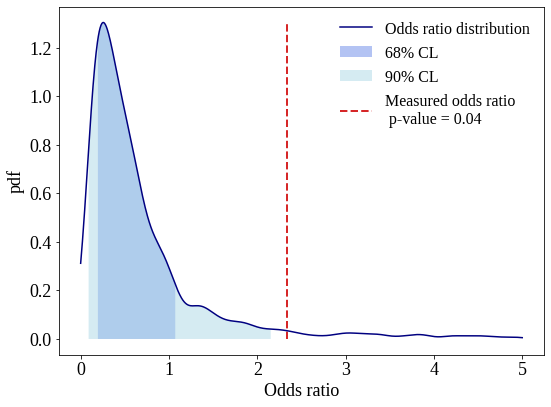

In [77]:
def kde_sklearn(data, bandwidth):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])
    return np.exp(log_pdf)

#evaluate and plot the KDE
xgrid = np.linspace(0,5,1000)
pdf = kde_sklearn(O,bandwidth=h_opt)
plt.plot(xgrid,pdf,c='navy', label = 'Odds ratio distribution')
plt.xlabel(r'Odds ratio')
plt.ylabel(r'pdf')

#find 68% and 90% confidence levels
diff1, diff2, diff3, diff4 = [], [], [], []
for inf1, sup1, inf2, sup2 in zip(xgrid, xgrid, xgrid, xgrid):
    diff1.append(abs(np.sum(pdf[xgrid < inf1])/np.sum(pdf) - 0.16))
    diff2.append(abs(np.sum(pdf[xgrid < sup1])/np.sum(pdf) - 0.84))
    diff3.append(abs(np.sum(pdf[xgrid < inf2])/np.sum(pdf) - 0.05))
    diff4.append(abs(np.sum(pdf[xgrid < sup2])/np.sum(pdf) - 0.95))

inf1 = xgrid[np.argmin(diff1)]
sup1 = xgrid[np.argmin(diff2)]
inf2 = xgrid[np.argmin(diff3)]
sup2 = xgrid[np.argmin(diff4)]

#plot 68% and 90% confidence levels
xgrid_1 = np.linspace(inf1, sup1, 100)
plt.fill_between(xgrid_1, 0, integrand(O, xgrid_1, h_opt), color='royalblue', alpha=0.4, label='68% CL', edgecolor=None)
xgrid_1 = np.linspace(inf2, sup2, 100)
plt.fill_between(xgrid_1, 0, integrand(O, xgrid_1, h_opt), color='lightblue', alpha=0.5, label='90% CL', edgecolor=None)

#evaluate the pvalue of the obtained odds ratio
pvalue = np.sum(pdf[xgrid > Odds])/np.sum(pdf)
plt.vlines(x=Odds, ymin=0,ymax=np.max(pdf), linestyle = '--', color='tab:red', lw=2, label = 'Measured odds ratio \n p-value = {:.2f}'.format(pvalue))

plt.legend(frameon=False, fontsize=16)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 


/home/irene/.local/lib/python3.8/site-packages/astropy/cosmology/core.py:1495: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Text(0, 0.5, '$\\mu$')

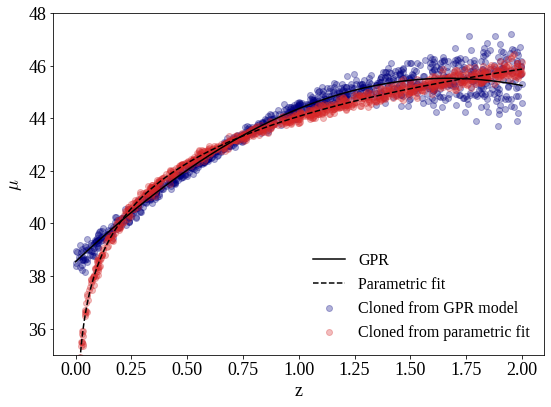

In [506]:
#generate z measures from a uniform distribution
N_random = 1000
z_new = 2*np.random.random(N_random)

#mu generated from GPR
kernel = kernels.ConstantKernel(1, (1e-3, 1e3))*kernels.RBF(1, (1e-3, 10))
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha = dmu**2)
gp.fit(z, mu)

mu_new_gpr, err_new = gp.predict(z_new[:, None], return_std=True)
mu_new_gpr += np.random.normal(loc = 0, scale = err_new)

#mu generated from the fit
mu_new_nested = []
for n in range(N_random):
    par_new = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_new_nested.append(model1(z_new[n], par_new))

#plot
plt.scatter(z_new, mu_new_gpr, color = 'navy', alpha = 0.3, label = 'Cloned from GPR model')
plt.plot(x, f, color = 'k', label = 'GPR')
plt.scatter(z_new, mu_new_nested, color = 'tab:red', alpha = 0.3, label = 'Cloned from parametric fit')
plt.plot(x, model1(x, median_parameters1), '--', color = 'k', label = 'Parametric fit')

plt.legend(frameon = False, fontsize = 16)
plt.ylim(35, 48)
plt.xlabel('z')
plt.ylabel('$\mu$')